 Determine the average signal yield and the error on its measure

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle
import zfit
import mplhep
from numpy import random 

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})

/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


# Initialization of the data parameters

In [3]:
#Dowloading the data
bc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bu_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
cc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zcc_ecm91.root')['events']
qq_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zuds_ecm91.root')['events']
tree_gen = uproot.open("root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [4]:
#Transforming the data into a dataframe
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
cc_df = cc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
qq_df = qq_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])

#Getting general information on the data
df_gen = tree_gen.arrays(library="pd", how="zip")

In [5]:
#We consider as initial data the data whose MVAs are between 0.95 and 1

bc_sig = bc_df[bc_df['EVT_MVA2']> 0.95]
bc_sig = bc_sig[bc_sig['EVT_MVA1']> 0.95]

bu_bkg = bu_df[bu_df['EVT_MVA2']> 0.95]
bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']> 0.95] 

bb_bkg = bb_df[bb_df['EVT_MVA2']> 0.95]
bb_bkg = bb_bkg[bb_bkg['EVT_MVA1']> 0.95] 

cc_bkg = cc_df[cc_df['EVT_MVA2']> 0.95]
cc_bkg = cc_bkg[cc_bkg['EVT_MVA1']> 0.95] 

qq_bkg = qq_df[qq_df['EVT_MVA2']> 0.95]
qq_bkg = qq_bkg[qq_bkg['EVT_MVA1']> 0.95]

In [39]:
#Number of Z0 produced
N_Z0_init = 5*10**(12)
N_Z0 = 4*10**(12)

#Branching fraction Z->quark-pair
BF_Zbb = 0.1512
BF_Zcc = 0.1203
BF_Zqq = 0.4276

#Production ratio of Bc+ and B+
f_Bc = 0.0004
f_Bu = 0.43

#Branching fraction Bc+->tau nu B+->tau nu and tau->3pions
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

In [40]:
#Definition of the functions computing the different yields
def S_bc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bu_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bb_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2)*initial_eff*cut_eff

def B_cc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zcc*2)*initial_eff*cut_eff

def B_qq_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zqq*2)*initial_eff*cut_eff

#Dowloading the splines to compute the number of inclusive background events

bb_spline_MVA1_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
bb_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

cc_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA1_spline_log.pkl','rb'))
cc_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA2_spline_log.pkl','rb'))

#qq_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA1_spline_log.pkl','rb'))
#qq_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA2_spline_log.pkl','rb'))

#http://localhost:8912/tree/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions

In [41]:
#Initialization of the number of events in the MVAs for all contributions
nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_events = len(bc_sig)
nb_bu_events = len(bu_bkg)
nb_bb_events = len(bb_bkg)
nb_cc_events = len(cc_bkg)
#nb_qq_events = len(qq_bkg)

#Initialization of the number of events for both MVAs for inclusive backgrounds
nb_bb_events_1 = interpolate.splint(-np.log(1-0.95), 9, bb_spline_MVA1_log)
nb_cc_events_1 = interpolate.splint(-np.log(1-0.95), 9, cc_spline_MVA1_log)
#nb_qq_events_1 = interpolate.splint(-np.log(1-0.95), 8, qq_spline_MVA1_log)

nb_bb_events_2 = interpolate.splint(-np.log(1-0.95), 8, bb_spline_MVA2_log)
nb_cc_events_2 = interpolate.splint(-np.log(1-0.95), 7, cc_spline_MVA2_log)
#nb_qq_events_2 = interpolate.splint(-np.log(1-0.95), 5.8, qq_spline_MVA2_log)

#Computing of the initial efficiencies for all backgrounds
initial_eff_bc_sig = nb_bc_events / nb_total_events
initial_eff_bu_bkg = nb_bu_events / nb_total_events
initial_eff_bb_bkg = nb_bb_events / nb_total_events
initial_eff_cc_bkg = nb_cc_events / nb_total_events
#initial_eff_qq_bkg = nb_qq_events / nb_total_events

print('eff sig {}'.format(initial_eff_bc_sig))
#print('eff bkg {}'.format(initial_eff_qq_bkg))

eff sig 0.2320645


In [42]:
#Optimized MVAs
Optimized_MVA1 = 0.9998599999999961  #+-0.00001
Optimized_MVA2 = 0.9963399999999984 #+-0.00001

Optimized_MVA1_log = -np.log(1-Optimized_MVA1)
Optimized_MVA2_log = -np.log(1-Optimized_MVA2)

#Applying the MVA2 cut on the dataframe
df_bc_sig = bc_sig[bc_sig['EVT_MVA1']>Optimized_MVA1]
df_bc_sig = df_bc_sig[df_bc_sig['EVT_MVA2']>Optimized_MVA2]

df_bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']>Optimized_MVA1]
df_bu_bkg = df_bu_bkg[df_bu_bkg['EVT_MVA2']>Optimized_MVA2]
          
#Counting the number of events in the Bc+ and B+ dataframes after the cut
nb_bc_after_cut = len(df_bc_sig)
nb_bu_after_cut = len(df_bu_bkg)
          
#Counting the number of events left for each MVAs for inclusive backgrounds
nb_bb_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, bb_spline_MVA1_log)
nb_bb_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 8, bb_spline_MVA2_log)
        
nb_cc_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, cc_spline_MVA1_log)
nb_cc_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 7, cc_spline_MVA2_log)
        
#nb_qq_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 8, qq_spline_MVA1_log)
#nb_qq_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 5.8, qq_spline_MVA2_log)

        
#Computing the efficiencies
cut_eff_bc_sig = nb_bc_after_cut / nb_bc_events
        
cut_eff_bu_bkg = nb_bu_after_cut / nb_bu_events
cut_eff_bb_bkg = (nb_bb_after_cut_1 / nb_bb_events_1) * (nb_bb_after_cut_2 / nb_bb_events_2)
cut_eff_cc_bkg = (nb_cc_after_cut_1 / nb_cc_events_1) * (nb_cc_after_cut_2 / nb_cc_events_2)
#cut_eff_qq_bkg = (nb_qq_after_cut_1 / nb_qq_events_1) * (nb_qq_after_cut_2 / nb_qq_events_2)
print(cut_eff_bu_bkg)
print(cut_eff_bb_bkg)
print(cut_eff_cc_bkg)
#print(cut_eff_qq_bkg)
        
    
#Signal, Background and Purity
S = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)
B = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg) + B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg) + B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg) #+ B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)
P = S/(S+B)

print('Number of signal events = {}'.format(S))
print('Number of bkg events = {}'.format(B))
print('Purity = {}'.format(P))

N_BC = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)

N_BU = B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg)
N_BB = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg)
N_CC = B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg)
#N_QQ = B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)

N_BB_CC = N_BB + N_CC

print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB = {}'.format(N_BB))
print('N_CC = {}'.format(N_CC))
#print('N_QQ = {}'.format(N_QQ))

0.0007226931575174898
3.137790945458242e-06
1.797967906975173e-06
Number of signal events = 3207.4119586252805
Number of bkg events = 3578.312775498564
Purity = 0.4726705082061383
N_BC = 3207.4119586252805
N_BU = 193.18237368191998
N_BB = 2892.1496088512326
N_CC = 492.98079296541107


# Initialization of the fits parameters

### Initialization of the data of reference

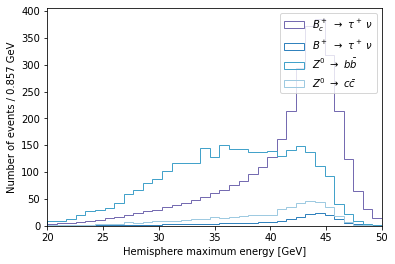

[]

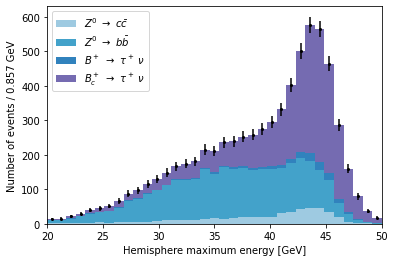

In [43]:
variable = 'EVT_ThrustEmax_E'

nb_bins = int(40/np.sqrt(N_Z0_init/N_Z0))
min_bin = 20
max_bin = 50

name_bc = r"$B_c^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bu = r"$B^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bb = r"$Z^0$ $\rightarrow$ $b\bar{b}$ "
name_cc = r"$Z^0$ $\rightarrow$ $c\bar{c}$ "

colour_bc = "#756bb1"
colour_bu = "#3182bd" #"#2c7fb8" #
colour_bb = "#43a2ca" #"#edf8b1" #"#a6bddb"
colour_cc = "#9ecae1" #"#7fcdbb" #

counts_bc, bins_bc = np.histogram(bc_sig[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_cc, bins_cc = np.histogram(cc_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))

counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB
counts_cc = (counts_cc/np.sum(counts_cc)) * N_CC

plt.figure()
plt.hist(bins_bc[:-1], bins_bc, weights=counts_bc, histtype='step', color= colour_bc, label=name_bc)
plt.hist(bins_bu[:-1], bins_bu, weights=counts_bu, histtype='step', color= colour_bu, label=name_bu)
plt.hist(bins_bb[:-1], bins_bb, weights=counts_bb, histtype='step', color= colour_bb, label=name_bb)
plt.hist(bins_cc[:-1], bins_bb, weights=counts_cc, histtype='step', color= colour_cc, label=name_cc)
plt.legend()
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.show()

x = [bins_bb[:-1], bins_cc[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_bc
weights = [counts_cc, counts_bb, counts_bu, counts_bc ]
colour = [colour_cc, colour_bb, colour_bu, colour_bc]
name = [name_cc, name_bb, name_bu, name_bc]

plt.figure()
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[3])
plt.errorbar(bin_centres, counts[3], yerr=err, fmt='o', color='k', markersize=2)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.legend()
plt.plot()

### Creating the templates

In [44]:
#Getting the right bins_edges size
_ , bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=counts[2])

#Templates and templates normalisation
template_yield_bc, _ = np.histogram(a=bins_bc[:-1], bins=bins_edges, weights=counts_bc)
template_yield_bu, _ = np.histogram(a=bins_bu[:-1], bins=bins_edges, weights=counts_bu)
template_yield_bb, _ = np.histogram(a=bins_bb[:-1], bins=bins_edges, weights=counts_bb)
template_yield_cc, _ = np.histogram(a=bins_cc[:-1], bins=bins_edges, weights=counts_cc)
    
template_yield_bc = template_yield_bc/np.sum(template_yield_bc)
template_yield_bu = template_yield_bu/np.sum(template_yield_bu)
template_yield_bb = template_yield_bb/np.sum(template_yield_bb)
template_yield_cc = template_yield_cc/np.sum(template_yield_cc)
 
#Checking if there are zero bins    
print(template_yield_bc)
print(template_yield_bu)
print(template_yield_bb)
print(template_yield_cc)

[0.00106462 0.00138292 0.00182135 0.00232742 0.00294451 0.00353211
 0.00437471 0.00521773 0.00614662 0.00726458 0.00834524 0.00945887
 0.01075203 0.0119758  0.01345413 0.01510071 0.01677375 0.01895026
 0.02097413 0.02352271 0.02620053 0.0298042  0.03402886 0.04007443
 0.05037416 0.06674027 0.09144556 0.1158538  0.12026059 0.09908872
 0.06679535 0.03906228 0.02038175 0.00989773 0.00460758]
[0.00153529 0.00203118 0.00260047 0.0035387  0.00436783 0.00513746
 0.0062919  0.00722617 0.0080672  0.00913635 0.01078272 0.01183401
 0.01295077 0.01379577 0.01519419 0.01666204 0.01829452 0.0200004
 0.02238664 0.02509819 0.02842266 0.0307851  0.03494466 0.0408934
 0.04909946 0.06352799 0.08714048 0.11320467 0.12246201 0.09976197
 0.0617031  0.030797   0.01336534 0.00505415 0.00190622]
[0.00317041 0.00290621 0.00449141 0.00673712 0.00951123 0.00990753
 0.01149273 0.01492734 0.02073976 0.02311757 0.02760898 0.03038309
 0.03513871 0.04029062 0.04042272 0.04055482 0.05019815 0.04438573
 0.05178336 0.049

### Creating the function that we will use for the fit

In [45]:
#When considering only Z->bb and Bu for background
#def get_template(yield_sig, yield_bkg):
# return yield_sig*template_process1 + N_BU*template_process2 + yield_bkg*template_process3

#When considering Z->bb, Z->cc and Bu for background
def get_template(yield_bc, yield_bu, yield_bb_cc): 
    return yield_bc*template_yield_bc + yield_bu*template_yield_bu + yield_bb_cc*((N_BB/N_BB_CC)*template_yield_bb + (N_CC/N_BB_CC)*template_yield_cc)
    
def binned_nll(template, sample_hist):
    return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1*10**(-14)) / (template + 1*10**(-14))))
  # 1e-14 added in case there are empty bins

def loss(x):
    # by default, `x` is an `OrderedSet` of zfit parameters.
    x = np.array(x)

    print("Value of the parameters", x)
  
    # The first parameter is the Bc yield 
    yield_bc = x[0]
    # The second parameter is the Bu yield 
    yield_bu = x[1]
    # The second parameter is the Z->bb and Z->cc combined yield 
    yield_bb_cc = x[2]

    template = get_template(yield_bc, yield_bu, yield_bb_cc)

    nll = binned_nll(template, sample_hist)
    
    #Gaussian constraint on B+ -> tau nu yield
    nll += (yield_bu - N_BU)**2/2./N_BU*0.05

    return nll

loss.errordef = 0.5 # 0.5 for a log-likelihood
# We would set this parameter at 1 for a chi2 loss function.

# Toy samples

In [46]:
#Theoretical value of the yields parameters to give initial value to the fit parameters
print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB_CC = {}'.format(N_BB_CC))

N_BC = 3207.4119586252805
N_BU = 193.18237368191998
N_BB_CC = 3385.130401816644


### Creating and Fitting multiple toy samples

In [ ]:
n_loop = 2000
bc_yield = np.zeros(n_loop)
bu_yield = np.zeros(n_loop)
bb_cc_yield = np.zeros(n_loop)

bc_yield_error = np.zeros(n_loop)
bu_yield_error = np.zeros(n_loop)
bb_cc_yield_error = np.zeros(n_loop)

for i in range (n_loop) :
    
    #Toy sample
    data = np.random.poisson(counts[3])
    sample_hist, bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=data)
    print(sample_hist)

    #Initialisation of the parameters
    i_rand = random.randint(0,1000000000000,size=1)
    
    initial_params = {
            'value': [3000, 200, 3000],
            'lower' : [-1000., -1000., -1000.], # optional
            'upper': [10000., 10000., 10000.], # optional
            'name': [f"bc_yield_{i_rand}", f"bu_yield_{i_rand}", f"bb_cc_yield_{i_rand}"] # optional
        }

    
    #Fit
    minimiser = zfit.minimize.Minuit(verbosity=5)
    zfit.run.set_autograd_mode(False)
    zfit.run.set_graph_mode(False)
    
    #Extracting the informations
    result = minimiser.minimize(loss, initial_params)
    params = result.params
    params_hesse = result.hesse() #Computation of the errors
    corr = result.correlation(method="minuit_hesse")
    
    print(result.info['original'])
    print(params)
    print('correction {}'.format(corr))

    #Extracting the yield results
    bc_yield[i] = params[f"bc_yield_{i_rand}"]['value']
    bu_yield[i] = params[f"bu_yield_{i_rand}"]['value']
    bb_cc_yield[i] = params[f"bb_cc_yield_{i_rand}"]['value']
    
    bc_yield_error[i] = params[f"bc_yield_{i_rand}"]['minuit_hesse']['error']
    bu_yield_error[i] = params[f"bu_yield_{i_rand}"]['minuit_hesse']['error']
    bb_cc_yield_error[i] = params[f"bb_cc_yield_{i_rand}"]['minuit_hesse']['error']
    

[  9  10  22  33  43  48  57  58  96  97 123 139 142 187 163 167 249 209
 228 277 289 268 292 290 323 407 502 538 553 494 289 154  78  27  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3488.75613388  442.6536774  3614.56692609]
Value of the parameters [3238.40147217  316.60012919 3299.45584623]
Value of the parameters [3238.64202169  316.60012919 3299.45584623]
Value of the parameters [3238.16092519  316.60012919 3299.4558462

Value of the parameters [3206.53398606  177.7411425  3449.72553963]
Value of the parameters [3206.73861079  177.7411425  3449.72553963]
Value of the parameters [3206.32936323  177.7411425  3449.72553963]
Value of the parameters [3206.53398606  177.8714283  3449.72553963]
Value of the parameters [3206.53398606  177.61086304 3449.72553963]
Value of the parameters [3206.53398606  177.7411425  3449.93030728]
Value of the parameters [3206.53398606  177.7411425  3449.5207735 ]
Value of the parameters [3190.17224469  183.33209408 3454.34907595]
Value of the parameters [3168.67299384  190.70269222 3460.43083707]
Value of the parameters [3168.8772577   190.70269222 3460.43083707]
Value of the parameters [3168.46873193  190.70269222 3460.43083707]
Value of the parameters [3168.67299384  190.83328619 3460.43083707]
Value of the parameters [3168.67299384  190.57210454 3460.43083707]
Value of the parameters [3168.67299384  190.70269222 3460.63613205]
Value of the parameters [3168.67299384  190.7026

Value of the parameters [3172.95827565  200.97663657 3514.57022258]
Value of the parameters [3173.19529239  201.12783552 3514.61793459]
Value of the parameters [3173.19529239  200.97663657 3514.8564958 ]
Value of the parameters [3172.95827565  201.12783552 3514.8564958 ]
Value of the parameters [3172.95827565  200.97663657 3514.61793459]
Value of the parameters [3173.00567879  200.97663657 3514.61793459]
Value of the parameters [3172.91087261  200.97663657 3514.61793459]
Value of the parameters [3172.95827565  201.00687569 3514.61793459]
Value of the parameters [3172.95827565  200.94639778 3514.61793459]
Value of the parameters [3172.95827565  200.97663657 3514.66564668]
Value of the parameters [3172.95827565  200.97663657 3514.57022258]
Value of the parameters [3172.96775627  200.97663657 3514.61793459]
Value of the parameters [3172.94879503  200.97663657 3514.61793459]
Value of the parameters [3172.95827565  200.98268436 3514.61793459]
Value of the parameters [3172.95827565  200.9705

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[885253811521]        3422     +/- 1.3e+02       False
bu_yield_[885253811521]       196.7     +/-      62       False
bb_cc_yield_[885253811521]     3142     +/- 1.1e+02       False
correction [[ 1.         -0.43629629 -0.63167673]
 [-0.43629629  1.         -0.06187054]
 [-0.63167673 -0.06187054  1.        ]]
[ 14  15  26  19  40  36  51  63  88  95 111 140 140 169 164 194 237 199
 234 213 233 230 270 295 386 405 491 603 586 431 296 140  97  29  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3257.58276458  192.89853483 3343.03188019]
Value of the parameters [3257.78066934  192.89853483 3343.03188019]
Value of the parameters [3257.3848615   192.89853483 3343.03188019]
Value of the parameters [3257.58276458  193.01745689 3343.03188019]
Value of the parameters [3257.58276458  192.77961798 3343.03188019]
Value of the parameters [3257.58276458  192.89853483 3343.2273964 ]
Value of the parameters [3257.58276458  192.89853483 3342.83636551]
Value of the parameters [3261.88909778  190.50555966 3353.87162843]
Value of the parameters [3262.30852539  190.27262558 3354.92753849]
Value of the parameters [3262.5052913   190.27262558 3354.92753849]
Value of the parameters [3262.11176116  190.27262558 3354.92753849]
Value of the parameters [3262.30852539  190.3975815  3354.92753849]
Value of the parameters [3262.30852539  190.14767542 3354.92753849]
Value of the parameters [3262.30852539  190.27262558 3355.12374035]
Value of the parameters [3262.30852539  190.2726

Value of the parameters [3198.158236    185.38468646 3263.66197937]
Value of the parameters [3198.158236    185.28818892 3263.51170277]
Value of the parameters [3198.18839081  185.28818892 3263.51170277]
Value of the parameters [3198.12808122  185.28818892 3263.51170277]
Value of the parameters [3198.158236    185.30748815 3263.51170277]
Value of the parameters [3198.158236    185.26888982 3263.51170277]
Value of the parameters [3198.158236    185.28818892 3263.54175801]
Value of the parameters [3198.158236    185.28818892 3263.48164757]
Value of the parameters [3198.16426696  185.28818892 3263.51170277]
Value of the parameters [3198.15220504  185.28818892 3263.51170277]
Value of the parameters [3198.158236    185.29204875 3263.51170277]
Value of the parameters [3198.158236    185.28432909 3263.51170277]
Value of the parameters [3198.158236    185.28818892 3263.51771382]
Value of the parameters [3198.158236    185.28818892 3263.50569173]
Value of the parameters [3198.18839081  185.3074

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[850179328362]        3163     +/- 1.2e+02       False
bu_yield_[850179328362]       198.7     +/-      62       False
bb_cc_yield_[850179328362]     3277     +/- 1.1e+02       False
correction [[ 1.         -0.44537025 -0.62003034]
 [-0.44537025  1.         -0.06502176]
 [-0.62003034 -0.06502176  1.        ]]
[ 18  16  29  34  33  35  48  53  86 100 127 116 139 172 187 176 222 213
 265 250 266 266 289 300 297 377 473 544 606 463 245 147  79  36  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3167.07947908  148.18665614 3539.27234367]
Value of the parameters [3167.3414594   148.18665614 3539.27234367]
Value of the parameters [3166.81750197  148.18665614 3539.27234367]
Value of the parameters [3167.07947908  148.34005516 3539.27234367]
Value of the parameters [3167.07947908  148.03326618 3539.27234367]
Value of the parameters [3167.07947908  148.18665614 3539.52993709]
Value of the parameters [3167.07947908  148.18665614 3539.01475243]
Value of the parameters [3132.5187937   154.48545218 3580.38731298]
Value of the parameters [3059.42538076  167.89221136 3667.74306863]
Value of the parameters [3059.67934852  167.89221136 3667.74306863]
Value of the parameters [3059.17141631  167.89221136 3667.74306863]
Value of the parameters [3059.42538076  168.05589862 3667.74306863]
Value of the parameters [3059.42538076  167.72853421 3667.74306863]
Value of the parameters [3059.42538076  167.89221136 3667.99991122]
Value of the parameters [3059.42538076  167.8922

Value of the parameters [3143.16128684  198.61812627 3441.40193627]
Value of the parameters [3143.16128684  198.7379654  3441.59034364]
Value of the parameters [3143.16128684  198.7379654  3441.21353019]
Value of the parameters [3143.1987735   198.7379654  3441.40193627]
Value of the parameters [3143.12380025  198.7379654  3441.40193627]
Value of the parameters [3143.16128684  198.76193386 3441.40193627]
Value of the parameters [3143.16128684  198.71399715 3441.40193627]
Value of the parameters [3143.16128684  198.7379654  3441.43961764]
Value of the parameters [3143.16128684  198.7379654  3441.36425495]
Value of the parameters [3143.34872081  198.85780979 3441.40193627]
Value of the parameters [3143.34872081  198.7379654  3441.59034364]
Value of the parameters [3143.16128684  198.85780979 3441.59034364]
Value of the parameters [3143.16128684  198.7379654  3441.40193627]
Value of the parameters [3143.1987735   198.7379654  3441.40193627]
Value of the parameters [3143.12380025  198.7379

Value of the parameters [3235.63590015  199.81432053 3412.88580742]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.26                      │              Nfcn = 57               │
│ EDM = 0.000149 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[161033841678]        3236     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3564.15941877  479.92760822 3584.3805708 ]
Value of the parameters [3268.56212202  330.94156632 3278.14146911]
Value of the parameters [3268.80086626  330.94156632 3278.14146911]
Value of the parameters [3268.32338021  330.94156632 3278.14146911]
Value of the parameters [3268.56212202  331.11261427 3278.14146911]
Value of the parameters [3268.56212202  330.77052785 3278.14146911]
Value of the parameters [3268.56212202  330.94156632 3278.37760419]
Value of the parameters [3268.56212202  330.94156632 3277.90533641]
Value of the parameters [3287.26181384  254.96235901 3342.7217544 ]
Value of the parameters [3301.66101692  197.82512927 3392.52982703]
Value of the parameters [3301.90302517  197.82512927 3392.52982703]
Value of the parameters [3301.4190111   197.82512927 3392.52982703]
Value of the parameters [3301.66101692  197.9688

Value of the parameters [3110.30969424  192.29893336 3476.3054065 ]
Value of the parameters [3109.86226278  192.29893336 3476.3054065 ]
Value of the parameters [3110.08597728  192.44246627 3476.3054065 ]
Value of the parameters [3110.08597728  192.15540804 3476.3054065 ]
Value of the parameters [3110.08597728  192.29893336 3476.53104735]
Value of the parameters [3110.08597728  192.29893336 3476.07976744]
Value of the parameters [3110.08597728  192.29893336 3476.3054065 ]
Value of the parameters [3110.30969424  192.29893336 3476.3054065 ]
Value of the parameters [3109.86226278  192.29893336 3476.3054065 ]
Value of the parameters [3110.08597728  192.44246627 3476.3054065 ]
Value of the parameters [3110.08597728  192.15540804 3476.3054065 ]
Value of the parameters [3110.08597728  192.29893336 3476.53104735]
Value of the parameters [3110.08597728  192.29893336 3476.07976744]
Value of the parameters [3110.13072047  192.29893336 3476.3054065 ]
Value of the parameters [3110.04123418  192.2989

Value of the parameters [3298.71106602  195.10012228 3304.53276335]
Value of the parameters [3298.71106602  195.10012228 3304.440175  ]
Value of the parameters [3298.72037194  195.10012228 3304.48646913]
Value of the parameters [3298.7017601   195.10012228 3304.48646913]
Value of the parameters [3298.71106602  195.10602803 3304.48646913]
Value of the parameters [3298.71106602  195.09421654 3304.48646913]
Value of the parameters [3298.71106602  195.10012228 3304.49572797]
Value of the parameters [3298.71106602  195.10012228 3304.4772103 ]
Value of the parameters [3298.75759566  195.12965115 3304.48646913]
Value of the parameters [3298.75759566  195.10012228 3304.53276335]
Value of the parameters [3298.71106602  195.12965115 3304.53276335]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.77                      │              Nfcn = 57               │
│ EDM = 9.05e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62504756 -0.06346364  1.        ]]
[ 13  14  20  30  47  38  60  69  93 105 114 132 133 173 159 196 225 207
 231 235 265 262 268 284 330 401 507 585 545 452 280 157  77  39  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.19450034 3000.        ]
Value of the parameters [3000.          199.80551349 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3428.53426841  403.1095424  3499.68272998]
Value of the parameters [3205.59004081  296.21585107 3239.56547878]
Value of the parameters [3205.74773391  296.21585107 3239.56547878]
Value of the parameters [

Value of the parameters [3230.46683423  184.14834129 3373.67400132]
Value of the parameters [3229.59328179  183.60341428 3380.71049479]
Value of the parameters [3229.83762353  183.60341428 3380.71049479]
Value of the parameters [3229.34894271  183.60341428 3380.71049479]
Value of the parameters [3229.59328179  183.7589238  3380.71049479]
Value of the parameters [3229.59328179  183.44791375 3380.71049479]
Value of the parameters [3229.59328179  183.60341428 3380.95444844]
Value of the parameters [3229.59328179  183.60341428 3380.46654344]
Value of the parameters [3222.55337259  185.72553355 3383.99321362]
Value of the parameters [3206.72819152  190.50444146 3391.37780599]
Value of the parameters [3206.97251713  190.50444146 3391.37780599]
Value of the parameters [3206.48386861  190.50444146 3391.37780599]
Value of the parameters [3206.72819152  190.66037126 3391.37780599]
Value of the parameters [3206.72819152  190.34852064 3391.37780599]
Value of the parameters [3206.72819152  190.5044

Value of the parameters [3234.22167698  193.32703491 3293.43376137]
Value of the parameters [3234.22167698  193.27831943 3293.43376137]
Value of the parameters [3234.22167698  193.30267706 3293.47184382]
Value of the parameters [3234.22167698  193.30267706 3293.39567898]
Value of the parameters [3234.22932099  193.30267706 3293.43376137]
Value of the parameters [3234.21403297  193.30267706 3293.43376137]
Value of the parameters [3234.22167698  193.30754861 3293.43376137]
Value of the parameters [3234.22167698  193.29780552 3293.43376137]
Value of the parameters [3234.22167698  193.30267706 3293.44137785]
Value of the parameters [3234.22167698  193.30267706 3293.42614488]
Value of the parameters [3234.25989706  193.32703491 3293.43376137]
Value of the parameters [3234.25989706  193.30267706 3293.47184382]
Value of the parameters [3234.22167698  193.32703491 3293.47184382]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.67                      │    

bb_cc_yield_[621762817423]     3424     +/- 1.1e+02       False
correction [[ 1.         -0.44406779 -0.62586827]
 [-0.44406779  1.         -0.06196932]
 [-0.62586827 -0.06196932  1.        ]]
[ 15  15  17  39  42  50  55  58  92  74 125 116 157 178 180 177 227 209
 224 228 238 251 286 277 336 404 503 564 570 486 253 175  61  45  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3432.05217921  403.93996862 3470.71881185]
Value of

Value of the parameters [3241.41647891  166.2998812  3517.04270586]
Value of the parameters [3241.41647891  166.2998812  3516.68045344]
Value of the parameters [3221.80833802  167.81188104 3551.40886956]
Value of the parameters [3193.13275995  170.02702709 3602.05585972]
Value of the parameters [3193.31240229  170.02702709 3602.05585972]
Value of the parameters [3192.95311908  170.02702709 3602.05585972]
Value of the parameters [3193.13275995  170.14139163 3602.05585972]
Value of the parameters [3193.13275995  169.91266747 3602.05585972]
Value of the parameters [3193.13275995  170.02702709 3602.2363353 ]
Value of the parameters [3193.13275995  170.02702709 3601.87538514]
Value of the parameters [3164.26312687  181.87387896 3605.66341285]
Value of the parameters [3137.38186499  192.96647806 3609.0272492 ]
Value of the parameters [3137.56032221  192.96647806 3609.0272492 ]
Value of the parameters [3137.2034093   192.96647806 3609.0272492 ]
Value of the parameters [3137.38186499  193.0807

Value of the parameters [3227.8840557   193.77284096 3384.82670888]
Value of the parameters [3227.8840557   193.7213175  3384.82670888]
Value of the parameters [3227.8840557   193.74707911 3384.86714867]
Value of the parameters [3227.8840557   193.74707911 3384.78626915]
Value of the parameters [3228.08631809  193.87589081 3384.82670888]
Value of the parameters [3228.08631809  193.74707911 3385.02890847]
Value of the parameters [3227.8840557   193.87589081 3385.02890847]
Value of the parameters [3227.8840557   193.74707911 3384.82670888]
Value of the parameters [3227.92450803  193.74707911 3384.82670888]
Value of the parameters [3227.84360343  193.74707911 3384.82670888]
Value of the parameters [3227.8840557   193.77284096 3384.82670888]
Value of the parameters [3227.8840557   193.7213175  3384.82670888]
Value of the parameters [3227.8840557   193.74707911 3384.86714867]
Value of the parameters [3227.8840557   193.74707911 3384.78626915]
Value of the parameters [3227.89214616  193.7470

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[406205718792]        3071     +/- 1.2e+02       False
bu_yield_[406205718792]       193.2     +/-      62       False
bb_cc_yield_[406205718792]     3406     +/- 1.1e+02       False
correction [[ 1.         -0.44388156 -0.62507834]
 [-0.44388156  1.         -0.06307455]
 [-0.62507834 -0.06307455  1.        ]]
[ 23  15  23  27  37  44  59  62  84 115  92 143 147 183 175 165 224 196
 228 241 238 264 296 310 317 403 515 604 561 487 292 138  83  30  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3217.63851791  190.22088321 3352.13868995]
Value of the parameters [3217.83493842  190.22088321 3352.13868995]
Value of the parameters [3217.44209913  190.22088321 3352.13868995]
Value of the parameters [3217.63851791  190.3392488  3352.13868995]
Value of the parameters [3217.63851791  190.10252279 3352.13868995]
Value of the parameters [3217.63851791  190.22088321 3352.33261623]
Value of the parameters [3217.63851791  190.22088321 3351.94476515]
Value of the parameters [3213.65110134  189.98397185 3367.70452202]
Value of the parameters [3210.86358345  189.81833925 3378.5935581 ]
Value of the parameters [3211.05851731  189.81833925 3378.5935581 ]
Value of the parameters [3210.6686513   189.81833925 3378.5935581 ]
Value of the parameters [3210.86358345  189.94244291 3378.5935581 ]
Value of the parameters [3210.86358345  189.69424128 3378.5935581 ]
Value of the parameters [3210.86358345  189.81833925 3378.78820974]
Value of the parameters [3210.86358345  189.8183

Value of the parameters [3316.08917585  191.01491774 3296.60072687]
Value of the parameters [3316.08917585  191.01491774 3296.26687817]
Value of the parameters [3316.12274706  191.01491774 3296.43380194]
Value of the parameters [3316.05560468  191.01491774 3296.43380194]
Value of the parameters [3316.08917585  191.03619913 3296.43380194]
Value of the parameters [3316.08917585  190.99363652 3296.43380194]
Value of the parameters [3316.08917585  191.01491774 3296.46718683]
Value of the parameters [3316.08917585  191.01491774 3296.40041709]
Value of the parameters [3316.25703237  191.12132634 3296.43380194]
Value of the parameters [3316.25703237  191.01491774 3296.60072687]
Value of the parameters [3316.08917585  191.12132634 3296.60072687]
Value of the parameters [3316.08917585  191.01491774 3296.43380194]
Value of the parameters [3316.12274706  191.01491774 3296.43380194]
Value of the parameters [3316.05560468  191.01491774 3296.43380194]
Value of the parameters [3316.08917585  191.0361

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[354083081865]        3101     +/- 1.2e+02       False
bu_yield_[354083081865]       193.3     +/-      62       False
bb_cc_yield_[354083081865]     3411     +/- 1.1e+02       False
correction [[ 1.         -0.44247087 -0.62506373]
 [-0.44247087  1.         -0.06360671]
 [-0.62506373 -0.06360671  1.        ]]
[ 11  18  28  26  43  36  65  79  97  80  92 133 143 173 157 189 191 201
 248 240 273 267 275 303 341 386 455 622 553 474 252 164  76  36  26]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3259.02104659  188.56581983 3223.33023078]
Value of the parameters [3259.25013733  188.56581983 3223.33023078]
Value of the parameters [3258.79195811  188.56581983 3223.33023078]
Value of the parameters [3259.02104659  188.70576396 3223.33023078]
Value of the parameters [3259.02104659  188.42588295 3223.33023078]
Value of the parameters [3259.02104659  188.56581983 3223.55728737]
Value of the parameters [3259.02104659  188.56581983 3223.10317648]
Value of the parameters [3277.5800173   185.25968875 3217.28755739]
Value of the parameters [3305.67969419  180.26660079 3208.15065148]
Value of the parameters [3305.90801826  180.26660079 3208.15065148]
Value of the parameters [3305.45137228  180.26660079 3208.15065148]
Value of the parameters [3305.67969419  180.41198805 3208.15065148]
Value of the parameters [3305.67969419  180.1212214  3208.15065148]
Value of the parameters [3305.67969419  180.26660079 3208.3774513 ]
Value of the parameters [3305.67969419  180.2666

Value of the parameters [3015.41338992  195.07924631 3651.60142805]
Value of the parameters [3015.41338992  195.22954244 3651.83946813]
Value of the parameters [3015.41338992  195.22954244 3651.36338958]
Value of the parameters [3015.46002922  195.22954244 3651.60142805]
Value of the parameters [3015.36675074  195.22954244 3651.60142805]
Value of the parameters [3015.41338992  195.25960266 3651.60142805]
Value of the parameters [3015.41338992  195.19948255 3651.60142805]
Value of the parameters [3015.41338992  195.22954244 3651.64903593]
Value of the parameters [3015.41338992  195.22954244 3651.55382022]
Value of the parameters [3015.64658757  195.37984687 3651.60142805]
Value of the parameters [3015.64658757  195.22954244 3651.83946813]
Value of the parameters [3015.41338992  195.37984687 3651.83946813]
Value of the parameters [3015.41338992  195.22954244 3651.60142805]
Value of the parameters [3015.46002922  195.22954244 3651.60142805]
Value of the parameters [3015.36675074  195.2295

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.16                      │              Nfcn = 57               │
│ EDM = 0.000155 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[821059373154]        3214     +/- 1.3e+02       False
bu_yield_[821059373154]       197.7     +/-     

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3464.39260836  418.35984502 3395.63344695]
Value of the parameters [3216.69394217  300.48621909 3184.73507407]
Value of the parameters [3216.87599863  300.48621909 3184.73507407]
Value of the parameters [3216.51188719  300.48621909 3184.73507407]
Value of the parameters [3216.69394217  300.61432047 3184.73507407]
Value of the parameters [3216.69394217  300.35812317 3184.73507407]
Value of the parameters [3216.69394217  300.48621909 3184.91732025]
Value of the parameters [3216.69394217  300.48621909 3184.55282942]
Value of the parameters [3263.13718245  254.0460625  3188.61956497]
Value of the parameters [3321.78110105  196.58884843 3193.51445567]
Value of the parameters [3321.96408118  196.58884843 3193.51445567]
Value of the parameters [3321.59812229  196.58884843 3193.51445567]
Value of the parameters [3321.78110105  196.69991124 3193.51445567]
Value of the parameters [3321.78110105  196.4777

Value of the parameters [3234.07603817  191.69434262 3434.27561138]
Value of the parameters [3233.48735614  191.69434262 3434.27561138]
Value of the parameters [3233.78169524  191.88166518 3434.27561138]
Value of the parameters [3233.78169524  191.50703299 3434.27561138]
Value of the parameters [3233.78169524  191.69434262 3434.57033944]
Value of the parameters [3233.78169524  191.69434262 3433.98088649]
Value of the parameters [3233.78169524  191.69434262 3434.27561138]
Value of the parameters [3234.07603817  191.69434262 3434.27561138]
Value of the parameters [3233.48735614  191.69434262 3434.27561138]
Value of the parameters [3233.78169524  191.88166518 3434.27561138]
Value of the parameters [3233.78169524  191.50703299 3434.27561138]
Value of the parameters [3233.78169524  191.69434262 3434.57033944]
Value of the parameters [3233.78169524  191.69434262 3433.98088649]
Value of the parameters [3233.84056352  191.69434262 3434.27561138]
Value of the parameters [3233.72282711  191.6943

Value of the parameters [3278.38630236  192.80203322 3395.44172147]
Value of the parameters [3278.38630236  192.80203322 3395.36822995]
Value of the parameters [3278.39366325  192.80203322 3395.40497568]
Value of the parameters [3278.37894148  192.80203322 3395.40497568]
Value of the parameters [3278.38630236  192.80670096 3395.40497568]
Value of the parameters [3278.38630236  192.7973655  3395.40497568]
Value of the parameters [3278.38630236  192.80203322 3395.41232484]
Value of the parameters [3278.38630236  192.80203322 3395.39762653]
Value of the parameters [3278.42310681  192.82537198 3395.40497568]
Value of the parameters [3278.42310681  192.80203322 3395.44172147]
Value of the parameters [3278.38630236  192.82537198 3395.44172147]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.45                      │              Nfcn = 57               │
│ EDM = 0.000145 (Goal: 0.001)     │                                      │
├───────────────┬───────

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[777701225174]        3169     +/- 1.3e+02       False
bu_yield_[777701225174]       185.6     +/-      62       False
bb_cc_yield_[777701225174]     3681     +/- 1.1e+02       False
correction [[ 1.         -0.4349461  -0.62615221]
 [-0.4349461   1.         -0.06375359]
 [-0.62615221 -0.06375359  1.        ]]
[ 10  21  24  31  47  60  46  61  84  96 119 123 166 173 193 180 199 216
 249 278 271 252 318 295 343 390 488 580 569 437 321 146  89  46  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3210.10079824  184.82196571 3363.91818782]
Value of the parameters [3210.34643243  184.82196571 3363.91818782]
Value of the parameters [3209.85516678  184.82196571 3363.91818782]
Value of the parameters [3210.10079824  184.96991084 3363.91818782]
Value of the parameters [3210.10079824  184.6740287  3363.91818782]
Value of the parameters [3210.10079824  184.82196571 3364.16064929]
Value of the parameters [3210.10079824  184.82196571 3363.67572865]
Value of the parameters [3203.82873729  185.03051767 3381.06557811]
Value of the parameters [3198.02153286  185.22368002 3396.95656266]
Value of the parameters [3198.26518295  185.22368002 3396.95656266]
Value of the parameters [3197.77788548  185.22368002 3396.95656266]
Value of the parameters [3198.02153286  185.37913424 3396.95656266]
Value of the parameters [3198.02153286  185.06823477 3396.95656266]
Value of the parameters [3198.02153286  185.22368002 3397.20011901]
Value of the parameters [3198.02153286  185.2236

Value of the parameters [3231.92581914  197.31733607 3252.91518903]
Value of the parameters [3231.92581914  197.31733607 3252.56686495]
Value of the parameters [3231.96082349  197.31733607 3252.74102633]
Value of the parameters [3231.89081485  197.31733607 3252.74102633]
Value of the parameters [3231.92581914  197.33963639 3252.74102633]
Value of the parameters [3231.92581914  197.29503592 3252.74102633]
Value of the parameters [3231.92581914  197.31733607 3252.77585877]
Value of the parameters [3231.92581914  197.31733607 3252.70619395]
Value of the parameters [3232.10084142  197.42883951 3252.74102633]
Value of the parameters [3232.10084142  197.31733607 3252.91518903]
Value of the parameters [3231.92581914  197.42883951 3252.91518903]
Value of the parameters [3231.92581914  197.31733607 3252.74102633]
Value of the parameters [3231.96082349  197.31733607 3252.74102633]
Value of the parameters [3231.89081485  197.31733607 3252.74102633]
Value of the parameters [3231.92581914  197.3396

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[222952597521]        3052     +/- 1.2e+02       False
bu_yield_[222952597521]       189.7     +/-      62       False
bb_cc_yield_[222952597521]     3453     +/- 1.1e+02       False
correction [[ 1.         -0.44547629 -0.61575623]
 [-0.44547629  1.         -0.06721651]
 [-0.61575623 -0.06721651  1.        ]]
[ 17  11  14  33  46  41  57  69  75  92 112 124 157 170 157 185 212 215
 242 251 256 256 261 272 311 417 504 565 589 466 262 151  85  29  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3257.14996358  194.4047688  3371.10715582]
Value of the parameters [3257.34267858  194.4047688  3371.10715582]
Value of the parameters [3256.95725019  194.4047688  3371.10715582]
Value of the parameters [3257.14996358  194.52008442 3371.10715582]
Value of the parameters [3257.14996358  194.28945806 3371.10715582]
Value of the parameters [3257.14996358  194.4047688  3371.29736017]
Value of the parameters [3257.14996358  194.4047688  3370.91695288]
Value of the parameters [3257.74431749  192.69207362 3385.98499825]
Value of the parameters [3257.91815253  192.19136146 3390.33797006]
Value of the parameters [3258.10950969  192.19136146 3390.33797006]
Value of the parameters [3257.72679696  192.19136146 3390.33797006]
Value of the parameters [3257.91815253  192.31272361 3390.33797006]
Value of the parameters [3257.91815253  192.07000473 3390.33797006]
Value of the parameters [3257.91815253  192.19136146 3390.52887868]
Value of the parameters [3257.91815253  192.1913

Value of the parameters [3244.17222883  192.97160469 3435.42018208]
Value of the parameters [3244.17222883  193.1019628  3435.6253492 ]
Value of the parameters [3244.17222883  193.1019628  3435.21501651]
Value of the parameters [3244.21322465  193.1019628  3435.42018208]
Value of the parameters [3244.13123308  193.1019628  3435.42018208]
Value of the parameters [3244.17222883  193.12803517 3435.42018208]
Value of the parameters [3244.17222883  193.07589068 3435.42018208]
Value of the parameters [3244.17222883  193.1019628  3435.46121538]
Value of the parameters [3244.17222883  193.1019628  3435.37914884]
Value of the parameters [3244.3772087   193.23232717 3435.42018208]
Value of the parameters [3244.3772087  193.1019628 3435.6253492]
Value of the parameters [3244.17222883  193.23232717 3435.6253492 ]
Value of the parameters [3244.17222883  193.1019628  3435.42018208]
Value of the parameters [3244.21322465  193.1019628  3435.42018208]
Value of the parameters [3244.13123308  193.1019628

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.6                       │              Nfcn = 57               │
│ EDM = 2.66e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[782951160905]        3230     +/- 1.2e+02       False
bu_yield_[782951160905]       195.4     +/-     

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3562.00796915  478.24998498 3570.85393688]
Value of the parameters [3266.34817169  329.58294708 3270.52032301]
Value of the parameters [3266.57266127  329.58294708 3270.52032301]
Value of the parameters [3266.12368427  329.58294708 3270.52032301]
Value of the parameters [3266.34817169  329.74357957 3270.52032301]
Value of the parameters [3266.34817169  329.42232295 3270.52032301]
Value of the parameters [3266.34817169  329.58294708 3270.74273597]
Value of the parameters [3266.34817169  329.58294708 3270.29791216]
Value of the parameters [3289.06694017  256.43294358 3327.78471949]
Value of the parameters [3306.59694521  201.27121544 3372.02441734]
Value of the parameters [3306.82394805  201.27121544 3372.02441734]
Value of the parameters [3306.36994451  201.27121544 3372.02441734]
Value of the parameters [3306.59694521  201.40628247 3372.02441734]
Value of the parameters [3306.59694521  201.1361

Value of the parameters [3133.18950338  197.15677836 3535.19395791]
Value of the parameters [3133.41228898  197.29938329 3535.19395791]
Value of the parameters [3133.41228898  197.01418088 3535.19395791]
Value of the parameters [3133.41228898  197.15677836 3535.4188686 ]
Value of the parameters [3133.41228898  197.15677836 3534.96904888]
Value of the parameters [3133.45684639  197.15677836 3535.19395791]
Value of the parameters [3133.36773167  197.15677836 3535.19395791]
Value of the parameters [3133.41228898  197.18529875 3535.19395791]
Value of the parameters [3133.41228898  197.12825827 3535.19395791]
Value of the parameters [3133.41228898  197.15677836 3535.23893991]
Value of the parameters [3133.41228898  197.15677836 3535.14897597]
Value of the parameters [3133.63507698  197.29938329 3535.19395791]
Value of the parameters [3133.63507698  197.15677836 3535.4188686 ]
Value of the parameters [3133.41228898  197.29938329 3535.4188686 ]
Value of the parameters [3133.41228898  197.1567

Value of the parameters [3093.00852091  201.22543437 3498.15790216]
Value of the parameters [3093.00852091  201.18650201 3498.21924523]
Value of the parameters [3092.94778655  201.22543437 3498.21924523]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 32.64                      │              Nfcn = 57               │
│ EDM = 0.000116 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value 

Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3440.93531548  397.34184855 3400.17550151]
Value of the parameters [3207.14204155  291.5724004  3188.06982787]
Value of the parameters [3207.36984815  291.5724004  3188.06982787]
Value of the parameters [3206.9142373   291.5724004  3188.06982787]
Value of the parameters [3207.14204155  291.7318307  3188.06982787]
Value of the parameters [3207.14204155  291.41297863 3188.06982787]
Value of the parameters [3207.14204155  291.5724004  3188.29707301]
Value of the parameters [3207.14204155  291.5724004  3187.84258512]
Value of the parameters [3245.39290336  239.61402342 3207.85042195]
Value of the parameters [3283.34869866  189.06289398 3227.4631896 ]
Value of the parameters [3283.58205471  189.0628

Value of the parameters [3196.09262532  188.79437335 3376.80780839]
Value of the parameters [3184.95188229  192.27994715 3380.85949842]
Value of the parameters [3167.76055053  197.67087353 3386.76807061]
Value of the parameters [3167.98655324  197.67087353 3386.76807061]
Value of the parameters [3167.53455021  197.67087353 3386.76807061]
Value of the parameters [3167.76055053  197.81531447 3386.76807061]
Value of the parameters [3167.76055053  197.52644024 3386.76807061]
Value of the parameters [3167.76055053  197.67087353 3386.99452803]
Value of the parameters [3167.76055053  197.67087353 3386.54161515]
Value of the parameters [3167.76055053  197.67087353 3386.76807061]
Value of the parameters [3167.98655324  197.67087353 3386.76807061]
Value of the parameters [3167.53455021  197.67087353 3386.76807061]
Value of the parameters [3167.76055053  197.81531447 3386.76807061]
Value of the parameters [3167.76055053  197.52644024 3386.76807061]
Value of the parameters [3167.76055053  197.6708

Value of the parameters [3202.24971445  188.97426755 3471.70670222]
Value of the parameters [3202.29252694  189.00159073 3471.70670222]
Value of the parameters [3202.29252694  188.94694464 3471.70670222]
Value of the parameters [3202.29252694  188.97426755 3471.74968759]
Value of the parameters [3202.29252694  188.97426755 3471.66371692]
Value of the parameters [3202.30108944  188.97426755 3471.70670222]
Value of the parameters [3202.28396443  188.97426755 3471.70670222]
Value of the parameters [3202.29252694  188.97973216 3471.70670222]
Value of the parameters [3202.29252694  188.96880294 3471.70670222]
Value of the parameters [3202.29252694  188.97426755 3471.71529929]
Value of the parameters [3202.29252694  188.97426755 3471.69810516]
Value of the parameters [3202.33533951  189.00159073 3471.70670222]
Value of the parameters [3202.33533951  188.97426755 3471.74968759]
Value of the parameters [3202.29252694  189.00159073 3471.74968759]
┌──────────────────────────────────┬────────────

bc_yield_[637947367570]        3176     +/- 1.2e+02       False
bu_yield_[637947367570]         195     +/-      62       False
bb_cc_yield_[637947367570]     3310     +/- 1.1e+02       False
correction [[ 1.         -0.44173927 -0.62567846]
 [-0.44173927  1.         -0.06386544]
 [-0.62567846 -0.06386544  1.        ]]
[ 11  15  34  31  45  52  41  80  73  99 124 138 161 199 180 165 182 208
 255 229 270 234 282 308 299 414 470 583 582 472 293 155  84  33  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3277.48249952  194.67516226 3258.1268589 ]
Value of the parameters [3277.48249952  194.38036082 3258.1268589 ]
Value of the parameters [3277.48249952  194.52775755 3258.36752421]
Value of the parameters [3277.48249952  194.52775755 3257.88619611]
Value of the parameters [3295.61097531  190.80383677 3254.93753801]
Value of the parameters [3316.02904495  186.61907858 3251.34883144]
Value of the parameters [3316.2711326   186.61907858 3251.34883144]
Value of the parameters [3315.78695971  186.61907858 3251.34883144]
Value of the parameters [3316.02904495  186.77276056 3251.34883144]
Value of the parameters [3316.02904495  186.46540534 3251.34883144]
Value of the parameters [3316.02904495  186.61907858 3251.58952895]
Value of the parameters [3316.02904495  186.61907858 3251.10813645]
Value of the parameters [3323.87727465  186.93952078 3237.89842074]
Value of the parameters [3332.97560803  187.31092394 3222.32091107]
Value of the parameters [3333.21837581  187.3109

Value of the parameters [3153.28199704  181.21057811 3483.79961157]
Value of the parameters [3153.18788753  181.21057811 3483.79961157]
Value of the parameters [3153.23494224  181.24080308 3483.79961157]
Value of the parameters [3153.23494224  181.18035348 3483.79961157]
Value of the parameters [3153.23494224  181.21057811 3483.84701458]
Value of the parameters [3153.23494224  181.21057811 3483.75220863]
Value of the parameters [3153.47021733  181.36170637 3483.79961157]
Value of the parameters [3153.47021733  181.21057811 3484.03662742]
Value of the parameters [3153.23494224  181.36170637 3484.03662742]
Value of the parameters [3153.23494224  181.21057811 3483.79961157]
Value of the parameters [3153.28199704  181.21057811 3483.79961157]
Value of the parameters [3153.18788753  181.21057811 3483.79961157]
Value of the parameters [3153.23494224  181.24080308 3483.79961157]
Value of the parameters [3153.23494224  181.18035348 3483.79961157]
Value of the parameters [3153.23494224  181.2105

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[748555152910]        3140     +/- 1.2e+02       False
bu_yield_[748555152910]       202.6     +/-      62       False
bb_cc_yield_[748555152910]     3325     +/- 1.1e+02       False
correction [[ 1.         -0.4430983  -0.62698235]
 [-0.4430983   1.         -0.06257718]
 [-0.62698235 -0.06257718  1.        ]]
[ 12  21  36  28  39  41  49  61 123  91 128 133 151 167 148 190 221 201
 224 245 270 227 285 299 361 367 515 594 537 449 268 167  80  36  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3306.96975732  195.22266525 3336.64395758]
Value of the parameters [3307.15282361  195.22266525 3336.64395758]
Value of the parameters [3306.78669242  195.22266525 3336.64395758]
Value of the parameters [3306.96975732  195.33216177 3336.64395758]
Value of the parameters [3306.96975732  195.11317313 3336.64395758]
Value of the parameters [3306.96975732  195.22266525 3336.82496119]
Value of the parameters [3306.96975732  195.22266525 3336.46295529]
Value of the parameters [3321.60216964  190.77211119 3341.22249807]
Value of the parameters [3326.82575392  189.1857318  3342.8565178 ]
Value of the parameters [3327.0077671  189.1857318 3342.8565178]
Value of the parameters [3326.64374208  189.1857318  3342.8565178 ]
Value of the parameters [3326.82575392  189.3009564  3342.8565178 ]
Value of the parameters [3326.82575392  189.07051211 3342.8565178 ]
Value of the parameters [3326.82575392  189.1857318  3343.03784471]
Value of the parameters [3326.82575392  189.1857318

Value of the parameters [3363.48705399  185.58106787 3219.87900166]
Value of the parameters [3363.48705399  185.58106787 3219.48263423]
Value of the parameters [3363.52707591  185.58106787 3219.68081707]
Value of the parameters [3363.44703213  185.58106787 3219.68081707]
Value of the parameters [3363.48705399  185.60645779 3219.68081707]
Value of the parameters [3363.48705399  185.5556782  3219.68081707]
Value of the parameters [3363.48705399  185.58106787 3219.72045384]
Value of the parameters [3363.48705399  185.58106787 3219.64118036]
Value of the parameters [3363.68716422  185.70801982 3219.68081707]
Value of the parameters [3363.68716422  185.58106787 3219.87900166]
Value of the parameters [3363.48705399  185.70801982 3219.87900166]
Value of the parameters [3363.48705399  185.58106787 3219.68081707]
Value of the parameters [3363.52707591  185.58106787 3219.68081707]
Value of the parameters [3363.44703213  185.58106787 3219.68081707]
Value of the parameters [3363.48705399  185.6064

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[236120458146]        3320     +/- 1.2e+02       False
bu_yield_[236120458146]       187.3     +/-      62       False
bb_cc_yield_[236120458146]     3204     +/- 1.1e+02       False
correction [[ 1.         -0.43995098 -0.62277606]
 [-0.43995098  1.         -0.06524067]
 [-0.62277606 -0.06524067  1.        ]]
[ 12   9  24  34  30  41  60  64  91 122  97 130 155 178 152 172 218 198
 216 254 231 245 266 305 321 403 473 608 557 454 262 178  80  42  10]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3152.31661711  168.39037108 3406.3623454 ]
Value of the parameters [3151.85570312  168.39037108 3406.3623454 ]
Value of the parameters [3152.08615886  168.5289103  3406.3623454 ]
Value of the parameters [3152.08615886  168.25183909 3406.3623454 ]
Value of the parameters [3152.08615886  168.39037108 3406.58967999]
Value of the parameters [3152.08615886  168.39037108 3406.13501276]
Value of the parameters [3132.15418442  172.68120677 3431.1353155 ]
Value of the parameters [3092.15527943  181.32538104 3480.9889332 ]
Value of the parameters [3092.38173209  181.32538104 3480.9889332 ]
Value of the parameters [3091.92882933  181.32538104 3480.9889332 ]
Value of the parameters [3092.15527943  181.47128933 3480.9889332 ]
Value of the parameters [3092.15527943  181.17948068 3480.9889332 ]
Value of the parameters [3092.15527943  181.32538104 3481.21669622]
Value of the parameters [3092.15527943  181.32538104 3480.76117199]
Value of the parameters [3071.04477716  191.0610

Value of the parameters [3268.40023299  186.73124322 3355.59284676]
Value of the parameters [3268.40023299  186.57416656 3355.83926456]
Value of the parameters [3268.15314164  186.73124322 3355.83926456]
Value of the parameters [3268.15314164  186.57416656 3355.59284676]
Value of the parameters [3268.2025597   186.57416656 3355.59284676]
Value of the parameters [3268.10372369  186.57416656 3355.59284676]
Value of the parameters [3268.15314164  186.60558116 3355.59284676]
Value of the parameters [3268.15314164  186.54275232 3355.59284676]
Value of the parameters [3268.15314164  186.57416656 3355.64213013]
Value of the parameters [3268.15314164  186.57416656 3355.54356349]
Value of the parameters [3268.16302525  186.57416656 3355.59284676]
Value of the parameters [3268.14325805  186.57416656 3355.59284676]
Value of the parameters [3268.15314164  186.58044945 3355.59284676]
Value of the parameters [3268.15314164  186.56788368 3355.59284676]
Value of the parameters [3268.15314164  186.5741

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[159584600131]        3179     +/- 1.2e+02       False
bu_yield_[159584600131]       198.8     +/-      62       False
bb_cc_yield_[159584600131]     3484     +/- 1.1e+02       False
correction [[ 1.         -0.44079255 -0.62134548]
 [-0.44079255  1.         -0.0644953 ]
 [-0.62134548 -0.0644953   1.        ]]
[ 14  12  26  28  47  40  41  54  98  88 103 122 153 165 196 199 236 210
 242 245 220 277 281 321 335 407 503 620 616 451 275 179  90  27  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3207.69051941  189.78542568 3340.41822599]
Value of the parameters [3207.85733139  189.78542568 3340.41822599]
Value of the parameters [3207.52370869  189.78542568 3340.41822599]
Value of the parameters [3207.69051941  189.88623333 3340.41822599]
Value of the parameters [3207.69051941  189.68462178 3340.41822599]
Value of the parameters [3207.69051941  189.78542568 3340.58296162]
Value of the parameters [3207.69051941  189.78542568 3340.25349146]
Value of the parameters [3203.4378305   189.76114317 3355.25189206]
Value of the parameters [3200.22377864  189.74278822 3366.47040686]
Value of the parameters [3200.38927732  189.74278822 3366.47040686]
Value of the parameters [3200.0582812   189.74278822 3366.47040686]
Value of the parameters [3200.22377864  189.84826018 3366.47040686]
Value of the parameters [3200.22377864  189.63732037 3366.47040686]
Value of the parameters [3200.22377864  189.74278822 3366.63566605]
Value of the parameters [3200.22377864  189.7427

Value of the parameters [3312.40226535  188.49740996 3277.56403809]
Value of the parameters [3312.40226535  188.63701021 3277.78268069]
Value of the parameters [3312.40226535  188.63701021 3277.34539752]
Value of the parameters [3312.44625965  188.63701021 3277.56403809]
Value of the parameters [3312.35827112  188.63701021 3277.56403809]
Value of the parameters [3312.40226535  188.66493112 3277.56403809]
Value of the parameters [3312.40226535  188.60908958 3277.56403809]
Value of the parameters [3312.40226535  188.63701021 3277.60776645]
Value of the parameters [3312.40226535  188.63701021 3277.52030981]
Value of the parameters [3312.62223766  188.77661766 3277.56403809]
Value of the parameters [3312.62223766  188.63701021 3277.78268069]
Value of the parameters [3312.40226535  188.77661766 3277.78268069]
Value of the parameters [3312.40226535  188.63701021 3277.56403809]
Value of the parameters [3312.44625965  188.63701021 3277.56403809]
Value of the parameters [3312.35827112  188.6370

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[9081163140]        3240     +/- 1.3e+02       False
bu_yield_[9081163140]       200.4     +/-      62       False
bb_cc_yield_[9081163140]     3398     +/- 1.1e+02       False
correction [[ 1.         -0.43853523 -0.62777179]
 [-0.43853523  1.         -0.06258728]
 [-0.62777179 -0.06258728  1.        ]]
[ 11  18  18  28  40  48  57  83  78  87 114 140 128 141 179 177 215 211
 235 246 237 256 286 303 330 411 512 566 572 446 303 194  75  35  12]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3

Value of the parameters [3282.35998629  198.68217606 3215.21968728]
Value of the parameters [3282.60292134  198.68217606 3215.21968728]
Value of the parameters [3282.11705375  198.68217606 3215.21968728]
Value of the parameters [3282.35998629  198.83027819 3215.21968728]
Value of the parameters [3282.35998629  198.53408197 3215.21968728]
Value of the parameters [3282.35998629  198.68217606 3215.46044723]
Value of the parameters [3282.35998629  198.68217606 3214.97892995]
Value of the parameters [3305.48883942  195.60048005 3205.84013117]
Value of the parameters [3342.23114299  190.7181165  3190.96642705]
Value of the parameters [3342.47318722  190.7181165  3190.96642705]
Value of the parameters [3341.9891011   190.7181165  3190.96642705]
Value of the parameters [3342.23114299  190.87179871 3190.96642705]
Value of the parameters [3342.23114299  190.564443   3190.96642705]
Value of the parameters [3342.23114299  190.7181165  3191.20644341]
Value of the parameters [3342.23114299  190.7181

Value of the parameters [3267.4781736   192.34701201 3268.35944477]
Value of the parameters [3267.4781736   192.47557759 3268.56043344]
Value of the parameters [3267.4781736   192.47557759 3268.15845783]
Value of the parameters [3267.51858074  192.47557759 3268.35944477]
Value of the parameters [3267.43776654  192.47557759 3268.35944477]
Value of the parameters [3267.4781736   192.50129144 3268.35944477]
Value of the parameters [3267.4781736   192.44986399 3268.35944477]
Value of the parameters [3267.4781736   192.47557759 3268.39964236]
Value of the parameters [3267.4781736   192.47557759 3268.31924724]
Value of the parameters [3267.68021     192.60414926 3268.35944477]
Value of the parameters [3267.68021     192.47557759 3268.56043344]
Value of the parameters [3267.4781736   192.60414926 3268.56043344]
Value of the parameters [3267.4781736   192.47557759 3268.35944477]
Value of the parameters [3267.51858074  192.47557759 3268.35944477]
Value of the parameters [3267.43776654  192.4755

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.27                      │              Nfcn = 57               │
│ EDM = 2.7e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[621853455653]        3135     +/- 1.2e+02       False
bu_yield_[621853455653]       190.7     +/-     

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3493.15322479  436.25371707 3509.15448275]
Value of the parameters [3233.63784769  310.27896819 3241.18375322]
Value of the parameters [3233.81800832  310.27896819 3241.18375322]
Value of the parameters [3233.4576885   310.27896819 3241.18375322]
Value of the parameters [3233.63784769  310.40624033 3241.18375322]
Value of the parameters [3233.63784769  310.1517014  3241.18375322]
Value of the parameters [3233.63784769  310.27896819 3241.3621073 ]
Value of the parameters [3233.63784769  310.27896819 3241.00540055]
Value of the parameters [3250.82477823  245.26511046 3296.14035434]
Value of the parameters [3264.47508291  194.69364346 3339.84933989]
Value of the parameters [3264.65158554  194.69364346 3339.84933989]
Value of the parameters [3264.29858162  194.69364346 3339.84933989]
Value of the parameters [3264.47508291  194.79967848 3339.84933989]
Value of the parameters [3264.47508291  194.5876

Value of the parameters [3265.76195397  188.56702594 3356.01936411]
Value of the parameters [3265.76195397  188.59322428 3356.0604851 ]
Value of the parameters [3265.76195397  188.59322428 3355.97824318]
Value of the parameters [3265.96814086  188.7242198  3356.01936411]
Value of the parameters [3265.96814086  188.59322428 3356.22496974]
Value of the parameters [3265.76195397  188.7242198  3356.22496974]
Value of the parameters [3265.76195397  188.59322428 3356.01936411]
Value of the parameters [3265.8031912   188.59322428 3356.01936411]
Value of the parameters [3265.72071681  188.59322428 3356.01936411]
Value of the parameters [3265.76195397  188.61942287 3356.01936411]
Value of the parameters [3265.76195397  188.56702594 3356.01936411]
Value of the parameters [3265.76195397  188.59322428 3356.0604851 ]
Value of the parameters [3265.76195397  188.59322428 3355.97824318]
Value of the parameters [3265.77020141  188.59322428 3356.01936411]
Value of the parameters [3265.75370653  188.5932

bc_yield_[260008267297]        3266     +/- 1.3e+02       False
bu_yield_[260008267297]         198     +/-      62       False
bb_cc_yield_[260008267297]     3324     +/- 1.1e+02       False
correction [[ 1.         -0.43922443 -0.62788122]
 [-0.43922443  1.         -0.06243291]
 [-0.62788122 -0.06243291  1.        ]]
[ 14  14  23  26  54  53  42  74  78  95 100 124 148 182 181 189 243 189
 248 239 265 244 288 311 336 413 512 606 588 452 304 162  68  32  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3240.2244387   186.5145647  3366.11685667]
Value of the parameters [3240.2244387   186.23679691 3366.11685667]
Value of the parameters [3240.2244387   186.37567723 3366.34550886]
Value of the parameters [3240.2244387   186.37567723 3365.88820653]
Value of the parameters [3238.76535854  185.04642214 3381.33698046]
Value of the parameters [3238.12238359  184.46083827 3388.0472102 ]
Value of the parameters [3238.35240829  184.46083827 3388.0472102 ]
Value of the parameters [3237.89236122  184.46083827 3388.0472102 ]
Value of the parameters [3238.12238359  184.60706209 3388.0472102 ]
Value of the parameters [3238.12238359  184.31462239 3388.0472102 ]
Value of the parameters [3238.12238359  184.46083827 3388.27684567]
Value of the parameters [3238.12238359  184.46083827 3387.81757675]
Value of the parameters [3231.24647986  186.5202425  3391.36427338]
Value of the parameters [3215.02595505  191.38718396 3399.19503471]
Value of the parameters [3215.25596231  191.3871

Value of the parameters [3225.1419275   191.93458693 3430.66820489]
Value of the parameters [3225.05363892  191.93458693 3430.66820489]
Value of the parameters [3225.09778317  191.9627146  3430.66820489]
Value of the parameters [3225.09778317  191.90645956 3430.66820489]
Value of the parameters [3225.09778317  191.93458693 3430.71241539]
Value of the parameters [3225.09778317  191.93458693 3430.62399445]
Value of the parameters [3225.3185057   192.07522819 3430.66820489]
Value of the parameters [3225.3185057   191.93458693 3430.88925814]
Value of the parameters [3225.09778317  192.07522819 3430.88925814]
Value of the parameters [3225.09778317  191.93458693 3430.66820489]
Value of the parameters [3225.1419275   191.93458693 3430.66820489]
Value of the parameters [3225.05363892  191.93458693 3430.66820489]
Value of the parameters [3225.09778317  191.9627146  3430.66820489]
Value of the parameters [3225.09778317  191.90645956 3430.66820489]
Value of the parameters [3225.09778317  191.9345

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[363514693677]        3337     +/- 1.3e+02       False
bu_yield_[363514693677]       199.8     +/-      62       False
bb_cc_yield_[363514693677]     3332     +/- 1.1e+02       False
correction [[ 1.         -0.43965955 -0.62434935]
 [-0.43965955  1.         -0.0620697 ]
 [-0.62434935 -0.0620697   1.        ]]
[ 16  15  20  41  39  42  47  57  81  99 120 142 180 162 163 170 198 195
 235 242 278 252 279 310 363 393 530 582 573 459 285 167  69  31  28]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3367.56136023  186.27194982 3217.64560282]
Value of the parameters [3367.79576939  186.27194982 3217.64560282]
Value of the parameters [3367.32695323  186.27194982 3217.64560282]
Value of the parameters [3367.56136023  186.4127951  3217.64560282]
Value of the parameters [3367.56136023  186.13111189 3217.64560282]
Value of the parameters [3367.56136023  186.27194982 3217.87803028]
Value of the parameters [3367.56136023  186.27194982 3217.41317778]
Value of the parameters [3405.62230664  182.58316245 3197.52062303]
Value of the parameters [3468.34487643  176.52665019 3164.45831079]
Value of the parameters [3468.57727737  176.52665019 3164.45831079]
Value of the parameters [3468.1124774   176.52665019 3164.45831079]
Value of the parameters [3468.34487643  176.67370719 3164.45831079]
Value of the parameters [3468.34487643  176.37960128 3164.45831079]
Value of the parameters [3468.34487643  176.52665019 3164.68811041]
Value of the parameters [3468.34487643  176.5266

Value of the parameters [3148.94644672  195.58234702 3458.83953532]
Value of the parameters [3148.94644672  195.72536957 3459.06422669]
Value of the parameters [3148.94644672  195.72536957 3458.61484575]
Value of the parameters [3148.99112085  195.72536957 3458.83953532]
Value of the parameters [3148.90177269  195.72536957 3458.83953532]
Value of the parameters [3148.94644672  195.75397498 3458.83953532]
Value of the parameters [3148.94644672  195.69676446 3458.83953532]
Value of the parameters [3148.94644672  195.72536957 3458.88447345]
Value of the parameters [3148.94644672  195.72536957 3458.79459726]
Value of the parameters [3149.1698183   195.86839964 3458.83953532]
Value of the parameters [3149.1698183   195.72536957 3459.06422669]
Value of the parameters [3148.94644672  195.86839964 3459.06422669]
Value of the parameters [3148.94644672  195.72536957 3458.83953532]
Value of the parameters [3148.99112085  195.72536957 3458.83953532]
Value of the parameters [3148.90177269  195.7253

Value of the parameters [3074.8899267   183.52044504 3492.74365987]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.23                      │              Nfcn = 57               │
│ EDM = 6.78e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[895796523242]        3075     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3279.5266526   327.18026119 3363.8737293 ]
Value of the parameters [3135.3441326   261.09620041 3176.02738977]
Value of the parameters [3135.54699159  261.09620041 3176.02738977]
Value of the parameters [3135.14127558  261.09620041 3176.02738977]
Value of the parameters [3135.3441326   261.23436246 3176.02738977]
Value of the parameters [3135.3441326   260.95804495 3176.02738977]
Value of the parameters [3135.3441326   261.09620041 3176.22665398]
Value of the parameters [3135.3441326   261.09620041 3175.82812741]
Value of the parameters [3116.5139074   214.8642448  3246.95972361]
Value of the parameters [3096.88840609  167.44234323 3321.19209224]
Value of the parameters [3097.08621606  167.44234323 3321.19209224]
Value of the parameters [3096.69059806  167.44234323 3321.19209224]
Value of the parameters [3096.88840609  167.5637

Value of the parameters [3244.18215734  193.08387459 3431.63980175]
Value of the parameters [3243.73728793  193.08387459 3431.63980175]
Value of the parameters [3243.95972155  193.22530691 3431.63980175]
Value of the parameters [3243.95972155  192.94244964 3431.63980175]
Value of the parameters [3243.95972155  193.08387459 3431.86240505]
Value of the parameters [3243.95972155  193.08387459 3431.41720027]
Value of the parameters [3243.95972155  193.08387459 3431.63980175]
Value of the parameters [3244.18215734  193.08387459 3431.63980175]
Value of the parameters [3243.73728793  193.08387459 3431.63980175]
Value of the parameters [3243.95972155  193.22530691 3431.63980175]
Value of the parameters [3243.95972155  192.94244964 3431.63980175]
Value of the parameters [3243.95972155  193.08387459 3431.86240505]
Value of the parameters [3243.95972155  193.08387459 3431.41720027]
Value of the parameters [3244.00420854  193.08387459 3431.63980175]
Value of the parameters [3243.91523465  193.0838

Value of the parameters [3140.60769898  186.09165339 3467.3309003 ]
Value of the parameters [3140.60769898  186.09165339 3467.26209644]
Value of the parameters [3140.61453232  186.09165339 3467.29649835]
Value of the parameters [3140.60086563  186.09165339 3467.29649835]
Value of the parameters [3140.60769898  186.09603332 3467.29649835]
Value of the parameters [3140.60769898  186.08727348 3467.29649835]
Value of the parameters [3140.60769898  186.09165339 3467.30337874]
Value of the parameters [3140.60769898  186.09165339 3467.28961797]
Value of the parameters [3140.64186573  186.11355308 3467.29649835]
Value of the parameters [3140.64186573  186.09165339 3467.3309003 ]
Value of the parameters [3140.60769898  186.11355308 3467.3309003 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.952                      │              Nfcn = 57               │
│ EDM = 9.18e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62454971 -0.06243909  1.        ]]
[ 25  18  18  30  33  43  53  68  83  99 133 136 144 181 163 175 186 200
 238 254 248 256 274 313 330 404 498 588 572 501 288 151  77  35  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3507.04927079  450.69448567 3521.32264688]
Value of the parameters [3239.38009311  316.48677214 3246.08716695]
Value of the parameters [3239.5753874   316.48677214 3246.08716695]
Value of the parameters [

Value of the parameters [3273.35418471  201.79619544 3353.40203923]
Value of the parameters [3273.55331751  201.79619544 3353.40203923]
Value of the parameters [3273.1550536   201.79619544 3353.40203923]
Value of the parameters [3273.35418471  201.92240371 3353.40203923]
Value of the parameters [3273.35418471  201.66999298 3353.40203923]
Value of the parameters [3273.35418471  201.79619544 3353.60046755]
Value of the parameters [3273.35418471  201.79619544 3353.20361247]
Value of the parameters [3273.39401113  201.79619544 3353.40203923]
Value of the parameters [3273.31435835  201.79619544 3353.40203923]
Value of the parameters [3273.35418471  201.82143663 3353.40203923]
Value of the parameters [3273.35418471  201.77095448 3353.40203923]
Value of the parameters [3273.35418471  201.79619544 3353.44172476]
Value of the parameters [3273.35418471  201.79619544 3353.36235375]
Value of the parameters [3273.55331751  201.92240371 3353.40203923]
Value of the parameters [3273.55331751  201.7961

Value of the parameters [3038.85257413  189.22506465 3625.33266636]
Value of the parameters [3038.85257413  189.22506465 3625.31225505]
Value of the parameters [3038.90266649  189.25735173 3625.3224607 ]
Value of the parameters [3038.90266649  189.22506465 3625.37348902]
Value of the parameters [3038.85257413  189.25735173 3625.37348902]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.04                      │              Nfcn = 57               │
│ EDM = 0.000224 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.19155188 3000.        ]
Value of the parameters [3000.          199.80846154 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3331.7973473   350.54307104 3398.93213259]
Value of the parameters [3158.84564268  271.39947655 3190.85457672]
Value of the parameters [3159.06064628  271.39947655 3190.85457672]
Value of the parameters [3158.63064126  271.39947655 3190.85457672]
Value of the parameters [3158.84564268  271.54696113 3190.85457672]
Value of the parameters [3158.84564268  271.25199941 3190.85457672]
Value of the parameters [3158.84564268  271.39947655 3191.06618576]
Value of the parameters [3158.84564268  271.39947655 3190.64296974]
Value of the parameters [3149.39066989  220.3739

Value of the parameters [3265.90873043  190.0620467  3357.34783151]
Value of the parameters [3265.90873043  190.1950667  3357.55685528]
Value of the parameters [3265.90873043  190.1950667  3357.13880946]
Value of the parameters [3265.90873043  190.1950667  3357.34783151]
Value of the parameters [3266.11836293  190.1950667  3357.34783151]
Value of the parameters [3265.69909981  190.1950667  3357.34783151]
Value of the parameters [3265.90873043  190.32809322 3357.34783151]
Value of the parameters [3265.90873043  190.0620467  3357.34783151]
Value of the parameters [3265.90873043  190.1950667  3357.55685528]
Value of the parameters [3265.90873043  190.1950667  3357.13880946]
Value of the parameters [3265.95065678  190.1950667  3357.34783151]
Value of the parameters [3265.86680415  190.1950667  3357.34783151]
Value of the parameters [3265.90873043  190.22167148 3357.34783151]
Value of the parameters [3265.90873043  190.16846217 3357.34783151]
Value of the parameters [3265.90873043  190.1950

Value of the parameters [3238.36599766  188.45106055 3349.19601726]
Value of the parameters [3238.58365141  188.58965231 3349.19601726]
Value of the parameters [3238.58365141  188.31247589 3349.19601726]
Value of the parameters [3238.58365141  188.45106055 3349.41331002]
Value of the parameters [3238.58365141  188.45106055 3348.97872637]
Value of the parameters [3238.62718241  188.45106055 3349.19601726]
Value of the parameters [3238.54012049  188.45106055 3349.19601726]
Value of the parameters [3238.58365141  188.47877833 3349.19601726]
Value of the parameters [3238.58365141  188.42334305 3349.19601726]
Value of the parameters [3238.58365141  188.45106055 3349.23947566]
Value of the parameters [3238.58365141  188.45106055 3349.15255893]
Value of the parameters [3238.80130724  188.58965231 3349.19601726]
Value of the parameters [3238.80130724  188.45106055 3349.41331002]
Value of the parameters [3238.58365141  188.58965231 3349.41331002]
┌──────────────────────────────────┬────────────

Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3532.46575089  453.6367429  3561.68437822]
Value of the parameters [3254.43891003  319.30901829 3268.33418277]
Value of the parameters [3254.67564736  319.30901829 3268.33418277]
Value of the parameters [3254.20217514  319.30901829 3268.33418277]
Value of the parameters [3254.43891003  319.477397   3268.33418277]
Value of the parameters [3254.43891003  319.14064886 3268.33418277]
Value of the parameters [3254.43891003  319.30901829 3268.5681029 ]
Value of the parameters [3254.43891003  319.3090

Value of the parameters [3277.79226188  190.47660019 3334.31845367]
Value of the parameters [3277.79226188  190.17531826 3334.31845367]
Value of the parameters [3277.79226188  190.32595504 3334.55479974]
Value of the parameters [3277.79226188  190.32595504 3334.08210986]
Value of the parameters [3277.79226188  190.32595504 3334.31845367]
Value of the parameters [3278.02940765  190.32595504 3334.31845367]
Value of the parameters [3277.5551185   190.32595504 3334.31845367]
Value of the parameters [3277.79226188  190.47660019 3334.31845367]
Value of the parameters [3277.79226188  190.17531826 3334.31845367]
Value of the parameters [3277.79226188  190.32595504 3334.55479974]
Value of the parameters [3277.79226188  190.32595504 3334.08210986]
Value of the parameters [3277.83969084  190.32595504 3334.31845367]
Value of the parameters [3277.74483301  190.32595504 3334.31845367]
Value of the parameters [3277.79226188  190.3560834  3334.31845367]
Value of the parameters [3277.79226188  190.2958

Value of the parameters [3135.87895149  195.99393745 3356.29500128]
Value of the parameters [3135.92668531  195.99393745 3356.29500128]
Value of the parameters [3135.83121779  195.99393745 3356.29500128]
Value of the parameters [3135.87895149  196.02452607 3356.29500128]
Value of the parameters [3135.87895149  195.96334917 3356.29500128]
Value of the parameters [3135.87895149  195.99393745 3356.34284724]
Value of the parameters [3135.87895149  195.99393745 3356.2471554 ]
Value of the parameters [3135.88849825  195.99393745 3356.29500128]
Value of the parameters [3135.86940474  195.99393745 3356.29500128]
Value of the parameters [3135.87895149  196.00005515 3356.29500128]
Value of the parameters [3135.87895149  195.98781977 3356.29500128]
Value of the parameters [3135.87895149  195.99393745 3356.30457046]
Value of the parameters [3135.87895149  195.99393745 3356.2854321 ]
Value of the parameters [3135.92668531  196.02452607 3356.29500128]
Value of the parameters [3135.92668531  195.9939

bc_yield_[64311442550]        3118     +/- 1.2e+02       False
bu_yield_[64311442550]       185.7     +/-      62       False
bb_cc_yield_[64311442550]     3421     +/- 1.1e+02       False
correction [[ 1.         -0.44029802 -0.6227939 ]
 [-0.44029802  1.         -0.06656216]
 [-0.6227939  -0.06656216  1.        ]]
[ 10  17  26  21  33  59  44  62  80 109 130 129 157 160 167 200 225 212
 245 233 268 243 289 325 322 399 502 582 559 464 283 160  88  39  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parame

Value of the parameters [3199.77730986  184.82040384 3364.04789702]
Value of the parameters [3199.77730986  184.49500879 3364.04789702]
Value of the parameters [3199.77730986  184.65770141 3364.31476794]
Value of the parameters [3199.77730986  184.65770141 3363.7810289 ]
Value of the parameters [3191.16315865  185.54679799 3382.57087178]
Value of the parameters [3180.86774761  186.61026928 3404.73600666]
Value of the parameters [3181.13580319  186.61026928 3404.73600666]
Value of the parameters [3180.59969535  186.61026928 3404.73600666]
Value of the parameters [3180.86774761  186.78115545 3404.73600666]
Value of the parameters [3180.86774761  186.43939392 3404.73600666]
Value of the parameters [3180.86774761  186.61026928 3405.00408319]
Value of the parameters [3180.86774761  186.61026928 3404.46793284]
Value of the parameters [3165.35923194  191.75231387 3408.68726702]
Value of the parameters [3147.08783262  197.82777246 3413.34689864]
Value of the parameters [3147.35570148  197.8277

Value of the parameters [3289.21801768  196.76957091 3349.28352347]
Value of the parameters [3295.14403826  195.83484117 3343.88589361]
Value of the parameters [3295.3684366   195.83484117 3343.88589361]
Value of the parameters [3294.91964202  195.83484117 3343.88589361]
Value of the parameters [3295.14403826  195.9769718  3343.88589361]
Value of the parameters [3295.14403826  195.69271796 3343.88589361]
Value of the parameters [3295.14403826  195.83484117 3344.10944469]
Value of the parameters [3295.14403826  195.83484117 3343.66234453]
Value of the parameters [3295.14403826  195.83484117 3343.88589361]
Value of the parameters [3295.3684366   195.83484117 3343.88589361]
Value of the parameters [3294.91964202  195.83484117 3343.88589361]
Value of the parameters [3295.14403826  195.9769718  3343.88589361]
Value of the parameters [3295.14403826  195.69271796 3343.88589361]
Value of the parameters [3295.14403826  195.83484117 3344.10944469]
Value of the parameters [3295.14403826  195.8348

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[338075948571]        3275     +/- 1.3e+02       False
bu_yield_[338075948571]       193.7     +/-      62       False
bb_cc_yield_[338075948571]     3427     +/- 1.1e+02       False
correction [[ 1.         -0.43464238 -0.63116938]
 [-0.43464238  1.         -0.06256087]
 [-0.63116938 -0.06256087  1.        ]]
[ 15  21  24  32  39  43  56  63 102 101 134 123 160 163 171 182 239 228
 207 263 262 250 277 269 342 358 484 584 535 460 275 164  84  29  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3206.77604449  171.11189283 3422.56220835]
Value of the parameters [3206.9719913   171.11189283 3422.56220835]
Value of the parameters [3206.58009942  171.11189283 3422.56220835]
Value of the parameters [3206.77604449  171.22861991 3422.56220835]
Value of the parameters [3206.77604449  170.99517087 3422.56220835]
Value of the parameters [3206.77604449  171.11189283 3422.75536358]
Value of the parameters [3206.77604449  171.11189283 3422.3690545 ]
Value of the parameters [3192.99108928  172.4670841  3447.03759637]
Value of the parameters [3172.85660391  174.44927647 3482.85333334]
Value of the parameters [3173.04959369  174.44927647 3482.85333334]
Value of the parameters [3172.66361587  174.44927647 3482.85333334]
Value of the parameters [3172.85660391  174.57250621 3482.85333334]
Value of the parameters [3172.85660391  174.32605242 3482.85333334]
Value of the parameters [3172.85660391  174.44927647 3483.04684519]
Value of the parameters [3172.85660391  174.4492

Value of the parameters [3399.5194529   192.12517128 3347.08818232]
Value of the parameters [3399.5194529   192.24716861 3347.28077848]
Value of the parameters [3399.5194529   192.24716861 3346.89558764]
Value of the parameters [3399.55820819  192.24716861 3347.08818232]
Value of the parameters [3399.48069767  192.24716861 3347.08818232]
Value of the parameters [3399.5194529   192.27156873 3347.08818232]
Value of the parameters [3399.5194529   192.2227687  3347.08818232]
Value of the parameters [3399.5194529   192.24716861 3347.12670143]
Value of the parameters [3399.5194529   192.24716861 3347.04966327]
Value of the parameters [3399.71322991  192.36917142 3347.08818232]
Value of the parameters [3399.71322991  192.24716861 3347.28077848]
Value of the parameters [3399.5194529   192.36917142 3347.28077848]
Value of the parameters [3399.5194529   192.24716861 3347.08818232]
Value of the parameters [3399.55820819  192.24716861 3347.08818232]
Value of the parameters [3399.48069767  192.2471

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[76698123431]        3326     +/- 1.3e+02       False
bu_yield_[76698123431]       191.8     +/-      62       False
bb_cc_yield_[76698123431]     3413     +/- 1.1e+02       False
correction [[ 1.         -0.43489487 -0.62876721]
 [-0.43489487  1.         -0.06299624]
 [-0.62876721 -0.06299624  1.        ]]
[ 12  14  26  23  42  34  44  58  91 111 108 153 161 176 184 180 225 216
 231 267 275 260 291 295 302 409 470 576 541 473 285 159  65  29  24]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3240.84932888  185.19992566 3405.82944059]
Value of the parameters [3241.1028602   185.19992566 3405.82944059]
Value of the parameters [3240.59580037  185.19992566 3405.82944059]
Value of the parameters [3240.84932888  185.35080674 3405.82944059]
Value of the parameters [3240.84932888  185.04905303 3405.82944059]
Value of the parameters [3240.84932888  185.19992566 3406.07944133]
Value of the parameters [3240.84932888  185.19992566 3405.5794422 ]
Value of the parameters [3234.07359162  184.84058809 3426.81308699]
Value of the parameters [3228.20618769  184.52937396 3445.00195607]
Value of the parameters [3228.45740186  184.52937396 3445.00195607]
Value of the parameters [3227.95497632  184.52937396 3445.00195607]
Value of the parameters [3228.20618769  184.68876134 3445.00195607]
Value of the parameters [3228.20618769  184.369996   3445.00195607]
Value of the parameters [3228.20618769  184.52937396 3445.25306764]
Value of the parameters [3228.20618769  184.5293

Value of the parameters [3195.17395466  187.06609299 3375.33153385]
Value of the parameters [3195.17395466  187.19700718 3375.53646739]
Value of the parameters [3195.17395466  187.19700718 3375.12660194]
Value of the parameters [3195.21490666  187.19700718 3375.33153385]
Value of the parameters [3195.13300274  187.19700718 3375.33153385]
Value of the parameters [3195.17395466  187.22319078 3375.33153385]
Value of the parameters [3195.17395466  187.17082384 3375.33153385]
Value of the parameters [3195.17395466  187.19700718 3375.37252043]
Value of the parameters [3195.17395466  187.19700718 3375.29054734]
Value of the parameters [3195.37871542  187.32792771 3375.33153385]
Value of the parameters [3195.37871542  187.19700718 3375.53646739]
Value of the parameters [3195.17395466  187.32792771 3375.53646739]
Value of the parameters [3195.17395466  187.19700718 3375.33153385]
Value of the parameters [3195.21490666  187.19700718 3375.33153385]
Value of the parameters [3195.13300274  187.1970

Value of the parameters [3124.09907263  199.85398966 3502.58760615]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.12                      │              Nfcn = 57               │
│ EDM = 0.000146 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[674291046198]        3124     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3365.58432519  365.85571604 3403.89501916]
Value of the parameters [3173.51551022  277.90732665 3191.62420739]
Value of the parameters [3173.74511932  277.90732665 3191.62420739]
Value of the parameters [3173.28590358  277.90732665 3191.62420739]
Value of the parameters [3173.51551022  278.06582865 3191.62420739]
Value of the parameters [3173.51551022  277.74883319 3191.62420739]
Value of the parameters [3173.51551022  277.90732665 3191.85097258]
Value of the parameters [3173.51551022  277.90732665 3191.39744455]
Value of the parameters [3176.935455    226.40612774 3246.76436423]
Value of the parameters [3179.87093589  182.94716678 3294.19289281]
Value of the parameters [3180.10339791  182.94716678 3294.19289281]
Value of the parameters [3179.63847638  182.94716678 3294.19289281]
Value of the parameters [3179.87093589  183.0890

Value of the parameters [3187.91640835  201.47375757 3263.66955985]
Value of the parameters [3188.18916198  201.64809343 3263.66955985]
Value of the parameters [3188.18916198  201.2994328  3263.66955985]
Value of the parameters [3188.18916198  201.47375757 3263.94125689]
Value of the parameters [3188.18916198  201.47375757 3263.39786598]
Value of the parameters [3188.24371311  201.47375757 3263.66955985]
Value of the parameters [3188.13461098  201.47375757 3263.66955985]
Value of the parameters [3188.18916198  201.50862385 3263.66955985]
Value of the parameters [3188.18916198  201.43889172 3263.66955985]
Value of the parameters [3188.18916198  201.47375757 3263.723899  ]
Value of the parameters [3188.18916198  201.47375757 3263.61522082]
Value of the parameters [3188.46191902  201.64809343 3263.66955985]
Value of the parameters [3188.46191902  201.47375757 3263.94125689]
Value of the parameters [3188.18916198  201.64809343 3263.94125689]
Value of the parameters [3181.86049344  203.0127

Value of the parameters [3409.56015307  190.00215273 3167.99551274]
Value of the parameters [3409.56692779  190.00215273 3168.02892428]
Value of the parameters [3409.55337836  190.00215273 3168.02892428]
Value of the parameters [3409.56015307  190.00644679 3168.02892428]
Value of the parameters [3409.56015307  189.99785869 3168.02892428]
Value of the parameters [3409.56015307  190.00215273 3168.03560659]
Value of the parameters [3409.56015307  190.00215273 3168.02224196]
Value of the parameters [3409.59402669  190.02362308 3168.02892428]
Value of the parameters [3409.59402669  190.00215273 3168.06233586]
Value of the parameters [3409.56015307  190.02362308 3168.06233586]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.6                        │              Nfcn = 57               │
│ EDM = 9.36e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum 

 254 236 249 253 282 282 322 381 513 611 592 479 289 145  66  36  13]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3458.40781098  424.38507543 3438.03914457]
Value of the parameters [3213.88071259  303.19250008 3204.41762931]
Value of the parameters [3214.10612161  303.19250008 3204.41762931]
Value of the parameters [3213.65530586  303.19250008 3204.41762931]
Value of the parameters [3213.88071259  303.35085734 3204.41762931]
Va

Value of the parameters [3210.05258431  175.73708162 3434.62301591]
Value of the parameters [3209.63967924  175.73708162 3434.62301591]
Value of the parameters [3209.84613082  175.86860651 3434.62301591]
Value of the parameters [3209.84613082  175.60556321 3434.62301591]
Value of the parameters [3209.84613082  175.73708162 3434.82955145]
Value of the parameters [3209.84613082  175.73708162 3434.41648193]
Value of the parameters [3195.41724155  180.58466031 3439.10060952]
Value of the parameters [3174.97627936  187.47259067 3445.4501942 ]
Value of the parameters [3175.18243951  187.47259067 3445.4501942 ]
Value of the parameters [3174.77012119  187.47259067 3445.4501942 ]
Value of the parameters [3174.97627936  187.60446617 3445.4501942 ]
Value of the parameters [3174.97627936  187.34072162 3445.4501942 ]
Value of the parameters [3174.97627936  187.47259067 3445.65725342]
Value of the parameters [3174.97627936  187.47259067 3445.24313653]
Value of the parameters [3174.97627936  187.4725

Value of the parameters [3337.20134095  184.79358231 3325.2800931 ]
Value of the parameters [3337.20134095  184.66905783 3325.4757834 ]
Value of the parameters [3337.00468043  184.79358231 3325.4757834 ]
Value of the parameters [3337.00468043  184.66905783 3325.2800931 ]
Value of the parameters [3337.04401241  184.66905783 3325.2800931 ]
Value of the parameters [3336.96534852  184.66905783 3325.2800931 ]
Value of the parameters [3337.00468043  184.69396227 3325.2800931 ]
Value of the parameters [3337.00468043  184.64415363 3325.2800931 ]
Value of the parameters [3337.00468043  184.66905783 3325.31923104]
Value of the parameters [3337.00468043  184.66905783 3325.24095523]
Value of the parameters [3337.01254683  184.66905783 3325.2800931 ]
Value of the parameters [3336.99681405  184.66905783 3325.2800931 ]
Value of the parameters [3337.00468043  184.6740387  3325.2800931 ]
Value of the parameters [3337.00468043  184.66407697 3325.2800931 ]
Value of the parameters [3337.00468043  184.6690

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[94628779860]        3108     +/- 1.2e+02       False
bu_yield_[94628779860]       193.7     +/-      62       False
bb_cc_yield_[94628779860]     3391     +/- 1.1e+02       False
correction [[ 1.         -0.44339733 -0.62297599]
 [-0.44339733  1.         -0.06429937]
 [-0.62297599 -0.06429937  1.        ]]
[ 18  21  20  28  35  50  42  71  77  94 120 133 142 162 166 188 211 212
 233 238 254 258 278 308 340 404 505 638 558 461 294 152  97  24  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3241.96030691  195.27511864 3346.84156653]
Value of the parameters [3242.1430722   195.27511864 3346.84156653]
Value of the parameters [3241.77754308  195.27511864 3346.84156653]
Value of the parameters [3241.96030691  195.38508946 3346.84156653]
Value of the parameters [3241.96030691  195.16515226 3346.84156653]
Value of the parameters [3241.96030691  195.27511864 3347.02204836]
Value of the parameters [3241.96030691  195.27511864 3346.66108599]
Value of the parameters [3242.79346824  193.838647   3359.82480163]
Value of the parameters [3243.01436209  193.4579351  3363.26804977]
Value of the parameters [3243.19595472  193.4579351  3363.26804977]
Value of the parameters [3242.83277091  193.4579351  3363.26804977]
Value of the parameters [3243.01436209  193.5732894  3363.26804977]
Value of the parameters [3243.01436209  193.3425857  3363.26804977]
Value of the parameters [3243.01436209  193.4579351  3363.44916726]
Value of the parameters [3243.01436209  193.4579

Value of the parameters [3355.18860156  196.42113013 3171.40330826]
Value of the parameters [3355.18860156  196.54363948 3171.59407618]
Value of the parameters [3355.18860156  196.54363948 3171.21254204]
Value of the parameters [3355.22721664  196.54363948 3171.40330826]
Value of the parameters [3355.14998654  196.54363948 3171.40330826]
Value of the parameters [3355.18860156  196.56814201 3171.40330826]
Value of the parameters [3355.18860156  196.51913717 3171.40330826]
Value of the parameters [3355.18860156  196.54363948 3171.44146171]
Value of the parameters [3355.18860156  196.54363948 3171.36515488]
Value of the parameters [3355.38167754  196.66615433 3171.40330826]
Value of the parameters [3355.38167754  196.54363948 3171.59407618]
Value of the parameters [3355.18860156  196.66615433 3171.59407618]
Value of the parameters [3355.18860156  196.54363948 3171.40330826]
Value of the parameters [3355.22721664  196.54363948 3171.40330826]
Value of the parameters [3355.14998654  196.5436

Value of the parameters [3175.71256334  193.72748939 3574.87586273]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.34                      │              Nfcn = 57               │
│ EDM = 0.00031 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[528017102536]        3176     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3508.40952765  442.64369839 3539.18989904]
Value of the parameters [3241.89791336  313.71246047 3256.47363359]
Value of the parameters [3242.1298348   313.71246047 3256.47363359]
Value of the parameters [3241.66599429  313.71246047 3256.47363359]
Value of the parameters [3241.89791336  313.8765229  3256.47363359]
Value of the parameters [3241.89791336  313.54840689 3256.47363359]
Value of the parameters [3241.89791336  313.71246047 3256.70278337]
Value of the parameters [3241.89791336  313.71246047 3256.24448608]
Value of the parameters [3254.98047638  242.96980304 3321.58311217]
Value of the parameters [3265.40799792  187.83842892 3373.57713812]
Value of the parameters [3265.64151287  187.83842892 3373.57713812]
Value of the parameters [3265.17448532  187.83842892 3373.57713812]
Value of the parameters [3265.40799792  187.9778

Value of the parameters [3226.68652393  187.95443641 3479.46034229]
Value of the parameters [3226.91714618  187.95443641 3479.46034229]
Value of the parameters [3226.45590405  187.95443641 3479.46034229]
Value of the parameters [3226.68652393  188.10127066 3479.46034229]
Value of the parameters [3226.68652393  187.80761014 3479.46034229]
Value of the parameters [3226.68652393  187.95443641 3479.69171031]
Value of the parameters [3226.68652393  187.95443641 3479.22897615]
Value of the parameters [3226.68652393  187.95443641 3479.46034229]
Value of the parameters [3226.91714618  187.95443641 3479.46034229]
Value of the parameters [3226.45590405  187.95443641 3479.46034229]
Value of the parameters [3226.68652393  188.10127066 3479.46034229]
Value of the parameters [3226.68652393  187.80761014 3479.46034229]
Value of the parameters [3226.68652393  187.95443641 3479.69171031]
Value of the parameters [3226.68652393  187.95443641 3479.22897615]
Value of the parameters [3226.73264819  187.9544

Value of the parameters [3236.08913868  186.41680975 3401.32703534]
Value of the parameters [3236.08913868  186.44532605 3401.37177702]
Value of the parameters [3236.08913868  186.44532605 3401.28229373]
Value of the parameters [3236.0980844   186.44532605 3401.32703534]
Value of the parameters [3236.08019296  186.44532605 3401.32703534]
Value of the parameters [3236.08913868  186.45102934 3401.32703534]
Value of the parameters [3236.08913868  186.43962276 3401.32703534]
Value of the parameters [3236.08913868  186.44532605 3401.33598367]
Value of the parameters [3236.08913868  186.44532605 3401.31808701]
Value of the parameters [3236.13386731  186.47384265 3401.32703534]
Value of the parameters [3236.13386731  186.44532605 3401.37177702]
Value of the parameters [3236.08913868  186.47384265 3401.37177702]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.32                      │              Nfcn = 57               │
│ EDM = 0.000101 (Goal: 0.001)  

 [-0.62201897 -0.06607293  1.        ]]
[ 10  13  13  28  46  41  68  69  96 106 116 125 136 171 164 176 217 237
 237 250 244 246 268 274 332 399 512 552 560 477 285 159  87  41  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3444.70537195  410.57697289 3488.6513683 ]
Value of the parameters [3211.88969566  299.01953285 3232.73341446]
Value of the parameters [3212.08514984  299.01953285 3232.73341446]
Value of the parameters [

Value of the parameters [3273.60994432  189.47126964 3398.29616779]
Value of the parameters [3274.01803625  188.91990377 3401.91411279]
Value of the parameters [3274.25219792  188.91990377 3401.91411279]
Value of the parameters [3273.78387691  188.91990377 3401.91411279]
Value of the parameters [3274.01803625  189.06817763 3401.91411279]
Value of the parameters [3274.01803625  188.77163804 3401.91411279]
Value of the parameters [3274.01803625  188.91990377 3402.14773489]
Value of the parameters [3274.01803625  188.91990377 3401.68049276]
Value of the parameters [3269.56335241  190.25594537 3404.46160813]
Value of the parameters [3256.26270462  194.25049913 3412.07219032]
Value of the parameters [3256.49697959  194.25049913 3412.07219032]
Value of the parameters [3256.02843202  194.25049913 3412.07219032]
Value of the parameters [3256.26270462  194.39919575 3412.07219032]
Value of the parameters [3256.26270462  194.10181065 3412.07219032]
Value of the parameters [3256.26270462  194.2504

Value of the parameters [3137.90238381  193.8222223  3270.41873631]
Value of the parameters [3137.84187368  193.8222223  3270.41873631]
Value of the parameters [3137.87212872  193.84164796 3270.41873631]
Value of the parameters [3137.87212872  193.80279678 3270.41873631]
Value of the parameters [3137.87212872  193.8222223  3270.44896046]
Value of the parameters [3137.87212872  193.8222223  3270.3885122 ]
Value of the parameters [3138.02340459  193.919352   3270.41873631]
Value of the parameters [3138.02340459  193.8222223  3270.56985747]
Value of the parameters [3137.87212872  193.919352   3270.56985747]
Value of the parameters [3137.87212872  193.8222223  3270.41873631]
Value of the parameters [3137.90238381  193.8222223  3270.41873631]
Value of the parameters [3137.84187368  193.8222223  3270.41873631]
Value of the parameters [3137.87212872  193.84164796 3270.41873631]
Value of the parameters [3137.87212872  193.80279678 3270.41873631]
Value of the parameters [3137.87212872  193.8222

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[946316901328]        3213     +/- 1.2e+02       False
bu_yield_[946316901328]       193.7     +/-      62       False
bb_cc_yield_[946316901328]     3343     +/- 1.1e+02       False
correction [[ 1.         -0.4405679  -0.62170181]
 [-0.4405679   1.         -0.06616422]
 [-0.62170181 -0.06616422  1.        ]]
[ 20  15  16  38  38  39  56  77  77  95 113 125 158 161 186 162 224 224
 254 230 240 303 286 313 332 423 477 553 542 462 266 178  94  32  23]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3284.58227856  200.2521278  3372.4801978 ]
Value of the parameters [3284.77654722  200.2521278  3372.4801978 ]
Value of the parameters [3284.38801151  200.2521278  3372.4801978 ]
Value of the parameters [3284.58227856  200.36804709 3372.4801978 ]
Value of the parameters [3284.58227856  200.13621342 3372.4801978 ]
Value of the parameters [3284.58227856  200.2521278  3372.67195597]
Value of the parameters [3284.58227856  200.2521278  3372.28844106]
Value of the parameters [3290.00028836  197.43117379 3385.12973867]
Value of the parameters [3290.55085704  197.14471243 3386.41534693]
Value of the parameters [3290.74386283  197.14471243 3386.41534693]
Value of the parameters [3290.35785281  197.14471243 3386.41534693]
Value of the parameters [3290.55085704  197.26684217 3386.41534693]
Value of the parameters [3290.55085704  197.02258816 3386.41534693]
Value of the parameters [3290.55085704  197.14471243 3386.60775953]
Value of the parameters [3290.55085704  197.1447

Value of the parameters [3285.50272562  206.4813946  3403.23480367]
Value of the parameters [3285.50272562  206.4813946  3402.67156683]
Value of the parameters [3285.55916892  206.4813946  3402.95318375]
Value of the parameters [3285.44628245  206.4813946  3402.95318375]
Value of the parameters [3285.50272562  206.51703499 3402.95318375]
Value of the parameters [3285.50272562  206.44575467 3402.95318375]
Value of the parameters [3285.50272562  206.4813946  3403.0095075 ]
Value of the parameters [3285.50272562  206.4813946  3402.89686013]
Value of the parameters [3285.78494349  206.65960118 3402.95318375]
Value of the parameters [3285.78494349  206.4813946  3403.23480367]
Value of the parameters [3285.50272562  206.65960118 3403.23480367]
Value of the parameters [3285.50272562  206.4813946  3402.95318375]
Value of the parameters [3285.55916892  206.4813946  3402.95318375]
Value of the parameters [3285.44628245  206.4813946  3402.95318375]
Value of the parameters [3285.50272562  206.5170

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[386112170854]        3381     +/- 1.3e+02       False
bu_yield_[386112170854]       194.8     +/-      62       False
bb_cc_yield_[386112170854]     3375     +/- 1.1e+02       False
correction [[ 1.         -0.43437054 -0.62721996]
 [-0.43437054  1.         -0.06360789]
 [-0.62721996 -0.06360789  1.        ]]
[ 12  21  28  35  36  42  54  67  94  96 123 121 152 168 176 179 207 198
 231 245 253 297 278 289 307 396 535 571 538 487 287 141  91  41  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3253.27785343  197.8743     3317.73327812]
Value of the parameters [3253.50117919  197.8743     3317.73327812]
Value of the parameters [3253.05452984  197.8743     3317.73327812]
Value of the parameters [3253.27785343  198.00914093 3317.73327812]
Value of the parameters [3253.27785343  197.73946573 3317.73327812]
Value of the parameters [3253.27785343  197.8743     3317.95402315]
Value of the parameters [3253.27785343  197.8743     3317.51253508]
Value of the parameters [3259.7476124   195.42604053 3325.74027348]
Value of the parameters [3260.21901654  195.24776645 3326.32369936]
Value of the parameters [3260.44123832  195.24776645 3326.32369936]
Value of the parameters [3259.99679689  195.24776645 3326.32369936]
Value of the parameters [3260.21901654  195.38896001 3326.32369936]
Value of the parameters [3260.21901654  195.10658022 3326.32369936]
Value of the parameters [3260.21901654  195.24776645 3326.54514309]
Value of the parameters [3260.21901654  195.2477

Value of the parameters [3262.7606446   190.08795315 3279.55430907]
Value of the parameters [3262.93172214  190.19689876 3279.58836548]
Value of the parameters [3262.93172214  190.08795315 3279.75864828]
Value of the parameters [3262.7606446   190.19689876 3279.75864828]
Value of the parameters [3262.7606446   190.08795315 3279.58836548]
Value of the parameters [3262.79486     190.08795315 3279.58836548]
Value of the parameters [3262.72642924  190.08795315 3279.58836548]
Value of the parameters [3262.7606446   190.10974192 3279.58836548]
Value of the parameters [3262.7606446   190.06616456 3279.58836548]
Value of the parameters [3262.7606446   190.08795315 3279.62242194]
Value of the parameters [3262.7606446   190.08795315 3279.55430907]
Value of the parameters [3262.76748767  190.08795315 3279.58836548]
Value of the parameters [3262.75380152  190.08795315 3279.58836548]
Value of the parameters [3262.7606446   190.09231089 3279.58836548]
Value of the parameters [3262.7606446   190.0835

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[24430121386]        3264     +/- 1.2e+02       False
bu_yield_[24430121386]       195.5     +/-      62       False
bb_cc_yield_[24430121386]     3260     +/- 1.1e+02       False
correction [[ 1.         -0.44002479 -0.62736992]
 [-0.44002479  1.         -0.06295026]
 [-0.62736992 -0.06295026  1.        ]]
[ 16  21  21  27  37  43  56  67  72 108 116 151 167 178 172 175 211 212
 235 211 250 268 245 299 283 377 489 576 571 483 263 167  77  52  21]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3200.31525416  172.7139735  3443.33695201]
Value of the parameters [3200.5389596   172.7139735  3443.33695201]
Value of the parameters [3200.09155099  172.7139735  3443.33695201]
Value of the parameters [3200.31525416  172.84700629 3443.33695201]
Value of the parameters [3200.31525416  172.58094735 3443.33695201]
Value of the parameters [3200.31525416  172.7139735  3443.55731043]
Value of the parameters [3200.31525416  172.7139735  3443.11659535]
Value of the parameters [3183.10403302  175.258053   3470.58842182]
Value of the parameters [3155.42271426  179.35912585 3514.5181482 ]
Value of the parameters [3155.6426883   179.35912585 3514.5181482 ]
Value of the parameters [3155.20274252  179.35912585 3514.5181482 ]
Value of the parameters [3155.42271426  179.49981569 3514.5181482 ]
Value of the parameters [3155.42271426  179.21844338 3514.5181482 ]
Value of the parameters [3155.42271426  179.35912585 3514.73900066]
Value of the parameters [3155.42271426  179.3591

Value of the parameters [3294.51049089  193.97954667 3315.72005564]
Value of the parameters [3294.51049089  194.13668521 3315.96677649]
Value of the parameters [3294.51049089  194.13668521 3315.4733373 ]
Value of the parameters [3294.56005836  194.13668521 3315.72005564]
Value of the parameters [3294.46092352  194.13668521 3315.72005564]
Value of the parameters [3294.51049089  194.16811401 3315.72005564]
Value of the parameters [3294.51049089  194.10525678 3315.72005564]
Value of the parameters [3294.51049089  194.13668521 3315.76939961]
Value of the parameters [3294.51049089  194.13668521 3315.67071177]
Value of the parameters [3294.75832928  194.29383283 3315.72005564]
Value of the parameters [3294.75832928  194.13668521 3315.96677649]
Value of the parameters [3294.51049089  194.29383283 3315.96677649]
Value of the parameters [3294.51049089  194.13668521 3315.72005564]
Value of the parameters [3294.56005836  194.13668521 3315.72005564]
Value of the parameters [3294.46092352  194.1366

Value of the parameters [3106.53727667  196.8927345  3555.46867498]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.11                      │              Nfcn = 57               │
│ EDM = 0.000197 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[94519204104]        3107     +/- 1.2

Value of the parameters [3200.13235465  293.16743709 3220.03585658]
Value of the parameters [3200.13235465  293.16743709 3219.62964596]
Value of the parameters [3203.89057633  234.78801498 3281.62597676]
Value of the parameters [3207.06253383  186.44169312 3333.89805652]
Value of the parameters [3207.26765454  186.44169312 3333.89805652]
Value of the parameters [3206.85741503  186.44169312 3333.89805652]
Value of the parameters [3207.06253383  186.5658129  3333.89805652]
Value of the parameters [3207.06253383  186.31757906 3333.89805652]
Value of the parameters [3207.06253383  186.44169312 3334.10067978]
Value of the parameters [3207.06253383  186.44169312 3333.69543492]
Value of the parameters [3203.78214409  186.07952871 3347.65534538]
Value of the parameters [3201.62367188  185.84122432 3356.71277825]
Value of the parameters [3201.82740496  185.84122432 3356.71277825]
Value of the parameters [3201.41994068  185.84122432 3356.71277825]
Value of the parameters [3201.62367188  185.9712

Value of the parameters [3441.49653402  195.79460908 3311.61139845]
Value of the parameters [3441.0894545   195.79460908 3311.61139845]
Value of the parameters [3441.29299351  195.92260777 3311.61139845]
Value of the parameters [3441.29299351  195.66661641 3311.61139845]
Value of the parameters [3441.29299351  195.79460908 3311.81318872]
Value of the parameters [3441.29299351  195.79460908 3311.40960986]
Value of the parameters [3441.33370149  195.79460908 3311.61139845]
Value of the parameters [3441.25228558  195.79460908 3311.61139845]
Value of the parameters [3441.29299351  195.82020834 3311.61139845]
Value of the parameters [3441.29299351  195.76901007 3311.61139845]
Value of the parameters [3441.29299351  195.79460908 3311.65175637]
Value of the parameters [3441.29299351  195.79460908 3311.57104059]
Value of the parameters [3441.49653402  195.92260777 3311.61139845]
Value of the parameters [3441.49653402  195.79460908 3311.81318872]
Value of the parameters [3441.29299351  195.9226

Value of the parameters [3347.84386572  196.06146193 3375.63560856]
Value of the parameters [3347.89498487  196.0936938  3375.64579066]
Value of the parameters [3347.89498487  196.06146193 3375.69670126]
Value of the parameters [3347.84386572  196.0936938  3375.69670126]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.26                      │              Nfcn = 57               │
│ EDM = 0.000238 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3526.36318253  460.63860217 3601.78825343]
Value of the parameters [3252.77781878  323.15058765 3288.81820694]
Value of the parameters [3253.01936976  323.15058765 3288.81820694]
Value of the parameters [3252.53627034  323.15058765 3288.81820694]
Value of the parameters [3252.77781878  323.32210066 3288.81820694]
Value of the parameters [3252.77781878  322.97908423 3288.81820694]
Value of the parameters [3252.77781878  323.15058765 3289.055408  ]
Value of the parameters [3252.77781878  323.15058765 3288.58100825]
Value of the parameters [3247.8935929   244.42395252 3379.74025415]
Value of the parameters [3243.68794305  178.3151

Value of the parameters [3207.57832491  178.98686085 3471.0701443 ]
Value of the parameters [3207.57832491  178.98686085 3470.63584272]
Value of the parameters [3189.75972967  185.23844542 3475.44771335]
Value of the parameters [3167.49277179  193.0783738  3481.19582949]
Value of the parameters [3167.70927453  193.0783738  3481.19582949]
Value of the parameters [3167.27627125  193.0783738  3481.19582949]
Value of the parameters [3167.49277179  193.21682642 3481.19582949]
Value of the parameters [3167.49277179  192.93992823 3481.19582949]
Value of the parameters [3167.49277179  193.0783738  3481.41361276]
Value of the parameters [3167.49277179  193.0783738  3480.97804788]
Value of the parameters [3167.49277179  193.0783738  3481.19582949]
Value of the parameters [3167.70927453  193.0783738  3481.19582949]
Value of the parameters [3167.27627125  193.0783738  3481.19582949]
Value of the parameters [3167.49277179  193.21682642 3481.19582949]
Value of the parameters [3167.49277179  192.9399

Value of the parameters [3277.90713887  194.55620174 3424.22680852]
Value of the parameters [3277.81332672  194.55620174 3424.22680852]
Value of the parameters [3277.86023275  194.58592591 3424.22680852]
Value of the parameters [3277.86023275  194.5264779  3424.22680852]
Value of the parameters [3277.86023275  194.55620174 3424.27368023]
Value of the parameters [3277.86023275  194.55620174 3424.17993689]
Value of the parameters [3277.86961397  194.55620174 3424.22680852]
Value of the parameters [3277.85085154  194.55620174 3424.22680852]
Value of the parameters [3277.86023275  194.56214655 3424.22680852]
Value of the parameters [3277.86023275  194.55025695 3424.22680852]
Value of the parameters [3277.86023275  194.55620174 3424.23618286]
Value of the parameters [3277.86023275  194.55620174 3424.21743419]
Value of the parameters [3277.90713887  194.58592591 3424.22680852]
Value of the parameters [3277.90713887  194.55620174 3424.27368023]
Value of the parameters [3277.86023275  194.5859

bc_yield_[614763751584]        3199     +/- 1.2e+02       False
bu_yield_[614763751584]       183.7     +/-      62       False
bb_cc_yield_[614763751584]     3395     +/- 1.1e+02       False
correction [[ 1.         -0.4392589  -0.62423717]
 [-0.4392589   1.         -0.06460325]
 [-0.62423717 -0.06460325  1.        ]]
[ 17  11  23  30  39  45  67  53  82 106 111 122 151 179 185 173 213 200
 241 244 243 230 270 297 354 430 524 535 563 458 278 168  60  37  23]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3223.75842025  199.29054604 3260.80611821]
Value of the parameters [3223.75842025  199.03873962 3260.80611821]
Value of the parameters [3223.75842025  199.16463993 3261.01005639]
Value of the parameters [3223.75842025  199.16463993 3260.60218183]
Value of the parameters [3231.45031013  197.07463497 3264.49727283]
Value of the parameters [3233.12683155  196.61940531 3265.30170614]
Value of the parameters [3233.33211706  196.61940531 3265.30170614]
Value of the parameters [3232.92154789  196.61940531 3265.30170614]
Value of the parameters [3233.12683155  196.75026021 3265.30170614]
Value of the parameters [3233.12683155  196.48855668 3265.30170614]
Value of the parameters [3233.12683155  196.61940531 3265.50612263]
Value of the parameters [3233.12683155  196.61940531 3265.09729145]
Value of the parameters [3235.43134344  196.40007663 3262.96633639]
Value of the parameters [3242.01444825  195.7737588  3256.29768422]
Value of the parameters [3242.22002835  195.7737

Value of the parameters [3334.41182274  194.28977897 3266.6909763 ]
Value of the parameters [3334.33416284  194.28977897 3266.6909763 ]
Value of the parameters [3334.37299276  194.31436794 3266.6909763 ]
Value of the parameters [3334.37299276  194.26519022 3266.6909763 ]
Value of the parameters [3334.37299276  194.28977897 3266.72952572]
Value of the parameters [3334.37299276  194.28977897 3266.65242694]
Value of the parameters [3334.56714327  194.41272603 3266.6909763 ]
Value of the parameters [3334.56714327  194.28977897 3266.88372403]
Value of the parameters [3334.37299276  194.41272603 3266.88372403]
Value of the parameters [3334.37299276  194.28977897 3266.6909763 ]
Value of the parameters [3334.41182274  194.28977897 3266.6909763 ]
Value of the parameters [3334.33416284  194.28977897 3266.6909763 ]
Value of the parameters [3334.37299276  194.31436794 3266.6909763 ]
Value of the parameters [3334.37299276  194.26519022 3266.6909763 ]
Value of the parameters [3334.37299276  194.2897

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[215238974779]        3342     +/- 1.2e+02       False
bu_yield_[215238974779]       197.5     +/-      62       False
bb_cc_yield_[215238974779]     3322     +/- 1.1e+02       False
correction [[ 1.         -0.43900014 -0.62262424]
 [-0.43900014  1.         -0.06391493]
 [-0.62262424 -0.06391493  1.        ]]
[ 12  16  25  40  50  28  43  46  76  98 121 132 149 180 172 170 214 182
 223 236 214 258 271 278 341 433 506 539 536 481 269 176  66  40  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3204.82937886  189.16792068 3375.91317082]
Value of the parameters [3205.02373248  189.16792068 3375.91317082]
Value of the parameters [3204.63502695  189.16792068 3375.91317082]
Value of the parameters [3204.82937886  189.29168552 3375.91317082]
Value of the parameters [3204.82937886  189.04416149 3375.91317082]
Value of the parameters [3204.82937886  189.16792068 3376.10726664]
Value of the parameters [3204.82937886  189.16792068 3375.71907645]
Value of the parameters [3194.64094151  192.28270941 3379.78119267]
Value of the parameters [3177.13551379  197.64619341 3386.43266544]
Value of the parameters [3177.32972496  197.64619341 3386.43266544]
Value of the parameters [3176.94130437  197.64619341 3386.43266544]
Value of the parameters [3177.13551379  197.77019379 3386.43266544]
Value of the parameters [3177.13551379  197.52219867 3386.43266544]
Value of the parameters [3177.13551379  197.64619341 3386.62718409]
Value of the parameters [3177.13551379  197.6461

Value of the parameters [3208.15603291  191.72376507 3427.75974102]
Value of the parameters [3208.3573074   191.85215338 3427.80007909]
Value of the parameters [3208.3573074   191.72376507 3428.00177035]
Value of the parameters [3208.15603291  191.85215338 3428.00177035]
Value of the parameters [3208.15603291  191.72376507 3427.80007909]
Value of the parameters [3208.19628766  191.72376507 3427.80007909]
Value of the parameters [3208.11577823  191.72376507 3427.80007909]
Value of the parameters [3208.15603291  191.74944225 3427.80007909]
Value of the parameters [3208.15603291  191.69808814 3427.80007909]
Value of the parameters [3208.15603291  191.72376507 3427.84041722]
Value of the parameters [3208.15603291  191.72376507 3427.75974102]
Value of the parameters [3208.16408385  191.72376507 3427.80007909]
Value of the parameters [3208.14798197  191.72376507 3427.80007909]
Value of the parameters [3208.15603291  191.72890049 3427.80007909]
Value of the parameters [3208.15603291  191.7186

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[928106318168]        3341     +/- 1.2e+02       False
bu_yield_[928106318168]       183.4     +/-      62       False
bb_cc_yield_[928106318168]     3309     +/- 1.1e+02       False
correction [[ 1.         -0.43688776 -0.62513617]
 [-0.43688776  1.         -0.06409991]
 [-0.62513617 -0.06409991  1.        ]]
[ 21  14  25  27  42  45  56  62  89  82 105 127 166 165 192 170 207 185
 225 257 266 267 269 294 343 398 488 581 562 439 279 145  71  40  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3159.31310469  155.2006114  3445.64198013]
Value of the parameters [3159.52661152  155.2006114  3445.64198013]
Value of the parameters [3159.09960001  155.2006114  3445.64198013]
Value of the parameters [3159.31310469  155.32806207 3445.64198013]
Value of the parameters [3159.31310469  155.07316694 3445.64198013]
Value of the parameters [3159.31310469  155.2006114  3445.85239339]
Value of the parameters [3159.31310469  155.2006114  3445.43156848]
Value of the parameters [3136.9010352   159.27454643 3473.50588185]
Value of the parameters [3092.22707644  167.42720167 3529.21804808]
Value of the parameters [3092.43591957  167.42720167 3529.21804808]
Value of the parameters [3092.01823548  167.42720167 3529.21804808]
Value of the parameters [3092.22707644  167.56198767 3529.21804808]
Value of the parameters [3092.22707644  167.29242252 3529.21804808]
Value of the parameters [3092.22707644  167.42720167 3529.4284776 ]
Value of the parameters [3092.22707644  167.4272

Value of the parameters [3263.16808182  198.3183314  3371.98740261]
Value of the parameters [3263.16808182  198.3183314  3371.48973242]
Value of the parameters [3263.21795082  198.3183314  3371.73856631]
Value of the parameters [3263.11821292  198.3183314  3371.73856631]
Value of the parameters [3263.16808182  198.3499638  3371.73856631]
Value of the parameters [3263.16808182  198.28669937 3371.73856631]
Value of the parameters [3263.16808182  198.3183314  3371.78833338]
Value of the parameters [3263.16808182  198.3183314  3371.68879934]
Value of the parameters [3263.41742791  198.47649705 3371.73856631]
Value of the parameters [3263.41742791  198.3183314  3371.98740261]
Value of the parameters [3263.16808182  198.47649705 3371.98740261]
Value of the parameters [3263.16808182  198.3183314  3371.73856631]
Value of the parameters [3263.21795082  198.3183314  3371.73856631]
Value of the parameters [3263.11821292  198.3183314  3371.73856631]
Value of the parameters [3263.16808182  198.3499

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[981178148066]        3034     +/- 1.2e+02       False
bu_yield_[981178148066]       194.2     +/-      62       False
bb_cc_yield_[981178148066]     3494     +/- 1.1e+02       False
correction [[ 1.         -0.44191442 -0.62674003]
 [-0.44191442  1.         -0.06339502]
 [-0.62674003 -0.06339502  1.        ]]
[ 12  13  15  31  46  35  51  54  67  97 114 126 153 165 181 179 208 203
 242 248 214 266 250 293 333 408 503 568 621 483 288 170  93  38  13]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3242.09451791  194.72116932 3319.01059482]
Value of the parameters [3242.3095897   194.72116932 3319.01059482]
Value of the parameters [3241.87944816  194.72116932 3319.01059482]
Value of the parameters [3242.09451791  194.85123294 3319.01059482]
Value of the parameters [3242.09451791  194.59111191 3319.01059482]
Value of the parameters [3242.09451791  194.72116932 3319.22314462]
Value of the parameters [3242.09451791  194.72116932 3318.79804688]
Value of the parameters [3246.63405343  192.63324254 3327.98122864]
Value of the parameters [3246.9723156   192.47774209 3328.64973256]
Value of the parameters [3247.18628087  192.47774209 3328.64973256]
Value of the parameters [3246.75835233  192.47774209 3328.64973256]
Value of the parameters [3246.9723156   192.6139314  3328.64973256]
Value of the parameters [3246.9723156   192.3415596  3328.64973256]
Value of the parameters [3246.9723156   192.47774209 3328.86301955]
Value of the parameters [3246.9723156   192.4777

Value of the parameters [3213.07384889  184.43423589 3368.68239448]
Value of the parameters [3213.07384889  184.29475811 3368.90066371]
Value of the parameters [3212.85560356  184.43423589 3368.90066371]
Value of the parameters [3212.85560356  184.29475811 3368.68239448]
Value of the parameters [3212.89925246  184.29475811 3368.68239448]
Value of the parameters [3212.81195476  184.29475811 3368.68239448]
Value of the parameters [3212.85560356  184.32265308 3368.68239448]
Value of the parameters [3212.85560356  184.26686342 3368.68239448]
Value of the parameters [3212.85560356  184.29475811 3368.72604818]
Value of the parameters [3212.85560356  184.29475811 3368.63874086]
Value of the parameters [3212.86433334  184.29475811 3368.68239448]
Value of the parameters [3212.8468738   184.29475811 3368.68239448]
Value of the parameters [3212.85560356  184.30033708 3368.68239448]
Value of the parameters [3212.85560356  184.28917915 3368.68239448]
Value of the parameters [3212.85560356  184.2947

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[62989002809]        3176     +/- 1.2e+02       False
bu_yield_[62989002809]       197.7     +/-      62       False
bb_cc_yield_[62989002809]     3395     +/- 1.1e+02       False
correction [[ 1.         -0.44131029 -0.62613876]
 [-0.44131029  1.         -0.06240588]
 [-0.62613876 -0.06240588  1.        ]]
[ 18  19  18  30  46  47  53  68  78  99 130 119 169 189 155 185 206 210
 234 221 261 271 271 303 309 439 456 620 558 460 254 148  85  49  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3220.31717616  181.85060283 3382.97894095]
Value of the parameters [3220.53969467  181.85060283 3382.97894095]
Value of the parameters [3220.09465988  181.85060283 3382.97894095]
Value of the parameters [3220.31717616  181.98399434 3382.97894095]
Value of the parameters [3220.31717616  181.71721793 3382.97894095]
Value of the parameters [3220.31717616  181.85060283 3383.19847495]
Value of the parameters [3220.31717616  181.85060283 3382.75940881]
Value of the parameters [3213.57072538  181.83148907 3401.6537764 ]
Value of the parameters [3207.32648292  181.81379309 3418.95527182]
Value of the parameters [3207.5469909   181.81379309 3418.95527182]
Value of the parameters [3207.10597713  181.81379309 3418.95527182]
Value of the parameters [3207.32648292  181.95430308 3418.95527182]
Value of the parameters [3207.32648292  181.67329045 3418.95527182]
Value of the parameters [3207.32648292  181.81379309 3419.17576023]
Value of the parameters [3207.32648292  181.8137

Value of the parameters [3273.17501835  196.29539621 3290.51906791]
Value of the parameters [3273.17501835  196.4625083  3290.78095724]
Value of the parameters [3273.17501835  196.4625083  3290.25718146]
Value of the parameters [3273.22764699  196.4625083  3290.51906791]
Value of the parameters [3273.12238982  196.4625083  3290.51906791]
Value of the parameters [3273.17501835  196.49593195 3290.51906791]
Value of the parameters [3273.17501835  196.42908506 3290.51906791]
Value of the parameters [3273.17501835  196.4625083  3290.57144555]
Value of the parameters [3273.17501835  196.4625083  3290.46669039]
Value of the parameters [3273.43816276  196.62963064 3290.51906791]
Value of the parameters [3273.43816276  196.4625083  3290.78095724]
Value of the parameters [3273.17501835  196.62963064 3290.78095724]
Value of the parameters [3273.17501835  196.4625083  3290.51906791]
Value of the parameters [3273.22764699  196.4625083  3290.51906791]
Value of the parameters [3273.12238982  196.4625

Value of the parameters [3065.59758714  202.17130108 3516.55589629]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.27                      │              Nfcn = 57               │
│ EDM = 0.00012 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[350747601520]        3066     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3556.31956532  474.11603311 3599.66950703]
Value of the parameters [3266.18692467  328.9387854  3286.82665828]
Value of the parameters [3266.40170488  328.9387854  3286.82665828]
Value of the parameters [3265.97214645  328.9387854  3286.82665828]
Value of the parameters [3266.18692467  329.0922489  3286.82665828]
Value of the parameters [3266.18692467  328.78532953 3286.82665828]
Value of the parameters [3266.18692467  328.9387854  3287.03842471]
Value of the parameters [3266.18692467  328.9387854  3286.61489373]
Value of the parameters [3276.06698452  249.53635098 3364.00696548]
Value of the parameters [3283.86237839  188.4193922  3425.04564296]
Value of the parameters [3284.07268796  188.4193922  3425.04564296]
Value of the parameters [3283.65207069  188.4193922  3425.04564296]
Value of the parameters [3283.86237839  188.5437

Value of the parameters [3163.66576802  194.60915724 3441.25898595]
Value of the parameters [3163.86189852  194.60915724 3441.25898595]
Value of the parameters [3163.46963932  194.60915724 3441.25898595]
Value of the parameters [3163.66576802  194.7345554  3441.25898595]
Value of the parameters [3163.66576802  194.48376486 3441.25898595]
Value of the parameters [3163.66576802  194.60915724 3441.45598319]
Value of the parameters [3163.66576802  194.60915724 3441.06199012]
Value of the parameters [3163.66576802  194.60915724 3441.25898595]
Value of the parameters [3163.86189852  194.60915724 3441.25898595]
Value of the parameters [3163.46963932  194.60915724 3441.25898595]
Value of the parameters [3163.66576802  194.7345554  3441.25898595]
Value of the parameters [3163.66576802  194.48376486 3441.25898595]
Value of the parameters [3163.66576802  194.60915724 3441.45598319]
Value of the parameters [3163.66576802  194.60915724 3441.06199012]
Value of the parameters [3163.70499397  194.6091

Value of the parameters [3119.75572797  196.49414497 3584.73705982]
Value of the parameters [3119.75572797  196.5256658  3584.78684466]
Value of the parameters [3119.75572797  196.5256658  3584.68727505]
Value of the parameters [3119.76556327  196.5256658  3584.73705982]
Value of the parameters [3119.74589266  196.5256658  3584.73705982]
Value of the parameters [3119.75572797  196.53197001 3584.73705982]
Value of the parameters [3119.75572797  196.5193616  3584.73705982]
Value of the parameters [3119.75572797  196.5256658  3584.74701678]
Value of the parameters [3119.75572797  196.5256658  3584.72710286]
Value of the parameters [3119.80490455  196.55718699 3584.73705982]
Value of the parameters [3119.80490455  196.5256658  3584.78684466]
Value of the parameters [3119.75572797  196.55718699 3584.78684466]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.99                      │              Nfcn = 57               │
│ EDM = 0.000256 (Goal: 0.001)  

 [-0.62599147 -0.06217594  1.        ]]
[ 12  18  24  26  35  51  58  55  99  92 114 149 138 151 170 158 218 219
 250 268 233 266 270 291 335 419 520 569 575 441 268 145  70  46  13]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3428.75201514  405.35295433 3502.53862702]
Value of the parameters [3205.2797279   297.06287627 3240.44287471]
Value of the parameters [3205.49895276  297.06287627 3240.44287471]
Value of the parameters [

Value of the parameters [3212.66764201  188.98971894 3319.2841564 ]
Value of the parameters [3212.77880716  188.69294634 3322.16072318]
Value of the parameters [3212.94740404  188.69294634 3322.16072318]
Value of the parameters [3212.61021155  188.69294634 3322.16072318]
Value of the parameters [3212.77880716  188.80045772 3322.16072318]
Value of the parameters [3212.77880716  188.58543922 3322.16072318]
Value of the parameters [3212.77880716  188.69294634 3322.32888028]
Value of the parameters [3212.77880716  188.69294634 3321.99256723]
Value of the parameters [3209.15717325  189.74253795 3324.11151649]
Value of the parameters [3199.33926048  192.59079631 3329.40232322]
Value of the parameters [3199.50788367  192.59079631 3329.40232322]
Value of the parameters [3199.17063858  192.59079631 3329.40232322]
Value of the parameters [3199.33926048  192.69848496 3329.40232322]
Value of the parameters [3199.33926048  192.48311193 3329.40232322]
Value of the parameters [3199.33926048  192.5907

Value of the parameters [3411.80237421  192.45246846 3354.68757873]
Value of the parameters [3411.80237421  192.45246846 3354.58741517]
Value of the parameters [3412.05435961  192.61110033 3354.6374969 ]
Value of the parameters [3412.05435961  192.45246846 3354.88790705]
Value of the parameters [3411.80237421  192.61110033 3354.88790705]
Value of the parameters [3411.80237421  192.45246846 3354.6374969 ]
Value of the parameters [3411.8527711   192.45246846 3354.6374969 ]
Value of the parameters [3411.75197741  192.45246846 3354.6374969 ]
Value of the parameters [3411.80237421  192.48419409 3354.6374969 ]
Value of the parameters [3411.80237421  192.4207432  3354.6374969 ]
Value of the parameters [3411.80237421  192.45246846 3354.68757873]
Value of the parameters [3411.80237421  192.45246846 3354.58741517]
Value of the parameters [3411.81245358  192.45246846 3354.6374969 ]
Value of the parameters [3411.79229484  192.45246846 3354.6374969 ]
Value of the parameters [3411.80237421  192.4588

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[507293640058]        3109     +/- 1.2e+02       False
bu_yield_[507293640058]       193.2     +/-      62       False
bb_cc_yield_[507293640058]     3602     +/- 1.1e+02       False
correction [[ 1.         -0.44243328 -0.62039067]
 [-0.44243328  1.         -0.06276194]
 [-0.62039067 -0.06276194  1.        ]]
[ 14  17  26  33  34  51  53  75  85  86 120 122 148 166 180 185 214 214
 227 214 262 242 268 274 310 421 506 611 558 460 283 184  80  38  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3187.45302701  171.79312213 3386.05192212]
Value of the parameters [3187.67733653  171.79312213 3386.05192212]
Value of the parameters [3187.22871981  171.79312213 3386.05192212]
Value of the parameters [3187.45302701  171.92780483 3386.05192212]
Value of the parameters [3187.45302701  171.65844625 3386.05192212]
Value of the parameters [3187.45302701  171.79312213 3386.27327926]
Value of the parameters [3187.45302701  171.79312213 3385.83056685]
Value of the parameters [3174.92444242  173.30067581 3407.22916623]
Value of the parameters [3155.64712146  175.62368703 3439.87094136]
Value of the parameters [3155.86875713  175.62368703 3439.87094136]
Value of the parameters [3155.42548811  175.62368703 3439.87094136]
Value of the parameters [3155.64712146  175.76553276 3439.87094136]
Value of the parameters [3155.64712146  175.48184883 3439.87094136]
Value of the parameters [3155.64712146  175.62368703 3440.09308971]
Value of the parameters [3155.64712146  175.6236

Value of the parameters [3041.41788929  196.49631376 3450.19905749]
Value of the parameters [3041.41788929  196.63670588 3450.41969215]
Value of the parameters [3041.41788929  196.63670588 3449.97842459]
Value of the parameters [3041.46154422  196.63670588 3450.19905749]
Value of the parameters [3041.37423447  196.63670588 3450.19905749]
Value of the parameters [3041.41788929  196.66478518 3450.19905749]
Value of the parameters [3041.41788929  196.60862688 3450.19905749]
Value of the parameters [3041.41788929  196.63670588 3450.24318428]
Value of the parameters [3041.41788929  196.63670588 3450.15493077]
Value of the parameters [3041.63616491  196.77710524 3450.19905749]
Value of the parameters [3041.63616491  196.63670588 3450.41969215]
Value of the parameters [3041.41788929  196.77710524 3450.41969215]
Value of the parameters [3041.41788929  196.63670588 3450.19905749]
Value of the parameters [3041.46154422  196.63670588 3450.19905749]
Value of the parameters [3041.37423447  196.6367

Value of the parameters [3347.60379432  199.40393359 3161.02158846]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.86                      │              Nfcn = 57               │
│ EDM = 5.51e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[743565499931]        3348     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3354.54137085  365.93315862 3415.51035153]
Value of the parameters [3168.79783686  278.17898461 3197.70332093]
Value of the parameters [3169.00530274  278.17898461 3197.70332093]
Value of the parameters [3168.59037299  278.17898461 3197.70332093]
Value of the parameters [3168.79783686  278.32195398 3197.70332093]
Value of the parameters [3168.79783686  278.03602218 3197.70332093]
Value of the parameters [3168.79783686  278.17898461 3197.90764553]
Value of the parameters [3168.79783686  278.17898461 3197.49899823]
Value of the parameters [3161.48105182  226.98626137 3262.85201082]
Value of the parameters [3154.67184535  180.15323709 3323.66635887]
Value of the parameters [3154.87773892  180.15323709 3323.66635887]
Value of the parameters [3154.46595378  180.15323709 3323.66635887]
Value of the parameters [3154.67184535  180.2786

Value of the parameters [3275.58896559  190.22318074 3261.61652982]
Value of the parameters [3275.86292774  190.22318074 3261.61652982]
Value of the parameters [3275.31500664  190.22318074 3261.61652982]
Value of the parameters [3275.58896559  190.39747771 3261.61652982]
Value of the parameters [3275.58896559  190.04889498 3261.61652982]
Value of the parameters [3275.58896559  190.22318074 3261.88896965]
Value of the parameters [3275.58896559  190.22318074 3261.34409319]
Value of the parameters [3275.58896559  190.22318074 3261.61652982]
Value of the parameters [3275.86292774  190.22318074 3261.61652982]
Value of the parameters [3275.31500664  190.22318074 3261.61652982]
Value of the parameters [3275.58896559  190.39747771 3261.61652982]
Value of the parameters [3275.58896559  190.04889498 3261.61652982]
Value of the parameters [3275.58896559  190.22318074 3261.88896965]
Value of the parameters [3275.58896559  190.22318074 3261.34409319]
Value of the parameters [3275.64375777  190.2231

Value of the parameters [3211.53267573  185.11449571 3416.26304612]
Value of the parameters [3211.53267573  185.14039417 3416.30365374]
Value of the parameters [3211.53267573  185.14039417 3416.22243856]
Value of the parameters [3211.54078225  185.14039417 3416.26304612]
Value of the parameters [3211.52456921  185.14039417 3416.26304612]
Value of the parameters [3211.53267573  185.14557389 3416.26304612]
Value of the parameters [3211.53267573  185.13521446 3416.26304612]
Value of the parameters [3211.53267573  185.14039417 3416.27116764]
Value of the parameters [3211.53267573  185.14039417 3416.2549246 ]
Value of the parameters [3211.57320838  185.16629287 3416.26304612]
Value of the parameters [3211.57320838  185.14039417 3416.30365374]
Value of the parameters [3211.53267573  185.16629287 3416.30365374]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.17                      │              Nfcn = 57               │
│ EDM = 9.24e-05 (Goal: 0.001)  

 [-0.62610886 -0.06484415  1.        ]]
[ 12   7  28  38  40  48  47  59  71  90 103 133 148 165 179 174 219 190
 249 272 256 292 283 310 367 425 494 585 599 453 295 173  77  28  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3585.08648664  489.94042603 3593.72605418]
Value of the parameters [3277.51958617  335.04949208 3281.59758391]
Value of the parameters [3277.74836129  335.04949208 3281.59758391]
Value of the parameters [

Value of the parameters [3214.54867861  197.31068251 3219.69053451]
Value of the parameters [3214.7607678   197.31068251 3219.69053451]
Value of the parameters [3214.33659145  197.31068251 3219.69053451]
Value of the parameters [3214.54867861  197.44627496 3219.69053451]
Value of the parameters [3214.54867861  197.17509679 3219.69053451]
Value of the parameters [3214.54867861  197.31068251 3219.90154361]
Value of the parameters [3214.54867861  197.31068251 3219.47952739]
Value of the parameters [3218.29399661  196.93496881 3215.06384172]
Value of the parameters [3225.20817884  196.24167007 3206.52713026]
Value of the parameters [3225.42060034  196.24167007 3206.52713026]
Value of the parameters [3224.99575935  196.24167007 3206.52713026]
Value of the parameters [3225.20817884  196.37736709 3206.52713026]
Value of the parameters [3225.20817884  196.10597982 3206.52713026]
Value of the parameters [3225.20817884  196.24167007 3206.73820299]
Value of the parameters [3225.20817884  196.2416

Value of the parameters [3286.89610258  197.59286485 3355.09982768]
Value of the parameters [3286.89610258  197.62169382 3355.14526532]
Value of the parameters [3286.89610258  197.62169382 3355.05439013]
Value of the parameters [3286.90522217  197.62169382 3355.09982768]
Value of the parameters [3286.88698299  197.62169382 3355.09982768]
Value of the parameters [3286.89610258  197.62745965 3355.09982768]
Value of the parameters [3286.89610258  197.615928   3355.09982768]
Value of the parameters [3286.89610258  197.62169382 3355.1089152 ]
Value of the parameters [3286.89610258  197.62169382 3355.09074017]
Value of the parameters [3286.94170055  197.65052309 3355.09982768]
Value of the parameters [3286.94170055  197.62169382 3355.14526532]
Value of the parameters [3286.89610258  197.65052309 3355.14526532]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.84                      │              Nfcn = 49               │
│ EDM = 8.11e-05 (Goal: 0.001)  

 [-0.61962183 -0.06604047  1.        ]]
[ 13  14  17  29  29  35  60  66  91  87 113 123 135 183 186 185 219 219
 242 250 271 267 270 316 320 407 477 513 554 461 281 171  65  41  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3381.57566137  377.19466917 3490.76080084]
Value of the parameters [3186.05363448  285.465024   3239.04659858]
Value of the parameters [3186.27101044  285.465024   3239.04659858]
Value of the parameters [

Value of the parameters [3263.68551903  196.63229245 3374.70945851]
Value of the parameters [3264.13308937  196.23980265 3377.47725518]
Value of the parameters [3264.34268206  196.23980265 3377.47725518]
Value of the parameters [3263.92349858  196.23980265 3377.47725518]
Value of the parameters [3264.13308937  196.37253489 3377.47725518]
Value of the parameters [3264.13308937  196.10707687 3377.47725518]
Value of the parameters [3264.13308937  196.23980265 3377.68624748]
Value of the parameters [3264.13308937  196.23980265 3377.26826457]
Value of the parameters [3260.52306701  197.32868285 3379.58024068]
Value of the parameters [3249.39048843  200.6903792  3386.06856643]
Value of the parameters [3249.60020134  200.6903792  3386.06856643]
Value of the parameters [3249.18077744  200.6903792  3386.06856643]
Value of the parameters [3249.39048843  200.82341839 3386.06856643]
Value of the parameters [3249.39048843  200.55734648 3386.06856643]
Value of the parameters [3249.39048843  200.6903

Value of the parameters [3240.04061598  194.15454415 3419.43397677]
Value of the parameters [3240.04061598  194.15454415 3419.33960837]
Value of the parameters [3240.27644645  194.30447412 3419.38679253]
Value of the parameters [3240.27644645  194.15454415 3419.62271456]
Value of the parameters [3240.04061598  194.30447412 3419.62271456]
Value of the parameters [3240.04061598  194.15454415 3419.38679253]
Value of the parameters [3240.08778188  194.15454415 3419.38679253]
Value of the parameters [3239.99345018  194.15454415 3419.38679253]
Value of the parameters [3240.04061598  194.18452948 3419.38679253]
Value of the parameters [3240.04061598  194.12455915 3419.38679253]
Value of the parameters [3240.04061598  194.15454415 3419.43397677]
Value of the parameters [3240.04061598  194.15454415 3419.33960837]
Value of the parameters [3240.05004915  194.15454415 3419.38679253]
Value of the parameters [3240.03118281  194.15454415 3419.38679253]
Value of the parameters [3240.04061598  194.1605

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[141117514212]        3146     +/- 1.2e+02       False
bu_yield_[141117514212]       197.5     +/-      62       False
bb_cc_yield_[141117514212]     3355     +/- 1.1e+02       False
correction [[ 1.         -0.44193447 -0.62664372]
 [-0.44193447  1.         -0.06309719]
 [-0.62664372 -0.06309719  1.        ]]
[ 14  11  21  24  35  44  57  62  82  81 123 117 132 163 176 171 203 211
 218 224 244 273 244 274 318 442 485 549 521 449 284 173  79  33  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3257.68316918  183.9892826  3368.21823663]
Value of the parameters [3257.91610292  183.9892826  3368.21823663]
Value of the parameters [3257.45023779  183.9892826  3368.21823663]
Value of the parameters [3257.68316918  184.12869773 3368.21823663]
Value of the parameters [3257.68316918  183.84987469 3368.21823663]
Value of the parameters [3257.68316918  183.9892826  3368.44821024]
Value of the parameters [3257.68316918  183.9892826  3367.98826508]
Value of the parameters [3259.44534389  181.64582012 3381.81464922]
Value of the parameters [3259.81637554  181.1526794  3384.67819818]
Value of the parameters [3260.0477917   181.1526794  3384.67819818]
Value of the parameters [3259.58496169  181.1526794  3384.67819818]
Value of the parameters [3259.81637554  181.2997832  3384.67819818]
Value of the parameters [3259.81637554  181.00558367 3384.67819818]
Value of the parameters [3259.81637554  181.1526794  3384.90915962]
Value of the parameters [3259.81637554  181.1526

Value of the parameters [3234.07582761  199.03260749 3286.63697147]
Value of the parameters [3234.24657363  199.14140461 3286.67098462]
Value of the parameters [3234.24657363  199.03260749 3286.84105112]
Value of the parameters [3234.07582761  199.14140461 3286.84105112]
Value of the parameters [3234.07582761  199.03260749 3286.67098462]
Value of the parameters [3234.10997671  199.03260749 3286.67098462]
Value of the parameters [3234.04167856  199.03260749 3286.67098462]
Value of the parameters [3234.07582761  199.05436657 3286.67098462]
Value of the parameters [3234.07582761  199.01084859 3286.67098462]
Value of the parameters [3234.07582761  199.03260749 3286.70499782]
Value of the parameters [3234.07582761  199.03260749 3286.63697147]
Value of the parameters [3234.08265743  199.03260749 3286.67098462]
Value of the parameters [3234.06899779  199.03260749 3286.67098462]
Value of the parameters [3234.07582761  199.03695929 3286.67098462]
Value of the parameters [3234.07582761  199.0282

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[56586069775]        3189     +/- 1.2e+02       False
bu_yield_[56586069775]       192.8     +/-      62       False
bb_cc_yield_[56586069775]     3506     +/- 1.1e+02       False
correction [[ 1.         -0.43888294 -0.62441103]
 [-0.43888294  1.         -0.06344153]
 [-0.62441103 -0.06344153  1.        ]]
[ 18  13  27  36  48  58  49  69 100 107 117 117 148 191 180 201 196 213
 213 228 230 277 266 297 342 394 506 574 580 493 286 138  75  38  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3280.28383796  198.36419796 3345.91167225]
Value of the parameters [3280.47830859  198.36419796 3345.91167225]
Value of the parameters [3280.08936892  198.36419796 3345.91167225]
Value of the parameters [3280.28383796  198.48072284 3345.91167225]
Value of the parameters [3280.28383796  198.24767806 3345.91167225]
Value of the parameters [3280.28383796  198.36419796 3346.1037974 ]
Value of the parameters [3280.28383796  198.36419796 3345.71954857]
Value of the parameters [3288.33819716  195.21881277 3355.07240447]
Value of the parameters [3289.01569097  194.95445233 3355.84297087]
Value of the parameters [3289.20905651  194.95445233 3355.84297087]
Value of the parameters [3288.82232701  194.95445233 3355.84297087]
Value of the parameters [3289.01569097  195.07696252 3355.84297087]
Value of the parameters [3289.01569097  194.83194766 3355.84297087]
Value of the parameters [3289.01569097  194.95445233 3356.03568316]
Value of the parameters [3289.01569097  194.9544

Value of the parameters [3157.64818709  194.26761302 3497.80647927]
Value of the parameters [3157.8887953   194.42147425 3497.85493409]
Value of the parameters [3157.8887953   194.26761302 3498.09720937]
Value of the parameters [3157.64818709  194.42147425 3498.09720937]
Value of the parameters [3157.64818709  194.26761302 3497.85493409]
Value of the parameters [3157.69630851  194.26761302 3497.85493409]
Value of the parameters [3157.60006578  194.26761302 3497.85493409]
Value of the parameters [3157.64818709  194.29838457 3497.85493409]
Value of the parameters [3157.64818709  194.23684182 3497.85493409]
Value of the parameters [3157.64818709  194.26761302 3497.90338898]
Value of the parameters [3157.64818709  194.26761302 3497.80647927]
Value of the parameters [3157.65781136  194.26761302 3497.85493409]
Value of the parameters [3157.63856282  194.26761302 3497.85493409]
Value of the parameters [3157.64818709  194.2737673  3497.85493409]
Value of the parameters [3157.64818709  194.2614

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[696972898749]        3312     +/- 1.3e+02       False
bu_yield_[696972898749]       199.2     +/-      62       False
bb_cc_yield_[696972898749]     3316     +/- 1.1e+02       False
correction [[ 1.         -0.4393947  -0.62515971]
 [-0.4393947   1.         -0.06288743]
 [-0.62515971 -0.06288743  1.        ]]
[  8  18  21  31  41  49  58  60  85  98 103 127 133 184 171 174 244 222
 231 236 238 239 261 299 338 387 501 602 577 490 303 149  79  39  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3241.82896     191.9611153  3413.09057755]
Value of the parameters [3242.07531906  191.9611153  3413.09057755]
Value of the parameters [3241.5826036   191.9611153  3413.09057755]
Value of the parameters [3241.82896     192.10760683 3413.09057755]
Value of the parameters [3241.82896     191.81463168 3413.09057755]
Value of the parameters [3241.82896     191.9611153  3413.33340205]
Value of the parameters [3241.82896     191.9611153  3412.84775526]
Value of the parameters [3233.92170523  192.13718506 3435.42616057]
Value of the parameters [3226.54510004  192.3015047  3456.28633241]
Value of the parameters [3226.7890258   192.3015047  3456.28633241]
Value of the parameters [3226.30117693  192.3015047  3456.28633241]
Value of the parameters [3226.54510004  192.45610219 3456.28633241]
Value of the parameters [3226.54510004  192.14691601 3456.28633241]
Value of the parameters [3226.54510004  192.3015047  3456.53014794]
Value of the parameters [3226.54510004  192.3015

Value of the parameters [3250.00531184  194.25113486 3245.1084038 ]
Value of the parameters [3250.00531184  194.25113486 3244.70038514]
Value of the parameters [3250.04634267  194.25113486 3244.90439356]
Value of the parameters [3249.96428109  194.25113486 3244.90439356]
Value of the parameters [3250.00531184  194.27727082 3244.90439356]
Value of the parameters [3250.00531184  194.22499916 3244.90439356]
Value of the parameters [3250.00531184  194.25113486 3244.94519546]
Value of the parameters [3250.00531184  194.25113486 3244.86359173]
Value of the parameters [3250.21046671  194.38181717 3244.90439356]
Value of the parameters [3250.21046671  194.25113486 3245.1084038 ]
Value of the parameters [3250.00531184  194.38181717 3245.1084038 ]
Value of the parameters [3250.00531184  194.25113486 3244.90439356]
Value of the parameters [3250.04634267  194.25113486 3244.90439356]
Value of the parameters [3249.96428109  194.25113486 3244.90439356]
Value of the parameters [3250.00531184  194.2772

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[86914865754]        2931     +/- 1.2e+02       False
bu_yield_[86914865754]       195.9     +/-      62       False
bb_cc_yield_[86914865754]     3582     +/- 1.1e+02       False
correction [[ 1.         -0.44571055 -0.62382503]
 [-0.44571055  1.         -0.06270876]
 [-0.62382503 -0.06270876  1.        ]]
[ 10  16  25  28  39  47  39  74 103  90 119 125 152 172 180 177 200 203
 234 242 235 244 283 297 338 430 514 533 605 487 292 158  71  34  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3214.35197766  186.50800263 3339.14061225]
Value of the parameters [3214.59261452  186.50800263 3339.14061225]
Value of the parameters [3214.11134341  186.50800263 3339.14061225]
Value of the parameters [3214.35197766  186.66138262 3339.14061225]
Value of the parameters [3214.35197766  186.35463135 3339.14061225]
Value of the parameters [3214.35197766  186.50800263 3339.3807107 ]
Value of the parameters [3214.35197766  186.50800263 3338.90051612]
Value of the parameters [3209.35069154  187.9670939  3341.64711515]
Value of the parameters [3197.06075444  191.55735158 3347.80996253]
Value of the parameters [3197.30142435  191.55735158 3347.80996253]
Value of the parameters [3196.82008717  191.55735158 3347.80996253]
Value of the parameters [3197.06075444  191.71105318 3347.80996253]
Value of the parameters [3197.06075444  191.40365869 3347.80996253]
Value of the parameters [3197.06075444  191.55735158 3348.05053207]
Value of the parameters [3197.06075444  191.5573

Value of the parameters [3383.74940492  203.81484385 3269.3771888 ]
Value of the parameters [3383.95935076  203.94719888 3269.41880593]
Value of the parameters [3383.95935076  203.81484385 3269.62689274]
Value of the parameters [3383.74940492  203.94719888 3269.62689274]
Value of the parameters [3383.74940492  203.81484385 3269.41880593]
Value of the parameters [3383.79139395  203.81484385 3269.41880593]
Value of the parameters [3383.70741596  203.81484385 3269.41880593]
Value of the parameters [3383.74940492  203.84131434 3269.41880593]
Value of the parameters [3383.74940492  203.7883736  3269.41880593]
Value of the parameters [3383.74940492  203.81484385 3269.46042315]
Value of the parameters [3383.74940492  203.81484385 3269.3771888 ]
Value of the parameters [3383.75780272  203.81484385 3269.41880593]
Value of the parameters [3383.74100712  203.81484385 3269.41880593]
Value of the parameters [3383.74940492  203.82013792 3269.41880593]
Value of the parameters [3383.74940492  203.8095

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[927373720481]        3259     +/- 1.2e+02       False
bu_yield_[927373720481]       191.8     +/-      62       False
bb_cc_yield_[927373720481]     3280     +/- 1.1e+02       False
correction [[ 1.         -0.44086897 -0.6247583 ]
 [-0.44086897  1.         -0.06338921]
 [-0.6247583  -0.06338921  1.        ]]
[ 13  17  16  29  41  61  51  70  89 114 120 128 165 159 162 191 199 192
 235 239 256 253 282 275 317 404 514 586 575 426 288 151  98  41  10]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3262.94892336  188.77454763 3349.80519875]
Value of the parameters [3263.19327733  188.77454763 3349.80519875]
Value of the parameters [3262.70457196  188.77454763 3349.80519875]
Value of the parameters [3262.94892336  188.92113494 3349.80519875]
Value of the parameters [3262.94892336  188.62796826 3349.80519875]
Value of the parameters [3262.94892336  188.77454763 3350.04656938]
Value of the parameters [3262.94892336  188.77454763 3349.56383044]
Value of the parameters [3267.76559356  186.05054918 3360.61964322]
Value of the parameters [3268.17831333  185.81729541 3361.54639723]
Value of the parameters [3268.42126505  185.81729541 3361.54639723]
Value of the parameters [3267.93536414  185.81729541 3361.54639723]
Value of the parameters [3268.17831333  185.97164097 3361.54639723]
Value of the parameters [3268.17831333  185.66295868 3361.54639723]
Value of the parameters [3268.17831333  185.81729541 3361.78870449]
Value of the parameters [3268.17831333  185.8172

Value of the parameters [3053.01380915  188.09088459 3467.59819049]
Value of the parameters [3053.24561963  188.24026844 3467.6450855 ]
Value of the parameters [3053.24561963  188.09088459 3467.87956174]
Value of the parameters [3053.01380915  188.24026844 3467.87956174]
Value of the parameters [3053.01380915  188.09088459 3467.6450855 ]
Value of the parameters [3053.06017103  188.09088459 3467.6450855 ]
Value of the parameters [3052.96744739  188.09088459 3467.6450855 ]
Value of the parameters [3053.01380915  188.1207607  3467.6450855 ]
Value of the parameters [3053.01380915  188.06100881 3467.6450855 ]
Value of the parameters [3053.01380915  188.09088459 3467.69198059]
Value of the parameters [3053.01380915  188.09088459 3467.59819049]
Value of the parameters [3053.02308152  188.09088459 3467.6450855 ]
Value of the parameters [3053.00453679  188.09088459 3467.6450855 ]
Value of the parameters [3053.01380915  188.09685979 3467.6450855 ]
Value of the parameters [3053.01380915  188.0849

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[338860084111]        3313     +/- 1.3e+02       False
bu_yield_[338860084111]       200.8     +/-      62       False
bb_cc_yield_[338860084111]     3245     +/- 1.1e+02       False
correction [[ 1.         -0.43842161 -0.62979751]
 [-0.43842161  1.         -0.06220114]
 [-0.62979751 -0.06220114  1.        ]]
[ 16  15  27  28  41  45  53  57  87 119 122 126 142 166 159 176 232 188
 241 234 233 274 279 300 323 346 523 617 586 497 280 147  90  34  26]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3238.49723844  194.82011276 3229.29736698]
Value of the parameters [3238.74217018  194.82011276 3229.29736698]
Value of the parameters [3238.25230934  194.82011276 3229.29736698]
Value of the parameters [3238.49723844  194.97002801 3229.29736698]
Value of the parameters [3238.49723844  194.67020576 3229.29736698]
Value of the parameters [3238.49723844  194.82011276 3229.5400304 ]
Value of the parameters [3238.49723844  194.82011276 3229.05470616]
Value of the parameters [3252.59532015  192.00563492 3226.87747343]
Value of the parameters [3268.44446208  188.84711934 3224.15909562]
Value of the parameters [3268.68869302  188.84711934 3224.15909562]
Value of the parameters [3268.20023371  188.84711934 3224.15909562]
Value of the parameters [3268.44446208  189.00267447 3224.15909562]
Value of the parameters [3268.44446208  188.69157315 3224.15909562]
Value of the parameters [3268.44446208  188.84711934 3224.40194233]
Value of the parameters [3268.44446208  188.8471

Value of the parameters [3035.29040951  200.06984157 3695.87533096]
Value of the parameters [3035.29040951  200.23551528 3696.13848557]
Value of the parameters [3035.29040951  200.23551528 3695.61217822]
Value of the parameters [3035.34196361  200.23551528 3695.87533096]
Value of the parameters [3035.23885554  200.23551528 3695.87533096]
Value of the parameters [3035.29040951  200.26865123 3695.87533096]
Value of the parameters [3035.29040951  200.20237974 3695.87533096]
Value of the parameters [3035.29040951  200.23551528 3695.92796173]
Value of the parameters [3035.29040951  200.23551528 3695.82270026]
Value of the parameters [3035.54818142  200.40119903 3695.87533096]
Value of the parameters [3035.54818142  200.23551528 3696.13848557]
Value of the parameters [3035.29040951  200.40119903 3696.13848557]
Value of the parameters [3035.29040951  200.23551528 3695.87533096]
Value of the parameters [3035.34196361  200.23551528 3695.87533096]
Value of the parameters [3035.23885554  200.2355

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[566355479612]        3153     +/- 1.2e+02       False
bu_yield_[566355479612]       189.5     +/-      62       False
bb_cc_yield_[566355479612]     3437     +/- 1.1e+02       False
correction [[ 1.         -0.44041218 -0.62361838]
 [-0.44041218  1.         -0.06459443]
 [-0.62361838 -0.06459443  1.        ]]
[ 18  10  29  26  33  47  52  66  67 108 119 131 162 159 171 187 223 228
 222 224 247 259 265 308 358 436 506 566 551 460 281 163  79  42  12]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3241.43261269  188.28048565 3366.72149453]
Value of the parameters [3241.62409427  188.28048565 3366.72149453]
Value of the parameters [3241.24113273  188.28048565 3366.72149453]
Value of the parameters [3241.43261269  188.39534163 3366.72149453]
Value of the parameters [3241.43261269  188.16563455 3366.72149453]
Value of the parameters [3241.43261269  188.28048565 3366.91049799]
Value of the parameters [3241.43261269  188.28048565 3366.53249247]
Value of the parameters [3240.13455306  186.98407518 3381.90874507]
Value of the parameters [3239.58274605  186.43313524 3388.36783191]
Value of the parameters [3239.77282648  186.43313524 3388.36783191]
Value of the parameters [3239.3926672   186.43313524 3388.36783191]
Value of the parameters [3239.58274605  186.55398032 3388.36783191]
Value of the parameters [3239.58274605  186.31229558 3388.36783191]
Value of the parameters [3239.58274605  186.43313524 3388.55757777]
Value of the parameters [3239.58274605  186.4331

Value of the parameters [3337.91659741  198.27710987 3252.77484238]
Value of the parameters [3337.91659741  198.43080068 3253.015798  ]
Value of the parameters [3337.91659741  198.43080068 3252.53388928]
Value of the parameters [3337.96517551  198.43080068 3252.77484238]
Value of the parameters [3337.8680194   198.43080068 3252.77484238]
Value of the parameters [3337.91659741  198.46153988 3252.77484238]
Value of the parameters [3337.91659741  198.40006182 3252.77484238]
Value of the parameters [3337.91659741  198.43080068 3252.8230333 ]
Value of the parameters [3337.91659741  198.43080068 3252.72665156]
Value of the parameters [3338.15948887  198.58450013 3252.77484238]
Value of the parameters [3338.15948887  198.43080068 3253.015798  ]
Value of the parameters [3337.91659741  198.58450013 3253.015798  ]
Value of the parameters [3337.91659741  198.43080068 3252.77484238]
Value of the parameters [3337.96517551  198.43080068 3252.77484238]
Value of the parameters [3337.8680194   198.4308

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[959959321555]        3210     +/- 1.2e+02       False
bu_yield_[959959321555]       187.2     +/-      62       False
bb_cc_yield_[959959321555]     3315     +/- 1.1e+02       False
correction [[ 1.         -0.44151874 -0.62366206]
 [-0.44151874  1.         -0.06394917]
 [-0.62366206 -0.06394917  1.        ]]
[ 15  12  19  29  43  44  61  70  79 123 115 144 137 171 158 187 204 220
 238 255 247 250 287 290 323 423 503 578 581 458 307 166  70  37  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3261.93980177  205.03020349 3266.29190956]
Value of the parameters [3262.16036956  205.03020349 3266.29190956]
Value of the parameters [3261.71923608  205.03020349 3266.29190956]
Value of the parameters [3261.93980177  205.16431295 3266.29190956]
Value of the parameters [3261.93980177  204.89610056 3266.29190956]
Value of the parameters [3261.93980177  205.03020349 3266.51023102]
Value of the parameters [3261.93980177  205.03020349 3266.07359015]
Value of the parameters [3275.86836365  201.98123515 3266.66850103]
Value of the parameters [3285.43021038  199.89115073 3266.92690216]
Value of the parameters [3285.64994501  199.89115073 3266.92690216]
Value of the parameters [3285.21047778  199.89115073 3266.92690216]
Value of the parameters [3285.43021038  200.03070064 3266.92690216]
Value of the parameters [3285.43021038  199.75160795 3266.92690216]
Value of the parameters [3285.43021038  199.89115073 3267.14548447]
Value of the parameters [3285.43021038  199.8911

Value of the parameters [3311.17429475  201.4006852  3313.7171085 ]
Value of the parameters [3311.17429475  201.4006852  3313.20062711]
Value of the parameters [3311.22621562  201.4006852  3313.45886643]
Value of the parameters [3311.122374    201.4006852  3313.45886643]
Value of the parameters [3311.17429475  201.43349026 3313.45886643]
Value of the parameters [3311.17429475  201.36788053 3313.45886643]
Value of the parameters [3311.17429475  201.4006852  3313.51051463]
Value of the parameters [3311.17429475  201.4006852  3313.40721835]
Value of the parameters [3311.43390018  201.56471444 3313.45886643]
Value of the parameters [3311.43390018  201.4006852  3313.7171085 ]
Value of the parameters [3311.17429475  201.56471444 3313.7171085 ]
Value of the parameters [3311.17429475  201.4006852  3313.45886643]
Value of the parameters [3311.22621562  201.4006852  3313.45886643]
Value of the parameters [3311.122374    201.4006852  3313.45886643]
Value of the parameters [3311.17429475  201.4334

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[246416887874]        3289     +/- 1.2e+02       False
bu_yield_[246416887874]       190.4     +/-      62       False
bb_cc_yield_[246416887874]     3298     +/- 1.1e+02       False
correction [[ 1.         -0.43899232 -0.6259505 ]
 [-0.43899232  1.         -0.06328215]
 [-0.6259505  -0.06328215  1.        ]]
[ 13  19  28  36  46  51  43  60  89  82  92 111 150 151 163 189 215 194
 252 194 250 257 273 284 295 431 507 537 570 493 277 164  97  33  23]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3184.43802416  175.95560293 3372.90934588]
Value of the parameters [3184.64388137  175.95560293 3372.90934588]
Value of the parameters [3184.23216891  175.95560293 3372.90934588]
Value of the parameters [3184.43802416  176.0795631  3372.90934588]
Value of the parameters [3184.43802416  175.83164851 3372.90934588]
Value of the parameters [3184.43802416  175.95560293 3373.11252538]
Value of the parameters [3184.43802416  175.95560293 3372.70616799]
Value of the parameters [3172.99061673  177.49867235 3392.67431035]
Value of the parameters [3155.95824306  179.79775055 3422.12931343]
Value of the parameters [3156.16171744  179.79775055 3422.12931343]
Value of the parameters [3155.75477063  179.79775055 3422.12931343]
Value of the parameters [3155.95824306  179.92796804 3422.12931343]
Value of the parameters [3155.95824306  179.66753938 3422.12931343]
Value of the parameters [3155.95824306  179.79775055 3422.33314137]
Value of the parameters [3155.95824306  179.7977

Value of the parameters [3259.8177056   189.76718342 3348.79625584]
Value of the parameters [3260.05411715  189.91735273 3348.8434002 ]
Value of the parameters [3260.05411715  189.76718342 3349.07912333]
Value of the parameters [3259.8177056   189.91735273 3349.07912333]
Value of the parameters [3259.8177056   189.76718342 3348.8434002 ]
Value of the parameters [3259.86498772  189.76718342 3348.8434002 ]
Value of the parameters [3259.77042358  189.76718342 3348.8434002 ]
Value of the parameters [3259.8177056   189.79721661 3348.8434002 ]
Value of the parameters [3259.8177056   189.73715055 3348.8434002 ]
Value of the parameters [3259.8177056   189.76718342 3348.89054465]
Value of the parameters [3259.8177056   189.76718342 3348.79625584]
Value of the parameters [3259.82716202  189.76718342 3348.8434002 ]
Value of the parameters [3259.80824919  189.76718342 3348.8434002 ]
Value of the parameters [3259.8177056   189.77319003 3348.8434002 ]
Value of the parameters [3259.8177056   189.7611

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[228030270838]        3257     +/- 1.2e+02       False
bu_yield_[228030270838]         199     +/-      62       False
bb_cc_yield_[228030270838]     3203     +/- 1.1e+02       False
correction [[ 1.         -0.44498902 -0.62099486]
 [-0.44498902  1.         -0.0633826 ]
 [-0.62099486 -0.0633826   1.        ]]
[  9  11  25  36  41  46  47  73  98  93  99 123 155 147 175 189 244 206
 236 235 258 240 286 279 316 407 513 546 565 478 292 149  67  39  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3113.80436138  160.79294023 3365.08730307]
Value of the parameters [3113.9907067   160.79294023 3365.08730307]
Value of the parameters [3113.61801775  160.79294023 3365.08730307]
Value of the parameters [3113.80436138  160.90612736 3365.08730307]
Value of the parameters [3113.80436138  160.67975796 3365.08730307]
Value of the parameters [3113.80436138  160.79294023 3365.27141143]
Value of the parameters [3113.80436138  160.79294023 3364.90319604]
Value of the parameters [3093.71955535  165.58140234 3386.25282539]
Value of the parameters [3047.81521768  176.57634711 3434.77146875]
Value of the parameters [3047.99782771  176.57634711 3434.77146875]
Value of the parameters [3047.63260936  176.57634711 3434.77146875]
Value of the parameters [3047.81521768  176.69477812 3434.77146875]
Value of the parameters [3047.81521768  176.45792134 3434.77146875]
Value of the parameters [3047.81521768  176.57634711 3434.95532534]
Value of the parameters [3047.81521768  176.5763

Value of the parameters [3434.16472005  189.98311664 3250.50028147]
Value of the parameters [3434.16472005  190.11954555 3250.71412667]
Value of the parameters [3434.16472005  190.11954555 3250.28643826]
Value of the parameters [3434.20794946  190.11954555 3250.50028147]
Value of the parameters [3434.12149071  190.11954555 3250.50028147]
Value of the parameters [3434.16472005  190.14683216 3250.50028147]
Value of the parameters [3434.16472005  190.09225922 3250.50028147]
Value of the parameters [3434.16472005  190.11954555 3250.54305035]
Value of the parameters [3434.16472005  190.11954555 3250.45751267]
Value of the parameters [3434.38086779  190.25598133 3250.50028147]
Value of the parameters [3434.38086779  190.11954555 3250.71412667]
Value of the parameters [3434.16472005  190.25598133 3250.71412667]
Value of the parameters [3434.16472005  190.11954555 3250.50028147]
Value of the parameters [3434.20794946  190.11954555 3250.50028147]
Value of the parameters [3434.12149071  190.1195

Value of the parameters [3172.94203216  192.38875022 3325.05103002]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.15                      │              Nfcn = 57               │
│ EDM = 3.22e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[197696546312]        3173     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3500.56577786  445.42639602 3560.22525475]
Value of the parameters [3239.12132893  315.45113446 3267.48211176]
Value of the parameters [3239.36572357  315.45113446 3267.48211176]
Value of the parameters [3238.87693692  315.45113446 3267.48211176]
Value of the parameters [3239.12132893  315.62389438 3267.48211176]
Value of the parameters [3239.12132893  315.27838434 3267.48211176]
Value of the parameters [3239.12132893  315.45113446 3267.72264478]
Value of the parameters [3239.12132893  315.45113446 3267.24158121]
Value of the parameters [3238.9111972   243.58813336 3346.79451202]
Value of the parameters [3238.73385827  184.31361212 3413.92663562]
Value of the parameters [3238.97872008  184.31361212 3413.92663562]
Value of the parameters [3238.48899909  184.31361212 3413.92663562]
Value of the parameters [3238.73385827  184.4592

Value of the parameters [3086.28069267  202.46533774 3424.19016773]
Value of the parameters [3086.50143914  202.46533774 3424.19016773]
Value of the parameters [3086.05994864  202.46533774 3424.19016773]
Value of the parameters [3086.28069267  202.60687621 3424.19016773]
Value of the parameters [3086.28069267  202.32380659 3424.19016773]
Value of the parameters [3086.28069267  202.46533774 3424.41250803]
Value of the parameters [3086.28069267  202.46533774 3423.96782925]
Value of the parameters [3086.28069267  202.46533774 3424.19016773]
Value of the parameters [3086.50143914  202.46533774 3424.19016773]
Value of the parameters [3086.05994864  202.46533774 3424.19016773]
Value of the parameters [3086.28069267  202.60687621 3424.19016773]
Value of the parameters [3086.28069267  202.32380659 3424.19016773]
Value of the parameters [3086.28069267  202.46533774 3424.41250803]
Value of the parameters [3086.28069267  202.46533774 3423.96782925]
Value of the parameters [3086.32484177  202.4653

Value of the parameters [3221.99227406  199.71025796 3298.36669043]
Value of the parameters [3221.99227406  199.68219008 3298.41060166]
Value of the parameters [3221.94820154  199.71025796 3298.41060166]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17                         │              Nfcn = 49               │
│ EDM = 0.000797 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value 

Value of the parameters [3212.75729289  300.83514661 3257.25983766]
Value of the parameters [3212.75729289  300.57346115 3257.25983766]
Value of the parameters [3212.75729289  300.70430103 3257.44330062]
Value of the parameters [3212.75729289  300.70430103 3257.07637616]
Value of the parameters [3197.58652029  231.1588395  3349.03509543]
Value of the parameters [3183.24639148  166.91865992 3436.15381691]
Value of the parameters [3183.41778438  166.91865992 3436.15381691]
Value of the parameters [3183.07499994  166.91865992 3436.15381691]
Value of the parameters [3183.24639148  167.02077318 3436.15381691]
Value of the parameters [3183.24639148  166.81655061 3436.15381691]
Value of the parameters [3183.24639148  166.91865992 3436.32272456]
Value of the parameters [3183.24639148  166.91865992 3435.98491031]
Value of the parameters [3164.19332654  170.00211673 3463.3891465 ]
Value of the parameters [3129.85275435  175.57569519 3512.60523922]
Value of the parameters [3130.02020568  175.5756

Value of the parameters [3240.86579632  192.55116178 3312.59651607]
Value of the parameters [3240.79034477  192.55116178 3312.59651607]
Value of the parameters [3240.82807051  192.57516154 3312.59651607]
Value of the parameters [3240.82807051  192.52716224 3312.59651607]
Value of the parameters [3240.82807051  192.55116178 3312.63411403]
Value of the parameters [3240.82807051  192.55116178 3312.55891818]
Value of the parameters [3241.01670016  192.67116269 3312.59651607]
Value of the parameters [3241.01670016  192.55116178 3312.78450642]
Value of the parameters [3240.82807051  192.67116269 3312.78450642]
Value of the parameters [3240.82807051  192.55116178 3312.59651607]
Value of the parameters [3240.86579632  192.55116178 3312.59651607]
Value of the parameters [3240.79034477  192.55116178 3312.59651607]
Value of the parameters [3240.82807051  192.57516154 3312.59651607]
Value of the parameters [3240.82807051  192.52716224 3312.59651607]
Value of the parameters [3240.82807051  192.5511

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[565839171340]        3214     +/- 1.3e+02       False
bu_yield_[565839171340]       194.7     +/-      62       False
bb_cc_yield_[565839171340]     3474     +/- 1.1e+02       False
correction [[ 1.         -0.43686783 -0.62660039]
 [-0.43686783  1.         -0.064232  ]
 [-0.62660039 -0.064232    1.        ]]
[ 12  18  27  36  48  51  42  75 112  88 123 143 152 167 162 189 225 224
 244 231 240 273 278 270 332 425 481 587 567 462 318 193  73  37  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3148.670174    180.86030512 3277.71250702]
Value of the parameters [3148.88781398  180.86030512 3277.71250702]
Value of the parameters [3148.45253626  180.86030512 3277.71250702]
Value of the parameters [3148.670174    180.99407663 3277.71250702]
Value of the parameters [3148.670174    180.72654027 3277.71250702]
Value of the parameters [3148.670174    180.86030512 3277.92778801]
Value of the parameters [3148.670174    180.86030512 3277.49722799]
Value of the parameters [3142.77071732  181.72528611 3288.85313522]
Value of the parameters [3134.98446226  182.86771047 3303.56962902]
Value of the parameters [3135.20072667  182.86771047 3303.56962902]
Value of the parameters [3134.76820011  182.86771047 3303.56962902]
Value of the parameters [3134.98446226  183.00678609 3303.56962902]
Value of the parameters [3134.98446226  182.72864204 3303.56962902]
Value of the parameters [3134.98446226  182.86771047 3303.78575731]
Value of the parameters [3134.98446226  182.8677

Value of the parameters [3143.30937386  198.22437321 3421.59380438]
Value of the parameters [3143.30937386  198.33617672 3421.76926156]
Value of the parameters [3143.30937386  198.33617672 3421.41834834]
Value of the parameters [3143.34430682  198.33617672 3421.59380438]
Value of the parameters [3143.27444095  198.33617672 3421.59380438]
Value of the parameters [3143.30937386  198.35853797 3421.59380438]
Value of the parameters [3143.30937386  198.31381565 3421.59380438]
Value of the parameters [3143.30937386  198.33617672 3421.62889572]
Value of the parameters [3143.30937386  198.33617672 3421.55871308]
Value of the parameters [3143.48403926  198.44798481 3421.59380438]
Value of the parameters [3143.48403926  198.33617672 3421.76926156]
Value of the parameters [3143.30937386  198.44798481 3421.76926156]
Value of the parameters [3143.30937386  198.33617672 3421.59380438]
Value of the parameters [3143.34430682  198.33617672 3421.59380438]
Value of the parameters [3143.27444095  198.3361

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[321392413097]        3359     +/- 1.2e+02       False
bu_yield_[321392413097]       189.3     +/-      62       False
bb_cc_yield_[321392413097]     3221     +/- 1.1e+02       False
correction [[ 1.         -0.43763171 -0.62524751]
 [-0.43763171  1.         -0.06471462]
 [-0.62524751 -0.06471462  1.        ]]
[ 20  20  17  29  44  31  43  67  65 111 106 132 133 163 197 182 238 222
 241 216 228 285 287 269 316 412 466 553 558 483 268 172  81  31  21]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3203.2304508   206.97322198 3226.54027959]
Value of the parameters [3203.41107052  206.97322198 3226.54027959]
Value of the parameters [3203.04983256  206.97322198 3226.54027959]
Value of the parameters [3203.2304508   207.08444675 3226.54027959]
Value of the parameters [3203.2304508   206.86200172 3226.54027959]
Value of the parameters [3203.2304508   206.97322198 3226.71913501]
Value of the parameters [3203.2304508   206.97322198 3226.36142559]
Value of the parameters [3210.73917422  205.38295124 3228.56864614]
Value of the parameters [3213.36286017  204.82762522 3229.27727562]
Value of the parameters [3213.54292795  204.82762522 3229.27727562]
Value of the parameters [3213.18279385  204.82762522 3229.27727562]
Value of the parameters [3213.36286017  204.94248524 3229.27727562]
Value of the parameters [3213.36286017  204.71276999 3229.27727562]
Value of the parameters [3213.36286017  204.82762522 3229.45643675]
Value of the parameters [3213.36286017  204.8276

Value of the parameters [3149.83470237  187.6820788  3438.15685241]
Value of the parameters [3149.83470237  187.81844844 3438.37061849]
Value of the parameters [3149.83470237  187.81844844 3437.943088  ]
Value of the parameters [3149.8772274   187.81844844 3438.15685241]
Value of the parameters [3149.79217743  187.81844844 3438.15685241]
Value of the parameters [3149.83470237  187.8457232  3438.15685241]
Value of the parameters [3149.83470237  187.79117396 3438.15685241]
Value of the parameters [3149.83470237  187.81844844 3438.19960549]
Value of the parameters [3149.83470237  187.81844844 3438.1140994 ]
Value of the parameters [3150.04732836  187.95482496 3438.15685241]
Value of the parameters [3150.04732836  187.81844844 3438.37061849]
Value of the parameters [3149.83470237  187.95482496 3438.37061849]
Value of the parameters [3149.83470237  187.81844844 3438.15685241]
Value of the parameters [3149.8772274   187.81844844 3438.15685241]
Value of the parameters [3149.79217743  187.8184

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[39303038851]        3184     +/- 1.2e+02       False
bu_yield_[39303038851]       184.6     +/-      62       False
bb_cc_yield_[39303038851]     3400     +/- 1.1e+02       False
correction [[ 1.         -0.43936876 -0.62429657]
 [-0.43936876  1.         -0.06495304]
 [-0.62429657 -0.06495304  1.        ]]
[ 12  17  27  35  41  43  58  68  95 100 108 114 140 163 195 199 225 233
 227 260 249 255 280 296 347 395 513 567 553 464 273 175  75  38  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3196.40095712  178.25113231 3341.10649415]
Value of the parameters [3196.62668585  178.25113231 3341.10649415]
Value of the parameters [3196.17523071  178.25113231 3341.10649415]
Value of the parameters [3196.40095712  178.38762678 3341.10649415]
Value of the parameters [3196.40095712  178.11464481 3341.10649415]
Value of the parameters [3196.40095712  178.25113231 3341.32948254]
Value of the parameters [3196.40095712  178.25113231 3340.88350774]
Value of the parameters [3190.73009218  178.24029895 3356.2628801 ]
Value of the parameters [3185.31031219  178.22994265 3370.76037693]
Value of the parameters [3185.5343509   178.22994265 3370.76037693]
Value of the parameters [3185.08627579  178.22994265 3370.76037693]
Value of the parameters [3185.31031219  178.37313695 3370.76037693]
Value of the parameters [3185.31031219  178.086756   3370.76037693]
Value of the parameters [3185.31031219  178.22994265 3370.9843262 ]
Value of the parameters [3185.31031219  178.2299

Value of the parameters [3218.76204089  190.70697328 3423.11820009]
Value of the parameters [3218.76204089  190.83874321 3423.32523681]
Value of the parameters [3218.76204089  190.83874321 3422.91116496]
Value of the parameters [3218.80338546  190.83874321 3423.11820009]
Value of the parameters [3218.72069639  190.83874321 3423.11820009]
Value of the parameters [3218.76204089  190.86509796 3423.11820009]
Value of the parameters [3218.76204089  190.81238871 3423.11820009]
Value of the parameters [3218.76204089  190.83874321 3423.15960731]
Value of the parameters [3218.76204089  190.83874321 3423.07679294]
Value of the parameters [3218.96876452  190.97051954 3423.11820009]
Value of the parameters [3218.96876452  190.83874321 3423.32523681]
Value of the parameters [3218.76204089  190.97051954 3423.32523681]
Value of the parameters [3218.76204089  190.83874321 3423.11820009]
Value of the parameters [3218.80338546  190.83874321 3423.11820009]
Value of the parameters [3218.72069639  190.8387

Value of the parameters [3121.85099407  196.50654094 3534.47026905]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.88                      │              Nfcn = 57               │
│ EDM = 0.000169 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[948037653401]        3122     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3507.1324883   439.69197775 3482.50475434]
Value of the parameters [3239.24263041  311.38748121 3227.67561662]
Value of the parameters [3239.43730144  311.38748121 3227.67561662]
Value of the parameters [3239.04796105  311.38748121 3227.67561662]
Value of the parameters [3239.24263041  311.52546646 3227.67561662]
Value of the parameters [3239.24263041  311.24950224 3227.67561662]
Value of the parameters [3239.24263041  311.38748121 3227.86936627]
Value of the parameters [3239.24263041  311.38748121 3227.48186864]
Value of the parameters [3273.3580182   249.45878447 3261.98245658]
Value of the parameters [3302.412847    197.81769683 3291.20096676]
Value of the parameters [3302.60848703  197.81769683 3291.20096676]
Value of the parameters [3302.21720855  197.81769683 3291.20096676]
Value of the parameters [3302.412847    197.9355

Value of the parameters [3092.10913039  198.8440285  3654.35342379]
Value of the parameters [3092.29540178  198.8440285  3654.35342379]
Value of the parameters [3091.92286073  198.8440285  3654.35342379]
Value of the parameters [3092.10913039  198.96346594 3654.35342379]
Value of the parameters [3092.10913039  198.72459629 3654.35342379]
Value of the parameters [3092.10913039  198.8440285  3654.54273311]
Value of the parameters [3092.10913039  198.8440285  3654.16411549]
Value of the parameters [3092.10913039  198.8440285  3654.35342379]
Value of the parameters [3092.29540178  198.8440285  3654.35342379]
Value of the parameters [3091.92286073  198.8440285  3654.35342379]
Value of the parameters [3092.10913039  198.96346594 3654.35342379]
Value of the parameters [3092.10913039  198.72459629 3654.35342379]
Value of the parameters [3092.10913039  198.8440285  3654.54273311]
Value of the parameters [3092.10913039  198.8440285  3654.16411549]
Value of the parameters [3092.14638453  198.8440

Value of the parameters [3415.48382124  192.44083135 3218.60451068]
Value of the parameters [3415.48382124  192.46791088 3218.64684967]
Value of the parameters [3415.48382124  192.46791088 3218.56217177]
Value of the parameters [3415.49238828  192.46791088 3218.60451068]
Value of the parameters [3415.47525421  192.46791088 3218.60451068]
Value of the parameters [3415.48382124  192.47332682 3218.60451068]
Value of the parameters [3415.48382124  192.46249495 3218.60451068]
Value of the parameters [3415.48382124  192.46791088 3218.61297848]
Value of the parameters [3415.48382124  192.46791088 3218.5960429 ]
Value of the parameters [3415.52665646  192.49499068 3218.60451068]
Value of the parameters [3415.52665646  192.46791088 3218.64684967]
Value of the parameters [3415.48382124  192.49499068 3218.64684967]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.57                      │              Nfcn = 57               │
│ EDM = 0.000143 (Goal: 0.001)  

 [-0.62490954 -0.06440429  1.        ]]
[ 11  12  16  31  35  41  49  68  81  87 110 136 145 162 189 183 193 182
 226 258 264 258 277 312 353 383 520 589 567 491 276 170  77  28  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3504.68507505  442.29261356 3481.19557232]
Value of the parameters [3237.04647077  312.07118577 3226.06250785]
Value of the parameters [3237.23649307  312.07118577 3226.06250785]
Value of the parameters [

Value of the parameters [3265.1675292   187.13667473 3451.77926912]
Value of the parameters [3262.34646959  186.31248712 3465.5305234 ]
Value of the parameters [3262.55522758  186.31248712 3465.5305234 ]
Value of the parameters [3262.13771349  186.31248712 3465.5305234 ]
Value of the parameters [3262.34646959  186.44461945 3465.5305234 ]
Value of the parameters [3262.34646959  186.18036126 3465.5305234 ]
Value of the parameters [3262.34646959  186.31248712 3465.73909412]
Value of the parameters [3262.34646959  186.31248712 3465.32195422]
Value of the parameters [3250.31759821  190.07927189 3470.64320284]
Value of the parameters [3225.76393095  197.79058764 3481.09055691]
Value of the parameters [3225.97245621  197.79058764 3481.09055691]
Value of the parameters [3225.55540762  197.79058764 3481.09055691]
Value of the parameters [3225.76393095  197.92316495 3481.09055691]
Value of the parameters [3225.76393095  197.65801678 3481.09055691]
Value of the parameters [3225.76393095  197.7905

Value of the parameters [3187.38340671  202.29150437 3442.57088234]
Value of the parameters [3187.38340671  202.29150437 3442.46798578]
Value of the parameters [3187.63988573  202.45481794 3442.51943401]
Value of the parameters [3187.63988573  202.29150437 3442.77667662]
Value of the parameters [3187.38340671  202.45481794 3442.77667662]
Value of the parameters [3187.38340671  202.29150437 3442.51943401]
Value of the parameters [3187.43470227  202.29150437 3442.51943401]
Value of the parameters [3187.33211126  202.29150437 3442.51943401]
Value of the parameters [3187.38340671  202.3241663  3442.51943401]
Value of the parameters [3187.38340671  202.25884282 3442.51943401]
Value of the parameters [3187.38340671  202.29150437 3442.57088234]
Value of the parameters [3187.38340671  202.29150437 3442.46798578]
Value of the parameters [3187.39366581  202.29150437 3442.51943401]
Value of the parameters [3187.37314761  202.29150437 3442.51943401]
Value of the parameters [3187.38340671  202.2980

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[842027183402]        3101     +/- 1.2e+02       False
bu_yield_[842027183402]       195.5     +/-      62       False
bb_cc_yield_[842027183402]     3655     +/- 1.1e+02       False
correction [[ 1.         -0.43851428 -0.62327212]
 [-0.43851428  1.         -0.06447428]
 [-0.62327212 -0.06447428  1.        ]]
[  6  17  17  22  54  48  67  68  72  97 110 110 155 174 166 176 186 203
 245 230 265 252 290 295 347 396 506 580 583 489 267 171  75  35  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3176.52587789  157.0007001  3477.65139164]
Value of the parameters [3176.76713956  157.0007001  3477.65139164]
Value of the parameters [3176.28461893  157.0007001  3477.65139164]
Value of the parameters [3176.52587789  157.14349776 3477.65139164]
Value of the parameters [3176.52587789  156.85791021 3477.65139164]
Value of the parameters [3176.52587789  157.0007001  3477.88892134]
Value of the parameters [3176.52587789  157.0007001  3477.41386391]
Value of the parameters [3151.82097355  161.18906531 3509.74911205]
Value of the parameters [3103.48342291  169.41765946 3572.76118172]
Value of the parameters [3103.71929562  169.41765946 3572.76118172]
Value of the parameters [3103.24755295  169.41765946 3572.76118172]
Value of the parameters [3103.48342291  169.56929157 3572.76118172]
Value of the parameters [3103.48342291  169.26603601 3572.76118172]
Value of the parameters [3103.48342291  169.41765946 3572.99886861]
Value of the parameters [3103.48342291  169.4176

Value of the parameters [3302.79252583  193.47930747 3337.0280185 ]
Value of the parameters [3302.79252583  193.62632668 3337.25918429]
Value of the parameters [3302.79252583  193.62632668 3336.79685486]
Value of the parameters [3302.83894642  193.62632668 3337.0280185 ]
Value of the parameters [3302.74610533  193.62632668 3337.0280185 ]
Value of the parameters [3302.79252583  193.65573148 3337.0280185 ]
Value of the parameters [3302.79252583  193.5969222  3337.0280185 ]
Value of the parameters [3302.79252583  193.62632668 3337.07425149]
Value of the parameters [3302.79252583  193.62632668 3336.9817856 ]
Value of the parameters [3303.02462968  193.77335384 3337.0280185 ]
Value of the parameters [3303.02462968  193.62632668 3337.25918429]
Value of the parameters [3302.79252583  193.77335384 3337.25918429]
Value of the parameters [3302.79252583  193.62632668 3337.0280185 ]
Value of the parameters [3302.83894642  193.62632668 3337.0280185 ]
Value of the parameters [3302.74610533  193.6263

Value of the parameters [3291.02449088  201.32852415 3170.47763955]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.63                      │              Nfcn = 57               │
│ EDM = 3.08e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[234159168534]        3291     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3628.26959121  518.04483478 3614.35321876]
Value of the parameters [3297.85112774  347.80473993 3291.28565949]
Value of the parameters [3298.0767906   347.80473993 3291.28565949]
Value of the parameters [3297.625467    347.80473993 3291.28565949]
Value of the parameters [3297.85112774  347.9683369  3291.28565949]
Value of the parameters [3297.85112774  347.6411515  3291.28565949]
Value of the parameters [3297.85112774  347.80473993 3291.5098656 ]
Value of the parameters [3297.85112774  347.80473993 3291.06145549]
Value of the parameters [3332.58733952  268.0281256  3342.70208944]
Value of the parameters [3359.14003391  208.55022301 3382.02816957]
Value of the parameters [3359.36847214  208.55022301 3382.02816957]
Value of the parameters [3358.91159774  208.55022301 3382.02816957]
Value of the parameters [3359.14003391  208.6851

Value of the parameters [3069.5664549   200.57298483 3501.32420023]
Value of the parameters [3069.20238323  200.57298483 3501.32420023]
Value of the parameters [3069.38441822  200.68984291 3501.32420023]
Value of the parameters [3069.38441822  200.45613174 3501.32420023]
Value of the parameters [3069.38441822  200.57298483 3501.50831562]
Value of the parameters [3069.38441822  200.57298483 3501.140086  ]
Value of the parameters [3069.38441822  200.57298483 3501.32420023]
Value of the parameters [3069.5664549   200.57298483 3501.32420023]
Value of the parameters [3069.20238323  200.57298483 3501.32420023]
Value of the parameters [3069.38441822  200.68984291 3501.32420023]
Value of the parameters [3069.38441822  200.45613174 3501.32420023]
Value of the parameters [3069.38441822  200.57298483 3501.50831562]
Value of the parameters [3069.38441822  200.57298483 3501.140086  ]
Value of the parameters [3069.42082543  200.57298483 3501.32420023]
Value of the parameters [3069.34801109  200.5729

Value of the parameters [3193.69903716  195.55505003 3430.28477904]
Value of the parameters [3193.69903716  195.55505003 3430.18961989]
Value of the parameters [3193.70852874  195.55505003 3430.23719942]
Value of the parameters [3193.68954558  195.55505003 3430.23719942]
Value of the parameters [3193.69903716  195.56110298 3430.23719942]
Value of the parameters [3193.69903716  195.54899708 3430.23719942]
Value of the parameters [3193.69903716  195.55505003 3430.24671534]
Value of the parameters [3193.69903716  195.55505003 3430.22768351]
Value of the parameters [3193.74649509  195.58531495 3430.23719942]
Value of the parameters [3193.74649509  195.55505003 3430.28477904]
Value of the parameters [3193.69903716  195.58531495 3430.28477904]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.53                      │              Nfcn = 57               │
│ EDM = 0.000118 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62254283 -0.06565553  1.        ]]
[  8  18  17  40  34  47  46  72  73  88 108 134 179 147 193 174 201 195
 223 222 269 222 254 319 313 394 516 569 543 433 270 143  68  46  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3294.46266768  335.08913461 3362.09706243]
Value of the parameters [3140.68407872  263.99557033 3172.87306832]
Value of the parameters [3140.93379971  263.99557033 3172.87306832]
Value of the parameters [

Value of the parameters [3170.48276725  179.81231515 3405.01400739]
Value of the parameters [3150.31893681  183.04227213 3438.03010996]
Value of the parameters [3150.52925827  183.04227213 3438.03010996]
Value of the parameters [3150.10861746  183.04227213 3438.03010996]
Value of the parameters [3150.31893681  183.17691476 3438.03010996]
Value of the parameters [3150.31893681  182.90763624 3438.03010996]
Value of the parameters [3150.31893681  183.04227213 3438.24090639]
Value of the parameters [3150.31893681  183.04227213 3437.81931516]
Value of the parameters [3131.20533728  190.25997297 3439.90906399]
Value of the parameters [3115.92048325  196.05053567 3441.41297325]
Value of the parameters [3116.13045228  196.05053567 3441.41297325]
Value of the parameters [3115.71051638  196.05053567 3441.41297325]
Value of the parameters [3115.92048325  196.18516019 3441.41297325]
Value of the parameters [3115.92048325  195.9159178  3441.41297325]
Value of the parameters [3115.92048325  196.0505

Value of the parameters [3212.9416373   188.73566795 3482.39162515]
Value of the parameters [3212.9416373   188.73566795 3482.3123138 ]
Value of the parameters [3213.13912056  188.8617006  3482.35196945]
Value of the parameters [3213.13912056  188.73566795 3482.55024851]
Value of the parameters [3212.9416373   188.8617006  3482.55024851]
Value of the parameters [3212.9416373   188.73566795 3482.35196945]
Value of the parameters [3212.98113381  188.73566795 3482.35196945]
Value of the parameters [3212.90214086  188.73566795 3482.35196945]
Value of the parameters [3212.9416373   188.76087401 3482.35196945]
Value of the parameters [3212.9416373   188.71046212 3482.35196945]
Value of the parameters [3212.9416373   188.73566795 3482.39162515]
Value of the parameters [3212.9416373   188.73566795 3482.3123138 ]
Value of the parameters [3212.9495366   188.73566795 3482.35196945]
Value of the parameters [3212.933738    188.73566795 3482.35196945]
Value of the parameters [3212.9416373   188.7407

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[742370435048]        3153     +/- 1.2e+02       False
bu_yield_[742370435048]         193     +/-      62       False
bb_cc_yield_[742370435048]     3576     +/- 1.1e+02       False
correction [[ 1.         -0.43770296 -0.62589609]
 [-0.43770296  1.         -0.0635034 ]
 [-0.62589609 -0.0635034   1.        ]]
[ 23  17  22  29  37  58  44  66  83 114 108 144 147 161 186 175 211 220
 248 209 263 274 313 287 351 410 471 606 557 428 282 155  90  29  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3200.34022348  188.32646201 3363.49375877]
Value of the parameters [3200.56946375  188.32646201 3363.49375877]
Value of the parameters [3200.1109856   188.32646201 3363.49375877]
Value of the parameters [3200.34022348  188.46473299 3363.49375877]
Value of the parameters [3200.34022348  188.18819809 3363.49375877]
Value of the parameters [3200.34022348  188.32646201 3363.71997405]
Value of the parameters [3200.34022348  188.32646201 3363.26754549]
Value of the parameters [3192.41790586  189.3016789  3381.30770305]
Value of the parameters [3183.69953573  190.37570357 3400.93326864]
Value of the parameters [3183.9267322   190.37570357 3400.93326864]
Value of the parameters [3183.47234163  190.37570357 3400.93326864]
Value of the parameters [3183.69953573  190.52074343 3400.93326864]
Value of the parameters [3183.69953573  190.23067147 3400.93326864]
Value of the parameters [3183.69953573  190.37570357 3401.1604463 ]
Value of the parameters [3183.69953573  190.3757

Value of the parameters [3384.6976934   197.12780057 3231.26513248]
Value of the parameters [3384.6976934   197.29277113 3231.52357579]
Value of the parameters [3384.6976934   197.29277113 3231.00669212]
Value of the parameters [3384.74991334  197.29277113 3231.26513248]
Value of the parameters [3384.64547356  197.29277113 3231.26513248]
Value of the parameters [3384.6976934   197.32576643 3231.26513248]
Value of the parameters [3384.6976934   197.25977622 3231.26513248]
Value of the parameters [3384.6976934   197.29277113 3231.3168209 ]
Value of the parameters [3384.6976934   197.29277113 3231.21344417]
Value of the parameters [3384.95879415  197.45775166 3231.26513248]
Value of the parameters [3384.95879415  197.29277113 3231.52357579]
Value of the parameters [3384.6976934   197.45775166 3231.52357579]
Value of the parameters [3384.6976934   197.29277113 3231.26513248]
Value of the parameters [3384.74991334  197.29277113 3231.26513248]
Value of the parameters [3384.64547356  197.2927

Value of the parameters [3117.75214897  190.6596376  3526.65574418]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.8                       │              Nfcn = 57               │
│ EDM = 0.000146 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[705419997923]        3118     +/- 

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3526.12197074  458.67970614 3590.90102642]
Value of the parameters [3251.92077286  321.87910734 3282.78471801]
Value of the parameters [3252.1712893   321.87910734 3282.78471801]
Value of the parameters [3251.67025916  321.87910734 3282.78471801]
Value of the parameters [3251.92077286  322.05690911 3282.78471801]
Value of the parameters [3251.92077286  321.7013159  3282.78471801]
Value of the parameters [3251.92077286  321.87910734 3283.03108616]
Value of the parameters [3251.92077286  321.87910734 3282.53835241]
Value of the parameters [3251.45431637  244.60994463 3367.85409812]
Value of the parameters [3251.06213912  181.21958636 3439.5987225 ]
Value of the parameters [3251.31227684  181.21958636 3439.5987225 ]
Value of the parameters [3250.81200413  181.21958636 3439.5987225 ]
Value of the parameters [3251.06213912  181.367489   3439.5987225 ]
Value of the parameters [3251.06213912  181.0716

Value of the parameters [3025.35873765  193.35306049 3466.97421299]
Value of the parameters [3024.89452346  193.35306049 3466.97421299]
Value of the parameters [3025.12662914  193.50254676 3466.97421299]
Value of the parameters [3025.12662914  193.20358245 3466.97421299]
Value of the parameters [3025.12662914  193.35306049 3467.20922069]
Value of the parameters [3025.12662914  193.35306049 3466.73920725]
Value of the parameters [3025.12662914  193.35306049 3466.97421299]
Value of the parameters [3025.35873765  193.35306049 3466.97421299]
Value of the parameters [3024.89452346  193.35306049 3466.97421299]
Value of the parameters [3025.12662914  193.50254676 3466.97421299]
Value of the parameters [3025.12662914  193.20358245 3466.97421299]
Value of the parameters [3025.12662914  193.35306049 3467.20922069]
Value of the parameters [3025.12662914  193.35306049 3466.73920725]
Value of the parameters [3025.17305062  193.35306049 3466.97421299]
Value of the parameters [3025.08020778  193.3530

Value of the parameters [3176.22927275  196.98885103 3344.94605642]
Value of the parameters [3176.22927275  196.98885103 3344.8668951 ]
Value of the parameters [3176.23718836  196.98885103 3344.90647573]
Value of the parameters [3176.22135714  196.98885103 3344.90647573]
Value of the parameters [3176.22927275  196.99390972 3344.90647573]
Value of the parameters [3176.22927275  196.98379234 3344.90647573]
Value of the parameters [3176.22927275  196.98885103 3344.91439186]
Value of the parameters [3176.22927275  196.98885103 3344.8985596 ]
Value of the parameters [3176.26885084  197.0141446  3344.90647573]
Value of the parameters [3176.26885084  196.98885103 3344.94605642]
Value of the parameters [3176.22927275  197.0141446  3344.94605642]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.62                      │              Nfcn = 57               │
│ EDM = 4.52e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62638571 -0.06241708  1.        ]]
[ 17  13  27  25  41  50  57  79  84  95 127 129 140 173 176 182 225 199
 239 233 256 245 298 312 339 414 472 582 577 490 310 169  71  35  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3554.66534637  476.7058359  3578.30371484]
Value of the parameters [3263.57136274  329.22099518 3274.74954396]
Value of the parameters [3263.74852201  329.22099518 3274.74954396]
Value of the parameters [

Value of the parameters [3273.7216137   200.25653396 3294.51579544]
Value of the parameters [3277.24251055  199.32508231 3295.70563453]
Value of the parameters [3277.45718668  199.32508231 3295.70563453]
Value of the parameters [3277.02783639  199.32508231 3295.70563453]
Value of the parameters [3277.24251055  199.46131114 3295.70563453]
Value of the parameters [3277.24251055  199.18886027 3295.70563453]
Value of the parameters [3277.24251055  199.32508231 3295.91937351]
Value of the parameters [3277.24251055  199.32508231 3295.49189745]
Value of the parameters [3281.00788806  199.04201831 3291.6239059 ]
Value of the parameters [3291.03850727  198.28832485 3280.75714519]
Value of the parameters [3291.25359963  198.28832485 3280.75714519]
Value of the parameters [3290.82341685  198.28832485 3280.75714519]
Value of the parameters [3291.03850727  198.42470359 3280.75714519]
Value of the parameters [3291.03850727  198.15195292 3280.75714519]
Value of the parameters [3291.03850727  198.2883

Value of the parameters [3315.31758662  203.51377168 3231.96323015]
Value of the parameters [3315.31758662  203.51377168 3231.87904528]
Value of the parameters [3315.52982506  203.64829724 3231.92113768]
Value of the parameters [3315.52982506  203.51377168 3232.13160084]
Value of the parameters [3315.31758662  203.64829724 3232.13160084]
Value of the parameters [3315.31758662  203.51377168 3231.92113768]
Value of the parameters [3315.36003416  203.51377168 3231.92113768]
Value of the parameters [3315.27513915  203.51377168 3231.92113768]
Value of the parameters [3315.31758662  203.54067626 3231.92113768]
Value of the parameters [3315.31758662  203.48686736 3231.92113768]
Value of the parameters [3315.31758662  203.51377168 3231.96323015]
Value of the parameters [3315.31758662  203.51377168 3231.87904528]
Value of the parameters [3315.32607612  203.51377168 3231.92113768]
Value of the parameters [3315.30909712  203.51377168 3231.92113768]
Value of the parameters [3315.31758662  203.5191

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[535396052370]        3065     +/- 1.2e+02       False
bu_yield_[535396052370]       200.1     +/-      62       False
bb_cc_yield_[535396052370]     3577     +/- 1.1e+02       False
correction [[ 1.         -0.44286633 -0.62431544]
 [-0.44286633  1.         -0.06178895]
 [-0.62431544 -0.06178895  1.        ]]
[  9  12  21  32  42  40  61  70 117 106 101 111 141 175 181 169 230 205
 232 212 256 260 310 288 327 389 515 515 541 496 305 154  96  39  24]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3316.06491429  201.46082994 3413.45664383]
Value of the parameters [3316.32504956  201.46082994 3413.45664383]
Value of the parameters [3315.80478181  201.46082994 3413.45664383]
Value of the parameters [3316.06491429  201.61447935 3413.45664383]
Value of the parameters [3316.06491429  201.30718915 3413.45664383]
Value of the parameters [3316.06491429  201.46082994 3413.71319625]
Value of the parameters [3316.06491429  201.46082994 3413.20009387]
Value of the parameters [3322.09413088  197.87022003 3429.19001673]
Value of the parameters [3322.8272331   197.43401384 3431.10342263]
Value of the parameters [3323.08553651  197.43401384 3431.10342263]
Value of the parameters [3322.5689324   197.43401384 3431.10342263]
Value of the parameters [3322.8272331   197.59684713 3431.10342263]
Value of the parameters [3322.8272331   197.27119028 3431.10342263]
Value of the parameters [3322.8272331   197.43401384 3431.36098573]
Value of the parameters [3322.8272331   197.4340

Value of the parameters [3125.86395551  190.70378666 3419.865312  ]
Value of the parameters [3125.86395551  190.8562082  3420.10424577]
Value of the parameters [3125.86395551  190.8562082  3419.62638034]
Value of the parameters [3125.91147495  190.8562082  3419.865312  ]
Value of the parameters [3125.81643618  190.8562082  3419.865312  ]
Value of the parameters [3125.86395551  190.88669354 3419.865312  ]
Value of the parameters [3125.86395551  190.82572321 3419.865312  ]
Value of the parameters [3125.86395551  190.8562082  3419.91309858]
Value of the parameters [3125.86395551  190.8562082  3419.8175255 ]
Value of the parameters [3126.10155379  191.00863831 3419.865312  ]
Value of the parameters [3126.10155379  190.8562082  3420.10424577]
Value of the parameters [3125.86395551  191.00863831 3420.10424577]
Value of the parameters [3125.86395551  190.8562082  3419.865312  ]
Value of the parameters [3125.91147495  190.8562082  3419.865312  ]
Value of the parameters [3125.81643618  190.8562

Value of the parameters [3199.93312398  195.86899133 3440.78969004]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.63                      │              Nfcn = 57               │
│ EDM = 0.000132 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[900833786324]        3200     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3473.60738164  422.37009038 3424.66082243]
Value of the parameters [3221.73776959  302.65622273 3198.91552389]
Value of the parameters [3221.93132812  302.65622273 3198.91552389]
Value of the parameters [3221.54421273  302.65622273 3198.91552389]
Value of the parameters [3221.73776959  302.79257613 3198.91552389]
Value of the parameters [3221.73776959  302.51987551 3198.91552389]
Value of the parameters [3221.73776959  302.65622273 3199.10878963]
Value of the parameters [3221.73776959  302.65622273 3198.72225985]
Value of the parameters [3262.10859258  250.92592061 3215.39237755]
Value of the parameters [3303.2881185   199.19327703 3232.18232321]
Value of the parameters [3303.48430066  199.19327703 3232.18232321]
Value of the parameters [3303.09193793  199.19327703 3232.18232321]
Value of the parameters [3303.2881185   199.3122

Value of the parameters [3254.89198754  190.18385303 3416.70559116]
Value of the parameters [3255.0485143   190.18385303 3416.70559116]
Value of the parameters [3254.73546184  190.18385303 3416.70559116]
Value of the parameters [3254.89198754  190.28336418 3416.70559116]
Value of the parameters [3254.89198754  190.08434554 3416.70559116]
Value of the parameters [3254.89198754  190.18385303 3416.86211941]
Value of the parameters [3254.89198754  190.18385303 3416.54906383]
Value of the parameters [3254.89198754  190.18385303 3416.70559116]
Value of the parameters [3255.0485143   190.18385303 3416.70559116]
Value of the parameters [3254.73546184  190.18385303 3416.70559116]
Value of the parameters [3254.89198754  190.28336418 3416.70559116]
Value of the parameters [3254.89198754  190.08434554 3416.70559116]
Value of the parameters [3254.89198754  190.18385303 3416.86211941]
Value of the parameters [3254.89198754  190.18385303 3416.54906383]
Value of the parameters [3254.92329281  190.1838

Value of the parameters [3200.41922985  187.96206903 3261.8046944 ]
Value of the parameters [3200.45835307  187.98710459 3261.81249215]
Value of the parameters [3200.45835307  187.96206903 3261.85148093]
Value of the parameters [3200.41922985  187.98710459 3261.85148093]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.45                      │              Nfcn = 49               │
│ EDM = 2.08e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3401.29379388  388.05741278 3423.48181043]
Value of the parameters [3189.18383051  287.60728239 3199.59997121]
Value of the parameters [3189.40696959  287.60728239 3199.59997121]
Value of the parameters [3188.96069371  287.60728239 3199.59997121]
Value of the parameters [3189.18383051  287.76235549 3199.59997121]
Value of the parameters [3189.18383051  287.45221739 3199.59997121]
Value of the parameters [3189.18383051  287.60728239 3199.82076938]
Value of the parameters [3189.18383051  287.60728239 3199.37917527]
Value of the parameters [3198.96637168  235.80677073 3248.3561152 ]
Value of the parameters [3207.07087014  193.6138

Value of the parameters [3129.86504506  176.09245475 3481.87042714]
Value of the parameters [3107.63833275  185.49686897 3481.89913521]
Value of the parameters [3093.3758476   191.55428039 3481.78866056]
Value of the parameters [3093.57519243  191.55428039 3481.78866056]
Value of the parameters [3093.17650474  191.55428039 3481.78866056]
Value of the parameters [3093.3758476   191.68228903 3481.78866056]
Value of the parameters [3093.3758476   191.42627778 3481.78866056]
Value of the parameters [3093.3758476   191.55428039 3481.9899332 ]
Value of the parameters [3093.3758476   191.55428039 3481.58738933]
Value of the parameters [3093.3758476   191.55428039 3481.78866056]
Value of the parameters [3093.57519243  191.55428039 3481.78866056]
Value of the parameters [3093.17650474  191.55428039 3481.78866056]
Value of the parameters [3093.3758476   191.68228903 3481.78866056]
Value of the parameters [3093.3758476   191.42627778 3481.78866056]
Value of the parameters [3093.3758476   191.5542

Value of the parameters [3229.69435281  198.97001394 3350.39164242]
Value of the parameters [3229.73848624  198.99807062 3350.39164242]
Value of the parameters [3229.73848624  198.94195754 3350.39164242]
Value of the parameters [3229.73848624  198.97001394 3350.43569913]
Value of the parameters [3229.73848624  198.97001394 3350.34758579]
Value of the parameters [3229.74731293  198.97001394 3350.39164242]
Value of the parameters [3229.72965954  198.97001394 3350.39164242]
Value of the parameters [3229.73848624  198.97562525 3350.39164242]
Value of the parameters [3229.73848624  198.96440264 3350.39164242]
Value of the parameters [3229.73848624  198.97001394 3350.40045376]
Value of the parameters [3229.73848624  198.97001394 3350.38283109]
Value of the parameters [3229.78261975  198.99807062 3350.39164242]
Value of the parameters [3229.78261975  198.97001394 3350.43569913]
Value of the parameters [3229.73848624  198.99807062 3350.43569913]
┌──────────────────────────────────┬────────────

bc_yield_[606147575699]        3230     +/- 1.2e+02       False
bu_yield_[606147575699]       202.9     +/-      62       False
bb_cc_yield_[606147575699]     3371     +/- 1.1e+02       False
correction [[ 1.         -0.44122285 -0.62309594]
 [-0.44122285  1.         -0.0639099 ]
 [-0.62309594 -0.0639099   1.        ]]
[  8  10  22  24  50  59  51  74  67  88 126 127 150 167 162 188 219 184
 210 232 267 268 263 275 326 388 483 571 576 432 278 166  76  32  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.19182642 3000.        ]
Value of the parameters [3000.          199.80818703 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3222.66686689  184.81150632 3376.46092132]
Value of the parameters [3222.66686689  184.50917211 3376.46092132]
Value of the parameters [3222.66686689  184.66033498 3376.70968162]
Value of the parameters [3222.66686689  184.66033498 3376.21216342]
Value of the parameters [3216.77069301  184.50658685 3394.52457147]
Value of the parameters [3211.73787802  184.37532636 3409.9568439 ]
Value of the parameters [3211.98791632  184.37532636 3409.9568439 ]
Value of the parameters [3211.48784253  184.37532636 3409.9568439 ]
Value of the parameters [3211.73787802  184.5344778  3409.9568439 ]
Value of the parameters [3211.73787802  184.21618433 3409.9568439 ]
Value of the parameters [3211.73787802  184.37532636 3410.20673991]
Value of the parameters [3211.73787802  184.37532636 3409.70695023]
Value of the parameters [3199.37018251  188.32131715 3414.28159982]
Value of the parameters [3179.71521018  194.60881958 3421.1610448 ]
Value of the parameters [3179.96509168  194.6088

Value of the parameters [3138.7959718   183.55619942 3348.4410695 ]
Value of the parameters [3138.70223958  183.55619942 3348.4410695 ]
Value of the parameters [3138.74910564  183.58630152 3348.4410695 ]
Value of the parameters [3138.74910564  183.52609765 3348.4410695 ]
Value of the parameters [3138.74910564  183.55619942 3348.48804802]
Value of the parameters [3138.74910564  183.55619942 3348.39409107]
Value of the parameters [3138.9834375   183.70671331 3348.4410695 ]
Value of the parameters [3138.9834375   183.55619942 3348.67596298]
Value of the parameters [3138.74910564  183.70671331 3348.67596298]
Value of the parameters [3138.74910564  183.55619942 3348.4410695 ]
Value of the parameters [3138.7959718   183.55619942 3348.4410695 ]
Value of the parameters [3138.70223958  183.55619942 3348.4410695 ]
Value of the parameters [3138.74910564  183.58630152 3348.4410695 ]
Value of the parameters [3138.74910564  183.52609765 3348.4410695 ]
Value of the parameters [3138.74910564  183.5561

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[788566999424]        3183     +/- 1.2e+02       False
bu_yield_[788566999424]       188.1     +/-      62       False
bb_cc_yield_[788566999424]     3365     +/- 1.1e+02       False
correction [[ 1.         -0.43904195 -0.62483067]
 [-0.43904195  1.         -0.06586235]
 [-0.62483067 -0.06586235  1.        ]]
[ 16   9  21  25  44  41  51  71  81  84 118 155 160 170 191 195 211 211
 249 257 273 259 269 335 336 391 513 571 529 466 290 168  86  36  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3248.03096283  210.09111139 3255.47718242]
Value of the parameters [3248.29980004  210.09111139 3255.47718242]
Value of the parameters [3247.76212878  210.09111139 3255.47718242]
Value of the parameters [3248.03096283  210.2549282  3255.47718242]
Value of the parameters [3248.03096283  209.9273043  3255.47718242]
Value of the parameters [3248.03096283  210.09111139 3255.74332461]
Value of the parameters [3248.03096283  210.09111139 3255.2110433 ]
Value of the parameters [3260.2157469   207.55310569 3256.4839599 ]
Value of the parameters [3267.3166045   206.0757398  3257.07044955]
Value of the parameters [3267.58457239  206.0757398  3257.07044955]
Value of the parameters [3267.04863969  206.0757398  3257.07044955]
Value of the parameters [3267.3166045   206.24576549 3257.07044955]
Value of the parameters [3267.3166045   205.90572463 3257.07044955]
Value of the parameters [3267.3166045   206.0757398  3257.33698687]
Value of the parameters [3267.3166045  206.07573

Value of the parameters [3235.45887679  192.65606432 3293.33758065]
Value of the parameters [3235.45887679  192.49656326 3293.58686179]
Value of the parameters [3235.20870145  192.65606432 3293.58686179]
Value of the parameters [3235.20870145  192.49656326 3293.33758065]
Value of the parameters [3235.2587363   192.49656326 3293.33758065]
Value of the parameters [3235.15866672  192.49656326 3293.33758065]
Value of the parameters [3235.20870145  192.52846272 3293.33758065]
Value of the parameters [3235.20870145  192.46466418 3293.33758065]
Value of the parameters [3235.20870145  192.49656326 3293.38743667]
Value of the parameters [3235.20870145  192.49656326 3293.28772473]
Value of the parameters [3235.21870841  192.49656326 3293.33758065]
Value of the parameters [3235.1986945   192.49656326 3293.33758065]
Value of the parameters [3235.20870145  192.50294312 3293.33758065]
Value of the parameters [3235.20870145  192.49018342 3293.33758065]
Value of the parameters [3235.20870145  192.4965

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[780221614249]        3197     +/- 1.2e+02       False
bu_yield_[780221614249]       187.7     +/-      62       False
bb_cc_yield_[780221614249]     3442     +/- 1.1e+02       False
correction [[ 1.         -0.43953296 -0.62262175]
 [-0.43953296  1.         -0.0647897 ]
 [-0.62262175 -0.0647897   1.        ]]
[ 10  18  26  20  31  42  49  79  93 110 114 125 162 182 170 162 212 219
 242 212 260 270 303 305 350 387 564 575 578 478 284 181  88  44  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3237.91201766  176.81181626 3411.23222386]
Value of the parameters [3238.16231396  176.81181626 3411.23222386]
Value of the parameters [3237.66172412  176.81181626 3411.23222386]
Value of the parameters [3237.91201766  176.96079858 3411.23222386]
Value of the parameters [3237.91201766  176.66284225 3411.23222386]
Value of the parameters [3237.91201766  176.81181626 3411.47901192]
Value of the parameters [3237.91201766  176.81181626 3410.98543808]
Value of the parameters [3230.81919273  176.22977203 3432.14982034]
Value of the parameters [3224.51093612  175.71206307 3450.77266587]
Value of the parameters [3224.75885354  175.71206307 3450.77266587]
Value of the parameters [3224.26302144  175.71206307 3450.77266587]
Value of the parameters [3224.51093612  175.86976674 3450.77266587]
Value of the parameters [3224.51093612  175.55436871 3450.77266587]
Value of the parameters [3224.51093612  175.71206307 3451.02065511]
Value of the parameters [3224.51093612  175.7120

Value of the parameters [3212.01513982  195.86847274 3289.28631477]
Value of the parameters [3212.2351276   196.00883246 3289.33015663]
Value of the parameters [3212.2351276   195.86847274 3289.54936715]
Value of the parameters [3212.01513982  196.00883246 3289.54936715]
Value of the parameters [3212.01513982  195.86847274 3289.33015663]
Value of the parameters [3212.0591372   195.86847274 3289.33015663]
Value of the parameters [3211.97114253  195.86847274 3289.33015663]
Value of the parameters [3212.01513982  195.8965441  3289.33015663]
Value of the parameters [3212.01513982  195.84040166 3289.33015663]
Value of the parameters [3212.01513982  195.86847274 3289.37399857]
Value of the parameters [3212.01513982  195.86847274 3289.28631477]
Value of the parameters [3212.02393929  195.86847274 3289.33015663]
Value of the parameters [3212.00634036  195.86847274 3289.33015663]
Value of the parameters [3212.01513982  195.87408699 3289.33015663]
Value of the parameters [3212.01513982  195.8628

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[749469305785]        3353     +/- 1.3e+02       False
bu_yield_[749469305785]       198.4     +/-      62       False
bb_cc_yield_[749469305785]     3364     +/- 1.1e+02       False
correction [[ 1.         -0.4353896  -0.62797029]
 [-0.4353896   1.         -0.06325286]
 [-0.62797029 -0.06325286  1.        ]]
[ 11  12  15  30  24  30  43  66  94 106 121 126 154 184 184 169 204 206
 253 260 262 244 287 278 323 408 475 588 544 448 265 170  85  42  23]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3358.04182882  208.08896097 3306.73795707]
Value of the parameters [3358.28324735  208.08896097 3306.73795707]
Value of the parameters [3357.80041259  208.08896097 3306.73795707]
Value of the parameters [3358.04182882  208.23292042 3306.73795707]
Value of the parameters [3358.04182882  207.94500903 3306.73795707]
Value of the parameters [3358.04182882  208.08896097 3306.97698737]
Value of the parameters [3358.04182882  208.08896097 3306.49892914]
Value of the parameters [3386.15396409  202.64951605 3301.28847114]
Value of the parameters [3417.94972257  196.51734328 3295.13348416]
Value of the parameters [3418.18967764  196.51734328 3295.13348416]
Value of the parameters [3417.70976965  196.51734328 3295.13348416]
Value of the parameters [3417.94972257  196.66820756 3295.13348416]
Value of the parameters [3417.94972257  196.36648735 3295.13348416]
Value of the parameters [3417.94972257  196.51734328 3295.37186043]
Value of the parameters [3417.94972257  196.5173

Value of the parameters [3047.56281117  200.15183427 3545.5897238 ]
Value of the parameters [3047.56281117  200.31162034 3545.84213522]
Value of the parameters [3047.56281117  200.31162034 3545.33731446]
Value of the parameters [3047.61258701  200.31162034 3545.5897238 ]
Value of the parameters [3047.51303545  200.31162034 3545.5897238 ]
Value of the parameters [3047.56281117  200.34357868 3545.5897238 ]
Value of the parameters [3047.56281117  200.27966238 3545.5897238 ]
Value of the parameters [3047.56281117  200.31162034 3545.64020592]
Value of the parameters [3047.56281117  200.31162034 3545.53924177]
Value of the parameters [3047.81169167  200.47141575 3545.5897238 ]
Value of the parameters [3047.81169167  200.31162034 3545.84213522]
Value of the parameters [3047.56281117  200.47141575 3545.84213522]
Value of the parameters [3047.56281117  200.31162034 3545.5897238 ]
Value of the parameters [3047.61258701  200.31162034 3545.5897238 ]
Value of the parameters [3047.51303545  200.3116

Value of the parameters [3326.4809142   182.5941131  3296.94004045]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.19                      │              Nfcn = 57               │
│ EDM = 9.18e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[954412403688]        3326     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3474.15235285  429.09757302 3520.47883158]
Value of the parameters [3225.85154652  307.56678171 3247.814423  ]
Value of the parameters [3226.05593344  307.56678171 3247.814423  ]
Value of the parameters [3225.64716147  307.56678171 3247.814423  ]
Value of the parameters [3225.85154652  307.7106587  3247.814423  ]
Value of the parameters [3225.85154652  307.42291156 3247.814423  ]
Value of the parameters [3225.85154652  307.56678171 3248.01595473]
Value of the parameters [3225.85154652  307.56678171 3247.61289305]
Value of the parameters [3229.83610719  241.33971956 3317.34125002]
Value of the parameters [3233.14081067  187.56349491 3375.14711597]
Value of the parameters [3233.34221422  187.56349491 3375.14711597]
Value of the parameters [3232.93940891  187.56349491 3375.14711597]
Value of the parameters [3233.14081067  187.6842

Value of the parameters [3406.73651678  189.4020151  3228.55624971]
Value of the parameters [3406.92784785  189.4020151  3228.55624971]
Value of the parameters [3406.5451871   189.4020151  3228.55624971]
Value of the parameters [3406.73651678  189.52304351 3228.55624971]
Value of the parameters [3406.73651678  189.28099209 3228.55624971]
Value of the parameters [3406.73651678  189.4020151  3228.74552116]
Value of the parameters [3406.73651678  189.4020151  3228.36697984]
Value of the parameters [3406.73651678  189.4020151  3228.55624971]
Value of the parameters [3406.92784785  189.4020151  3228.55624971]
Value of the parameters [3406.5451871   189.4020151  3228.55624971]
Value of the parameters [3406.73651678  189.52304351 3228.55624971]
Value of the parameters [3406.73651678  189.28099209 3228.55624971]
Value of the parameters [3406.73651678  189.4020151  3228.74552116]
Value of the parameters [3406.73651678  189.4020151  3228.36697984]
Value of the parameters [3406.77478289  189.4020

Value of the parameters [3124.64395025  186.42331274 3364.62570417]
Value of the parameters [3124.64395025  186.42331274 3364.52811257]
Value of the parameters [3124.6536745   186.42331274 3364.57690832]
Value of the parameters [3124.63422601  186.42331274 3364.57690832]
Value of the parameters [3124.64395025  186.42955735 3364.57690832]
Value of the parameters [3124.64395025  186.41706815 3364.57690832]
Value of the parameters [3124.64395025  186.42331274 3364.58666748]
Value of the parameters [3124.64395025  186.42331274 3364.56714916]
Value of the parameters [3124.69257152  186.45453591 3364.57690832]
Value of the parameters [3124.69257152  186.42331274 3364.62570417]
Value of the parameters [3124.64395025  186.45453591 3364.62570417]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.97                      │              Nfcn = 57               │
│ EDM = 2.79e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62472309 -0.06246915  1.        ]]
[ 13  10  15  34  49  44  53  74  83  91 100 133 138 162 186 194 238 229
 265 246 246 265 291 322 331 418 506 575 534 486 313 184  91  33  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3609.50483988  497.4859719  3637.199085  ]
Value of the parameters [3292.3850625   340.11309047 3305.60441038]
Value of the parameters [3292.60618227  340.11309047 3305.60441038]
Value of the parameters [

Value of the parameters [3312.60344153  193.08678281 3365.78736009]
Value of the parameters [3314.01913543  192.56794295 3366.9031383 ]
Value of the parameters [3314.19619927  192.56794295 3366.9031383 ]
Value of the parameters [3313.84207287  192.56794295 3366.9031383 ]
Value of the parameters [3314.01913543  192.67990244 3366.9031383 ]
Value of the parameters [3314.01913543  192.45598807 3366.9031383 ]
Value of the parameters [3314.01913543  192.56794295 3367.07960427]
Value of the parameters [3314.01913543  192.56794295 3366.72667354]
Value of the parameters [3316.15935842  192.5197495  3364.83913649]
Value of the parameters [3322.98889065  192.36599636 3358.2551568 ]
Value of the parameters [3323.1662881   192.36599636 3358.2551568 ]
Value of the parameters [3322.81149448  192.36599636 3358.2551568 ]
Value of the parameters [3322.98889065  192.47815455 3358.2551568 ]
Value of the parameters [3322.98889065  192.2538428  3358.2551568 ]
Value of the parameters [3322.98889065  192.3659

Value of the parameters [3332.65239152  183.57332378 3242.62584789]
Value of the parameters [3332.65239152  183.57332378 3242.54626632]
Value of the parameters [3332.85289006  183.70064571 3242.58605707]
Value of the parameters [3332.85289006  183.57332378 3242.78501186]
Value of the parameters [3332.65239152  183.70064571 3242.78501186]
Value of the parameters [3332.65239152  183.57332378 3242.58605707]
Value of the parameters [3332.6924911   183.57332378 3242.58605707]
Value of the parameters [3332.612292    183.57332378 3242.58605707]
Value of the parameters [3332.65239152  183.59878769 3242.58605707]
Value of the parameters [3332.65239152  183.54786012 3242.58605707]
Value of the parameters [3332.65239152  183.57332378 3242.62584789]
Value of the parameters [3332.65239152  183.57332378 3242.54626632]
Value of the parameters [3332.66041143  183.57332378 3242.58605707]
Value of the parameters [3332.64437161  183.57332378 3242.58605707]
Value of the parameters [3332.65239152  183.5784

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[471726456966]        3222     +/- 1.2e+02       False
bu_yield_[471726456966]       196.2     +/-      62       False
bb_cc_yield_[471726456966]     3198     +/- 1.1e+02       False
correction [[ 1.         -0.44358876 -0.62416368]
 [-0.44358876  1.         -0.06377495]
 [-0.62416368 -0.06377495  1.        ]]
[ 16  10  18  32  42  41  38  70  87  93 109 123 164 154 178 182 215 191
 246 215 249 252 260 288 323 375 538 578 573 492 290 162  80  37  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3257.4752491   194.6424711  3353.93912208]
Value of the parameters [3257.68180574  194.6424711  3353.93912208]
Value of the parameters [3257.2686943   194.6424711  3353.93912208]
Value of the parameters [3257.4752491   194.7664213  3353.93912208]
Value of the parameters [3257.4752491   194.51852653 3353.93912208]
Value of the parameters [3257.4752491   194.6424711  3354.14309776]
Value of the parameters [3257.4752491   194.6424711  3353.73514806]
Value of the parameters [3260.35283362  192.54318645 3366.35107374]
Value of the parameters [3260.80477377  192.21365353 3368.30084717]
Value of the parameters [3261.010066    192.21365353 3368.30084717]
Value of the parameters [3260.59948337  192.21365353 3368.30084717]
Value of the parameters [3260.80477377  192.34395546 3368.30084717]
Value of the parameters [3260.80477377  192.08335785 3368.30084717]
Value of the parameters [3260.80477377  192.21365353 3368.50557922]
Value of the parameters [3260.80477377  192.2136

Value of the parameters [3274.46253576  194.65328345 3203.84434711]
Value of the parameters [3274.46253576  194.8067791  3204.08354272]
Value of the parameters [3274.46253576  194.8067791  3203.60515409]
Value of the parameters [3274.51075187  194.8067791  3203.84434711]
Value of the parameters [3274.41431974  194.8067791  3203.84434711]
Value of the parameters [3274.46253576  194.83747927 3203.84434711]
Value of the parameters [3274.46253576  194.77607928 3203.84434711]
Value of the parameters [3274.46253576  194.8067791  3203.89218602]
Value of the parameters [3274.46253576  194.8067791  3203.7965083 ]
Value of the parameters [3274.70361731  194.96028341 3203.84434711]
Value of the parameters [3274.70361731  194.8067791  3204.08354272]
Value of the parameters [3274.46253576  194.96028341 3204.08354272]
Value of the parameters [3274.46253576  194.8067791  3203.84434711]
Value of the parameters [3274.51075187  194.8067791  3203.84434711]
Value of the parameters [3274.41431974  194.8067

Value of the parameters [3314.41168297  184.94050123 3330.61025843]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.28                      │              Nfcn = 57               │
│ EDM = 0.000113 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[148465655836]        3314     +/- 

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3441.12940359  408.57447692 3481.74362817]
Value of the parameters [3209.55018879  297.79007873 3228.7558762 ]
Value of the parameters [3209.75496676  297.79007873 3228.7558762 ]
Value of the parameters [3209.34541272  297.79007873 3228.7558762 ]
Value of the parameters [3209.55018879  297.93329877 3228.7558762 ]
Value of the parameters [3209.55018879  297.64686553 3228.7558762 ]
Value of the parameters [3209.55018879  297.79007873 3228.95800124]
Value of the parameters [3209.55018879  297.79007873 3228.55375296]
Value of the parameters [3214.77291244  236.60141521 3291.92229644]
Value of the parameters [3219.13635271  186.4823838  3344.81376002]
Value of the parameters [3219.33984116  186.4823838  3344.81376002]
Value of the parameters [3218.93286611  186.4823838  3344.81376002]
Value of the parameters [3219.13635271  186.60506921 3344.81376002]
Value of the parameters [3219.13635271  186.3597

Value of the parameters [3172.41754571  190.28596837 3279.791887  ]
Value of the parameters [3172.0739773   190.28596837 3279.791887  ]
Value of the parameters [3172.24576082  190.39605725 3279.791887  ]
Value of the parameters [3172.24576082  190.17588396 3279.791887  ]
Value of the parameters [3172.24576082  190.28596837 3279.96334855]
Value of the parameters [3172.24576082  190.28596837 3279.6204267 ]
Value of the parameters [3172.24576082  190.28596837 3279.791887  ]
Value of the parameters [3172.41754571  190.28596837 3279.791887  ]
Value of the parameters [3172.0739773   190.28596837 3279.791887  ]
Value of the parameters [3172.24576082  190.39605725 3279.791887  ]
Value of the parameters [3172.24576082  190.17588396 3279.791887  ]
Value of the parameters [3172.24576082  190.28596837 3279.96334855]
Value of the parameters [3172.24576082  190.28596837 3279.6204267 ]
Value of the parameters [3172.28011768  190.28596837 3279.791887  ]
Value of the parameters [3172.211404    190.2859

Value of the parameters [3209.1587542   192.28911777 3378.07022081]
Value of the parameters [3209.1587542   192.28911777 3377.9964053 ]
Value of the parameters [3209.16613414  192.28911777 3378.03331303]
Value of the parameters [3209.15137426  192.28911777 3378.03331303]
Value of the parameters [3209.1587542   192.29382867 3378.03331303]
Value of the parameters [3209.1587542   192.28440688 3378.03331303]
Value of the parameters [3209.1587542   192.28911777 3378.04069458]
Value of the parameters [3209.1587542   192.28911777 3378.02593148]
Value of the parameters [3209.19565394  192.31267235 3378.03331303]
Value of the parameters [3209.19565394  192.28911777 3378.07022081]
Value of the parameters [3209.1587542   192.31267235 3378.07022081]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.7                       │              Nfcn = 57               │
│ EDM = 7.49e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62162291 -0.06619851  1.        ]]
[ 24  14  25  33  39  38  47  59  84 102 100 132 161 160 156 161 221 226
 237 229 231 278 270 296 352 370 486 574 581 440 304 155  65  42  11]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3397.88334086  389.54661192 3433.00385321]
Value of the parameters [3187.91052804  288.44628513 3204.42598864]
Value of the parameters [3188.13243344  288.44628513 3204.42598864]
Value of the parameters [

Value of the parameters [3171.80096383  188.55939251 3312.38216668]
Value of the parameters [3167.2931101   189.00102532 3324.226408  ]
Value of the parameters [3167.52387509  189.00102532 3324.226408  ]
Value of the parameters [3167.0623476   189.00102532 3324.226408  ]
Value of the parameters [3167.2931101   189.14860429 3324.226408  ]
Value of the parameters [3167.2931101   188.85345441 3324.226408  ]
Value of the parameters [3167.2931101   189.00102532 3324.45683245]
Value of the parameters [3167.2931101   189.00102532 3323.99598571]
Value of the parameters [3157.83372839  191.90488604 3327.26407807]
Value of the parameters [3144.68453303  195.94878063 3331.48952763]
Value of the parameters [3144.91522764  195.94878063 3331.48952763]
Value of the parameters [3144.45384095  195.94878063 3331.48952763]
Value of the parameters [3144.68453303  196.0965613  3331.48952763]
Value of the parameters [3144.68453303  195.80100798 3331.48952763]
Value of the parameters [3144.68453303  195.9487

Value of the parameters [3190.26870092  191.87274703 3353.31684846]
Value of the parameters [3190.26870092  191.87274703 3353.23344242]
Value of the parameters [3190.4772066   192.0060166  3353.27514541]
Value of the parameters [3190.4772066   191.87274703 3353.48366138]
Value of the parameters [3190.26870092  192.0060166  3353.48366138]
Value of the parameters [3190.26870092  191.87274703 3353.27514541]
Value of the parameters [3190.3104019   191.87274703 3353.27514541]
Value of the parameters [3190.22700002  191.87274703 3353.27514541]
Value of the parameters [3190.26870092  191.89940042 3353.27514541]
Value of the parameters [3190.26870092  191.8460939  3353.27514541]
Value of the parameters [3190.26870092  191.87274703 3353.31684846]
Value of the parameters [3190.26870092  191.87274703 3353.23344242]
Value of the parameters [3190.27704111  191.87274703 3353.27514541]
Value of the parameters [3190.26036073  191.87274703 3353.27514541]
Value of the parameters [3190.26870092  191.8780

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[258446584289]        3179     +/- 1.3e+02       False
bu_yield_[258446584289]       197.1     +/-      62       False
bb_cc_yield_[258446584289]     3583     +/- 1.1e+02       False
correction [[ 1.         -0.43695586 -0.62805271]
 [-0.43695586  1.         -0.06208468]
 [-0.62805271 -0.06208468  1.        ]]
[ 15  15  14  25  44  52  33  71  78  97  99 131 142 179 159 175 186 242
 256 251 274 264 297 322 346 411 478 550 539 447 291 155  84  45  28]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3262.5943874   197.03924007 3309.08656262]
Value of the parameters [3262.78777814  197.03924007 3309.08656262]
Value of the parameters [3262.40099828  197.03924007 3309.08656262]
Value of the parameters [3262.5943874   197.15596918 3309.08656262]
Value of the parameters [3262.5943874   196.92251596 3309.08656262]
Value of the parameters [3262.5943874   197.03924007 3309.27780953]
Value of the parameters [3262.5943874   197.03924007 3308.89531722]
Value of the parameters [3271.83780681  194.06665901 3314.94471563]
Value of the parameters [3273.35328715  193.57971921 3315.90508702]
Value of the parameters [3273.5457514   193.57971921 3315.90508702]
Value of the parameters [3273.16082447  193.57971921 3315.90508702]
Value of the parameters [3273.35328715  193.7019298  3315.90508702]
Value of the parameters [3273.35328715  193.45751411 3315.90508702]
Value of the parameters [3273.35328715  193.57971921 3316.09683159]
Value of the parameters [3273.35328715  193.5797

Value of the parameters [3256.71174544  195.91354417 3432.74296768]
Value of the parameters [3256.71174544  196.09810237 3433.03363682]
Value of the parameters [3256.71174544  196.09810237 3432.45230165]
Value of the parameters [3256.76986479  196.09810237 3432.74296768]
Value of the parameters [3256.65362625  196.09810237 3432.74296768]
Value of the parameters [3256.71174544  196.13501551 3432.74296768]
Value of the parameters [3256.71174544  196.06118973 3432.74296768]
Value of the parameters [3256.71174544  196.09810237 3432.80110126]
Value of the parameters [3256.71174544  196.09810237 3432.68483423]
Value of the parameters [3257.00234362  196.28267308 3432.74296768]
Value of the parameters [3257.00234362  196.09810237 3433.03363682]
Value of the parameters [3256.71174544  196.28267308 3433.03363682]
Value of the parameters [3256.71174544  196.09810237 3432.74296768]
Value of the parameters [3256.76986479  196.09810237 3432.74296768]
Value of the parameters [3256.65362625  196.0981

Value of the parameters [3308.82471624  195.07314971 3288.47354566]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.78                      │              Nfcn = 57               │
│ EDM = 9.25e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[649201190405]        3309     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3441.43364673  416.27825922 3529.83850115]
Value of the parameters [3212.62749433  302.77491166 3255.0061848 ]
Value of the parameters [3212.89044493  302.77491166 3255.0061848 ]
Value of the parameters [3212.36454684  302.77491166 3255.0061848 ]
Value of the parameters [3212.62749433  302.95909187 3255.0061848 ]
Value of the parameters [3212.62749433  302.59074272 3255.0061848 ]
Value of the parameters [3212.62749433  302.77491166 3255.26405256]
Value of the parameters [3212.62749433  302.77491166 3254.74831993]
Value of the parameters [3197.92962307  235.59421838 3343.87699043]
Value of the parameters [3184.12562348  173.87842471 3427.68659047]
Value of the parameters [3184.3882109   173.87842471 3427.68659047]
Value of the parameters [3183.86303924  173.87842471 3427.68659047]
Value of the parameters [3184.12562348  174.0353

Value of the parameters [3283.16238693  192.28810185 3427.55061209]
Value of the parameters [3282.69747993  192.28810185 3427.55061209]
Value of the parameters [3282.92993229  192.43544643 3427.55061209]
Value of the parameters [3282.92993229  192.14076526 3427.55061209]
Value of the parameters [3282.92993229  192.28810185 3427.78291157]
Value of the parameters [3282.92993229  192.28810185 3427.3183146 ]
Value of the parameters [3282.92993229  192.28810185 3427.55061209]
Value of the parameters [3283.16238693  192.28810185 3427.55061209]
Value of the parameters [3282.69747993  192.28810185 3427.55061209]
Value of the parameters [3282.92993229  192.43544643 3427.55061209]
Value of the parameters [3282.92993229  192.14076526 3427.55061209]
Value of the parameters [3282.92993229  192.28810185 3427.78291157]
Value of the parameters [3282.92993229  192.28810185 3427.3183146 ]
Value of the parameters [3282.97642303  192.28810185 3427.55061209]
Value of the parameters [3282.88344163  192.2881

Value of the parameters [3344.42782914  192.7838297  3292.33532407]
Value of the parameters [3344.42782914  192.7838297  3292.26666827]
Value of the parameters [3344.43473976  192.7838297  3292.30099614]
Value of the parameters [3344.42091852  192.7838297  3292.30099614]
Value of the parameters [3344.42782914  192.78820047 3292.30099614]
Value of the parameters [3344.42782914  192.77945893 3292.30099614]
Value of the parameters [3344.42782914  192.7838297  3292.30786172]
Value of the parameters [3344.42782914  192.7838297  3292.29413056]
Value of the parameters [3344.46238227  192.80568364 3292.30099614]
Value of the parameters [3344.46238227  192.7838297  3292.33532407]
Value of the parameters [3344.42782914  192.80568364 3292.33532407]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.02                      │              Nfcn = 57               │
│ EDM = 0.00013 (Goal: 0.001)      │                                      │
├───────────────┬───────

 [-0.62898793 -0.06274943  1.        ]]
[ 13  14  18  26  40  52  55  65  93  78 107 157 144 184 173 169 206 196
 247 245 242 303 292 310 354 398 544 547 569 506 297 183  75  36  23]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3617.52503033  505.51142224 3610.24155331]
Value of the parameters [3293.49972675  342.46690764 3290.05479881]
Value of the parameters [3293.73257547  342.46690764 3290.05479881]
Value of the parameters [

Value of the parameters [3390.91068266  195.49315333 3231.58752277]
Value of the parameters [3443.51101408  188.85484585 3209.30997816]
Value of the parameters [3443.70428238  188.85484585 3209.30997816]
Value of the parameters [3443.31774713  188.85484585 3209.30997816]
Value of the parameters [3443.51101408  188.97678931 3209.30997816]
Value of the parameters [3443.51101408  188.73290789 3209.30997816]
Value of the parameters [3443.51101408  188.85484585 3209.50141075]
Value of the parameters [3443.51101408  188.85484585 3209.11854723]
Value of the parameters [3450.66056547  192.86229639 3184.08061284]
Value of the parameters [3455.3137385   195.47310852 3167.67968863]
Value of the parameters [3455.50760331  195.47310852 3167.67968863]
Value of the parameters [3455.11987504  195.47310852 3167.67968863]
Value of the parameters [3455.3137385   195.59561738 3167.67968863]
Value of the parameters [3455.3137385   195.35060517 3167.67968863]
Value of the parameters [3455.3137385   195.4731

Value of the parameters [3267.44524426  193.02659866 3304.67726287]
Value of the parameters [3267.44524426  192.75534532 3304.67726287]
Value of the parameters [3267.44524426  192.8909686  3304.88976029]
Value of the parameters [3267.44524426  192.8909686  3304.46476732]
Value of the parameters [3267.44524426  192.8909686  3304.67726287]
Value of the parameters [3267.65861459  192.8909686  3304.67726287]
Value of the parameters [3267.23187587  192.8909686  3304.67726287]
Value of the parameters [3267.44524426  193.02659866 3304.67726287]
Value of the parameters [3267.44524426  192.75534532 3304.67726287]
Value of the parameters [3267.44524426  192.8909686  3304.88976029]
Value of the parameters [3267.44524426  192.8909686  3304.46476732]
Value of the parameters [3267.48791817  192.8909686  3304.67726287]
Value of the parameters [3267.40257042  192.8909686  3304.67726287]
Value of the parameters [3267.44524426  192.91809407 3304.67726287]
Value of the parameters [3267.44524426  192.8638

 [-0.62110259 -0.06575925  1.        ]]
[ 16  15  20  35  23  39  51  67  74 103 127 135 167 164 171 197 198 207
 235 237 226 223 262 280 336 398 460 564 574 455 309 161  73  39  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.19543504 3000.        ]
Value of the parameters [3000.          199.80457893 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3370.02844444  371.34815266 3387.82330572]
Value of the parameters [3174.33433606  279.85733821 3182.68474008]
Value of the parameters [3174.5488764   279.85733821 3182.68474008]
Value of the parameters [

Value of the parameters [3056.6433526   197.33402877 3440.16742589]
Value of the parameters [3048.66300523  200.89855321 3438.43847485]
Value of the parameters [3048.87030372  200.89855321 3438.43847485]
Value of the parameters [3048.45570895  200.89855321 3438.43847485]
Value of the parameters [3048.66300523  201.03168608 3438.43847485]
Value of the parameters [3048.66300523  200.76542682 3438.43847485]
Value of the parameters [3048.66300523  200.89855321 3438.64778523]
Value of the parameters [3048.66300523  200.89855321 3438.22916607]
Value of the parameters [3048.66300523  200.89855321 3438.43847485]
Value of the parameters [3048.87030372  200.89855321 3438.43847485]
Value of the parameters [3048.45570895  200.89855321 3438.43847485]
Value of the parameters [3048.66300523  201.03168608 3438.43847485]
Value of the parameters [3048.66300523  200.76542682 3438.43847485]
Value of the parameters [3048.66300523  200.89855321 3438.64778523]
Value of the parameters [3048.66300523  200.8985

Value of the parameters [3187.66584332  189.38823502 3352.45237469]
Value of the parameters [3187.66584332  189.41105148 3352.48805203]
Value of the parameters [3187.66584332  189.41105148 3352.4166974 ]
Value of the parameters [3187.67297722  189.41105148 3352.45237469]
Value of the parameters [3187.65870942  189.41105148 3352.45237469]
Value of the parameters [3187.66584332  189.41561479 3352.45237469]
Value of the parameters [3187.66584332  189.40648817 3352.45237469]
Value of the parameters [3187.66584332  189.41105148 3352.45951015]
Value of the parameters [3187.66584332  189.41105148 3352.44523923]
Value of the parameters [3187.70151286  189.43386813 3352.45237469]
Value of the parameters [3187.70151286  189.41105148 3352.48805203]
Value of the parameters [3187.66584332  189.43386813 3352.48805203]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.97                      │              Nfcn = 57               │
│ EDM = 4.63e-05 (Goal: 0.001)  

 [-0.62519211 -0.0630594   1.        ]]
[ 11  11  25  34  34  41  46  69  79  99 110 127 155 165 199 190 187 213
 245 275 260 278 243 292 345 419 490 621 566 481 316 174  89  36  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3612.93176903  501.47341351 3584.22471674]
Value of the parameters [3290.65665456  340.29706243 3277.108083  ]
Value of the parameters [3290.87028377  340.29706243 3277.108083  ]
Value of the parameters [

Value of the parameters [3315.06246696  197.80911707 3299.57701759]
Value of the parameters [3326.77202989  195.02719395 3299.99794449]
Value of the parameters [3326.96250636  195.02719395 3299.99794449]
Value of the parameters [3326.5815549   195.02719395 3299.99794449]
Value of the parameters [3326.77202989  195.14773319 3299.99794449]
Value of the parameters [3326.77202989  194.90666006 3299.99794449]
Value of the parameters [3326.77202989  195.02719395 3300.18748618]
Value of the parameters [3326.77202989  195.02719395 3299.80840429]
Value of the parameters [3334.04658759  194.82624467 3290.32662055]
Value of the parameters [3347.55962782  194.45316179 3272.37936971]
Value of the parameters [3347.75053156  194.45316179 3272.37936971]
Value of the parameters [3347.36872553  194.45316179 3272.37936971]
Value of the parameters [3347.55962782  194.57391894 3272.37936971]
Value of the parameters [3347.55962782  194.33241    3272.37936971]
Value of the parameters [3347.55962782  194.4531

Value of the parameters [3160.35530444  186.03175036 3340.28920792]
Value of the parameters [3160.35530444  186.03175036 3340.20275198]
Value of the parameters [3160.57122577  186.17024499 3340.24597991]
Value of the parameters [3160.57122577  186.03175036 3340.46212071]
Value of the parameters [3160.35530444  186.17024499 3340.46212071]
Value of the parameters [3160.35530444  186.03175036 3340.24597991]
Value of the parameters [3160.39848853  186.03175036 3340.24597991]
Value of the parameters [3160.31212044  186.03175036 3340.24597991]
Value of the parameters [3160.35530444  186.05944871 3340.24597991]
Value of the parameters [3160.35530444  186.00405228 3340.24597991]
Value of the parameters [3160.35530444  186.03175036 3340.28920792]
Value of the parameters [3160.35530444  186.03175036 3340.20275198]
Value of the parameters [3160.36394125  186.03175036 3340.24597991]
Value of the parameters [3160.34666763  186.03175036 3340.24597991]
Value of the parameters [3160.35530444  186.0372

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[209358943952]        3093     +/- 1.2e+02       False
bu_yield_[209358943952]       197.7     +/-      62       False
bb_cc_yield_[209358943952]     3473     +/- 1.1e+02       False
correction [[ 1.         -0.4413962  -0.62665958]
 [-0.4413962   1.         -0.06288591]
 [-0.62665958 -0.06288591  1.        ]]
[ 11  10  20  25  43  45  58  87  87  84 103 124 149 154 166 153 209 216
 248 235 280 247 288 286 326 389 498 578 550 473 289 150  70  39  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3288.2979347   195.20514752 3374.12984441]
Value of the parameters [3288.55127844  195.20514752 3374.12984441]
Value of the parameters [3288.04459366  195.20514752 3374.12984441]
Value of the parameters [3288.2979347   195.35612131 3374.12984441]
Value of the parameters [3288.2979347   195.05418211 3374.12984441]
Value of the parameters [3288.2979347   195.20514752 3374.37995672]
Value of the parameters [3288.2979347   195.20514752 3373.87973453]
Value of the parameters [3294.41946874  192.01864641 3386.37266474]
Value of the parameters [3294.9569182   191.73910011 3387.4476676 ]
Value of the parameters [3295.20870937  191.73910011 3387.4476676 ]
Value of the parameters [3294.70512968  191.73910011 3387.4476676 ]
Value of the parameters [3294.9569182   191.89846327 3387.4476676 ]
Value of the parameters [3294.9569182   191.57974631 3387.4476676 ]
Value of the parameters [3294.9569182   191.73910011 3387.69873424]
Value of the parameters [3294.9569182   191.7391

Value of the parameters [3274.81589792  192.98135238 3280.87545728]
Value of the parameters [3274.81589792  192.84559574 3281.08782276]
Value of the parameters [3274.60246144  192.98135238 3281.08782276]
Value of the parameters [3274.60246144  192.84559574 3280.87545728]
Value of the parameters [3274.64514858  192.84559574 3280.87545728]
Value of the parameters [3274.55977437  192.84559574 3280.87545728]
Value of the parameters [3274.60246144  192.87274653 3280.87545728]
Value of the parameters [3274.60246144  192.81844523 3280.87545728]
Value of the parameters [3274.60246144  192.84559574 3280.91793022]
Value of the parameters [3274.60246144  192.84559574 3280.83298441]
Value of the parameters [3274.61099886  192.84559574 3280.87545728]
Value of the parameters [3274.59392402  192.84559574 3280.87545728]
Value of the parameters [3274.60246144  192.85102588 3280.87545728]
Value of the parameters [3274.60246144  192.84016562 3280.87545728]
Value of the parameters [3274.60246144  192.8455

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[801976183154]        3182     +/- 1.2e+02       False
bu_yield_[801976183154]       191.8     +/-      62       False
bb_cc_yield_[801976183154]     3389     +/- 1.1e+02       False
correction [[ 1.         -0.44067144 -0.62307603]
 [-0.44067144  1.         -0.06492359]
 [-0.62307603 -0.06492359  1.        ]]
[ 20  12  17  33  42  45  45  84 106 136 108 124 141 186 183 186 219 197
 225 248 228 260 266 293 330 410 484 591 545 478 283 185  72  41  21]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3215.62241632  166.28121817 3475.41859646]
Value of the parameters [3215.8557347   166.28121817 3475.41859646]
Value of the parameters [3215.38910038  166.28121817 3475.41859646]
Value of the parameters [3215.62241632  166.41883083 3475.41859646]
Value of the parameters [3215.62241632  166.14361266 3475.41859646]
Value of the parameters [3215.62241632  166.28121817 3475.64824339]
Value of the parameters [3215.62241632  166.28121817 3475.18895138]
Value of the parameters [3196.68469941  168.36250079 3506.20059188]
Value of the parameters [3166.33592108  171.70505724 3555.65309429]
Value of the parameters [3166.56496394  171.70505724 3555.65309429]
Value of the parameters [3166.10688067  171.70505724 3555.65309429]
Value of the parameters [3166.33592108  171.85123782 3555.65309429]
Value of the parameters [3166.33592108  171.55888469 3555.65309429]
Value of the parameters [3166.33592108  171.70505724 3555.88318164]
Value of the parameters [3166.33592108  171.7050

Value of the parameters [3384.9754929   192.93814543 3268.49264016]
Value of the parameters [3384.9754929   193.07040059 3268.70011243]
Value of the parameters [3384.9754929   193.07040059 3268.28516973]
Value of the parameters [3385.01734791  193.07040059 3268.49264016]
Value of the parameters [3384.93363795  193.07040059 3268.49264016]
Value of the parameters [3384.9754929   193.0968524  3268.49264016]
Value of the parameters [3384.9754929   193.04394905 3268.49264016]
Value of the parameters [3384.9754929   193.07040059 3268.53413446]
Value of the parameters [3384.9754929   193.07040059 3268.45114592]
Value of the parameters [3385.18476862  193.2026622  3268.49264016]
Value of the parameters [3385.18476862  193.07040059 3268.70011243]
Value of the parameters [3384.9754929   193.2026622  3268.70011243]
Value of the parameters [3384.9754929   193.07040059 3268.49264016]
Value of the parameters [3385.01734791  193.07040059 3268.49264016]
Value of the parameters [3384.93363795  193.0704

Value of the parameters [3292.77716707  196.65686643 3299.83690999]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.38                      │              Nfcn = 57               │
│ EDM = 8.89e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[84773140642]        3293     +/- 1.2

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3311.24160254  347.43750265 3430.52755685]
Value of the parameters [3152.48126116  271.57524216 3210.67067801]
Value of the parameters [3152.71947631  271.57524216 3210.67067801]
Value of the parameters [3152.24304871  271.57524216 3210.67067801]
Value of the parameters [3152.48126116  271.73819643 3210.67067801]
Value of the parameters [3152.48126116  271.41229696 3210.67067801]
Value of the parameters [3152.48126116  271.57524216 3210.90359054]
Value of the parameters [3152.48126116  271.57524216 3210.43776794]
Value of the parameters [3120.15881736  217.17450481 3302.70202901]
Value of the parameters [3083.32905073  156.35988731 3408.17407508]
Value of the parameters [3083.55899168  156.35988731 3408.17407508]
Value of the parameters [3083.09911244  156.35988731 3408.17407508]
Value of the parameters [3083.32905073  156.4990

Value of the parameters [3043.17030019  185.25195109 3449.58689796]
Value of the parameters [3042.76705352  185.25195109 3449.58689796]
Value of the parameters [3042.9686758   185.38203907 3449.58689796]
Value of the parameters [3042.9686758   185.12186939 3449.58689796]
Value of the parameters [3042.9686758   185.25195109 3449.79081884]
Value of the parameters [3042.9686758   185.25195109 3449.38297858]
Value of the parameters [3042.9686758   185.25195109 3449.58689796]
Value of the parameters [3043.17030019  185.25195109 3449.58689796]
Value of the parameters [3042.76705352  185.25195109 3449.58689796]
Value of the parameters [3042.9686758   185.38203907 3449.58689796]
Value of the parameters [3042.9686758   185.12186939 3449.58689796]
Value of the parameters [3042.9686758   185.25195109 3449.79081884]
Value of the parameters [3042.9686758   185.25195109 3449.38297858]
Value of the parameters [3043.00900051  185.25195109 3449.58689796]
Value of the parameters [3042.92835118  185.2519

Value of the parameters [3420.9624133   200.05325031 3302.42436044]
Value of the parameters [3420.9624133   200.05325031 3302.3470553 ]
Value of the parameters [3420.9702097   200.05325031 3302.38570784]
Value of the parameters [3420.95461691  200.05325031 3302.38570784]
Value of the parameters [3420.9624133   200.05815119 3302.38570784]
Value of the parameters [3420.9624133   200.04834945 3302.38570784]
Value of the parameters [3420.9624133   200.05325031 3302.39343835]
Value of the parameters [3420.9624133   200.05325031 3302.37797733]
Value of the parameters [3421.00139529  200.0777548  3302.38570784]
Value of the parameters [3421.00139529  200.05325031 3302.42436044]
Value of the parameters [3420.9624133   200.0777548  3302.42436044]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.65                      │              Nfcn = 57               │
│ EDM = 0.000286 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.6320793  -0.06254443  1.        ]]
[ 12  13  26  30  45  45  45  62  88  95 107 120 154 164 168 183 204 212
 229 236 263 261 285 289 330 438 455 564 538 459 311 159  86  28  11]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.19395167 3000.        ]
Value of the parameters [3000.          199.80606208 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3403.24193851  390.93747988 3447.07820631]
Value of the parameters [3191.15925411  289.42951548 3211.84936054]
Value of the parameters [3191.34470836  289.42951548 3211.84936054]
Value of the parameters [

Value of the parameters [3208.76108827  182.42324414 3369.60530008]
Value of the parameters [3205.46379236  182.15271202 3381.22448691]
Value of the parameters [3205.67137811  182.15271202 3381.22448691]
Value of the parameters [3205.25620857  182.15271202 3381.22448691]
Value of the parameters [3205.46379236  182.2851237  3381.22448691]
Value of the parameters [3205.46379236  182.02030686 3381.22448691]
Value of the parameters [3205.46379236  182.15271202 3381.43188931]
Value of the parameters [3205.46379236  182.15271202 3381.01708616]
Value of the parameters [3195.61316118  185.26232442 3384.89183238]
Value of the parameters [3178.91204859  190.54588916 3391.11454317]
Value of the parameters [3179.11950637  190.54588916 3391.11454317]
Value of the parameters [3178.70459281  190.54588916 3391.11454317]
Value of the parameters [3178.91204859  190.67860472 3391.11454317]
Value of the parameters [3178.91204859  190.41318011 3391.11454317]
Value of the parameters [3178.91204859  190.5458

Value of the parameters [3133.26927036  189.80845725 3498.89485872]
Value of the parameters [3133.26927036  189.80845725 3498.80950829]
Value of the parameters [3133.48084019  189.94416748 3498.85218347]
Value of the parameters [3133.48084019  189.80845725 3499.06556032]
Value of the parameters [3133.26927036  189.94416748 3499.06556032]
Value of the parameters [3133.26927036  189.80845725 3498.85218347]
Value of the parameters [3133.31158416  189.80845725 3498.85218347]
Value of the parameters [3133.22695666  189.80845725 3498.85218347]
Value of the parameters [3133.26927036  189.83559876 3498.85218347]
Value of the parameters [3133.26927036  189.78131602 3498.85218347]
Value of the parameters [3133.26927036  189.80845725 3498.89485872]
Value of the parameters [3133.26927036  189.80845725 3498.80950829]
Value of the parameters [3133.27773312  189.80845725 3498.85218347]
Value of the parameters [3133.26080762  189.80845725 3498.85218347]
Value of the parameters [3133.26927036  189.8138

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[733524162431]        3194     +/- 1.2e+02       False
bu_yield_[733524162431]       185.5     +/-      62       False
bb_cc_yield_[733524162431]     3388     +/- 1.1e+02       False
correction [[ 1.         -0.43995188 -0.62137996]
 [-0.43995188  1.         -0.06628035]
 [-0.62137996 -0.06628035  1.        ]]
[  8  16  25  18  40  53  41  80  83 110 105 147 157 170 186 199 229 223
 216 248 234 236 285 288 358 400 495 589 509 435 271 167  76  32  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3216.49493789  191.09723248 3300.42017561]
Value of the parameters [3216.69838757  191.09723248 3300.42017561]
Value of the parameters [3216.29149006  191.09723248 3300.42017561]
Value of the parameters [3216.49493789  191.22087832 3300.42017561]
Value of the parameters [3216.49493789  190.97359226 3300.42017561]
Value of the parameters [3216.49493789  191.09723248 3300.62132992]
Value of the parameters [3216.49493789  191.09723248 3300.21902298]
Value of the parameters [3218.67807644  189.66657333 3309.38369503]
Value of the parameters [3218.97695736  189.47077971 3310.61102943]
Value of the parameters [3219.17940198  189.47077971 3310.61102943]
Value of the parameters [3218.77451459  189.47077971 3310.61102943]
Value of the parameters [3218.97695736  189.59989661 3310.61102943]
Value of the parameters [3218.97695736  189.34166898 3310.61102943]
Value of the parameters [3218.97695736  189.47077971 3310.81287535]
Value of the parameters [3218.97695736  189.4707

Value of the parameters [3054.02198338  192.18365319 3514.34197327]
Value of the parameters [3054.06121775  192.18365319 3514.54069683]
Value of the parameters [3053.9827491   192.18365319 3514.54069683]
Value of the parameters [3054.02198338  192.20888677 3514.54069683]
Value of the parameters [3054.02198338  192.15841985 3514.54069683]
Value of the parameters [3054.02198338  192.18365319 3514.5804417 ]
Value of the parameters [3054.02198338  192.18365319 3514.50095201]
Value of the parameters [3054.21815601  192.30982341 3514.54069683]
Value of the parameters [3054.21815601  192.18365319 3514.73942172]
Value of the parameters [3054.02198338  192.30982341 3514.73942172]
Value of the parameters [3054.02198338  192.18365319 3514.54069683]
Value of the parameters [3054.06121775  192.18365319 3514.54069683]
Value of the parameters [3053.9827491   192.18365319 3514.54069683]
Value of the parameters [3054.02198338  192.20888677 3514.54069683]
Value of the parameters [3054.02198338  192.1584

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[356793187230]        3306     +/- 1.2e+02       False
bu_yield_[356793187230]       194.6     +/-      62       False
bb_cc_yield_[356793187230]     3322     +/- 1.1e+02       False
correction [[ 1.         -0.43836829 -0.62527431]
 [-0.43836829  1.         -0.06370398]
 [-0.62527431 -0.06370398  1.        ]]
[ 12  15  26  27  44  43  45  79  89 105  87 143 162 161 185 193 226 221
 245 254 258 289 294 270 317 410 517 520 555 456 277 136  76  48  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3245.20190767  201.57234742 3279.15120941]
Value of the parameters [3245.42227704  201.57234742 3279.15120941]
Value of the parameters [3244.98154043  201.57234742 3279.15120941]
Value of the parameters [3245.20190767  201.70625772 3279.15120941]
Value of the parameters [3245.20190767  201.43844367 3279.15120941]
Value of the parameters [3245.20190767  201.57234742 3279.36927214]
Value of the parameters [3245.20190767  201.57234742 3278.9331487 ]
Value of the parameters [3254.47517168  199.05840314 3283.18979351]
Value of the parameters [3256.75867233  198.43986534 3284.18413319]
Value of the parameters [3256.97816534  198.43986534 3284.18413319]
Value of the parameters [3256.5391814   198.43986534 3284.18413319]
Value of the parameters [3256.75867233  198.57940078 3284.18413319]
Value of the parameters [3256.75867233  198.30033702 3284.18413319]
Value of the parameters [3256.75867233  198.43986534 3284.40269136]
Value of the parameters [3256.75867233  198.4398

Value of the parameters [3293.58443792  191.99995047 3382.74322672]
Value of the parameters [3293.58443792  191.89164437 3382.91377275]
Value of the parameters [3293.41339252  191.99995047 3382.91377275]
Value of the parameters [3293.41339252  191.89164437 3382.74322672]
Value of the parameters [3293.4476015   191.89164437 3382.74322672]
Value of the parameters [3293.37918358  191.89164437 3382.74322672]
Value of the parameters [3293.41339252  191.91330525 3382.74322672]
Value of the parameters [3293.41339252  191.86998367 3382.74322672]
Value of the parameters [3293.41339252  191.89164437 3382.77733584]
Value of the parameters [3293.41339252  191.89164437 3382.70911765]
Value of the parameters [3293.42023431  191.89164437 3382.74322672]
Value of the parameters [3293.40655073  191.89164437 3382.74322672]
Value of the parameters [3293.41339252  191.89597653 3382.74322672]
Value of the parameters [3293.41339252  191.88731222 3382.74322672]
Value of the parameters [3293.41339252  191.8916

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[287588380153]        3172     +/- 1.2e+02       False
bu_yield_[287588380153]       197.6     +/-      62       False
bb_cc_yield_[287588380153]     3383     +/- 1.1e+02       False
correction [[ 1.         -0.44260349 -0.62521385]
 [-0.44260349  1.         -0.06196964]
 [-0.62521385 -0.06196964  1.        ]]
[ 15  16  20  25  47  44  47  82  90  93 102 152 159 169 177 168 225 223
 266 231 237 266 273 299 339 437 526 570 556 438 299 175  78  40  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3123.79099926  148.10516039 3516.36819099]
Value of the parameters [3124.01188565  148.10516039 3516.36819099]
Value of the parameters [3123.57011524  148.10516039 3516.36819099]
Value of the parameters [3123.79099926  148.23586172 3516.36819099]
Value of the parameters [3123.79099926  147.97446564 3516.36819099]
Value of the parameters [3123.79099926  148.10516039 3516.58562878]
Value of the parameters [3123.79099926  148.10516039 3516.1507548 ]
Value of the parameters [3087.71009117  156.81194498 3553.69045782]
Value of the parameters [3007.77071494  176.26280375 3636.78151563]
Value of the parameters [3007.98336582  176.26280375 3636.78151563]
Value of the parameters [3007.55806647  176.26280375 3636.78151563]
Value of the parameters [3007.77071494  176.40108311 3636.78151563]
Value of the parameters [3007.77071494  176.12453155 3636.78151563]
Value of the parameters [3007.77071494  176.26280375 3636.99705273]
Value of the parameters [3007.77071494  176.2628

Value of the parameters [3165.93251665  194.25642182 3424.1595185 ]
Value of the parameters [3165.93251665  194.39268308 3424.37337194]
Value of the parameters [3165.93251665  194.39268308 3423.94566676]
Value of the parameters [3165.97512951  194.39268308 3424.1595185 ]
Value of the parameters [3165.88990388  194.39268308 3424.1595185 ]
Value of the parameters [3165.93251665  194.41993615 3424.1595185 ]
Value of the parameters [3165.93251665  194.36543028 3424.1595185 ]
Value of the parameters [3165.93251665  194.39268308 3424.20228906]
Value of the parameters [3165.93251665  194.39268308 3424.11674802]
Value of the parameters [3166.14558178  194.52895116 3424.1595185 ]
Value of the parameters [3166.14558178  194.39268308 3424.37337194]
Value of the parameters [3165.93251665  194.52895116 3424.37337194]
Value of the parameters [3165.93251665  194.39268308 3424.1595185 ]
Value of the parameters [3165.97512951  194.39268308 3424.1595185 ]
Value of the parameters [3165.88990388  194.3926

Value of the parameters [3285.67325597  198.98741828 3434.89056307]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.49                      │              Nfcn = 57               │
│ EDM = 0.000239 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[472176743066]        3286     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3516.4497861   450.09605041 3561.80797956]
Value of the parameters [3246.68119364  317.60848399 3268.24171591]
Value of the parameters [3246.90055716  317.60848399 3268.24171591]
Value of the parameters [3246.46183223  317.60848399 3268.24171591]
Value of the parameters [3246.68119364  317.76401975 3268.24171591]
Value of the parameters [3246.68119364  317.45295616 3268.24171591]
Value of the parameters [3246.68119364  317.60848399 3268.45801367]
Value of the parameters [3246.68119364  317.60848399 3268.02542015]
Value of the parameters [3254.07051754  243.85644748 3342.1645652 ]
Value of the parameters [3260.05009052  185.55191226 3402.12817234]
Value of the parameters [3260.26700035  185.55191226 3402.12817234]
Value of the parameters [3259.83318273  185.55191226 3402.12817234]
Value of the parameters [3260.05009052  185.6809

Value of the parameters [3047.21059612  200.2781575  3494.9668318 ]
Value of the parameters [3046.76925205  200.2781575  3494.9668318 ]
Value of the parameters [3046.98992283  200.4198537  3494.9668318 ]
Value of the parameters [3046.98992283  200.13646864 3494.9668318 ]
Value of the parameters [3046.98992283  200.2781575  3495.19018621]
Value of the parameters [3046.98992283  200.2781575  3494.74347909]
Value of the parameters [3046.98992283  200.2781575  3494.9668318 ]
Value of the parameters [3047.21059612  200.2781575  3494.9668318 ]
Value of the parameters [3046.76925205  200.2781575  3494.9668318 ]
Value of the parameters [3046.98992283  200.4198537  3494.9668318 ]
Value of the parameters [3046.98992283  200.13646864 3494.9668318 ]
Value of the parameters [3046.98992283  200.2781575  3495.19018621]
Value of the parameters [3046.98992283  200.2781575  3494.74347909]
Value of the parameters [3047.03405729  200.2781575  3494.9668318 ]
Value of the parameters [3046.94578847  200.2781

Value of the parameters [3283.23519219  187.32331799 3312.15698275]
Value of the parameters [3283.23519219  187.32331799 3312.07255736]
Value of the parameters [3283.24366864  187.32331799 3312.11477002]
Value of the parameters [3283.22671573  187.32331799 3312.11477002]
Value of the parameters [3283.23519219  187.32870071 3312.11477002]
Value of the parameters [3283.23519219  187.31793528 3312.11477002]
Value of the parameters [3283.23519219  187.32331799 3312.12321256]
Value of the parameters [3283.23519219  187.32331799 3312.10632748]
Value of the parameters [3283.2775745   187.35023169 3312.11477002]
Value of the parameters [3283.2775745   187.32331799 3312.15698275]
Value of the parameters [3283.23519219  187.35023169 3312.15698275]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.47                      │              Nfcn = 57               │
│ EDM = 7.88e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3537.73555377  459.481011   3522.05248861]
Value of the parameters [3253.75124066  320.46426355 3246.38460597]
Value of the parameters [3253.97036472  320.46426355 3246.38460597]
Value of the parameters [3253.5321187   320.46426355 3246.38460597]
Value of the parameters [3253.75124066  320.62027439 3246.38460597]
Value of the parameters [3253.75124066  320.30826066 3246.38460597]
Value of the parameters [3253.75124066  320.46426355 3246.60242837]
Value of the parameters [3253.75124066  320.46426355 3246.16678565]
Value of the parameters [3285.29714408  253.80488106 3287.94891084]
Value of the parameters [3310.81738015  201.04477348 3321.58670808]
Value of the parameters [3311.04025496  201.0447

Value of the parameters [3202.23612717  190.00800312 3370.1735714 ]
Value of the parameters [3192.34422168  193.03041584 3374.13132775]
Value of the parameters [3175.38386913  198.2235867  3380.55392429]
Value of the parameters [3175.59897172  198.2235867  3380.55392429]
Value of the parameters [3175.16876869  198.2235867  3380.55392429]
Value of the parameters [3175.38386913  198.36097278 3380.55392429]
Value of the parameters [3175.38386913  198.08620753 3380.55392429]
Value of the parameters [3175.38386913  198.2235867  3380.76933255]
Value of the parameters [3175.38386913  198.2235867  3380.33851783]
Value of the parameters [3175.38386913  198.2235867  3380.55392429]
Value of the parameters [3175.59897172  198.2235867  3380.55392429]
Value of the parameters [3175.16876869  198.2235867  3380.55392429]
Value of the parameters [3175.38386913  198.36097278 3380.55392429]
Value of the parameters [3175.38386913  198.08620753 3380.55392429]
Value of the parameters [3175.38386913  198.2235

Value of the parameters [3042.74225873  201.13625001 3461.12665208]
Value of the parameters [3042.7845968   201.16345636 3461.12665208]
Value of the parameters [3042.7845968   201.10904393 3461.12665208]
Value of the parameters [3042.7845968   201.13625001 3461.16945733]
Value of the parameters [3042.7845968   201.13625001 3461.08384689]
Value of the parameters [3042.79306443  201.13625001 3461.12665208]
Value of the parameters [3042.77612918  201.13625001 3461.12665208]
Value of the parameters [3042.7845968   201.14169126 3461.12665208]
Value of the parameters [3042.7845968   201.13080878 3461.12665208]
Value of the parameters [3042.7845968   201.13625001 3461.13521313]
Value of the parameters [3042.7845968   201.13625001 3461.11809104]
Value of the parameters [3042.82693497  201.16345636 3461.12665208]
Value of the parameters [3042.82693497  201.13625001 3461.16945733]
Value of the parameters [3042.7845968   201.16345636 3461.16945733]
┌──────────────────────────────────┬────────────

bc_yield_[979484127436]        3156     +/- 1.3e+02       False
bu_yield_[979484127436]       198.7     +/-      62       False
bb_cc_yield_[979484127436]     3460     +/- 1.1e+02       False
correction [[ 1.         -0.43970457 -0.62898887]
 [-0.43970457  1.         -0.06160566]
 [-0.62898887 -0.06160566  1.        ]]
[ 14  15  15  36  40  47  52  58  92 102  99 128 167 170 197 187 221 203
 233 220 247 283 262 296 346 399 469 560 523 479 317 191  75  32  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3211.4733348   183.98111921 3371.34678877]
Value of the parameters [3211.4733348   183.72115035 3371.34678877]
Value of the parameters [3211.4733348   183.85113164 3371.56036274]
Value of the parameters [3211.4733348   183.85113164 3371.13321657]
Value of the parameters [3204.14566884  184.18160024 3389.7540655 ]
Value of the parameters [3196.6513248   184.51974141 3408.59979537]
Value of the parameters [3196.86576112  184.51974141 3408.59979537]
Value of the parameters [3196.43689059  184.51974141 3408.59979537]
Value of the parameters [3196.6513248   184.65637567 3408.59979537]
Value of the parameters [3196.6513248   184.38311408 3408.59979537]
Value of the parameters [3196.6513248   184.51974141 3408.81419743]
Value of the parameters [3196.6513248   184.51974141 3408.38539504]
Value of the parameters [3182.5972114   189.10103553 3412.83544735]
Value of the parameters [3163.45302516  195.35887488 3418.61066742]
Value of the parameters [3163.66722882  195.3588

Value of the parameters [3241.2444481   194.61510036 3287.83016086]
Value of the parameters [3247.85511928  193.49308536 3281.6353159 ]
Value of the parameters [3248.05664592  193.49308536 3281.6353159 ]
Value of the parameters [3247.65359442  193.49308536 3281.6353159 ]
Value of the parameters [3247.85511928  193.621396   3281.6353159 ]
Value of the parameters [3247.85511928  193.36478077 3281.6353159 ]
Value of the parameters [3247.85511928  193.49308536 3281.8359861 ]
Value of the parameters [3247.85511928  193.49308536 3281.4346474 ]
Value of the parameters [3247.85511928  193.49308536 3281.6353159 ]
Value of the parameters [3248.05664592  193.49308536 3281.6353159 ]
Value of the parameters [3247.65359442  193.49308536 3281.6353159 ]
Value of the parameters [3247.85511928  193.621396   3281.6353159 ]
Value of the parameters [3247.85511928  193.36478077 3281.6353159 ]
Value of the parameters [3247.85511928  193.49308536 3281.8359861 ]
Value of the parameters [3247.85511928  193.4930

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[446411049957]        3181     +/- 1.2e+02       False
bu_yield_[446411049957]       197.6     +/-      62       False
bb_cc_yield_[446411049957]     3485     +/- 1.1e+02       False
correction [[ 1.         -0.44040765 -0.6249747 ]
 [-0.44040765  1.         -0.06227768]
 [-0.6249747  -0.06227768  1.        ]]
[ 22  19  19  27  51  44  59  59  96  76 116 154 157 153 173 169 189 186
 222 232 262 279 250 303 349 410 526 573 594 469 294 161  75  36  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3212.74045716  178.98310562 3399.88351762]
Value of the parameters [3213.01080778  178.98310562 3399.88351762]
Value of the parameters [3212.47010984  178.98310562 3399.88351762]
Value of the parameters [3212.74045716  179.1447672  3399.88351762]
Value of the parameters [3212.74045716  178.8214538  3399.88351762]
Value of the parameters [3212.74045716  178.98310562 3400.15014087]
Value of the parameters [3212.74045716  178.98310562 3399.61689706]
Value of the parameters [3202.50081423  179.77096603 3421.3901945 ]
Value of the parameters [3190.02348547  180.73180779 3447.63348034]
Value of the parameters [3190.29111347  180.73180779 3447.63348034]
Value of the parameters [3189.75586075  180.73180779 3447.63348034]
Value of the parameters [3190.02348547  180.90245513 3447.63348034]
Value of the parameters [3190.02348547  180.5611713  3447.63348034]
Value of the parameters [3190.02348547  180.73180779 3447.90140259]
Value of the parameters [3190.02348547  180.7318

Value of the parameters [3253.09940275  186.61813706 3348.11715718]
Value of the parameters [3253.29340056  186.74140147 3348.15585024]
Value of the parameters [3253.29340056  186.61813706 3348.34931643]
Value of the parameters [3253.09940275  186.74140147 3348.34931643]
Value of the parameters [3245.71588405  188.41010792 3353.10668976]
Value of the parameters [3245.91003334  188.41010792 3353.10668976]
Value of the parameters [3245.52173641  188.41010792 3353.10668976]
Value of the parameters [3245.71588405  188.53357729 3353.10668976]
Value of the parameters [3245.71588405  188.28664419 3353.10668976]
Value of the parameters [3245.71588405  188.41010792 3353.3004938 ]
Value of the parameters [3245.71588405  188.41010792 3352.91288722]
Value of the parameters [3245.71588405  188.41010792 3353.10668976]
Value of the parameters [3245.91003334  188.41010792 3353.10668976]
Value of the parameters [3245.52173641  188.41010792 3353.10668976]
Value of the parameters [3245.71588405  188.5335

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[791898494112]        3084     +/- 1.2e+02       False
bu_yield_[791898494112]       194.1     +/-      62       False
bb_cc_yield_[791898494112]     3474     +/- 1.1e+02       False
correction [[ 1.         -0.44274852 -0.62448189]
 [-0.44274852  1.         -0.06300716]
 [-0.62448189 -0.06300716  1.        ]]
[ 14  17  27  26  47  44  49  60  85 117 119 145 153 178 160 175 210 210
 241 235 236 239 275 300 332 383 466 602 560 462 292 158  68  32  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3121.21176088  152.67752509 3441.24645962]
Value of the parameters [3121.44367449  152.67752509 3441.24645962]
Value of the parameters [3120.97984989  152.67752509 3441.24645962]
Value of the parameters [3121.21176088  152.81634933 3441.24645962]
Value of the parameters [3121.21176088  152.53870824 3441.24645962]
Value of the parameters [3121.21176088  152.67752509 3441.47523214]
Value of the parameters [3121.21176088  152.67752509 3441.01768901]
Value of the parameters [3093.02773696  159.19868801 3470.7526891 ]
Value of the parameters [3028.58529533  174.20515611 3538.49006629]
Value of the parameters [3028.81135831  174.20515611 3538.49006629]
Value of the parameters [3028.35923503  174.20515611 3538.49006629]
Value of the parameters [3028.58529533  174.35179706 3538.49006629]
Value of the parameters [3028.58529533  174.05852321 3538.49006629]
Value of the parameters [3028.58529533  174.20515611 3538.71843848]
Value of the parameters [3028.58529533  174.2051

Value of the parameters [3209.96429759  186.17978144 3331.38266428]
Value of the parameters [3209.96429759  186.29804624 3331.56749021]
Value of the parameters [3209.96429759  186.29804624 3331.19783972]
Value of the parameters [3210.001308    186.29804624 3331.38266428]
Value of the parameters [3209.92728724  186.29804624 3331.38266428]
Value of the parameters [3209.96429759  186.32169982 3331.38266428]
Value of the parameters [3209.96429759  186.27439287 3331.38266428]
Value of the parameters [3209.96429759  186.29804624 3331.41962935]
Value of the parameters [3209.96429759  186.29804624 3331.34569926]
Value of the parameters [3210.14935027  186.41631622 3331.38266428]
Value of the parameters [3210.14935027  186.29804624 3331.56749021]
Value of the parameters [3209.96429759  186.41631622 3331.56749021]
Value of the parameters [3209.96429759  186.29804624 3331.38266428]
Value of the parameters [3210.001308    186.29804624 3331.38266428]
Value of the parameters [3209.92728724  186.2980

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[50340110812]        3204     +/- 1.2e+02       False
bu_yield_[50340110812]       183.7     +/-      62       False
bb_cc_yield_[50340110812]     3507     +/- 1.1e+02       False
correction [[ 1.         -0.43885532 -0.62341638]
 [-0.43885532  1.         -0.06319272]
 [-0.62341638 -0.06319272  1.        ]]
[ 15  12  28  34  46  46  51  61  80 108 118 123 147 163 183 183 217 210
 258 258 240 281 280 309 322 401 517 545 586 462 303 158  74  44  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3229.83511349  185.83392075 3377.52931653]
Value of the parameters [3230.07321647  185.83392075 3377.52931653]
Value of the parameters [3229.59701303  185.83392075 3377.52931653]
Value of the parameters [3229.83511349  185.97659579 3377.52931653]
Value of the parameters [3229.83511349  185.69125326 3377.52931653]
Value of the parameters [3229.83511349  185.83392075 3377.76425773]
Value of the parameters [3229.83511349  185.83392075 3377.29437746]
Value of the parameters [3225.10551933  185.35062704 3395.11176356]
Value of the parameters [3221.6466244   184.99717017 3407.98014843]
Value of the parameters [3221.88282845  184.99717017 3407.98014843]
Value of the parameters [3221.41042283  184.99717017 3407.98014843]
Value of the parameters [3221.6466244   185.1474072  3407.98014843]
Value of the parameters [3221.6466244   184.84694152 3407.98014843]
Value of the parameters [3221.6466244   184.99717017 3408.21613858]
Value of the parameters [3221.6466244   184.9971

Value of the parameters [3132.49516913  186.49495774 3322.41940938]
Value of the parameters [3132.49516913  186.63370829 3322.63569408]
Value of the parameters [3132.49516913  186.63370829 3322.20312659]
Value of the parameters [3132.53835837  186.63370829 3322.41940938]
Value of the parameters [3132.45197999  186.63370829 3322.41940938]
Value of the parameters [3132.49516913  186.66145926 3322.41940938]
Value of the parameters [3132.49516913  186.60595761 3322.41940938]
Value of the parameters [3132.49516913  186.63370829 3322.46266616]
Value of the parameters [3132.49516913  186.63370829 3322.37615267]
Value of the parameters [3132.71111621  186.77246598 3322.41940938]
Value of the parameters [3132.71111621  186.63370829 3322.63569408]
Value of the parameters [3132.49516913  186.77246598 3322.63569408]
Value of the parameters [3132.49516913  186.63370829 3322.41940938]
Value of the parameters [3132.53835837  186.63370829 3322.41940938]
Value of the parameters [3132.45197999  186.6337

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[606303961794]        3213     +/- 1.2e+02       False
bu_yield_[606303961794]         188     +/-      62       False
bb_cc_yield_[606303961794]     3290     +/- 1.1e+02       False
correction [[ 1.         -0.44052117 -0.62509899]
 [-0.44052117  1.         -0.06472958]
 [-0.62509899 -0.06472958  1.        ]]
[ 13  15  12  27  48  42  48  77  89 115 120 124 151 167 173 172 220 213
 189 243 271 274 258 281 337 396 501 579 547 521 278 179  73  41  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3209.96204423  201.16522828 3253.23258398]
Value of the parameters [3210.20891588  201.16522828 3253.23258398]
Value of the parameters [3209.71517533  201.16522828 3253.23258398]
Value of the parameters [3209.96204423  201.31646784 3253.23258398]
Value of the parameters [3209.96204423  201.01399708 3253.23258398]
Value of the parameters [3209.96204423  201.16522828 3253.47691399]
Value of the parameters [3209.96204423  201.16522828 3252.98825657]
Value of the parameters [3215.94741197  199.52495633 3257.53273169]
Value of the parameters [3216.68720709  199.32231664 3258.06420786]
Value of the parameters [3216.93321065  199.32231664 3258.06420786]
Value of the parameters [3216.44120624  199.32231664 3258.06420786]
Value of the parameters [3216.68720709  199.4791892  3258.06420786]
Value of the parameters [3216.68720709  199.16545309 3258.06420786]
Value of the parameters [3216.68720709  199.32231664 3258.30915526]
Value of the parameters [3216.68720709  199.3223

Value of the parameters [3425.4845911   200.25837323 3301.8155975 ]
Value of the parameters [3425.4845911   199.94855472 3301.8155975 ]
Value of the parameters [3425.4845911   200.10345959 3302.0598054 ]
Value of the parameters [3425.4845911   200.10345959 3301.57139209]
Value of the parameters [3425.53385792  200.10345959 3301.8155975 ]
Value of the parameters [3425.43532437  200.10345959 3301.8155975 ]
Value of the parameters [3425.4845911   200.13444161 3301.8155975 ]
Value of the parameters [3425.4845911   200.07247791 3301.8155975 ]
Value of the parameters [3425.4845911   200.10345959 3301.86443888]
Value of the parameters [3425.4845911   200.10345959 3301.76675622]
Value of the parameters [3425.73092611  200.25837323 3301.8155975 ]
Value of the parameters [3425.73092611  200.10345959 3302.0598054 ]
Value of the parameters [3425.4845911   200.25837323 3302.0598054 ]
Value of the parameters [3425.4845911   200.10345959 3301.8155975 ]
Value of the parameters [3425.53385792  200.1034

Value of the parameters [3290.90778157  197.84701707 3206.31647166]
Value of the parameters [3290.86342955  197.87521323 3206.31647166]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.13                      │              Nfcn = 57               │
│ EDM = 4.12e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3491.01296101  437.29278279 3528.68247107]
Value of the parameters [3233.5588538   311.20391225 3251.39250303]
Value of the parameters [3233.7394374   311.20391225 3251.39250303]
Value of the parameters [3233.37827165  311.20391225 3251.39250303]
Value of the parameters [3233.5588538   311.3314288  3251.39250303]
Value of the parameters [3233.5588538   311.07640106 3251.39250303]
Value of the parameters [3233.5588538   311.20391225 3251.57077358]
Value of the parameters [3233.5588538   311.20391225 3251.21423386]
Value of the parameters [3242.08635493  243.48613933 3317.87839639]
Value of the parameters [3249.00807445  189.69274629 3371.96022347]
Value of the parameters [3249.18204444  189.69274629 3371.96022347]
Value of the parameters [3248.83410577  189.6927

Value of the parameters [3223.81595914  195.02606878 3317.83034646]
Value of the parameters [3217.65693722  196.93825597 3321.51376488]
Value of the parameters [3217.82345105  196.93825597 3321.51376488]
Value of the parameters [3217.49042464  196.93825597 3321.51376488]
Value of the parameters [3217.65693722  197.04438988 3321.51376488]
Value of the parameters [3217.65693722  196.83212619 3321.51376488]
Value of the parameters [3217.65693722  196.93825597 3321.67990903]
Value of the parameters [3217.65693722  196.93825597 3321.34762186]
Value of the parameters [3217.65693722  196.93825597 3321.51376488]
Value of the parameters [3217.82345105  196.93825597 3321.51376488]
Value of the parameters [3217.49042464  196.93825597 3321.51376488]
Value of the parameters [3217.65693722  197.04438988 3321.51376488]
Value of the parameters [3217.65693722  196.83212619 3321.51376488]
Value of the parameters [3217.65693722  196.93825597 3321.67990903]
Value of the parameters [3217.65693722  196.9382

Value of the parameters [3253.57139602  190.12816092 3363.27201906]
Value of the parameters [3253.57139602  190.29857891 3363.53977496]
Value of the parameters [3253.57139602  190.29857891 3363.00426597]
Value of the parameters [3253.62504241  190.29857891 3363.27201906]
Value of the parameters [3253.51774976  190.29857891 3363.27201906]
Value of the parameters [3253.57139602  190.3326638  3363.27201906]
Value of the parameters [3253.57139602  190.26449446 3363.27201906]
Value of the parameters [3253.57139602  190.29857891 3363.32557001]
Value of the parameters [3253.57139602  190.29857891 3363.21846821]
Value of the parameters [3253.83962923  190.46900762 3363.27201906]
Value of the parameters [3253.83962923  190.29857891 3363.53977496]
Value of the parameters [3253.57139602  190.46900762 3363.53977496]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 25.08                      │              Nfcn = 56               │
│ EDM = 8.85e-11 (Goal: 0.001)  

 [-0.62544694 -0.06437088  1.        ]]
[  7  14  20  37  54  58  53  71 105  98 118 131 146 133 196 208 213 222
 216 233 254 269 280 288 303 407 525 578 507 456 297 178  70  38  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3440.3839855   412.448111   3536.69771696]
Value of the parameters [3212.99886189  301.407083   3259.35853076]
Value of the parameters [3213.26603842  301.407083   3259.35853076]
Value of the parameters [

Value of the parameters [3192.71618561  188.21243669 3307.31847079]
Value of the parameters [3192.10884619  187.96742762 3312.19901847]
Value of the parameters [3192.28710517  187.96742762 3312.19901847]
Value of the parameters [3191.93058866  187.96742762 3312.19901847]
Value of the parameters [3192.10884619  188.08127441 3312.19901847]
Value of the parameters [3192.10884619  187.85358562 3312.19901847]
Value of the parameters [3192.10884619  187.96742762 3312.37685269]
Value of the parameters [3192.10884619  187.96742762 3312.02118556]
Value of the parameters [3186.95748931  189.4569039  3314.61946414]
Value of the parameters [3175.51111298  192.77074145 3320.00064358]
Value of the parameters [3175.68935185  192.77074145 3320.00064358]
Value of the parameters [3175.33287558  192.77074145 3320.00064358]
Value of the parameters [3175.51111298  192.88476667 3320.00064358]
Value of the parameters [3175.51111298  192.65672102 3320.00064358]
Value of the parameters [3175.51111298  192.7707

Value of the parameters [3339.86619659  191.08527799 3391.3196555 ]
Value of the parameters [3339.86619659  190.76347392 3391.3196555 ]
Value of the parameters [3339.86619659  190.92437118 3391.5737047 ]
Value of the parameters [3339.86619659  190.92437118 3391.06560876]
Value of the parameters [3339.86619659  190.92437118 3391.3196555 ]
Value of the parameters [3340.12109493  190.92437118 3391.3196555 ]
Value of the parameters [3339.61130087  190.92437118 3391.3196555 ]
Value of the parameters [3339.86619659  191.08527799 3391.3196555 ]
Value of the parameters [3339.86619659  190.76347392 3391.3196555 ]
Value of the parameters [3339.86619659  190.92437118 3391.5737047 ]
Value of the parameters [3339.86619659  190.92437118 3391.06560876]
Value of the parameters [3339.91717605  190.92437118 3391.3196555 ]
Value of the parameters [3339.81521724  190.92437118 3391.3196555 ]
Value of the parameters [3339.86619659  190.95655178 3391.3196555 ]
Value of the parameters [3339.86619659  190.8921

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[236312869590]        3265     +/- 1.3e+02       False
bu_yield_[236312869590]       197.6     +/-      62       False
bb_cc_yield_[236312869590]     3398     +/- 1.1e+02       False
correction [[ 1.         -0.43819386 -0.62632364]
 [-0.43819386  1.         -0.06307457]
 [-0.62632364 -0.06307457  1.        ]]
[  8  15  27  34  38  38  57  59  71  97 106 143 157 162 166 179 212 204
 238 241 231 253 261 291 326 410 477 608 592 452 289 144  85  42  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3248.05071219  186.96902377 3362.2619181 ]
Value of the parameters [3248.26285674  186.96902377 3362.2619181 ]
Value of the parameters [3247.83856961  186.96902377 3362.2619181 ]
Value of the parameters [3248.05071219  187.09624672 3362.2619181 ]
Value of the parameters [3248.05071219  186.84180682 3362.2619181 ]
Value of the parameters [3248.05071219  186.96902377 3362.47136467]
Value of the parameters [3248.05071219  186.96902377 3362.05247324]
Value of the parameters [3248.59930098  185.14844792 3376.1525853 ]
Value of the parameters [3248.75522411  184.6312253  3380.10198181]
Value of the parameters [3248.96596364  184.6312253  3380.10198181]
Value of the parameters [3248.54448651  184.6312253  3380.10198181]
Value of the parameters [3248.75522411  184.76518461 3380.10198181]
Value of the parameters [3248.75522411  184.49727266 3380.10198181]
Value of the parameters [3248.75522411  184.6312253  3380.31229516]
Value of the parameters [3248.75522411  184.6312

Value of the parameters [3156.78909551  195.10798003 3351.20620032]
Value of the parameters [3156.78909551  195.21553089 3351.37432416]
Value of the parameters [3156.78909551  195.21553089 3351.03807762]
Value of the parameters [3156.82267764  195.21553089 3351.20620032]
Value of the parameters [3156.75551343  195.21553089 3351.20620032]
Value of the parameters [3156.78909551  195.23704157 3351.20620032]
Value of the parameters [3156.78909551  195.19402037 3351.20620032]
Value of the parameters [3156.78909551  195.21553089 3351.239825  ]
Value of the parameters [3156.78909551  195.21553089 3351.17257569]
Value of the parameters [3156.95700671  195.32308599 3351.20620032]
Value of the parameters [3156.95700671  195.21553089 3351.37432416]
Value of the parameters [3156.78909551  195.32308599 3351.37432416]
Value of the parameters [3156.78909551  195.21553089 3351.20620032]
Value of the parameters [3156.82267764  195.21553089 3351.20620032]
Value of the parameters [3156.75551343  195.2155

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[179909307167]        3252     +/- 1.3e+02       False
bu_yield_[179909307167]       202.5     +/-      62       False
bb_cc_yield_[179909307167]     3285     +/- 1.1e+02       False
correction [[ 1.         -0.44118199 -0.62732638]
 [-0.44118199  1.         -0.06206285]
 [-0.62732638 -0.06206285  1.        ]]
[  9  13  26  28  44  38  31  67  92  95 108 143 145 164 199 166 212 226
 251 217 248 269 280 287 329 413 492 588 515 417 295 151  94  29  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3301.60780008  202.34772668 3372.14970408]
Value of the parameters [3301.80622024  202.34772668 3372.14970408]
Value of the parameters [3301.40938155  202.34772668 3372.14970408]
Value of the parameters [3301.60780008  202.46591272 3372.14970408]
Value of the parameters [3301.60780008  202.22954573 3372.14970408]
Value of the parameters [3301.60780008  202.34772668 3372.34559239]
Value of the parameters [3301.60780008  202.34772668 3371.95381726]
Value of the parameters [3310.36980241  198.79825726 3382.9933446 ]
Value of the parameters [3311.12613519  198.49214454 3383.92939239]
Value of the parameters [3311.32330158  198.49214454 3383.92939239]
Value of the parameters [3310.9289704   198.49214454 3383.92939239]
Value of the parameters [3311.12613519  198.61675593 3383.92939239]
Value of the parameters [3311.12613519  198.36753884 3383.92939239]
Value of the parameters [3311.12613519  198.49214454 3384.12589262]
Value of the parameters [3311.12613519  198.4921

Value of the parameters [3186.11235823  202.34138271 3232.10493744]
Value of the parameters [3186.11235823  202.34138271 3232.0320954 ]
Value of the parameters [3186.11967555  202.34138271 3232.06851639]
Value of the parameters [3186.10504092  202.34138271 3232.06851639]
Value of the parameters [3186.11235823  202.34605885 3232.06851639]
Value of the parameters [3186.11235823  202.33670658 3232.06851639]
Value of the parameters [3186.11235823  202.34138271 3232.07580059]
Value of the parameters [3186.11235823  202.34138271 3232.06123219]
Value of the parameters [3186.14894482  202.3647635  3232.06851639]
Value of the parameters [3186.14894482  202.34138271 3232.10493744]
Value of the parameters [3186.11235823  202.3647635  3232.10493744]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.71                      │              Nfcn = 49               │
│ EDM = 0.000156 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.6242181  -0.06366501  1.        ]]
[ 10  14  11  24  34  50  49  86  94  88  99 118 144 165 181 204 239 219
 222 229 238 252 273 320 307 400 535 615 586 459 309 171  82  36  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3577.91284515  479.67006348 3532.46177382]
Value of the parameters [3272.95176657  329.7966019  3251.58276989]
Value of the parameters [3273.18371823  329.7966019  3251.58276989]
Value of the parameters [

Value of the parameters [3173.91168821  176.70631843 3407.73112828]
Value of the parameters [3154.83034857  179.39799189 3439.80205502]
Value of the parameters [3155.02435555  179.39799189 3439.80205502]
Value of the parameters [3154.63634336  179.39799189 3439.80205502]
Value of the parameters [3154.83034857  179.5222093  3439.80205502]
Value of the parameters [3154.83034857  179.27378024 3439.80205502]
Value of the parameters [3154.83034857  179.39799189 3439.99650548]
Value of the parameters [3154.83034857  179.39799189 3439.60760595]
Value of the parameters [3136.04077975  186.55201329 3441.86617125]
Value of the parameters [3120.52164809  192.48005469 3443.57253691]
Value of the parameters [3120.71526629  192.48005469 3443.57253691]
Value of the parameters [3120.32803171  192.48005469 3443.57253691]
Value of the parameters [3120.52164809  192.60427842 3443.57253691]
Value of the parameters [3120.52164809  192.35583665 3443.57253691]
Value of the parameters [3120.52164809  192.4800

Value of the parameters [3189.74997467  190.74875433 3422.2313645 ]
Value of the parameters [3189.74997467  190.74875433 3422.14469929]
Value of the parameters [3189.96606021  190.88676399 3422.18803186]
Value of the parameters [3189.96606021  190.74875433 3422.40469575]
Value of the parameters [3189.74997467  190.88676399 3422.40469575]
Value of the parameters [3189.74997467  190.74875433 3422.18803186]
Value of the parameters [3189.7931916   190.74875433 3422.18803186]
Value of the parameters [3189.70675781  190.74875433 3422.18803186]
Value of the parameters [3189.74997467  190.7763557  3422.18803186]
Value of the parameters [3189.74997467  190.72115324 3422.18803186]
Value of the parameters [3189.74997467  190.74875433 3422.2313645 ]
Value of the parameters [3189.74997467  190.74875433 3422.14469929]
Value of the parameters [3189.75861805  190.74875433 3422.18803186]
Value of the parameters [3189.74133129  190.74875433 3422.18803186]
Value of the parameters [3189.74997467  190.7542

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[582002651518]        3248     +/- 1.2e+02       False
bu_yield_[582002651518]       191.3     +/-      62       False
bb_cc_yield_[582002651518]     3283     +/- 1.1e+02       False
correction [[ 1.         -0.44091972 -0.62393522]
 [-0.44091972  1.         -0.06430183]
 [-0.62393522 -0.06430183  1.        ]]
[ 19   9  17  32  45  52  47  67  96  94 122 119 134 167 147 191 244 209
 240 248 260 256 293 297 338 375 477 582 544 472 289 157  76  34  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3292.2439963   199.51014193 3325.66895388]
Value of the parameters [3292.44906603  199.51014193 3325.66895388]
Value of the parameters [3292.03892833  199.51014193 3325.66895388]
Value of the parameters [3292.2439963   199.63323188 3325.66895388]
Value of the parameters [3292.2439963   199.38705753 3325.66895388]
Value of the parameters [3292.2439963   199.51014193 3325.87172196]
Value of the parameters [3292.2439963   199.51014193 3325.46618747]
Value of the parameters [3305.09318636  195.68314635 3330.67352765]
Value of the parameters [3308.84107736  194.56827263 3332.13296464]
Value of the parameters [3309.04509682  194.56827263 3332.13296464]
Value of the parameters [3308.63705961  194.56827263 3332.13296464]
Value of the parameters [3308.84107736  194.69749667 3332.13296464]
Value of the parameters [3308.84107736  194.43905472 3332.13296464]
Value of the parameters [3308.84107736  194.56827263 3332.33618092]
Value of the parameters [3308.84107736  194.5682

Value of the parameters [3189.11609929  198.79554718 3417.57380062]
Value of the parameters [3189.11609929  198.79554718 3417.13943398]
Value of the parameters [3189.15944154  198.79554718 3417.35661642]
Value of the parameters [3189.07275712  198.79554718 3417.35661642]
Value of the parameters [3189.11609929  198.82319323 3417.35661642]
Value of the parameters [3189.11609929  198.7679014  3417.35661642]
Value of the parameters [3189.11609929  198.79554718 3417.40005312]
Value of the parameters [3189.11609929  198.79554718 3417.31317979]
Value of the parameters [3189.3328114   198.93378026 3417.35661642]
Value of the parameters [3189.3328114   198.79554718 3417.57380062]
Value of the parameters [3189.11609929  198.93378026 3417.57380062]
Value of the parameters [3189.11609929  198.79554718 3417.35661642]
Value of the parameters [3189.15944154  198.79554718 3417.35661642]
Value of the parameters [3189.07275712  198.79554718 3417.35661642]
Value of the parameters [3189.11609929  198.8231

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[443854453394]        3197     +/- 1.2e+02       False
bu_yield_[443854453394]       192.2     +/-      62       False
bb_cc_yield_[443854453394]     3363     +/- 1.1e+02       False
correction [[ 1.         -0.44008209 -0.62515643]
 [-0.44008209  1.         -0.06429921]
 [-0.62515643 -0.06429921  1.        ]]
[ 13  14  10  34  39  44  51  61  94  93 104 142 144 171 171 177 218 221
 241 266 258 251 262 296 338 416 516 539 565 449 301 131  56  39  24]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3194.44013928  182.21126629 3342.84289164]
Value of the parameters [3194.70951163  182.21126629 3342.84289164]
Value of the parameters [3194.17077026  182.21126629 3342.84289164]
Value of the parameters [3194.44013928  182.37419066 3342.84289164]
Value of the parameters [3194.44013928  182.04835179 3342.84289164]
Value of the parameters [3194.44013928  182.21126629 3343.10890312]
Value of the parameters [3194.44013928  182.21126629 3342.57688299]
Value of the parameters [3188.19013247  182.5764217  3358.372681  ]
Value of the parameters [3181.85759156  182.94655681 3374.12181116]
Value of the parameters [3182.12498323  182.94655681 3374.12181116]
Value of the parameters [3181.59020319  182.94655681 3374.12181116]
Value of the parameters [3181.85759156  183.11739087 3374.12181116]
Value of the parameters [3181.85759156  182.77573359 3374.12181116]
Value of the parameters [3181.85759156  182.94655681 3374.38908455]
Value of the parameters [3181.85759156  182.9465

Value of the parameters [3123.66585092  191.9207097  3370.6685447 ]
Value of the parameters [3123.66585092  192.04816573 3370.86775422]
Value of the parameters [3123.66585092  192.04816573 3370.46933673]
Value of the parameters [3123.70554395  192.04816573 3370.6685447 ]
Value of the parameters [3123.62615796  192.04816573 3370.6685447 ]
Value of the parameters [3123.66585092  192.07365766 3370.6685447 ]
Value of the parameters [3123.66585092  192.02267405 3370.6685447 ]
Value of the parameters [3123.66585092  192.04816573 3370.70838648]
Value of the parameters [3123.66585092  192.04816573 3370.62870298]
Value of the parameters [3123.86431684  192.17562776 3370.6685447 ]
Value of the parameters [3123.86431684  192.04816573 3370.86775422]
Value of the parameters [3123.66585092  192.17562776 3370.86775422]
Value of the parameters [3123.66585092  192.04816573 3370.6685447 ]
Value of the parameters [3123.70554395  192.04816573 3370.6685447 ]
Value of the parameters [3123.62615796  192.0481

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[12695728880]        3224     +/- 1.2e+02       False
bu_yield_[12695728880]       190.6     +/-      62       False
bb_cc_yield_[12695728880]     3318     +/- 1.1e+02       False
correction [[ 1.         -0.43910121 -0.62571814]
 [-0.43910121  1.         -0.06505322]
 [-0.62571814 -0.06505322  1.        ]]
[ 12  12  21  37  49  49  52  60  89 111 128 120 164 147 171 195 201 225
 272 250 247 260 280 273 315 404 516 538 542 465 280 159  77  25  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3283.16395879  190.64572476 3383.42113525]
Value of the parameters [3283.36819439  190.64572476 3383.42113525]
Value of the parameters [3282.95972495  190.64572476 3383.42113525]
Value of the parameters [3283.16395879  190.76736746 3383.42113525]
Value of the parameters [3283.16395879  190.52408751 3383.42113525]
Value of the parameters [3283.16395879  190.64572476 3383.62270351]
Value of the parameters [3283.16395879  190.64572476 3383.21956855]
Value of the parameters [3287.45575094  187.64817081 3397.09933839]
Value of the parameters [3287.99925035  187.26884533 3398.83183654]
Value of the parameters [3288.20209894  187.26884533 3398.83183654]
Value of the parameters [3287.79640349  187.26884533 3398.83183654]
Value of the parameters [3287.99925035  187.39738912 3398.83183654]
Value of the parameters [3287.99925035  187.14030765 3398.83183654]
Value of the parameters [3287.99925035  187.26884533 3399.03419553]
Value of the parameters [3287.99925035  187.2688

Value of the parameters [3148.07034222  186.63558145 3296.64477877]
Value of the parameters [3148.07034222  186.7891446  3296.88393698]
Value of the parameters [3148.07034222  186.7891446  3296.40562295]
Value of the parameters [3148.11818238  186.7891446  3296.64477877]
Value of the parameters [3148.02250216  186.7891446  3296.64477877]
Value of the parameters [3148.07034222  186.81985828 3296.64477877]
Value of the parameters [3148.07034222  186.75843127 3296.64477877]
Value of the parameters [3148.07034222  186.7891446  3296.69261022]
Value of the parameters [3148.07034222  186.7891446  3296.59694741]
Value of the parameters [3148.30954413  186.94271649 3296.64477877]
Value of the parameters [3148.30954413  186.7891446  3296.88393698]
Value of the parameters [3148.07034222  186.94271649 3296.88393698]
Value of the parameters [3148.07034222  186.7891446  3296.64477877]
Value of the parameters [3148.11818238  186.7891446  3296.64477877]
Value of the parameters [3148.02250216  186.7891

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[655883657867]        3253     +/- 1.2e+02       False
bu_yield_[655883657867]       191.6     +/-      62       False
bb_cc_yield_[655883657867]     3340     +/- 1.1e+02       False
correction [[ 1.         -0.43958829 -0.62701423]
 [-0.43958829  1.         -0.0624015 ]
 [-0.62701423 -0.0624015   1.        ]]
[  9   5  31  24  47  36  68  68  96  88 116 117 131 140 169 171 203 206
 213 228 264 268 280 305 346 394 500 590 592 425 317 156  83  43  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3192.09978822  174.92908138 3375.82612427]
Value of the parameters [3192.32127085  174.92908138 3375.82612427]
Value of the parameters [3191.87830783  174.92908138 3375.82612427]
Value of the parameters [3192.09978822  175.06231736 3375.82612427]
Value of the parameters [3192.09978822  174.79585205 3375.82612427]
Value of the parameters [3192.09978822  174.92908138 3376.04470788]
Value of the parameters [3192.09978822  174.92908138 3375.60754251]
Value of the parameters [3181.72858045  176.00118226 3395.27904207]
Value of the parameters [3167.59446894  177.46378743 3421.82812239]
Value of the parameters [3167.81361434  177.46378743 3421.82812239]
Value of the parameters [3167.37532578  177.46378743 3421.82812239]
Value of the parameters [3167.59446894  177.60396343 3421.82812239]
Value of the parameters [3167.59446894  177.32361878 3421.82812239]
Value of the parameters [3167.59446894  177.46378743 3422.04758122]
Value of the parameters [3167.59446894  177.4637

Value of the parameters [3275.99476082  193.83607089 3448.82199667]
Value of the parameters [3275.99476082  193.95456533 3449.00895444]
Value of the parameters [3275.99476082  193.95456533 3448.63504015]
Value of the parameters [3276.03214605  193.95456533 3448.82199667]
Value of the parameters [3275.95737565  193.95456533 3448.82199667]
Value of the parameters [3275.99476082  193.97826484 3448.82199667]
Value of the parameters [3275.99476082  193.93086603 3448.82199667]
Value of the parameters [3275.99476082  193.95456533 3448.85938812]
Value of the parameters [3275.99476082  193.95456533 3448.78460526]
Value of the parameters [3276.18168756  194.07306493 3448.82199667]
Value of the parameters [3276.18168756  193.95456533 3449.00895444]
Value of the parameters [3275.99476082  194.07306493 3449.00895444]
Value of the parameters [3275.99476082  193.95456533 3448.82199667]
Value of the parameters [3276.03214605  193.95456533 3448.82199667]
Value of the parameters [3275.95737565  193.9545

Value of the parameters [3305.97197686  195.18800823 3334.28617753]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.5                       │              Nfcn = 57               │
│ EDM = 0.000127 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[175857598974]        3306     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3352.3126527   365.90469763 3403.81910529]
Value of the parameters [3167.13925623  277.88285071 3191.47341376]
Value of the parameters [3167.38938821  277.88285071 3191.47341376]
Value of the parameters [3166.88912718  277.88285071 3191.47341376]
Value of the parameters [3167.13925623  278.05528941 3191.47341376]
Value of the parameters [3167.13925623  277.71042213 3191.47341376]
Value of the parameters [3167.13925623  277.88285071 3191.72004629]
Value of the parameters [3167.13925623  277.88285071 3191.22678402]
Value of the parameters [3162.93893455  229.10664074 3251.03170594]
Value of the parameters [3159.12825787  185.56639898 3305.20939328]
Value of the parameters [3159.38258802  185.56639898 3305.20939328]
Value of the parameters [3158.87393078  185.56639898 3305.20939328]
Value of the parameters [3159.12825787  185.7218

Value of the parameters [3097.87765253  190.57036693 3488.33517807]
Value of the parameters [3098.09214907  190.57036693 3488.33517807]
Value of the parameters [3097.66315828  190.57036693 3488.33517807]
Value of the parameters [3097.87765253  190.70825189 3488.33517807]
Value of the parameters [3097.87765253  190.43248899 3488.33517807]
Value of the parameters [3097.87765253  190.57036693 3488.55181904]
Value of the parameters [3097.87765253  190.57036693 3488.11853873]
Value of the parameters [3097.87765253  190.57036693 3488.33517807]
Value of the parameters [3098.09214907  190.57036693 3488.33517807]
Value of the parameters [3097.66315828  190.57036693 3488.33517807]
Value of the parameters [3097.87765253  190.70825189 3488.33517807]
Value of the parameters [3097.87765253  190.43248899 3488.33517807]
Value of the parameters [3097.87765253  190.57036693 3488.55181904]
Value of the parameters [3097.87765253  190.57036693 3488.11853873]
Value of the parameters [3097.92055166  190.5703

Value of the parameters [3213.85406605  191.24773849 3396.47270084]
Value of the parameters [3213.85406605  191.27400613 3396.51392963]
Value of the parameters [3213.85406605  191.27400613 3396.43147212]
Value of the parameters [3213.86230606  191.27400613 3396.47270084]
Value of the parameters [3213.84582603  191.27400613 3396.47270084]
Value of the parameters [3213.85406605  191.27925968 3396.47270084]
Value of the parameters [3213.85406605  191.26875258 3396.47270084]
Value of the parameters [3213.85406605  191.27400613 3396.48094659]
Value of the parameters [3213.85406605  191.27400613 3396.46445509]
Value of the parameters [3213.89526616  191.30027401 3396.47270084]
Value of the parameters [3213.89526616  191.27400613 3396.51392963]
Value of the parameters [3213.85406605  191.30027401 3396.51392963]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.64                      │              Nfcn = 57               │
│ EDM = 9.28e-05 (Goal: 0.001)  

 [-0.62265687 -0.06479134  1.        ]]
[ 13  16  26  24  36  41  52  78  75 101 116 154 152 164 194 158 223 233
 252 262 252 261 300 301 311 396 499 533 557 458 270 156  82  41  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3430.87830802  403.62694351 3564.84949056]
Value of the parameters [3212.15520629  299.02852844 3277.79568086]
Value of the parameters [3212.38524861  299.02852844 3277.79568086]
Value of the parameters [

Value of the parameters [3323.39862153  184.65098146 3429.84563005]
Value of the parameters [3324.05704396  184.24381557 3431.27742364]
Value of the parameters [3324.29041958  184.24381557 3431.27742364]
Value of the parameters [3323.82367057  184.24381557 3431.27742364]
Value of the parameters [3324.05704396  184.39132928 3431.27742364]
Value of the parameters [3324.05704396  184.09630994 3431.27742364]
Value of the parameters [3324.05704396  184.24381557 3431.51026857]
Value of the parameters [3324.05704396  184.24381557 3431.04458069]
Value of the parameters [3324.05704396  184.24381557 3431.27742364]
Value of the parameters [3324.29041958  184.24381557 3431.27742364]
Value of the parameters [3323.82367057  184.24381557 3431.27742364]
Value of the parameters [3324.05704396  184.39132928 3431.27742364]
Value of the parameters [3324.05704396  184.09630994 3431.27742364]
Value of the parameters [3324.05704396  184.24381557 3431.51026857]
Value of the parameters [3324.05704396  184.2438

Value of the parameters [3208.55093412  197.67480456 3360.90436199]
Value of the parameters [3208.73370068  197.79130253 3360.94089376]
Value of the parameters [3208.73370068  197.67480456 3361.12355342]
Value of the parameters [3208.55093412  197.79130253 3361.12355342]
Value of the parameters [3208.55093412  197.67480456 3360.94089376]
Value of the parameters [3208.58748731  197.67480456 3360.94089376]
Value of the parameters [3208.51438099  197.67480456 3360.94089376]
Value of the parameters [3208.55093412  197.69810376 3360.94089376]
Value of the parameters [3208.55093412  197.65150556 3360.94089376]
Value of the parameters [3208.55093412  197.67480456 3360.97742559]
Value of the parameters [3208.55093412  197.67480456 3360.90436199]
Value of the parameters [3208.55824475  197.67480456 3360.94089376]
Value of the parameters [3208.54362349  197.67480456 3360.94089376]
Value of the parameters [3208.55093412  197.67946438 3360.94089376]
Value of the parameters [3208.55093412  197.6701

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[129500190821]        3240     +/- 1.2e+02       False
bu_yield_[129500190821]       190.4     +/-      62       False
bb_cc_yield_[129500190821]     3417     +/- 1.1e+02       False
correction [[ 1.         -0.43687749 -0.6254076 ]
 [-0.43687749  1.         -0.06516019]
 [-0.6254076  -0.06516019  1.        ]]
[ 11  15  21  20  43  48  52  72  85  85 131 150 147 168 200 170 217 214
 204 248 272 272 264 297 344 427 481 527 563 506 275 169  74  33  25]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3339.39587205  197.21716707 3306.61412764]
Value of the parameters [3339.64019255  197.21716707 3306.61412764]
Value of the parameters [3339.15155395  197.21716707 3306.61412764]
Value of the parameters [3339.39587205  197.36324608 3306.61412764]
Value of the parameters [3339.39587205  197.0710959  3306.61412764]
Value of the parameters [3339.39587205  197.21716707 3306.85601309]
Value of the parameters [3339.39587205  197.21716707 3306.37224462]
Value of the parameters [3364.03272258  191.86663974 3302.89359103]
Value of the parameters [3390.13246219  186.21551241 3298.95668071]
Value of the parameters [3390.3754906   186.21551241 3298.95668071]
Value of the parameters [3389.88943603  186.21551241 3298.95668071]
Value of the parameters [3390.13246219  186.3688675  3298.95668071]
Value of the parameters [3390.13246219  186.06216604 3298.95668071]
Value of the parameters [3390.13246219  186.21551241 3299.19831929]
Value of the parameters [3390.13246219  186.2155

Value of the parameters [3224.39396948  192.23442101 3190.75729046]
Value of the parameters [3224.39396948  192.23442101 3190.32603315]
Value of the parameters [3224.4373846   192.23442101 3190.54166074]
Value of the parameters [3224.35055445  192.23442101 3190.54166074]
Value of the parameters [3224.39396948  192.26216127 3190.54166074]
Value of the parameters [3224.39396948  192.20668103 3190.54166074]
Value of the parameters [3224.39396948  192.23442101 3190.58478652]
Value of the parameters [3224.39396948  192.23442101 3190.49853505]
Value of the parameters [3224.6110459   192.37312515 3190.54166074]
Value of the parameters [3224.6110459   192.23442101 3190.75729046]
Value of the parameters [3224.39396948  192.37312515 3190.75729046]
Value of the parameters [3224.39396948  192.23442101 3190.54166074]
Value of the parameters [3224.4373846   192.23442101 3190.54166074]
Value of the parameters [3224.35055445  192.23442101 3190.54166074]
Value of the parameters [3224.39396948  192.2621

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[6125593760]        3344     +/- 1.3e+02       False
bu_yield_[6125593760]       210.5     +/-      62       False
bb_cc_yield_[6125593760]     3283     +/- 1.1e+02       False
correction [[ 1.         -0.43978522 -0.62705564]
 [-0.43978522  1.         -0.06141954]
 [-0.62705564 -0.06141954  1.        ]]
[ 14  10  15  30  52  38  56  57 106  88 111 138 170 173 177 187 218 215
 221 228 248 246 270 299 368 436 482 612 574 500 273 160  79  29  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3

Value of the parameters [3211.28655017  176.24285346 3431.91737762]
Value of the parameters [3211.50968371  176.24285346 3431.91737762]
Value of the parameters [3211.06341888  176.24285346 3431.91737762]
Value of the parameters [3211.28655017  176.3756565  3431.91737762]
Value of the parameters [3211.28655017  176.11005703 3431.91737762]
Value of the parameters [3211.28655017  176.24285346 3432.13721184]
Value of the parameters [3211.28655017  176.24285346 3431.69754518]
Value of the parameters [3197.1942186   177.92245823 3457.17431062]
Value of the parameters [3177.19900362  180.30927142 3493.07768977]
Value of the parameters [3177.41895508  180.30927142 3493.07768977]
Value of the parameters [3176.97905441  180.30927142 3493.07768977]
Value of the parameters [3177.19900362  180.44965373 3493.07768977]
Value of the parameters [3177.19900362  180.16889645 3493.07768977]
Value of the parameters [3177.19900362  180.30927142 3493.29822337]
Value of the parameters [3177.19900362  180.3092

Value of the parameters [3169.8629592   195.34049109 3482.34065915]
Value of the parameters [3169.8629592   195.466835   3482.53957303]
Value of the parameters [3169.8629592   195.466835   3482.14174665]
Value of the parameters [3169.90251779  195.466835   3482.34065915]
Value of the parameters [3169.82340069  195.466835   3482.34065915]
Value of the parameters [3169.8629592   195.49210448 3482.34065915]
Value of the parameters [3169.8629592   195.44156575 3482.34065915]
Value of the parameters [3169.8629592   195.466835   3482.38044181]
Value of the parameters [3169.8629592   195.466835   3482.30087654]
Value of the parameters [3170.06075286  195.59318477 3482.34065915]
Value of the parameters [3170.06075286  195.466835   3482.53957303]
Value of the parameters [3169.8629592   195.59318477 3482.53957303]
Value of the parameters [3169.8629592   195.466835   3482.34065915]
Value of the parameters [3169.90251779  195.466835   3482.34065915]
Value of the parameters [3169.82340069  195.4668

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.383                      │              Nfcn = 57               │
│ EDM = 7.94e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[262768349343]        3437     +/- 1.3e+02       False
bu_yield_[262768349343]       198.3     +/-     

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3448.96269854  412.20111562 3499.28366258]
Value of the parameters [3214.64045618  300.11534161 3238.58729759]
Value of the parameters [3214.87355098  300.11534161 3238.58729759]
Value of the parameters [3214.40736382  300.11534161 3238.58729759]
Value of the parameters [3214.64045618  300.27874069 3238.58729759]
Value of the parameters [3214.64045618  299.95195142 3238.58729759]
Value of the parameters [3214.64045618  300.11534161 3238.8170301 ]
Value of the parameters [3214.64045618  300.11534161 3238.3575674 ]
Value of the parameters [3216.99693199  235.22303588 3308.69547289]
Value of the parameters [3218.97639411  181.84221621 3367.73917242]
Value of the parameters [3219.21018294  181.84221621 3367.73917242]
Value of the parameters [3218.74260772  181.84221621 3367.73917242]
Value of the parameters [3218.97639411  181.98275882 3367.73917242]
Value of the parameters [3218.97639411  181.7016

Value of the parameters [3112.39476559  198.19794141 3625.80540815]
Value of the parameters [3112.029954    198.19794141 3625.80540815]
Value of the parameters [3112.21235898  198.31471824 3625.80540815]
Value of the parameters [3112.21235898  198.08116956 3625.80540815]
Value of the parameters [3112.21235898  198.19794141 3625.99035919]
Value of the parameters [3112.21235898  198.19794141 3625.62045812]
Value of the parameters [3112.21235898  198.19794141 3625.80540815]
Value of the parameters [3112.39476559  198.19794141 3625.80540815]
Value of the parameters [3112.029954    198.19794141 3625.80540815]
Value of the parameters [3112.21235898  198.31471824 3625.80540815]
Value of the parameters [3112.21235898  198.08116956 3625.80540815]
Value of the parameters [3112.21235898  198.19794141 3625.99035919]
Value of the parameters [3112.21235898  198.19794141 3625.62045812]
Value of the parameters [3112.24884017  198.19794141 3625.80540815]
Value of the parameters [3112.17587786  198.1979

Value of the parameters [3113.35530231  195.93895639 3366.92487553]
Value of the parameters [3113.35530231  195.93895639 3366.832774  ]
Value of the parameters [3113.364477    195.93895639 3366.87882472]
Value of the parameters [3113.34612762  195.93895639 3366.87882472]
Value of the parameters [3113.35530231  195.94484152 3366.87882472]
Value of the parameters [3113.35530231  195.93307128 3366.87882472]
Value of the parameters [3113.35530231  195.93895639 3366.88803488]
Value of the parameters [3113.35530231  195.93895639 3366.86961457]
Value of the parameters [3113.4011758   195.96838217 3366.87882472]
Value of the parameters [3113.4011758   195.93895639 3366.92487553]
Value of the parameters [3113.35530231  195.96838217 3366.92487553]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.6                       │              Nfcn = 57               │
│ EDM = 3.17e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.63254773 -0.06300494  1.        ]]
[ 11  13  22  22  36  44  42  58  94 102 132 130 148 208 154 148 193 231
 217 267 255 237 279 308 308 391 499 560 543 477 300 163  79  30  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3408.65608893  391.5647174  3448.40189698]
Value of the parameters [3194.05483185  289.87760785 3212.84633122]
Value of the parameters [3194.30203974  289.87760785 3212.84633122]
Value of the parameters [

Value of the parameters [3122.92693076  160.52139821 3469.60347323]
Value of the parameters [3071.6316877   170.84082749 3529.97963697]
Value of the parameters [3071.83876332  170.84082749 3529.97963697]
Value of the parameters [3071.42461424  170.84082749 3529.97963697]
Value of the parameters [3071.6316877   170.97461297 3529.97963697]
Value of the parameters [3071.6316877   170.70704875 3529.97963697]
Value of the parameters [3071.6316877   170.84082749 3530.18842052]
Value of the parameters [3071.6316877   170.84082749 3529.77085486]
Value of the parameters [3049.50112937  182.75518007 3523.51017272]
Value of the parameters [3040.43297881  187.65641791 3520.8575429 ]
Value of the parameters [3040.63946384  187.65641791 3520.8575429 ]
Value of the parameters [3040.22649599  187.65641791 3520.8575429 ]
Value of the parameters [3040.43297881  187.78956046 3520.8575429 ]
Value of the parameters [3040.43297881  187.52328192 3520.8575429 ]
Value of the parameters [3040.43297881  187.6564

Value of the parameters [3334.53779102  188.69289086 3333.49528591]
Value of the parameters [3334.77040718  188.84020585 3333.54158675]
Value of the parameters [3334.77040718  188.69289086 3333.77309223]
Value of the parameters [3334.53779102  188.84020585 3333.77309223]
Value of the parameters [3334.53779102  188.69289086 3333.54158675]
Value of the parameters [3334.58431408  188.69289086 3333.54158675]
Value of the parameters [3334.49126805  188.69289086 3333.54158675]
Value of the parameters [3334.53779102  188.72235322 3333.54158675]
Value of the parameters [3334.53779102  188.66342882 3333.54158675]
Value of the parameters [3334.53779102  188.69289086 3333.58788767]
Value of the parameters [3334.53779102  188.69289086 3333.49528591]
Value of the parameters [3334.54709562  188.69289086 3333.54158675]
Value of the parameters [3334.52848642  188.69289086 3333.54158675]
Value of the parameters [3334.53779102  188.69878331 3333.54158675]
Value of the parameters [3334.53779102  188.6869

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[281215302098]        3094     +/- 1.2e+02       False
bu_yield_[281215302098]       182.1     +/-      62       False
bb_cc_yield_[281215302098]     3427     +/- 1.1e+02       False
correction [[ 1.         -0.44299446 -0.61698447]
 [-0.44299446  1.         -0.0680021 ]
 [-0.61698447 -0.0680021   1.        ]]
[ 13  22  19  22  43  42  37  76  88 109 112 134 139 164 184 192 223 180
 244 249 283 263 248 317 325 379 486 627 526 450 281 143  73  40  13]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3208.72021905  192.20901107 3314.15033389]
Value of the parameters [3208.98058247  192.20901107 3314.15033389]
Value of the parameters [3208.45985868  192.20901107 3314.15033389]
Value of the parameters [3208.72021905  192.36713591 3314.15033389]
Value of the parameters [3208.72021905  192.05089544 3314.15033389]
Value of the parameters [3208.72021905  192.20901107 3314.40762318]
Value of the parameters [3208.72021905  192.20901107 3313.89304732]
Value of the parameters [3207.90602843  191.51749149 3325.5316432 ]
Value of the parameters [3207.58602402  191.24574222 3330.00644299]
Value of the parameters [3207.84496453  191.24574222 3330.00644299]
Value of the parameters [3207.32708653  191.24574222 3330.00644299]
Value of the parameters [3207.58602402  191.41093541 3330.00644299]
Value of the parameters [3207.58602402  191.0805591  3330.00644299]
Value of the parameters [3207.58602402  191.24574222 3330.26475265]
Value of the parameters [3207.58602402  191.2457

Value of the parameters [3212.86309554  199.00547364 3313.96237151]
Value of the parameters [3212.86309554  199.14614924 3314.18259149]
Value of the parameters [3212.86309554  199.14614924 3313.74215353]
Value of the parameters [3212.90724545  199.14614924 3313.96237151]
Value of the parameters [3212.81894571  199.14614924 3313.96237151]
Value of the parameters [3212.86309554  199.17428523 3313.96237151]
Value of the parameters [3212.86309554  199.11801354 3313.96237151]
Value of the parameters [3212.86309554  199.14614924 3314.00641535]
Value of the parameters [3212.86309554  199.14614924 3313.91832776]
Value of the parameters [3213.08384599  199.28683209 3313.96237151]
Value of the parameters [3213.08384599  199.14614924 3314.18259149]
Value of the parameters [3212.86309554  199.28683209 3314.18259149]
Value of the parameters [3212.86309554  199.14614924 3313.96237151]
Value of the parameters [3212.90724545  199.14614924 3313.96237151]
Value of the parameters [3212.81894571  199.1461

Value of the parameters [3286.24180133  192.56363752 3259.58711218]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.83                      │              Nfcn = 57               │
│ EDM = 5.59e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[200821084437]        3286     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3353.54485748  366.86790799 3460.16366014]
Value of the parameters [3172.09645144  280.39194795 3223.76473069]
Value of the parameters [3172.31513318  280.39194795 3223.76473069]
Value of the parameters [3171.87777192  280.39194795 3223.76473069]
Value of the parameters [3172.09645144  280.54272076 3223.76473069]
Value of the parameters [3172.09645144  280.24118285 3223.76473069]
Value of the parameters [3172.09645144  280.39194795 3223.97882259]
Value of the parameters [3172.09645144  280.39194795 3223.55064083]
Value of the parameters [3147.36673823  221.23641009 3313.90417747]
Value of the parameters [3121.5207101   160.65112816 3408.58473763]
Value of the parameters [3121.73008453  160.65112816 3408.58473763]
Value of the parameters [3121.31133779  160.65112816 3408.58473763]
Value of the parameters [3121.5207101   160.7773

Value of the parameters [3291.10680744  194.73046173 3378.31240532]
Value of the parameters [3290.63056244  194.73046173 3378.31240532]
Value of the parameters [3290.86868375  194.88124577 3378.31240532]
Value of the parameters [3290.86868375  194.57968605 3378.31240532]
Value of the parameters [3290.86868375  194.73046173 3378.54979992]
Value of the parameters [3290.86868375  194.73046173 3378.07501289]
Value of the parameters [3290.9163083   194.73046173 3378.31240532]
Value of the parameters [3290.8210593   194.73046173 3378.31240532]
Value of the parameters [3290.86868375  194.76061787 3378.31240532]
Value of the parameters [3290.86868375  194.70030593 3378.31240532]
Value of the parameters [3290.86868375  194.73046173 3378.35988406]
Value of the parameters [3290.86868375  194.73046173 3378.26492666]
Value of the parameters [3291.10680744  194.88124577 3378.31240532]
Value of the parameters [3291.10680744  194.73046173 3378.54979992]
Value of the parameters [3290.86868375  194.8812

Value of the parameters [3284.141933    192.11250818 3265.09613468]
Value of the parameters [3284.19187733  192.14424068 3265.10606648]
Value of the parameters [3284.19187733  192.11250818 3265.15572553]
Value of the parameters [3284.141933    192.14424068 3265.15572553]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.78                      │              Nfcn = 57               │
│ EDM = 5.89e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3380.98104355  384.77356909 3445.87592903]
Value of the parameters [3181.68610846  287.08973197 3212.49833919]
Value of the parameters [3181.94970639  287.08973197 3212.49833919]
Value of the parameters [3181.42251374  287.08973197 3212.49833919]
Value of the parameters [3181.68610846  287.27256531 3212.49833919]
Value of the parameters [3181.68610846  286.90690989 3212.49833919]
Value of the parameters [3181.68610846  287.08973197 3212.75772426]
Value of the parameters [3181.68610846  287.08973197 3212.23895715]
Value of the parameters [3172.67287761  233.48194155 3281.78806368]
Value of the parameters [3164.32938836  184.7281

Value of the parameters [3113.65462211  176.88485448 3532.26848096]
Value of the parameters [3113.65462211  176.88485448 3531.8468239 ]
Value of the parameters [3088.61520717  188.28487896 3529.81963027]
Value of the parameters [3074.37780513  194.79483196 3528.545921  ]
Value of the parameters [3074.58669704  194.79483196 3528.545921  ]
Value of the parameters [3074.16891542  194.79483196 3528.545921  ]
Value of the parameters [3074.37780513  194.92902971 3528.545921  ]
Value of the parameters [3074.37780513  194.66064083 3528.545921  ]
Value of the parameters [3074.37780513  194.79483196 3528.75742242]
Value of the parameters [3074.37780513  194.79483196 3528.33442106]
Value of the parameters [3074.37780513  194.79483196 3528.545921  ]
Value of the parameters [3074.58669704  194.79483196 3528.545921  ]
Value of the parameters [3074.16891542  194.79483196 3528.545921  ]
Value of the parameters [3074.37780513  194.92902971 3528.545921  ]
Value of the parameters [3074.37780513  194.6606

Value of the parameters [3052.55410138  194.66772759 3517.44250015]
Value of the parameters [3052.4823472   194.66772759 3517.44250015]
Value of the parameters [3052.51822426  194.69079489 3517.44250015]
Value of the parameters [3052.51822426  194.64466048 3517.44250015]
Value of the parameters [3052.51822426  194.66772759 3517.47884887]
Value of the parameters [3052.51822426  194.66772759 3517.40615147]
Value of the parameters [3052.52539967  194.66772759 3517.44250015]
Value of the parameters [3052.51104884  194.66772759 3517.44250015]
Value of the parameters [3052.51822426  194.67234103 3517.44250015]
Value of the parameters [3052.51822426  194.66311415 3517.44250015]
Value of the parameters [3052.51822426  194.66772759 3517.44976989]
Value of the parameters [3052.51822426  194.66772759 3517.43523041]
Value of the parameters [3052.55410138  194.69079489 3517.44250015]
Value of the parameters [3052.55410138  194.66772759 3517.47884887]
Value of the parameters [3052.51822426  194.6907

bc_yield_[556129549421]        3048     +/- 1.2e+02       False
bu_yield_[556129549421]       192.7     +/-      62       False
bb_cc_yield_[556129549421]     3553     +/- 1.1e+02       False
correction [[ 1.         -0.44320239 -0.62173937]
 [-0.44320239  1.         -0.06382005]
 [-0.62173937 -0.06382005  1.        ]]
[  8  13  13  28  41  48  53  70  81  96 121 118 174 210 179 187 228 232
 241 227 222 243 265 284 317 406 486 575 524 530 287 141  77  34   8]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3181.88462192  164.51463194 3444.24058949]
Value of the parameters [3181.88462192  164.29529379 3444.24058949]
Value of the parameters [3181.88462192  164.40496059 3444.42216337]
Value of the parameters [3181.88462192  164.40496059 3444.05901681]
Value of the parameters [3161.78844051  167.65362138 3472.3870097 ]
Value of the parameters [3124.9915043   173.62040891 3524.06553411]
Value of the parameters [3125.17158566  173.62040891 3524.06553411]
Value of the parameters [3124.81142451  173.62040891 3524.06553411]
Value of the parameters [3124.9915043   173.73597025 3524.06553411]
Value of the parameters [3124.9915043   173.50485257 3524.06553411]
Value of the parameters [3124.9915043   173.62040891 3524.24662508]
Value of the parameters [3124.9915043   173.62040891 3523.88444423]
Value of the parameters [3100.39408687  184.60363563 3522.8844694 ]
Value of the parameters [3085.37784114  191.33737454 3522.16277024]
Value of the parameters [3085.55718964  191.3373

Value of the parameters [3205.49226621  183.46806841 3320.82473846]
Value of the parameters [3205.40904023  183.46806841 3320.82473846]
Value of the parameters [3205.45065318  183.49469844 3320.82473846]
Value of the parameters [3205.45065318  183.44143866 3320.82473846]
Value of the parameters [3205.45065318  183.46806841 3320.8662976 ]
Value of the parameters [3205.45065318  183.46806841 3320.78317939]
Value of the parameters [3205.65871913  183.60122116 3320.82473846]
Value of the parameters [3205.65871913  183.46806841 3321.03253488]
Value of the parameters [3205.45065318  183.60122116 3321.03253488]
Value of the parameters [3205.45065318  183.46806841 3320.82473846]
Value of the parameters [3205.49226621  183.46806841 3320.82473846]
Value of the parameters [3205.40904023  183.46806841 3320.82473846]
Value of the parameters [3205.45065318  183.49469844 3320.82473846]
Value of the parameters [3205.45065318  183.44143866 3320.82473846]
Value of the parameters [3205.45065318  183.4680

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[648771294428]        3281     +/- 1.3e+02       False
bu_yield_[648771294428]       187.9     +/-      62       False
bb_cc_yield_[648771294428]     3409     +/- 1.1e+02       False
correction [[ 1.         -0.43536253 -0.62705262]
 [-0.43536253  1.         -0.06452587]
 [-0.62705262 -0.06452587  1.        ]]
[  8  20  22  21  37  42  49  65  86  94 118 125 162 162 197 178 217 218
 215 230 222 254 295 321 323 389 509 581 574 467 289 170  75  39  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3176.58360587  157.66275962 3467.05109337]
Value of the parameters [3176.76324173  157.66275962 3467.05109337]
Value of the parameters [3176.40397151  157.66275962 3467.05109337]
Value of the parameters [3176.58360587  157.76937245 3467.05109337]
Value of the parameters [3176.58360587  157.55615112 3467.05109337]
Value of the parameters [3176.58360587  157.66275962 3467.22799895]
Value of the parameters [3176.58360587  157.66275962 3466.87418889]
Value of the parameters [3153.62327842  161.49343442 3497.3892255 ]
Value of the parameters [3109.85789564  168.82230178 3555.39654089]
Value of the parameters [3110.03260578  168.82230178 3555.39654089]
Value of the parameters [3109.683187    168.82230178 3555.39654089]
Value of the parameters [3109.85789564  168.93468988 3555.39654089]
Value of the parameters [3109.85789564  168.70991845 3555.39654089]
Value of the parameters [3109.85789564  168.82230178 3555.57251559]
Value of the parameters [3109.85789564  168.8223

Value of the parameters [3100.84299071  197.03113034 3425.23243388]
Value of the parameters [3100.84299071  197.1654863  3425.44315704]
Value of the parameters [3100.84299071  197.1654863  3425.02171236]
Value of the parameters [3100.88484623  197.1654863  3425.23243388]
Value of the parameters [3100.80113529  197.1654863  3425.23243388]
Value of the parameters [3100.84299071  197.19235829 3425.23243388]
Value of the parameters [3100.84299071  197.13861458 3425.23243388]
Value of the parameters [3100.84299071  197.1654863  3425.27457838]
Value of the parameters [3100.84299071  197.1654863  3425.19028944]
Value of the parameters [3101.05226915  197.29984889 3425.23243388]
Value of the parameters [3101.05226915  197.1654863  3425.44315704]
Value of the parameters [3100.84299071  197.29984889 3425.44315704]
Value of the parameters [3100.84299071  197.1654863  3425.23243388]
Value of the parameters [3100.88484623  197.1654863  3425.23243388]
Value of the parameters [3100.80113529  197.1654

Value of the parameters [3298.01100064  186.94524095 3242.71955591]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.74                      │              Nfcn = 57               │
│ EDM = 5.17e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[96763631991]        3298     +/- 1.2

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3310.51188079  344.17945977 3394.10815453]
Value of the parameters [3149.40575435  268.75039383 3189.4653043 ]
Value of the parameters [3149.63217202  268.75039383 3189.4653043 ]
Value of the parameters [3149.17933911  268.75039383 3189.4653043 ]
Value of the parameters [3149.40575435  268.90519707 3189.4653043 ]
Value of the parameters [3149.40575435  268.59559881 3189.4653043 ]
Value of the parameters [3149.40575435  268.75039383 3189.68769674]
Value of the parameters [3149.40575435  268.75039383 3189.24291413]
Value of the parameters [3131.40776505  219.7469395  3262.55034964]
Value of the parameters [3112.83203629  170.01514499 3338.29030272]
Value of the parameters [3113.05585818  170.01514499 3338.29030272]
Value of the parameters [3112.60821684  170.01514499 3338.29030272]
Value of the parameters [3112.83203629  170.1516

Value of the parameters [3302.10126313  197.09769497 3214.08033542]
Value of the parameters [3301.64787522  197.09769497 3214.08033542]
Value of the parameters [3301.87456811  197.24165412 3214.08033542]
Value of the parameters [3301.87456811  196.95374341 3214.08033542]
Value of the parameters [3301.87456811  197.09769497 3214.30512985]
Value of the parameters [3301.87456811  197.09769497 3213.85554327]
Value of the parameters [3301.87456811  197.09769497 3214.08033542]
Value of the parameters [3302.10126313  197.09769497 3214.08033542]
Value of the parameters [3301.64787522  197.09769497 3214.08033542]
Value of the parameters [3301.87456811  197.24165412 3214.08033542]
Value of the parameters [3301.87456811  196.95374341 3214.08033542]
Value of the parameters [3301.87456811  197.09769497 3214.30512985]
Value of the parameters [3301.87456811  197.09769497 3213.85554327]
Value of the parameters [3301.91990694  197.09769497 3214.08033542]
Value of the parameters [3301.82922936  197.0976

Value of the parameters [3209.46595401  189.53076387 3288.6370999 ]
Value of the parameters [3209.46595401  189.4984491  3288.68754171]
Value of the parameters [3209.41535142  189.53076387 3288.68754171]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.69                      │              Nfcn = 49               │
│ EDM = 0.000796 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value 

Value of the parameters [3000.          200.19608201 3000.        ]
Value of the parameters [3000.          199.80393205 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3345.9096509   364.75638025 3437.68878095]
Value of the parameters [3166.66636636  278.56645669 3210.69537744]
Value of the parameters [3166.87581864  278.56645669 3210.69537744]
Value of the parameters [3166.45691613  278.56645669 3210.69537744]
Value of the parameters [3166.66636636  278.71060729 3210.69537744]
Value of the parameters [3166.66636636  278.42231315 3210.69537744]
Value of the parameters [3166.66636636  278.56645669 3210.90084824]
Value of the parameters [3166.66636636  278.56645669 3210.48990855]
Value of the parameters [3146.43959131  224.41444744 3291.29704928]
Value of the parameters [3125.54978358  169.51314478 3374.90992391]
Value of the parameters [3125.7525517   169.5131

Value of the parameters [3200.76775626  178.62439558 3541.38007671]
Value of the parameters [3176.05783808  187.90660355 3546.23184   ]
Value of the parameters [3150.05858837  197.71925268 3551.09254999]
Value of the parameters [3150.29553227  197.71925268 3551.09254999]
Value of the parameters [3149.82164713  197.71925268 3551.09254999]
Value of the parameters [3150.05858837  197.87064749 3551.09254999]
Value of the parameters [3150.05858837  197.56786627 3551.09254999]
Value of the parameters [3150.05858837  197.71925268 3551.33165847]
Value of the parameters [3150.05858837  197.71925268 3550.85344337]
Value of the parameters [3150.05858837  197.71925268 3551.09254999]
Value of the parameters [3150.29553227  197.71925268 3551.09254999]
Value of the parameters [3149.82164713  197.71925268 3551.09254999]
Value of the parameters [3150.05858837  197.87064749 3551.09254999]
Value of the parameters [3150.05858837  197.56786627 3551.09254999]
Value of the parameters [3150.05858837  197.7192

Value of the parameters [3114.14149654  190.21774404 3431.23169587]
Value of the parameters [3114.1848782   190.24559112 3431.23169587]
Value of the parameters [3114.1848782   190.18989725 3431.23169587]
Value of the parameters [3114.1848782   190.21774404 3431.27536672]
Value of the parameters [3114.1848782   190.21774404 3431.18802509]
Value of the parameters [3114.19355454  190.21774404 3431.23169587]
Value of the parameters [3114.17620186  190.21774404 3431.23169587]
Value of the parameters [3114.1848782   190.22331343 3431.23169587]
Value of the parameters [3114.1848782   190.21217466 3431.23169587]
Value of the parameters [3114.1848782   190.21774404 3431.24043004]
Value of the parameters [3114.1848782   190.21774404 3431.22296171]
Value of the parameters [3114.22825994  190.24559112 3431.23169587]
Value of the parameters [3114.22825994  190.21774404 3431.27536672]
Value of the parameters [3114.1848782   190.24559112 3431.27536672]
┌──────────────────────────────────┬────────────

bc_yield_[940404268255]        3161     +/- 1.2e+02       False
bu_yield_[940404268255]       201.8     +/-      62       False
bb_cc_yield_[940404268255]     3357     +/- 1.1e+02       False
correction [[ 1.         -0.44267051 -0.62645877]
 [-0.44267051  1.         -0.062186  ]
 [-0.62645877 -0.062186    1.        ]]
[ 12  16  22  33  46  54  39  68  85 107 110 135 139 161 153 183 213 211
 230 228 241 258 294 302 323 400 458 540 558 443 308 173  80  43  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.19069213 3000.        ]
Value of the parameters [3000.          199.80932116 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3228.49870158  200.81363283 3240.80299494]
Value of the parameters [3228.49870158  200.5302686  3240.80299494]
Value of the parameters [3228.49870158  200.67194705 3241.03202413]
Value of the parameters [3228.49870158  200.67194705 3240.57396805]
Value of the parameters [3239.34179543  198.27845504 3241.35698033]
Value of the parameters [3246.36864231  196.72908594 3241.71585551]
Value of the parameters [3246.59921467  196.72908594 3241.71585551]
Value of the parameters [3246.13807227  196.72908594 3241.71585551]
Value of the parameters [3246.36864231  196.87603344 3241.71585551]
Value of the parameters [3246.36864231  196.58214636 3241.71585551]
Value of the parameters [3246.36864231  196.72908594 3241.94526298]
Value of the parameters [3246.36864231  196.72908594 3241.48645035]
Value of the parameters [3251.13318207  196.37258242 3235.62134095]
Value of the parameters [3259.79060018  195.72510514 3224.55471723]
Value of the parameters [3260.02161842  195.7251

Value of the parameters [3112.056981    193.16654987 3455.39894897]
Value of the parameters [3111.96524275  193.16654987 3455.39894897]
Value of the parameters [3112.01111182  193.19597169 3455.39894897]
Value of the parameters [3112.01111182  193.13712837 3455.39894897]
Value of the parameters [3112.01111182  193.16654987 3455.44516646]
Value of the parameters [3112.01111182  193.16654987 3455.35273155]
Value of the parameters [3112.24045873  193.31366216 3455.39894897]
Value of the parameters [3112.24045873  193.16654987 3455.6300372 ]
Value of the parameters [3112.01111182  193.31366216 3455.6300372 ]
Value of the parameters [3112.01111182  193.16654987 3455.39894897]
Value of the parameters [3112.056981    193.16654987 3455.39894897]
Value of the parameters [3111.96524275  193.16654987 3455.39894897]
Value of the parameters [3112.01111182  193.19597169 3455.39894897]
Value of the parameters [3112.01111182  193.13712837 3455.39894897]
Value of the parameters [3112.01111182  193.1665

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[592053256520]        3161     +/- 1.2e+02       False
bu_yield_[592053256520]       196.1     +/-      62       False
bb_cc_yield_[592053256520]     3508     +/- 1.1e+02       False
correction [[ 1.         -0.44028228 -0.62289227]
 [-0.44028228  1.         -0.0639566 ]
 [-0.62289227 -0.0639566   1.        ]]
[ 20  12  19  35  47  43  43  69 106 102 117 132 128 151 166 190 208 207
 256 245 263 254 309 281 326 433 521 578 535 479 267 151  84  43  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3220.97945037  175.77321404 3471.20360207]
Value of the parameters [3221.15963019  175.77321404 3471.20360207]
Value of the parameters [3220.799272    175.77321404 3471.20360207]
Value of the parameters [3220.97945037  175.87956588 3471.20360207]
Value of the parameters [3220.97945037  175.66686643 3471.20360207]
Value of the parameters [3220.97945037  175.77321404 3471.38090898]
Value of the parameters [3220.97945037  175.77321404 3471.02629628]
Value of the parameters [3203.0968735   178.05244937 3501.52714466]
Value of the parameters [3175.90023832  181.52610092 3547.75191237]
Value of the parameters [3176.07642097  181.52610092 3547.75191237]
Value of the parameters [3175.72405712  181.52610092 3547.75191237]
Value of the parameters [3175.90023832  181.63834233 3547.75191237]
Value of the parameters [3175.90023832  181.41386419 3547.75191237]
Value of the parameters [3175.90023832  181.52610092 3547.92874059]
Value of the parameters [3175.90023832  181.5261

Value of the parameters [3094.93438612  187.97165163 3425.6416511 ]
Value of the parameters [3094.93438612  188.10645259 3425.85284778]
Value of the parameters [3094.93438612  188.10645259 3425.43045607]
Value of the parameters [3094.97630771  188.10645259 3425.6416511 ]
Value of the parameters [3094.89246461  188.10645259 3425.6416511 ]
Value of the parameters [3094.93438612  188.13341358 3425.6416511 ]
Value of the parameters [3094.93438612  188.07949186 3425.6416511 ]
Value of the parameters [3094.93438612  188.10645259 3425.68389031]
Value of the parameters [3094.93438612  188.10645259 3425.59941196]
Value of the parameters [3095.14399496  188.24126027 3425.6416511 ]
Value of the parameters [3095.14399496  188.10645259 3425.85284778]
Value of the parameters [3094.93438612  188.24126027 3425.85284778]
Value of the parameters [3094.93438612  188.10645259 3425.6416511 ]
Value of the parameters [3094.97630771  188.10645259 3425.6416511 ]
Value of the parameters [3094.89246461  188.1064

Value of the parameters [3182.43548793  192.66659694 3356.35386478]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.68                      │              Nfcn = 57               │
│ EDM = 4.91e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[389712222961]        3182     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3430.7384115   406.33556424 3490.06463794]
Value of the parameters [3205.42260105  297.13481846 3233.58587166]
Value of the parameters [3205.6260225   297.13481846 3233.58587166]
Value of the parameters [3205.21918147  297.13481846 3233.58587166]
Value of the parameters [3205.42260105  297.2768579  3233.58587166]
Value of the parameters [3205.42260105  296.99278575 3233.58587166]
Value of the parameters [3205.42260105  297.13481846 3233.78615927]
Value of the parameters [3205.42260105  297.13481846 3233.38558581]
Value of the parameters [3202.11273053  235.53151884 3305.58347661]
Value of the parameters [3199.20829555  182.54783047 3368.94876883]
Value of the parameters [3199.40793736  182.54783047 3368.94876883]
Value of the parameters [3199.00865556  182.54783047 3368.94876883]
Value of the parameters [3199.20829555  182.6679

Value of the parameters [3242.79187488  192.11974665 3328.72497143]
Value of the parameters [3242.29904918  192.11974665 3328.72497143]
Value of the parameters [3242.5454607   192.27645024 3328.72497143]
Value of the parameters [3242.5454607   191.96305211 3328.72497143]
Value of the parameters [3242.5454607   192.11974665 3328.97061165]
Value of the parameters [3242.5454607   192.11974665 3328.47933365]
Value of the parameters [3242.59474332  192.11974665 3328.72497143]
Value of the parameters [3242.49617818  192.11974665 3328.72497143]
Value of the parameters [3242.5454607   192.15108665 3328.72497143]
Value of the parameters [3242.5454607   192.08840702 3328.72497143]
Value of the parameters [3242.5454607   192.11974665 3328.77409927]
Value of the parameters [3242.5454607   192.11974665 3328.67584368]
Value of the parameters [3242.79187488  192.27645024 3328.72497143]
Value of the parameters [3242.79187488  192.11974665 3328.97061165]
Value of the parameters [3242.5454607   192.2764

Value of the parameters [3322.0160987   194.1531045  3405.64895151]
Value of the parameters [3322.0160987   194.12166411 3405.69860119]
Value of the parameters [3321.96629758  194.1531045  3405.69860119]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.25                      │              Nfcn = 49               │
│ EDM = 2.31e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value 

Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3421.59702781  406.98689881 3546.7091664 ]
Value of the parameters [3205.19853677  299.45614624 3265.79513326]
Value of the parameters [3205.42322959  299.45614624 3265.79513326]
Value of the parameters [3204.97384623  299.45614624 3265.79513326]
Value of the parameters [3205.19853677  299.6126858  3265.79513326]
Value of the parameters [3205.19853677  299.29961484 3265.79513326]
Value of the parameters [3205.19853677  299.45614624 3266.01447685]
Value of the parameters [3205.19853677  299.45614624 3265.57579174]
Value of the parameters [3174.83088121  229.46584563 3372.24662699]
Value of the parameters [3142.52605882  156.77268805 3486.1401989 ]
Value of the parameters [3142.73541241  156.7726

Value of the parameters [3212.07715298  182.55176019 3289.77887129]
Value of the parameters [3212.07715298  182.55176019 3289.99880269]
Value of the parameters [3212.29772209  182.55176019 3289.99880269]
Value of the parameters [3211.85658607  182.55176019 3289.99880269]
Value of the parameters [3212.07715298  182.69273934 3289.99880269]
Value of the parameters [3212.07715298  182.41078843 3289.99880269]
Value of the parameters [3212.07715298  182.55176019 3290.21873612]
Value of the parameters [3212.07715298  182.55176019 3289.77887129]
Value of the parameters [3212.12126663  182.55176019 3289.99880269]
Value of the parameters [3212.03303942  182.55176019 3289.99880269]
Value of the parameters [3212.07715298  182.57995543 3289.99880269]
Value of the parameters [3212.07715298  182.52356525 3289.99880269]
Value of the parameters [3212.07715298  182.55176019 3290.04278921]
Value of the parameters [3212.07715298  182.55176019 3289.95481625]
Value of the parameters [3212.29772209  182.6927

Value of the parameters [3363.32191915  191.73129398 3198.3661061 ]
Value of the parameters [3363.32191915  191.73625376 3198.37383824]
Value of the parameters [3363.32191915  191.73625376 3198.35837396]
Value of the parameters [3363.36100503  191.76105282 3198.3661061 ]
Value of the parameters [3363.36100503  191.73625376 3198.40476683]
Value of the parameters [3363.32191915  191.76105282 3198.40476683]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.04                      │              Nfcn = 57               │
│ EDM = 7.59e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3519.56770797  456.24971208 3612.13700479]
Value of the parameters [3251.08625706  321.88465552 3295.59553931]
Value of the parameters [3251.32406125  321.88465552 3295.59553931]
Value of the parameters [3250.84845533  321.88465552 3295.59553931]
Value of the parameters [3251.08625706  322.05327533 3295.59553931]
Value of the parameters [3251.08625706  321.71604499 3295.59553931]
Value of the parameters [3251.08625706  321.88465552 3295.82849687]
Value of the parameters [3251.08625706  321.8846

Value of the parameters [3315.40425581  186.88273327 3458.6666202 ]
Value of the parameters [3315.40425581  186.60690823 3458.6666202 ]
Value of the parameters [3315.40425581  186.74481723 3458.88460122]
Value of the parameters [3315.40425581  186.74481723 3458.44864088]
Value of the parameters [3310.71125666  188.23839659 3461.40158123]
Value of the parameters [3296.37812503  192.80692293 3469.7595022 ]
Value of the parameters [3296.59666817  192.80692293 3469.7595022 ]
Value of the parameters [3296.15958389  192.80692293 3469.7595022 ]
Value of the parameters [3296.37812503  192.94533771 3469.7595022 ]
Value of the parameters [3296.37812503  192.66851521 3469.7595022 ]
Value of the parameters [3296.37812503  192.80692293 3469.9780981 ]
Value of the parameters [3296.37812503  192.80692293 3469.54090798]
Value of the parameters [3296.37812503  192.80692293 3469.7595022 ]
Value of the parameters [3296.59666817  192.80692293 3469.7595022 ]
Value of the parameters [3296.15958389  192.8069

Value of the parameters [3258.10004374  195.22034246 3483.80661479]
Value of the parameters [3258.10004374  195.11087437 3483.63377438]
Value of the parameters [3258.13454622  195.11087437 3483.63377438]
Value of the parameters [3258.06554132  195.11087437 3483.63377438]
Value of the parameters [3258.10004374  195.13276763 3483.63377438]
Value of the parameters [3258.10004374  195.08898128 3483.63377438]
Value of the parameters [3258.10004374  195.11087437 3483.66834238]
Value of the parameters [3258.10004374  195.11087437 3483.59920642]
Value of the parameters [3258.10694423  195.11087437 3483.63377438]
Value of the parameters [3258.09314325  195.11087437 3483.63377438]
Value of the parameters [3258.10004374  195.11525301 3483.63377438]
Value of the parameters [3258.10004374  195.10649573 3483.63377438]
Value of the parameters [3258.10004374  195.11087437 3483.64068797]
Value of the parameters [3258.10004374  195.11087437 3483.62686078]
Value of the parameters [3258.13454622  195.1327

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[45215429862]        3157     +/- 1.3e+02       False
bu_yield_[45215429862]       189.5     +/-      62       False
bb_cc_yield_[45215429862]     3563     +/- 1.1e+02       False
correction [[ 1.         -0.43529074 -0.62905455]
 [-0.43529074  1.         -0.06393863]
 [-0.62905455 -0.06393863  1.        ]]
[ 10  20  26  26  34  56  48  62  94 103 127 120 146 188 195 169 247 194
 231 224 234 252 255 271 321 390 491 586 540 494 241 161  77  45  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3278.82708683  191.65263193 3378.98017098]
Value of the parameters [3279.09232368  191.65263193 3378.98017098]
Value of the parameters [3278.56185297  191.65263193 3378.98017098]
Value of the parameters [3278.82708683  191.81075857 3378.98017098]
Value of the parameters [3278.82708683  191.49451449 3378.98017098]
Value of the parameters [3278.82708683  191.65263193 3379.24197365]
Value of the parameters [3278.82708683  191.65263193 3378.71837097]
Value of the parameters [3282.69952041  188.84854653 3392.6537363 ]
Value of the parameters [3283.23547137  188.46072153 3394.54656696]
Value of the parameters [3283.49901452  188.46072153 3394.54656696]
Value of the parameters [3282.97193115  188.46072153 3394.54656696]
Value of the parameters [3283.23547137  188.62772438 3394.54656696]
Value of the parameters [3283.23547137  188.29372898 3394.54656696]
Value of the parameters [3283.23547137  188.46072153 3394.80945457]
Value of the parameters [3283.23547137  188.4607

Value of the parameters [3200.18057784  200.10191306 3396.70641862]
Value of the parameters [3200.18057784  200.24843642 3396.93660106]
Value of the parameters [3200.18057784  200.24843642 3396.47623818]
Value of the parameters [3200.22657368  200.24843642 3396.70641862]
Value of the parameters [3200.13458209  200.24843642 3396.70641862]
Value of the parameters [3200.18057784  200.27774203 3396.70641862]
Value of the parameters [3200.18057784  200.21913112 3396.70641862]
Value of the parameters [3200.18057784  200.24843642 3396.75245494]
Value of the parameters [3200.18057784  200.24843642 3396.66038237]
Value of the parameters [3200.410558    200.39496762 3396.70641862]
Value of the parameters [3200.410558    200.24843642 3396.93660106]
Value of the parameters [3200.18057784  200.39496762 3396.93660106]
Value of the parameters [3200.18057784  200.24843642 3396.70641862]
Value of the parameters [3200.22657368  200.24843642 3396.70641862]
Value of the parameters [3200.13458209  200.2484

Value of the parameters [3058.35868512  186.4741717  3340.74808757]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.84                      │              Nfcn = 57               │
│ EDM = 9.17e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[343454346845]        3058     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3443.54268466  409.52869631 3464.61881573]
Value of the parameters [3209.65307954  297.73992672 3219.57126565]
Value of the parameters [3209.82377232  297.73992672 3219.57126565]
Value of the parameters [3209.48238808  297.73992672 3219.57126565]
Value of the parameters [3209.65307954  297.85942631 3219.57126565]
Value of the parameters [3209.65307954  297.6204319  3219.57126565]
Value of the parameters [3209.65307954  297.73992672 3219.74017337]
Value of the parameters [3209.65307954  297.73992672 3219.40235922]
Value of the parameters [3222.30862055  239.5296672  3272.10928624]
Value of the parameters [3232.60464603  193.05785523 3314.91749769]
Value of the parameters [3232.77175938  193.05785523 3314.91749769]
Value of the parameters [3232.43753392  193.05785523 3314.91749769]
Value of the parameters [3232.60464603  193.1589

Value of the parameters [3156.13334355  193.75494706 3480.04787801]
Value of the parameters [3155.70342636  193.75494706 3480.04787801]
Value of the parameters [3155.91838386  193.89240048 3480.04787801]
Value of the parameters [3155.91838386  193.6175006  3480.04787801]
Value of the parameters [3155.91838386  193.75494706 3480.26419096]
Value of the parameters [3155.91838386  193.75494706 3479.83156669]
Value of the parameters [3155.91838386  193.75494706 3480.04787801]
Value of the parameters [3156.13334355  193.75494706 3480.04787801]
Value of the parameters [3155.70342636  193.75494706 3480.04787801]
Value of the parameters [3155.91838386  193.89240048 3480.04787801]
Value of the parameters [3155.91838386  193.6175006  3480.04787801]
Value of the parameters [3155.91838386  193.75494706 3480.26419096]
Value of the parameters [3155.91838386  193.75494706 3479.83156669]
Value of the parameters [3155.96137563  193.75494706 3480.04787801]
Value of the parameters [3155.87539219  193.7549

Value of the parameters [3171.2387639   193.57249528 3381.62482084]
Value of the parameters [3171.2387639   193.57249528 3381.54409363]
Value of the parameters [3171.24682208  193.57249528 3381.58445721]
Value of the parameters [3171.23070571  193.57249528 3381.58445721]
Value of the parameters [3171.2387639   193.57764737 3381.58445721]
Value of the parameters [3171.2387639   193.56734321 3381.58445721]
Value of the parameters [3171.2387639   193.57249528 3381.59252993]
Value of the parameters [3171.2387639   193.57249528 3381.57638449]
Value of the parameters [3171.27905486  193.59825581 3381.58445721]
Value of the parameters [3171.27905486  193.57249528 3381.62482084]
Value of the parameters [3171.2387639   193.59825581 3381.62482084]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.09                      │              Nfcn = 57               │
│ EDM = 5.96e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.63025273 -0.06257949  1.        ]]
[ 15  16  15  24  36  42  49  58  64  84 134 135 151 164 162 165 196 207
 226 255 272 231 268 288 339 410 535 549 582 450 296 171  91  46  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3479.97050622  418.46402619 3413.22466168]
Value of the parameters [3225.37425035  301.18965082 3194.15820417]
Value of the parameters [3225.58882374  301.18965082 3194.15820417]
Value of the parameters [

Value of the parameters [3287.14441736  196.86700831 3352.52739523]
Value of the parameters [3287.84908025  196.60037835 3353.30480329]
Value of the parameters [3288.09267775  196.60037835 3353.30480329]
Value of the parameters [3287.60548525  196.60037835 3353.30480329]
Value of the parameters [3287.84908025  196.75474287 3353.30480329]
Value of the parameters [3287.84908025  196.44602256 3353.30480329]
Value of the parameters [3287.84908025  196.60037835 3353.54755026]
Value of the parameters [3287.84908025  196.60037835 3353.06205865]
Value of the parameters [3287.84908025  196.60037835 3353.30480329]
Value of the parameters [3288.09267775  196.60037835 3353.30480329]
Value of the parameters [3287.60548525  196.60037835 3353.30480329]
Value of the parameters [3287.84908025  196.75474287 3353.30480329]
Value of the parameters [3287.84908025  196.44602256 3353.30480329]
Value of the parameters [3287.84908025  196.60037835 3353.54755026]
Value of the parameters [3287.84908025  196.6003

Value of the parameters [3324.91190639  195.22254711 3284.21491902]
Value of the parameters [3324.91190639  195.17385053 3284.21491902]
Value of the parameters [3324.91190639  195.19819871 3284.25312925]
Value of the parameters [3324.91190639  195.19819871 3284.17670885]
Value of the parameters [3324.91959722  195.19819871 3284.21491902]
Value of the parameters [3324.90421557  195.19819871 3284.21491902]
Value of the parameters [3324.91190639  195.20306837 3284.21491902]
Value of the parameters [3324.91190639  195.19332906 3284.21491902]
Value of the parameters [3324.91190639  195.19819871 3284.22256106]
Value of the parameters [3324.91190639  195.19819871 3284.20727698]
Value of the parameters [3324.95036056  195.22254711 3284.21491902]
Value of the parameters [3324.95036056  195.19819871 3284.25312925]
Value of the parameters [3324.91190639  195.22254711 3284.25312925]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.58                      │    

bb_cc_yield_[235136258593]     3430     +/- 1.1e+02       False
correction [[ 1.         -0.44006656 -0.62712368]
 [-0.44006656  1.         -0.06229745]
 [-0.62712368 -0.06229745  1.        ]]
[ 17  13  24  31  38  46  56  49  97  91 120 126 137 170 200 187 222 206
 262 230 240 262 245 300 323 418 498 570 544 476 263 179  77  31  21]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3432.51953059  403.9698623  3501.56409094]
Value of

Value of the parameters [3263.61179999  190.89502099 3382.1522537 ]
Value of the parameters [3263.61179999  190.89502099 3381.65157485]
Value of the parameters [3264.29800914  188.90121368 3397.36737928]
Value of the parameters [3264.4955625   188.32749777 3401.82135197]
Value of the parameters [3264.74752615  188.32749777 3401.82135197]
Value of the parameters [3264.24360158  188.32749777 3401.82135197]
Value of the parameters [3264.4955625   188.48728085 3401.82135197]
Value of the parameters [3264.4955625   188.16772414 3401.82135197]
Value of the parameters [3264.4955625   188.32749777 3402.0727843 ]
Value of the parameters [3264.4955625   188.32749777 3401.56992202]
Value of the parameters [3259.30297461  189.89188661 3404.63027177]
Value of the parameters [3244.83932221  194.25602652 3412.45925531]
Value of the parameters [3245.09137513  194.25602652 3412.45925531]
Value of the parameters [3244.58727208  194.25602652 3412.45925531]
Value of the parameters [3244.83932221  194.4162

Value of the parameters [3127.55205111  193.06885387 3427.91404285]
Value of the parameters [3127.55205111  193.01524106 3427.91404285]
Value of the parameters [3127.55205111  193.04204733 3427.95609063]
Value of the parameters [3127.55205111  193.04204733 3427.87199513]
Value of the parameters [3127.76108734  193.17608266 3427.91404285]
Value of the parameters [3127.76108734  193.04204733 3428.12428241]
Value of the parameters [3127.55205111  193.17608266 3428.12428241]
Value of the parameters [3127.55205111  193.04204733 3427.91404285]
Value of the parameters [3127.59385819  193.04204733 3427.91404285]
Value of the parameters [3127.51024412  193.04204733 3427.91404285]
Value of the parameters [3127.55205111  193.06885387 3427.91404285]
Value of the parameters [3127.55205111  193.01524106 3427.91404285]
Value of the parameters [3127.55205111  193.04204733 3427.95609063]
Value of the parameters [3127.55205111  193.04204733 3427.87199513]
Value of the parameters [3127.56041252  193.0420

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[925922402618]        3222     +/- 1.2e+02       False
bu_yield_[925922402618]       186.6     +/-      62       False
bb_cc_yield_[925922402618]     3368     +/- 1.1e+02       False
correction [[ 1.         -0.43797547 -0.62464435]
 [-0.43797547  1.         -0.06581407]
 [-0.62464435 -0.06581407  1.        ]]
[ 17  12  17  26  37  45  61  65  96  86 121 136 137 189 166 161 235 227
 226 260 265 232 285 310 324 409 515 633 588 441 291 176  86  40  10]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3177.98077868  182.16397249 3335.49536914]
Value of the parameters [3178.20040181  182.16397249 3335.49536914]
Value of the parameters [3177.76115778  182.16397249 3335.49536914]
Value of the parameters [3177.98077868  182.29715959 3335.49536914]
Value of the parameters [3177.98077868  182.03079199 3335.49536914]
Value of the parameters [3177.98077868  182.16397249 3335.71231549]
Value of the parameters [3177.98077868  182.16397249 3335.27842469]
Value of the parameters [3169.68094153  183.29243288 3351.52518857]
Value of the parameters [3158.7975551   184.77353863 3372.5696057 ]
Value of the parameters [3159.01530831  184.77353863 3372.5696057 ]
Value of the parameters [3158.57980412  184.77353863 3372.5696057 ]
Value of the parameters [3158.7975551   184.91288459 3372.5696057 ]
Value of the parameters [3158.7975551   184.63419988 3372.5696057 ]
Value of the parameters [3158.7975551   184.77353863 3372.78740548]
Value of the parameters [3158.7975551   184.7735

Value of the parameters [3416.59393383  197.58734055 3219.9974997 ]
Value of the parameters [3416.59393383  197.71088562 3220.19090576]
Value of the parameters [3416.59393383  197.71088562 3219.80409531]
Value of the parameters [3416.63307301  197.71088562 3219.9974997 ]
Value of the parameters [3416.55479471  197.71088562 3219.9974997 ]
Value of the parameters [3416.59393383  197.7355953  3219.9974997 ]
Value of the parameters [3416.59393383  197.68617616 3219.9974997 ]
Value of the parameters [3416.59393383  197.71088562 3220.03618078]
Value of the parameters [3416.59393383  197.71088562 3219.95881869]
Value of the parameters [3416.7896303   197.83443628 3219.9974997 ]
Value of the parameters [3416.7896303   197.71088562 3220.19090576]
Value of the parameters [3416.59393383  197.83443628 3220.19090576]
Value of the parameters [3416.59393383  197.71088562 3219.9974997 ]
Value of the parameters [3416.63307301  197.71088562 3219.9974997 ]
Value of the parameters [3416.55479471  197.7108

Value of the parameters [3060.03052583  190.5243199  3673.2235752 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.52                      │              Nfcn = 57               │
│ EDM = 0.000366 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[191560626159]        3060     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3445.09066649  418.95896025 3521.61868918]
Value of the parameters [3213.36210583  303.52576249 3249.87308227]
Value of the parameters [3213.60749283  303.52576249 3249.87308227]
Value of the parameters [3213.11672154  303.52576249 3249.87308227]
Value of the parameters [3213.36210583  303.69782353 3249.87308227]
Value of the parameters [3213.36210583  303.35371128 3249.87308227]
Value of the parameters [3213.36210583  303.52576249 3250.1141077 ]
Value of the parameters [3213.36210583  303.52576249 3249.63205937]
Value of the parameters [3203.13916577  238.33269001 3332.28802267]
Value of the parameters [3193.80960751  180.08928385 3407.77520065]
Value of the parameters [3194.05444064  180.08928385 3407.77520065]
Value of the parameters [3193.56477712  180.08928385 3407.77520065]
Value of the parameters [3193.80960751  180.2359

Value of the parameters [3048.33682406  191.16539363 3514.26865513]
Value of the parameters [3048.53783943  191.16539363 3514.26865513]
Value of the parameters [3048.13581078  191.16539363 3514.26865513]
Value of the parameters [3048.33682406  191.29487254 3514.26865513]
Value of the parameters [3048.33682406  191.0359209  3514.26865513]
Value of the parameters [3048.33682406  191.16539363 3514.47239807]
Value of the parameters [3048.33682406  191.16539363 3514.06491359]
Value of the parameters [3048.33682406  191.16539363 3514.26865513]
Value of the parameters [3048.53783943  191.16539363 3514.26865513]
Value of the parameters [3048.13581078  191.16539363 3514.26865513]
Value of the parameters [3048.33682406  191.29487254 3514.26865513]
Value of the parameters [3048.33682406  191.0359209  3514.26865513]
Value of the parameters [3048.33682406  191.16539363 3514.47239807]
Value of the parameters [3048.33682406  191.16539363 3514.06491359]
Value of the parameters [3048.37702697  191.1653

Value of the parameters [3179.83302479  199.55403467 3465.00228058]
Value of the parameters [3179.83302479  199.58095727 3465.0447051 ]
Value of the parameters [3179.83302479  199.58095727 3464.95985612]
Value of the parameters [3179.84147386  199.58095727 3465.00228058]
Value of the parameters [3179.82457573  199.58095727 3465.00228058]
Value of the parameters [3179.83302479  199.58634182 3465.00228058]
Value of the parameters [3179.83302479  199.57557273 3465.00228058]
Value of the parameters [3179.83302479  199.58095727 3465.01076548]
Value of the parameters [3179.83302479  199.58095727 3464.99379568]
Value of the parameters [3179.87527015  199.60788013 3465.00228058]
Value of the parameters [3179.87527015  199.58095727 3465.0447051 ]
Value of the parameters [3179.83302479  199.60788013 3465.0447051 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.31                      │              Nfcn = 57               │
│ EDM = 0.000156 (Goal: 0.001)  

 [-0.62246053 -0.06623499  1.        ]]
[ 20  10  21  23  38  45  48  65  92  94 115 142 143 165 172 180 225 225
 255 244 259 267 255 299 328 395 471 596 591 464 288 160  73  33  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3472.29382924  431.21633336 3532.66601491]
Value of the parameters [3225.574518    308.83893502 3254.27167695]
Value of the parameters [3225.74992961  308.83893502 3254.27167695]
Value of the parameters [

Value of the parameters [3194.71488441  167.64721146 3500.87997715]
Value of the parameters [3165.45387825  170.8530962  3548.58214404]
Value of the parameters [3165.678197    170.8530962  3548.58214404]
Value of the parameters [3165.22956186  170.8530962  3548.58214404]
Value of the parameters [3165.45387825  170.99643188 3548.58214404]
Value of the parameters [3165.45387825  170.70976825 3548.58214404]
Value of the parameters [3165.45387825  170.8530962  3548.80750104]
Value of the parameters [3165.45387825  170.8530962  3548.35678869]
Value of the parameters [3139.51727264  181.65755139 3550.52163809]
Value of the parameters [3118.66151873  190.38689725 3552.08302984]
Value of the parameters [3118.88510864  190.38689725 3552.08302984]
Value of the parameters [3118.43793126  190.38689725 3552.08302984]
Value of the parameters [3118.66151873  190.53035143 3552.08302984]
Value of the parameters [3118.66151873  190.24345067 3552.08302984]
Value of the parameters [3118.66151873  190.3868

Value of the parameters [3215.67015448  204.27867277 3415.10455683]
Value of the parameters [3215.67015448  204.27867277 3415.00820506]
Value of the parameters [3215.9108467   204.43169112 3415.0563809 ]
Value of the parameters [3215.9108467   204.27867277 3415.2972614 ]
Value of the parameters [3215.67015448  204.43169112 3415.2972614 ]
Value of the parameters [3215.67015448  204.27867277 3415.0563809 ]
Value of the parameters [3215.71829271  204.27867277 3415.0563809 ]
Value of the parameters [3215.62201635  204.27867277 3415.0563809 ]
Value of the parameters [3215.67015448  204.30927576 3415.0563809 ]
Value of the parameters [3215.67015448  204.24807012 3415.0563809 ]
Value of the parameters [3215.67015448  204.27867277 3415.10455683]
Value of the parameters [3215.67015448  204.27867277 3415.00820506]
Value of the parameters [3215.67978212  204.27867277 3415.0563809 ]
Value of the parameters [3215.66052684  204.27867277 3415.0563809 ]
Value of the parameters [3215.67015448  204.2847

bb_cc_yield_[563125009054]     3349     +/- 1.1e+02       False
correction [[ 1.         -0.4379423  -0.62699207]
 [-0.4379423   1.         -0.06311512]
 [-0.62699207 -0.06311512  1.        ]]
[ 19  15  20  35  50  50  58  70  85 102 114 140 130 186 172 176 219 214
 212 249 264 248 310 261 340 413 477 569 577 470 283 164  85  40  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3487.0980799   437.20130264 3543.49269489]
Value of

Value of the parameters [3221.42686918  189.67629635 3345.07161268]
Value of the parameters [3221.42686918  189.67629635 3344.68226244]
Value of the parameters [3219.21652025  188.9853885  3358.95981876]
Value of the parameters [3218.06606391  188.62582318 3366.29341866]
Value of the parameters [3218.26184621  188.62582318 3366.29341866]
Value of the parameters [3217.87028332  188.62582318 3366.29341866]
Value of the parameters [3218.06606391  188.75054351 3366.29341866]
Value of the parameters [3218.06606391  188.5011086  3366.29341866]
Value of the parameters [3218.06606391  188.62582318 3366.488849  ]
Value of the parameters [3218.06606391  188.62582318 3366.09798982]
Value of the parameters [3210.86996755  190.78777827 3369.5090486 ]
Value of the parameters [3195.55078869  195.39828058 3376.35936705]
Value of the parameters [3195.74651455  195.39828058 3376.35936705]
Value of the parameters [3195.35506459  195.39828058 3376.35936705]
Value of the parameters [3195.55078869  195.5232

Value of the parameters [3272.12799111  185.24090356 3226.26572226]
Value of the parameters [3272.12799111  185.18706945 3226.26572226]
Value of the parameters [3272.12799111  185.21398637 3226.30766821]
Value of the parameters [3272.12799111  185.21398637 3226.22377639]
Value of the parameters [3272.33909445  185.348575   3226.26572226]
Value of the parameters [3272.33909445  185.21398637 3226.47545281]
Value of the parameters [3272.12799111  185.348575   3226.47545281]
Value of the parameters [3272.12799111  185.21398637 3226.26572226]
Value of the parameters [3272.17021162  185.21398637 3226.26572226]
Value of the parameters [3272.08577066  185.21398637 3226.26572226]
Value of the parameters [3272.12799111  185.24090356 3226.26572226]
Value of the parameters [3272.12799111  185.18706945 3226.26572226]
Value of the parameters [3272.12799111  185.21398637 3226.30766821]
Value of the parameters [3272.12799111  185.21398637 3226.22377639]
Value of the parameters [3272.1364352   185.2139

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[57424384211]        3160     +/- 1.2e+02       False
bu_yield_[57424384211]       193.5     +/-      62       False
bb_cc_yield_[57424384211]     3599     +/- 1.1e+02       False
correction [[ 1.         -0.43893532 -0.62243769]
 [-0.43893532  1.         -0.06387054]
 [-0.62243769 -0.06387054  1.        ]]
[ 20  15  19  33  28  57  51  57 100  99 133 141 141 174 180 195 215 183
 236 253 277 270 290 291 344 403 481 578 554 458 269 135  68  33  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3268.67417668  202.81552278 3332.5789767 ]
Value of the parameters [3268.90883415  202.81552278 3332.5789767 ]
Value of the parameters [3268.43952158  202.81552278 3332.5789767 ]
Value of the parameters [3268.67417668  202.95667034 3332.5789767 ]
Value of the parameters [3268.67417668  202.67438249 3332.5789767 ]
Value of the parameters [3268.67417668  202.81552278 3332.81084456]
Value of the parameters [3268.67417668  202.81552278 3332.34711101]
Value of the parameters [3275.92743111  200.14807252 3341.39326759]
Value of the parameters [3276.50222717  199.93683243 3342.09178742]
Value of the parameters [3276.73566958  199.93683243 3342.09178742]
Value of the parameters [3276.26878708  199.93683243 3342.09178742]
Value of the parameters [3276.50222717  200.08482743 3342.09178742]
Value of the parameters [3276.50222717  199.78884543 3342.09178742]
Value of the parameters [3276.50222717  199.93683243 3342.32437904]
Value of the parameters [3276.50222717  199.9368

Value of the parameters [3121.10520016  203.58301918 3557.81371215]
Value of the parameters [3121.31847245  203.71933594 3557.85682006]
Value of the parameters [3121.31847245  203.58301918 3558.07236053]
Value of the parameters [3121.10520016  203.71933594 3558.07236053]
Value of the parameters [3121.10520016  203.58301918 3557.85682006]
Value of the parameters [3121.14785444  203.58301918 3557.85682006]
Value of the parameters [3121.06254597  203.58301918 3557.85682006]
Value of the parameters [3121.10520016  203.61028199 3557.85682006]
Value of the parameters [3121.10520016  203.55575665 3557.85682006]
Value of the parameters [3121.10520016  203.58301918 3557.89992804]
Value of the parameters [3121.10520016  203.58301918 3557.81371215]
Value of the parameters [3121.11373101  203.58301918 3557.85682006]
Value of the parameters [3121.09666931  203.58301918 3557.85682006]
Value of the parameters [3121.10520016  203.58847172 3557.85682006]
Value of the parameters [3121.10520016  203.5775

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[539939806111]        3170     +/- 1.2e+02       False
bu_yield_[539939806111]       191.7     +/-      62       False
bb_cc_yield_[539939806111]     3411     +/- 1.1e+02       False
correction [[ 1.         -0.43901769 -0.62668362]
 [-0.43901769  1.         -0.06414899]
 [-0.62668362 -0.06414899  1.        ]]
[ 10  21  15  33  37  55  56  65  64  83 104 126 157 170 183 180 217 198
 239 228 230 274 288 304 346 410 487 587 603 471 285 166  90  46  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3240.66929871  202.44095241 3235.37888214]
Value of the parameters [3240.91348166  202.44095241 3235.37888214]
Value of the parameters [3240.42511839  202.44095241 3235.37888214]
Value of the parameters [3240.66929871  202.59044394 3235.37888214]
Value of the parameters [3240.66929871  202.29146902 3235.37888214]
Value of the parameters [3240.66929871  202.44095241 3235.62073441]
Value of the parameters [3240.66929871  202.44095241 3235.13703246]
Value of the parameters [3254.17548135  199.80218912 3233.9626138 ]
Value of the parameters [3266.83322797  197.33290036 3232.63614725]
Value of the parameters [3267.07669275  197.33290036 3232.63614725]
Value of the parameters [3266.58976573  197.33290036 3232.63614725]
Value of the parameters [3266.83322797  197.48790346 3232.63614725]
Value of the parameters [3266.83322797  197.17790607 3232.63614725]
Value of the parameters [3266.83322797  197.33290036 3232.87822777]
Value of the parameters [3266.83322797  197.3329

Value of the parameters [3082.63314964  191.13726269 3649.67025206]
Value of the parameters [3082.63314964  191.28032747 3649.89675182]
Value of the parameters [3082.63314964  191.28032747 3649.44375378]
Value of the parameters [3082.67769521  191.28032747 3649.67025206]
Value of the parameters [3082.58860416  191.28032747 3649.67025206]
Value of the parameters [3082.63314964  191.30894133 3649.67025206]
Value of the parameters [3082.63314964  191.25171391 3649.67025206]
Value of the parameters [3082.63314964  191.28032747 3649.71555189]
Value of the parameters [3082.63314964  191.28032747 3649.62495229]
Value of the parameters [3082.85587851  191.4233998  3649.67025206]
Value of the parameters [3082.85587851  191.28032747 3649.89675182]
Value of the parameters [3082.63314964  191.4233998  3649.89675182]
Value of the parameters [3082.63314964  191.28032747 3649.67025206]
Value of the parameters [3082.67769521  191.28032747 3649.67025206]
Value of the parameters [3082.58860416  191.2803

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[350494055894]        3213     +/- 1.2e+02       False
bu_yield_[350494055894]       184.3     +/-      62       False
bb_cc_yield_[350494055894]     3390     +/- 1.1e+02       False
correction [[ 1.         -0.43732911 -0.6274017 ]
 [-0.43732911  1.         -0.06436348]
 [-0.6274017  -0.06436348  1.        ]]
[ 12  14  14  37  44  46  53  62  94  93 106 155 144 158 188 179 214 224
 247 239 266 249 253 271 290 389 509 632 592 483 281 152  80  46  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3201.18392964  182.04017237 3341.85489948]
Value of the parameters [3201.42994046  182.04017237 3341.85489948]
Value of the parameters [3200.93792157  182.04017237 3341.85489948]
Value of the parameters [3201.18392964  182.18890513 3341.85489948]
Value of the parameters [3201.18392964  181.89144785 3341.85489948]
Value of the parameters [3201.18392964  182.04017237 3342.09788155]
Value of the parameters [3201.18392964  182.04017237 3341.61191978]
Value of the parameters [3196.15535508  181.98423889 3356.82085732]
Value of the parameters [3191.82676736  181.9360821  3369.71337447]
Value of the parameters [3192.07102399  181.9360821  3369.71337447]
Value of the parameters [3191.58251346  181.9360821  3369.71337447]
Value of the parameters [3191.82676736  182.09207668 3369.71337447]
Value of the parameters [3191.82676736  181.78009657 3369.71337447]
Value of the parameters [3191.82676736  181.9360821  3369.95744437]
Value of the parameters [3191.82676736  181.9360

Value of the parameters [3181.60903264  188.94525016 3381.92683727]
Value of the parameters [3181.60903264  189.08837963 3382.15104753]
Value of the parameters [3181.60903264  189.08837963 3381.70262894]
Value of the parameters [3181.65380376  189.08837963 3381.92683727]
Value of the parameters [3181.56426162  189.08837963 3381.92683727]
Value of the parameters [3181.60903264  189.11700643 3381.92683727]
Value of the parameters [3181.60903264  189.05975313 3381.92683727]
Value of the parameters [3181.60903264  189.08837963 3381.97167916]
Value of the parameters [3181.60903264  189.08837963 3381.88199545]
Value of the parameters [3181.83288913  189.23151666 3381.92683727]
Value of the parameters [3181.83288913  189.08837963 3382.15104753]
Value of the parameters [3181.60903264  189.23151666 3382.15104753]
Value of the parameters [3181.60903264  189.08837963 3381.92683727]
Value of the parameters [3181.65380376  189.08837963 3381.92683727]
Value of the parameters [3181.56426162  189.0883

Value of the parameters [3236.07511928  190.15792074 3459.76469764]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.21                      │              Nfcn = 57               │
│ EDM = 0.000176 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[456245776822]        3236     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3378.6751696   381.09795565 3408.41347779]
Value of the parameters [3178.00979364  284.15013019 3191.93134055]
Value of the parameters [3178.25063602  284.15013019 3191.93134055]
Value of the parameters [3177.76895395  284.15013019 3191.93134055]
Value of the parameters [3178.00979364  284.31688823 3191.93134055]
Value of the parameters [3178.00979364  283.98338154 3191.93134055]
Value of the parameters [3178.00979364  284.15013019 3192.16944977]
Value of the parameters [3178.00979364  284.15013019 3191.69323394]
Value of the parameters [3182.33849084  236.61617122 3241.43412244]
Value of the parameters [3186.02380775  196.77272297 3283.65655254]
Value of the parameters [3186.27050899  196.77272297 3283.65655254]
Value of the parameters [3185.7771093   196.77272297 3283.65655254]
Value of the parameters [3186.02380775  196.9235

Value of the parameters [3185.64400447  189.00813394 3331.85040831]
Value of the parameters [3185.81695605  189.00813394 3331.85040831]
Value of the parameters [3185.47105427  189.00813394 3331.85040831]
Value of the parameters [3185.64400447  189.11873348 3331.85040831]
Value of the parameters [3185.64400447  188.89753892 3331.85040831]
Value of the parameters [3185.64400447  189.00813394 3332.02328102]
Value of the parameters [3185.64400447  189.00813394 3331.67753681]
Value of the parameters [3185.64400447  189.00813394 3331.85040831]
Value of the parameters [3185.81695605  189.00813394 3331.85040831]
Value of the parameters [3185.47105427  189.00813394 3331.85040831]
Value of the parameters [3185.64400447  189.11873348 3331.85040831]
Value of the parameters [3185.64400447  188.89753892 3331.85040831]
Value of the parameters [3185.64400447  189.00813394 3332.02328102]
Value of the parameters [3185.64400447  189.00813394 3331.67753681]
Value of the parameters [3185.67859467  189.0081

Value of the parameters [3286.13179406  191.49991222 3372.33379243]
Value of the parameters [3286.1789622   191.5298494  3372.34319863]
Value of the parameters [3286.1789622   191.49991222 3372.39022965]
Value of the parameters [3286.13179406  191.5298494  3372.39022965]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.28                      │              Nfcn = 49               │
│ EDM = 8.08e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3430.54197377  398.27110116 3438.75732214]
Value of the parameters [3203.8043666   292.69764161 3207.67670893]
Value of the parameters [3204.03433051  292.69764161 3207.67670893]
Value of the parameters [3203.57440509  292.69764161 3207.67670893]
Value of the parameters [3203.8043666   292.85849596 3207.67670893]
Value of the parameters [3203.8043666   292.53679594 3207.67670893]
Value of the parameters [3203.8043666   292.69764161 3207.90463535]
Value of the parameters [3203.8043666   292.69764161 3207.44878486]
Value of the parameters [3222.11405311  236.11411284 3253.20137188]
Value of the parameters [3237.07781043  190.7271

Value of the parameters [3250.12127077  184.43874808 3364.11809795]
Value of the parameters [3247.26284201  185.33010823 3365.99610385]
Value of the parameters [3238.69994524  188.00275712 3370.9924711 ]
Value of the parameters [3238.91131265  188.00275712 3370.9924711 ]
Value of the parameters [3238.4885798   188.00275712 3370.9924711 ]
Value of the parameters [3238.69994524  188.13753614 3370.9924711 ]
Value of the parameters [3238.69994524  187.86798482 3370.9924711 ]
Value of the parameters [3238.69994524  188.00275712 3371.20365158]
Value of the parameters [3238.69994524  188.00275712 3370.78129235]
Value of the parameters [3238.69994524  188.00275712 3370.9924711 ]
Value of the parameters [3238.91131265  188.00275712 3370.9924711 ]
Value of the parameters [3238.4885798   188.00275712 3370.9924711 ]
Value of the parameters [3238.69994524  188.13753614 3370.9924711 ]
Value of the parameters [3238.69994524  187.86798482 3370.9924711 ]
Value of the parameters [3238.69994524  188.0027

Value of the parameters [3144.08938719  201.96424234 3391.86501595]
Value of the parameters [3144.12897905  201.98955499 3391.86501595]
Value of the parameters [3144.12897905  201.93892993 3391.86501595]
Value of the parameters [3144.12897905  201.96424234 3391.90472942]
Value of the parameters [3144.12897905  201.96424234 3391.82530254]
Value of the parameters [3144.13689743  201.96424234 3391.86501595]
Value of the parameters [3144.12106067  201.96424234 3391.86501595]
Value of the parameters [3144.12897905  201.96930485 3391.86501595]
Value of the parameters [3144.12897905  201.95917984 3391.86501595]
Value of the parameters [3144.12897905  201.96424234 3391.87295864]
Value of the parameters [3144.12897905  201.96424234 3391.85707327]
Value of the parameters [3144.16857098  201.98955499 3391.86501595]
Value of the parameters [3144.16857098  201.96424234 3391.90472942]
Value of the parameters [3144.12897905  201.98955499 3391.90472942]
┌──────────────────────────────────┬────────────

bc_yield_[641795918710]        3243     +/- 1.2e+02       False
bu_yield_[641795918710]       200.3     +/-      62       False
bb_cc_yield_[641795918710]     3387     +/- 1.1e+02       False
correction [[ 1.         -0.43961557 -0.62468547]
 [-0.43961557  1.         -0.06365752]
 [-0.62468547 -0.06365752  1.        ]]
[ 18  13  22  36  43  37  34  57  74 117  93 133 147 160 173 184 223 204
 230 256 265 260 268 294 367 398 504 555 517 418 298 140  73  34  13]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3224.47661012  181.65879329 3404.47189848]
Value of the parameters [3224.47661012  181.41620953 3404.47189848]
Value of the parameters [3224.47661012  181.53749868 3404.67214538]
Value of the parameters [3224.47661012  181.53749868 3404.27165309]
Value of the parameters [3215.81032879  181.86435868 3425.59029792]
Value of the parameters [3206.77386973  182.20535828 3447.63707648]
Value of the parameters [3206.97472703  182.20535828 3447.63707648]
Value of the parameters [3206.57301425  182.20535828 3447.63707648]
Value of the parameters [3206.77386973  182.33329368 3447.63707648]
Value of the parameters [3206.77386973  182.07742896 3447.63707648]
Value of the parameters [3206.77386973  182.20535828 3447.83804731]
Value of the parameters [3206.77386973  182.20535828 3447.43610711]
Value of the parameters [3190.81413203  187.64515682 3452.10521733]
Value of the parameters [3169.70125084  194.86438927 3458.02218934]
Value of the parameters [3169.901765    194.8643

Value of the parameters [3179.66862402  193.42497551 3411.36741836]
Value of the parameters [3179.71113962  193.45215149 3411.36741836]
Value of the parameters [3179.71113962  193.39779981 3411.36741836]
Value of the parameters [3179.71113962  193.42497551 3411.41004627]
Value of the parameters [3179.71113962  193.42497551 3411.32479051]
Value of the parameters [3179.92371887  193.56085811 3411.36741836]
Value of the parameters [3179.92371887  193.42497551 3411.58055862]
Value of the parameters [3179.71113962  193.56085811 3411.58055862]
Value of the parameters [3179.71113962  193.42497551 3411.36741836]
Value of the parameters [3179.7536553   193.42497551 3411.36741836]
Value of the parameters [3179.66862402  193.42497551 3411.36741836]
Value of the parameters [3179.71113962  193.45215149 3411.36741836]
Value of the parameters [3179.71113962  193.39779981 3411.36741836]
Value of the parameters [3179.71113962  193.42497551 3411.41004627]
Value of the parameters [3179.71113962  193.4249

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[495989324959]        3118     +/- 1.2e+02       False
bu_yield_[495989324959]       201.7     +/-      62       False
bb_cc_yield_[495989324959]     3422     +/- 1.1e+02       False
correction [[ 1.         -0.443211   -0.62485795]
 [-0.443211    1.         -0.06263164]
 [-0.62485795 -0.06263164  1.        ]]
[ 12  17  23  36  45  44  45  67  92  99 109 129 170 171 170 149 206 213
 250 224 262 286 305 293 320 385 477 614 621 437 291 154  73  42  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3291.92115854  196.3124952  3235.13432509]
Value of the parameters [3292.129997    196.3124952  3235.13432509]
Value of the parameters [3291.7123219   196.3124952  3235.13432509]
Value of the parameters [3291.92115854  196.43935968 3235.13432509]
Value of the parameters [3291.92115854  196.18563663 3235.13432509]
Value of the parameters [3291.92115854  196.3124952  3235.34126686]
Value of the parameters [3291.92115854  196.3124952  3234.9273852 ]
Value of the parameters [3314.99758704  192.67682181 3227.10331282]
Value of the parameters [3349.43659036  187.26639194 3215.13734796]
Value of the parameters [3349.64438259  187.26639194 3215.13734796]
Value of the parameters [3349.22879985  187.26639194 3215.13734796]
Value of the parameters [3349.43659036  187.39823621 3215.13734796]
Value of the parameters [3349.43659036  187.13455411 3215.13734796]
Value of the parameters [3349.43659036  187.26639194 3215.34356193]
Value of the parameters [3349.43659036  187.2663

Value of the parameters [3233.32894555  199.3491304  3387.70784846]
Value of the parameters [3233.32894555  199.3491304  3387.33473267]
Value of the parameters [3233.36628189  199.3491304  3387.5212899 ]
Value of the parameters [3233.29160926  199.3491304  3387.5212899 ]
Value of the parameters [3233.32894555  199.372855   3387.5212899 ]
Value of the parameters [3233.32894555  199.32540601 3387.5212899 ]
Value of the parameters [3233.32894555  199.3491304  3387.5586015 ]
Value of the parameters [3233.32894555  199.3491304  3387.48397834]
Value of the parameters [3233.5156279   199.46775547 3387.5212899 ]
Value of the parameters [3233.5156279   199.3491304  3387.70784846]
Value of the parameters [3233.32894555  199.46775547 3387.70784846]
Value of the parameters [3233.32894555  199.3491304  3387.5212899 ]
Value of the parameters [3233.36628189  199.3491304  3387.5212899 ]
Value of the parameters [3233.29160926  199.3491304  3387.5212899 ]
Value of the parameters [3233.32894555  199.3728

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[746804488311]        3031     +/- 1.2e+02       False
bu_yield_[746804488311]       198.4     +/-      62       False
bb_cc_yield_[746804488311]     3595     +/- 1.1e+02       False
correction [[ 1.         -0.44242358 -0.62370966]
 [-0.44242358  1.         -0.0633002 ]
 [-0.62370966 -0.0633002   1.        ]]
[ 18  15  27  24  36  37  56  64  87  98 115 130 162 177 164 173 208 223
 207 241 254 246 282 295 317 399 497 567 582 471 273 139  92  46  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3234.862813    186.96889525 3367.09756676]
Value of the parameters [3235.07071404  186.96889525 3367.09756676]
Value of the parameters [3234.65491387  186.96889525 3367.09756676]
Value of the parameters [3234.862813    187.0936128  3367.09756676]
Value of the parameters [3234.862813    186.84418347 3367.09756676]
Value of the parameters [3234.862813    186.96889525 3367.30280577]
Value of the parameters [3234.862813    186.96889525 3366.89232939]
Value of the parameters [3232.13352815  186.00020102 3383.13535649]
Value of the parameters [3230.61965734  185.46298834 3392.03626357]
Value of the parameters [3230.82600961  185.46298834 3392.03626357]
Value of the parameters [3230.41330696  185.46298834 3392.03626357]
Value of the parameters [3230.61965734  185.59419956 3392.03626357]
Value of the parameters [3230.61965734  185.33178351 3392.03626357]
Value of the parameters [3230.61965734  185.46298834 3392.24231617]
Value of the parameters [3230.61965734  185.4629

Value of the parameters [3059.70988713  198.68454417 3456.01556188]
Value of the parameters [3059.70988713  198.68454417 3455.56713156]
Value of the parameters [3059.75427693  198.68454417 3455.79134582]
Value of the parameters [3059.66549743  198.68454417 3455.79134582]
Value of the parameters [3059.70988713  198.71308496 3455.79134582]
Value of the parameters [3059.70988713  198.65600368 3455.79134582]
Value of the parameters [3059.70988713  198.68454417 3455.83618889]
Value of the parameters [3059.70988713  198.68454417 3455.74650282]
Value of the parameters [3059.93183713  198.82725108 3455.79134582]
Value of the parameters [3059.93183713  198.68454417 3456.01556188]
Value of the parameters [3059.70988713  198.82725108 3456.01556188]
Value of the parameters [3059.70988713  198.68454417 3455.79134582]
Value of the parameters [3059.75427693  198.68454417 3455.79134582]
Value of the parameters [3059.66549743  198.68454417 3455.79134582]
Value of the parameters [3059.70988713  198.7130

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[957490407484]        3262     +/- 1.3e+02       False
bu_yield_[957490407484]       204.3     +/-      62       False
bb_cc_yield_[957490407484]     3335     +/- 1.1e+02       False
correction [[ 1.         -0.44045576 -0.62829793]
 [-0.44045576  1.         -0.06105386]
 [-0.62829793 -0.06105386  1.        ]]
[ 11  13  27  31  36  42  45  69  83  83 125 121 159 163 196 195 225 209
 232 230 230 260 253 299 322 391 461 606 518 486 281 147  83  41  11]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3256.75459308  200.80535487 3298.38957337]
Value of the parameters [3256.94019584  200.80535487 3298.38957337]
Value of the parameters [3256.56899181  200.80535487 3298.38957337]
Value of the parameters [3256.75459308  200.91773916 3298.38957337]
Value of the parameters [3256.75459308  200.69297519 3298.38957337]
Value of the parameters [3256.75459308  200.80535487 3298.573124  ]
Value of the parameters [3256.75459308  200.80535487 3298.20602415]
Value of the parameters [3266.14899983  198.03761247 3303.47996424]
Value of the parameters [3268.01640419  197.48791251 3304.49170664]
Value of the parameters [3268.20114808  197.48791251 3304.49170664]
Value of the parameters [3267.83166176  197.48791251 3304.49170664]
Value of the parameters [3268.01640419  197.60530588 3304.49170664]
Value of the parameters [3268.01640419  197.37052419 3304.49170664]
Value of the parameters [3268.01640419  197.48791251 3304.67570148]
Value of the parameters [3268.01640419  197.4879

Value of the parameters [3299.10257232  184.4284472  3389.7736299 ]
Value of the parameters [3299.31592236  184.56357159 3389.81619047]
Value of the parameters [3299.31592236  184.4284472  3390.02899437]
Value of the parameters [3299.10257232  184.56357159 3390.02899437]
Value of the parameters [3299.10257232  184.4284472  3389.81619047]
Value of the parameters [3299.14524217  184.4284472  3389.81619047]
Value of the parameters [3299.05990254  184.4284472  3389.81619047]
Value of the parameters [3299.10257232  184.45547153 3389.81619047]
Value of the parameters [3299.10257232  184.40142313 3389.81619047]
Value of the parameters [3299.10257232  184.4284472  3389.85875111]
Value of the parameters [3299.10257232  184.4284472  3389.7736299 ]
Value of the parameters [3299.11110628  184.4284472  3389.81619047]
Value of the parameters [3299.09403835  184.4284472  3389.81619047]
Value of the parameters [3299.10257232  184.43385204 3389.81619047]
Value of the parameters [3299.10257232  184.4230

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[550489637831]        3051     +/- 1.2e+02       False
bu_yield_[550489637831]       188.7     +/-      62       False
bb_cc_yield_[550489637831]     3412     +/- 1.1e+02       False
correction [[ 1.         -0.44312849 -0.62322923]
 [-0.44312849  1.         -0.06543494]
 [-0.62322923 -0.06543494  1.        ]]
[ 15  14  22  26  38  39  47  77  85  87 126 111 146 172 175 180 207 208
 227 234 238 256 282 315 335 400 474 557 577 477 307 136  73  37  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3148.02562362  172.54645915 3365.65571711]
Value of the parameters [3148.2390946   172.54645915 3365.65571711]
Value of the parameters [3147.81215481  172.54645915 3365.65571711]
Value of the parameters [3148.02562362  172.6756879  3365.65571711]
Value of the parameters [3148.02562362  172.41723667 3365.65571711]
Value of the parameters [3148.02562362  172.54645915 3365.8664919 ]
Value of the parameters [3148.02562362  172.54645915 3365.44494406]
Value of the parameters [3132.07708908  175.95738564 3386.2051088 ]
Value of the parameters [3100.83533079  182.65938038 3426.5523775 ]
Value of the parameters [3101.04575345  182.65938038 3426.5523775 ]
Value of the parameters [3100.62491032  182.65938038 3426.5523775 ]
Value of the parameters [3100.83533079  182.79486391 3426.5523775 ]
Value of the parameters [3100.83533079  182.52390367 3426.5523775 ]
Value of the parameters [3100.83533079  182.65938038 3426.76363865]
Value of the parameters [3100.83533079  182.6593

Value of the parameters [3319.56326054  200.5681118  3268.05225553]
Value of the parameters [3319.56326054  200.5681118  3267.66299368]
Value of the parameters [3319.60246221  200.5681118  3267.85762379]
Value of the parameters [3319.52405894  200.5681118  3267.85762379]
Value of the parameters [3319.56326054  200.59294035 3267.85762379]
Value of the parameters [3319.56326054  200.54328348 3267.85762379]
Value of the parameters [3319.56326054  200.5681118  3267.89655001]
Value of the parameters [3319.56326054  200.5681118  3267.81869764]
Value of the parameters [3319.75926951  200.69225681 3267.85762379]
Value of the parameters [3319.75926951  200.5681118  3268.05225553]
Value of the parameters [3319.56326054  200.69225681 3268.05225553]
Value of the parameters [3319.56326054  200.5681118  3267.85762379]
Value of the parameters [3319.60246221  200.5681118  3267.85762379]
Value of the parameters [3319.52405894  200.5681118  3267.85762379]
Value of the parameters [3319.56326054  200.5929

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[674222469542]        2984     +/- 1.2e+02       False
bu_yield_[674222469542]       194.5     +/-      62       False
bb_cc_yield_[674222469542]     3578     +/- 1.1e+02       False
correction [[ 1.         -0.44449609 -0.62038385]
 [-0.44449609  1.         -0.06486039]
 [-0.62038385 -0.06486039  1.        ]]
[ 14  14  20  34  44  50  55  64 102  97 117 151 148 153 168 173 219 192
 244 277 254 270 237 302 347 422 492 585 569 438 278 137  83  31  25]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3114.998734    160.93827411 3362.66276303]
Value of the parameters [3115.22965359  160.93827411 3362.66276303]
Value of the parameters [3114.76781701  160.93827411 3362.66276303]
Value of the parameters [3114.998734    161.07866078 3362.66276303]
Value of the parameters [3114.998734    160.79789492 3362.66276303]
Value of the parameters [3114.998734    160.93827411 3362.89091774]
Value of the parameters [3114.998734    160.93827411 3362.43461036]
Value of the parameters [3095.58067793  165.5267254  3383.32531141]
Value of the parameters [3051.83359854  175.90970603 3430.00965661]
Value of the parameters [3052.06079451  175.90970603 3430.00965661]
Value of the parameters [3051.60640522  175.90970603 3430.00965661]
Value of the parameters [3051.83359854  176.05709041 3430.00965661]
Value of the parameters [3051.83359854  175.76232977 3430.00965661]
Value of the parameters [3051.83359854  175.90970603 3430.23836063]
Value of the parameters [3051.83359854  175.9097

Value of the parameters [3320.61209491  187.72852916 3268.17328066]
Value of the parameters [3320.61209491  187.85321887 3268.36848549]
Value of the parameters [3320.61209491  187.85321887 3267.97807745]
Value of the parameters [3320.65139426  187.85321887 3268.17328066]
Value of the parameters [3320.57279563  187.85321887 3268.17328066]
Value of the parameters [3320.61209491  187.8781575  3268.17328066]
Value of the parameters [3320.61209491  187.82828047 3268.17328066]
Value of the parameters [3320.61209491  187.85321887 3268.21232149]
Value of the parameters [3320.61209491  187.85321887 3268.13423988]
Value of the parameters [3320.80859227  187.97791433 3268.17328066]
Value of the parameters [3320.80859227  187.85321887 3268.36848549]
Value of the parameters [3320.61209491  187.97791433 3268.36848549]
Value of the parameters [3320.61209491  187.85321887 3268.17328066]
Value of the parameters [3320.65139426  187.85321887 3268.17328066]
Value of the parameters [3320.57279563  187.8532

Value of the parameters [3053.81940471  199.88746731 3565.9711588 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.86                      │              Nfcn = 57               │
│ EDM = 0.000172 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[942159821525]        3054     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3471.72313325  428.68894746 3524.75720824]
Value of the parameters [3225.25060171  307.64522213 3250.45516683]
Value of the parameters [3225.47268246  307.64522213 3250.45516683]
Value of the parameters [3225.02852316  307.64522213 3250.45516683]
Value of the parameters [3225.25060171  307.80155351 3250.45516683]
Value of the parameters [3225.25060171  307.48889884 3250.45516683]
Value of the parameters [3225.25060171  307.64522213 3250.67393288]
Value of the parameters [3225.25060171  307.64522213 3250.23640288]
Value of the parameters [3226.37815855  240.76983797 3323.56388088]
Value of the parameters [3227.32472512  185.81746815 3385.1039379 ]
Value of the parameters [3227.54563391  185.81746815 3385.1039379 ]
Value of the parameters [3227.1038185   185.81746815 3385.1039379 ]
Value of the parameters [3227.32472512  185.9497

Value of the parameters [3101.64521441  190.5758184  3474.72182574]
Value of the parameters [3101.25813326  190.5758184  3474.72182574]
Value of the parameters [3101.45167291  190.70009648 3474.72182574]
Value of the parameters [3101.45167291  190.45154602 3474.72182574]
Value of the parameters [3101.45167291  190.5758184  3474.91712385]
Value of the parameters [3101.45167291  190.5758184  3474.52652896]
Value of the parameters [3101.45167291  190.5758184  3474.72182574]
Value of the parameters [3101.64521441  190.5758184  3474.72182574]
Value of the parameters [3101.25813326  190.5758184  3474.72182574]
Value of the parameters [3101.45167291  190.70009648 3474.72182574]
Value of the parameters [3101.45167291  190.45154602 3474.72182574]
Value of the parameters [3101.45167291  190.5758184  3474.91712385]
Value of the parameters [3101.45167291  190.5758184  3474.52652896]
Value of the parameters [3101.49038106  190.5758184  3474.72182574]
Value of the parameters [3101.41296483  190.5758

Value of the parameters [3219.80553563  195.37367143 3318.75031916]
Value of the parameters [3219.72484523  195.37367143 3318.75031916]
Value of the parameters [3219.76519039  195.39938171 3318.75031916]
Value of the parameters [3219.76519039  195.34796139 3318.75031916]
Value of the parameters [3219.76519039  195.37367143 3318.7905695 ]
Value of the parameters [3219.76519039  195.37367143 3318.71006889]
Value of the parameters [3219.96691732  195.50222525 3318.75031916]
Value of the parameters [3219.96691732  195.37367143 3318.95157151]
Value of the parameters [3219.76519039  195.50222525 3318.95157151]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.12                      │              Nfcn = 56               │
│ EDM = 4.1e-11 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────

 212 239 257 288 262 281 351 402 500 583 523 468 305 161  89  45  11]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3439.03781638  403.86109844 3413.33355928]
Value of the parameters [3205.67753826  294.27959699 3193.68493191]
Value of the parameters [3205.91407433  294.27959699 3193.68493191]
Value of the parameters [3205.44100473  294.27959699 3193.68493191]
Value of the parameters [3205.67753826  294.44518408 3193.68493191]
Va

Value of the parameters [3104.76249256  166.40253292 3653.7202516 ]
Value of the parameters [3104.33736443  166.40253292 3653.7202516 ]
Value of the parameters [3104.54992738  166.53909537 3653.7202516 ]
Value of the parameters [3104.54992738  166.26597752 3653.7202516 ]
Value of the parameters [3104.54992738  166.40253292 3653.93482243]
Value of the parameters [3104.54992738  166.40253292 3653.50568209]
Value of the parameters [3072.78680814  182.75245079 3649.06546196]
Value of the parameters [3055.05340506  191.93562841 3646.4637137 ]
Value of the parameters [3055.26475563  191.93562841 3646.4637137 ]
Value of the parameters [3054.84205678  191.93562841 3646.4637137 ]
Value of the parameters [3055.05340506  192.07167687 3646.4637137 ]
Value of the parameters [3055.05340506  191.79958676 3646.4637137 ]
Value of the parameters [3055.05340506  191.93562841 3646.67898199]
Value of the parameters [3055.05340506  191.93562841 3646.24844674]
Value of the parameters [3055.05340506  191.9356

Value of the parameters [3183.94815603  198.0972613  3528.13886214]
Value of the parameters [3183.94815603  197.95117044 3528.36957462]
Value of the parameters [3183.71894054  198.0972613  3528.36957462]
Value of the parameters [3183.71894054  197.95117044 3528.13886214]
Value of the parameters [3183.76478344  197.95117044 3528.13886214]
Value of the parameters [3183.67309773  197.95117044 3528.13886214]
Value of the parameters [3183.71894054  197.98038799 3528.13886214]
Value of the parameters [3183.71894054  197.9219532  3528.13886214]
Value of the parameters [3183.71894054  197.95117044 3528.18500449]
Value of the parameters [3183.71894054  197.95117044 3528.09271985]
Value of the parameters [3183.72810911  197.95117044 3528.13886214]
Value of the parameters [3183.70977197  197.95117044 3528.13886214]
Value of the parameters [3183.71894054  197.95701392 3528.13886214]
Value of the parameters [3183.71894054  197.94532697 3528.13886214]
Value of the parameters [3183.71894054  197.9511

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[181746133339]        3200     +/- 1.3e+02       False
bu_yield_[181746133339]       203.7     +/-      62       False
bb_cc_yield_[181746133339]     3493     +/- 1.1e+02       False
correction [[ 1.         -0.4400635  -0.62649138]
 [-0.4400635   1.         -0.06124118]
 [-0.62649138 -0.06124118  1.        ]]
[ 11  18  24  26  43  35  42  62  97  95 116 117 138 158 167 180 216 186
 233 238 251 247 260 310 351 388 495 599 575 467 301 157  92  40  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3331.62863603  199.6697791  3288.74103483]
Value of the parameters [3331.82698866  199.6697791  3288.74103483]
Value of the parameters [3331.43028499  199.6697791  3288.74103483]
Value of the parameters [3331.62863603  199.78883192 3288.74103483]
Value of the parameters [3331.62863603  199.55073148 3288.74103483]
Value of the parameters [3331.62863603  199.6697791  3288.93744885]
Value of the parameters [3331.62863603  199.6697791  3288.54462242]
Value of the parameters [3356.6774155   194.73343917 3283.47058575]
Value of the parameters [3386.251406    188.92308447 3277.2562084 ]
Value of the parameters [3386.44843553  188.92308447 3277.2562084 ]
Value of the parameters [3386.05437797  188.92308447 3277.2562084 ]
Value of the parameters [3386.251406    189.04752645 3277.2562084 ]
Value of the parameters [3386.251406    188.79864821 3277.2562084 ]
Value of the parameters [3386.251406    188.92308447 3277.45197713]
Value of the parameters [3386.251406    188.9230

Value of the parameters [3110.11573503  189.55575289 3423.80966583]
Value of the parameters [3110.11573503  189.70406396 3424.0421272 ]
Value of the parameters [3110.11573503  189.70406396 3423.57720647]
Value of the parameters [3110.16192196  189.70406396 3423.80966583]
Value of the parameters [3110.06954821  189.70406396 3423.80966583]
Value of the parameters [3110.11573503  189.73372715 3423.80966583]
Value of the parameters [3110.11573503  189.6744011  3423.80966583]
Value of the parameters [3110.11573503  189.70406396 3423.85615795]
Value of the parameters [3110.11573503  189.70406396 3423.7631738 ]
Value of the parameters [3110.34667072  189.85238316 3423.80966583]
Value of the parameters [3110.34667072  189.70406396 3424.0421272 ]
Value of the parameters [3110.11573503  189.85238316 3424.0421272 ]
Value of the parameters [3110.11573503  189.70406396 3423.80966583]
Value of the parameters [3110.16192196  189.70406396 3423.80966583]
Value of the parameters [3110.06954821  189.7040

Value of the parameters [3120.92851064  204.44469725 3356.38405911]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.34                      │              Nfcn = 57               │
│ EDM = 3.42e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[291896652726]        3121     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3585.12987524  487.79831273 3623.05086777]
Value of the parameters [3279.94321856  335.25354491 3297.99552122]
Value of the parameters [3280.15835738  335.25354491 3297.99552122]
Value of the parameters [3279.7280817   335.25354491 3297.99552122]
Value of the parameters [3279.94321856  335.40797721 3297.99552122]
Value of the parameters [3279.94321856  335.09912029 3297.99552122]
Value of the parameters [3279.94321856  335.25354491 3298.20780835]
Value of the parameters [3279.94321856  335.25354491 3297.78323597]
Value of the parameters [3294.43767193  251.02873345 3375.42498914]
Value of the parameters [3305.67545285  187.4123185  3435.58621251]
Value of the parameters [3305.88510383  187.4123185  3435.58621251]
Value of the parameters [3305.46580369  187.4123185  3435.58621251]
Value of the parameters [3305.67545285  187.5357

Value of the parameters [3241.76639963  195.15560874 3421.62914674]
Value of the parameters [3241.96176648  195.15560874 3421.62914674]
Value of the parameters [3241.57103447  195.15560874 3421.62914674]
Value of the parameters [3241.76639963  195.27972744 3421.62914674]
Value of the parameters [3241.76639963  195.03149571 3421.62914674]
Value of the parameters [3241.76639963  195.15560874 3421.82458733]
Value of the parameters [3241.76639963  195.15560874 3421.43370756]
Value of the parameters [3241.76639963  195.15560874 3421.62914674]
Value of the parameters [3241.96176648  195.15560874 3421.62914674]
Value of the parameters [3241.57103447  195.15560874 3421.62914674]
Value of the parameters [3241.76639963  195.27972744 3421.62914674]
Value of the parameters [3241.76639963  195.03149571 3421.62914674]
Value of the parameters [3241.76639963  195.15560874 3421.82458733]
Value of the parameters [3241.76639963  195.15560874 3421.43370756]
Value of the parameters [3241.80547287  195.1556

Value of the parameters [3242.5150855   192.8244566  3545.92837232]
Value of the parameters [3242.5150855   192.8244566  3545.84219875]
Value of the parameters [3242.52366151  192.8244566  3545.88528551]
Value of the parameters [3242.50650948  192.8244566  3545.88528551]
Value of the parameters [3242.5150855   192.82990972 3545.88528551]
Value of the parameters [3242.5150855   192.81900349 3545.88528551]
Value of the parameters [3242.5150855   192.8244566  3545.89390287]
Value of the parameters [3242.5150855   192.8244566  3545.87666815]
Value of the parameters [3242.55796561  192.8517223  3545.88528551]
Value of the parameters [3242.55796561  192.8244566  3545.92837232]
Value of the parameters [3242.5150855   192.8517223  3545.92837232]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.56                      │              Nfcn = 57               │
│ EDM = 0.000346 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62647911 -0.06301672  1.        ]]
[ 24  16  23  35  35  33  52  66  85  95 112 132 148 152 170 205 207 216
 269 220 242 270 257 305 336 423 501 566 594 473 293 178  73  37  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3535.64325406  461.31456557 3536.88626039]
Value of the parameters [3253.43537741  321.62296375 3254.02074243]
Value of the parameters [3253.64305504  321.62296375 3254.02074243]
Value of the parameters [

Value of the parameters [3152.97232663  177.3714297  3349.76069735]
Value of the parameters [3137.12503571  179.83633235 3375.57377245]
Value of the parameters [3137.36636553  179.83633235 3375.57377245]
Value of the parameters [3136.88370869  179.83633235 3375.57377245]
Value of the parameters [3137.12503571  179.99126456 3375.57377245]
Value of the parameters [3137.12503571  179.68140908 3375.57377245]
Value of the parameters [3137.12503571  179.83633235 3375.81541898]
Value of the parameters [3137.12503571  179.83633235 3375.33212819]
Value of the parameters [3122.07752334  185.43225019 3377.05754415]
Value of the parameters [3110.60093542  189.71078035 3378.18998837]
Value of the parameters [3110.84208549  189.71078035 3378.18998837]
Value of the parameters [3110.35978821  189.71078035 3378.18998837]
Value of the parameters [3110.60093542  189.86577997 3378.18998837]
Value of the parameters [3110.60093542  189.55578961 3378.18998837]
Value of the parameters [3110.60093542  189.7107

Value of the parameters [3208.03742074  191.84474521 3278.31058859]
Value of the parameters [3208.03742074  191.79140613 3278.31058859]
Value of the parameters [3208.03742074  191.81807554 3278.35223959]
Value of the parameters [3208.03742074  191.81807554 3278.26893766]
Value of the parameters [3208.04578021  191.81807554 3278.31058859]
Value of the parameters [3208.02906128  191.81807554 3278.31058859]
Value of the parameters [3208.03742074  191.82340945 3278.31058859]
Value of the parameters [3208.03742074  191.81274164 3278.31058859]
Value of the parameters [3208.03742074  191.81807554 3278.31891879]
Value of the parameters [3208.03742074  191.81807554 3278.3022584 ]
Value of the parameters [3208.07921811  191.84474521 3278.31058859]
Value of the parameters [3208.07921811  191.81807554 3278.35223959]
Value of the parameters [3208.03742074  191.84474521 3278.35223959]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.32                      │    

bb_cc_yield_[663221276108]     3393     +/- 1.1e+02       False
correction [[ 1.         -0.44279928 -0.62161191]
 [-0.44279928  1.         -0.06471555]
 [-0.62161191 -0.06471555  1.        ]]
[ 12  20  20  26  33  56  56  65  83  98 106 122 152 168 187 152 223 214
 252 201 240 258 300 295 320 436 500 582 569 480 283 159  79  40  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3495.38585116  437.42384204 3493.11336497]
Value of

Value of the parameters [3173.47917325  179.38623517 3374.03787609]
Value of the parameters [3173.47917325  179.38623517 3373.59691535]
Value of the parameters [3160.04924991  181.87893619 3394.45912552]
Value of the parameters [3137.88218654  186.00184763 3428.59386952]
Value of the parameters [3138.10285539  186.00184763 3428.59386952]
Value of the parameters [3137.66152003  186.00184763 3428.59386952]
Value of the parameters [3137.88218654  186.14328113 3428.59386952]
Value of the parameters [3137.88218654  185.86042155 3428.59386952]
Value of the parameters [3137.88218654  186.00184763 3428.81506792]
Value of the parameters [3137.88218654  186.00184763 3428.37267293]
Value of the parameters [3118.91520724  193.21412394 3429.73774206]
Value of the parameters [3105.1884892   198.44991013 3430.5662704 ]
Value of the parameters [3105.408852    198.44991013 3430.5662704 ]
Value of the parameters [3104.96812879  198.44991013 3430.5662704 ]
Value of the parameters [3105.1884892   198.5912

Value of the parameters [3220.35697695  188.28297205 3354.96024822]
Value of the parameters [3220.35697695  188.30421841 3354.99350946]
Value of the parameters [3220.35697695  188.30421841 3354.92698703]
Value of the parameters [3220.52342052  188.41045268 3354.96024822]
Value of the parameters [3220.52342052  188.30421841 3355.12655485]
Value of the parameters [3220.35697695  188.41045268 3355.12655485]
Value of the parameters [3220.35697695  188.30421841 3354.96024822]
Value of the parameters [3220.39026556  188.30421841 3354.96024822]
Value of the parameters [3220.32368838  188.30421841 3354.96024822]
Value of the parameters [3220.35697695  188.32546493 3354.96024822]
Value of the parameters [3220.35697695  188.28297205 3354.96024822]
Value of the parameters [3220.35697695  188.30421841 3354.99350946]
Value of the parameters [3220.35697695  188.30421841 3354.92698703]
Value of the parameters [3220.36363467  188.30421841 3354.96024822]
Value of the parameters [3220.35031923  188.3042

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[59983695672]        3175     +/- 1.2e+02       False
bu_yield_[59983695672]       193.9     +/-      62       False
bb_cc_yield_[59983695672]     3366     +/- 1.1e+02       False
correction [[ 1.         -0.44099472 -0.62403404]
 [-0.44099472  1.         -0.06479154]
 [-0.62403404 -0.06479154  1.        ]]
[ 10  21  25  33  42  61  53  54 108  95 126 139 127 185 173 178 222 206
 226 255 248 246 273 301 344 375 504 570 534 457 276 166  77  29  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3263.5919369   192.96966354 3297.93718191]
Value of the parameters [3263.79819798  192.96966354 3297.93718191]
Value of the parameters [3263.38567766  192.96966354 3297.93718191]
Value of the parameters [3263.5919369   193.09441378 3297.93718191]
Value of the parameters [3263.5919369   192.84491903 3297.93718191]
Value of the parameters [3263.5919369   192.96966354 3298.14123962]
Value of the parameters [3263.5919369   192.96966354 3297.73312594]
Value of the parameters [3274.65822212  189.66659822 3301.773212  ]
Value of the parameters [3278.21511952  188.60612105 3303.00592405]
Value of the parameters [3278.42045443  188.60612105 3303.00592405]
Value of the parameters [3278.00978639  188.60612105 3303.00592405]
Value of the parameters [3278.21511952  188.736713   3303.00592405]
Value of the parameters [3278.21511952  188.4755354  3303.00592405]
Value of the parameters [3278.21511952  188.60612105 3303.21047445]
Value of the parameters [3278.21511952  188.6061

Value of the parameters [3222.67349813  196.22033696 3402.36756604]
Value of the parameters [3222.67349813  196.35697175 3402.58250227]
Value of the parameters [3222.67349813  196.35697175 3402.15263157]
Value of the parameters [3222.71646952  196.35697175 3402.36756604]
Value of the parameters [3222.63052681  196.35697175 3402.36756604]
Value of the parameters [3222.67349813  196.38429953 3402.36756604]
Value of the parameters [3222.67349813  196.32964424 3402.36756604]
Value of the parameters [3222.67349813  196.35697175 3402.41055315]
Value of the parameters [3222.67349813  196.35697175 3402.32457901]
Value of the parameters [3222.88835593  196.49361339 3402.36756604]
Value of the parameters [3222.88835593  196.35697175 3402.58250227]
Value of the parameters [3222.67349813  196.49361339 3402.58250227]
Value of the parameters [3222.67349813  196.35697175 3402.36756604]
Value of the parameters [3222.71646952  196.35697175 3402.36756604]
Value of the parameters [3222.63052681  196.3569

Value of the parameters [3144.95519642  197.95059524 3358.2551149 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.67                      │              Nfcn = 57               │
│ EDM = 4.12e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[492100523480]        3145     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3472.38491186  428.2473956  3484.97662971]
Value of the parameters [3222.8451043   306.12863847 3228.75839272]
Value of the parameters [3223.06091552  306.12863847 3228.75839272]
Value of the parameters [3222.62929516  306.12863847 3228.75839272]
Value of the parameters [3222.8451043   306.28056824 3228.75839272]
Value of the parameters [3222.8451043   305.97671634 3228.75839272]
Value of the parameters [3222.8451043   306.12863847 3228.97214826]
Value of the parameters [3222.8451043   306.12863847 3228.54463921]
Value of the parameters [3239.03234593  246.57604908 3278.79456277]
Value of the parameters [3251.98418714  199.83081037 3318.88101595]
Value of the parameters [3252.20340892  199.83081037 3318.88101595]
Value of the parameters [3251.76496746  199.83081037 3318.88101595]
Value of the parameters [3251.98418714  199.9631

Value of the parameters [3292.54313122  195.47502476 3481.05964138]
Value of the parameters [3292.12475591  195.47502476 3481.05964138]
Value of the parameters [3292.33394264  195.60746268 3481.05964138]
Value of the parameters [3292.33394264  195.34259329 3481.05964138]
Value of the parameters [3292.33394264  195.47502476 3481.26895796]
Value of the parameters [3292.33394264  195.47502476 3480.85032633]
Value of the parameters [3292.37578021  195.47502476 3481.05964138]
Value of the parameters [3292.29210515  195.47502476 3481.05964138]
Value of the parameters [3292.33394264  195.50151183 3481.05964138]
Value of the parameters [3292.33394264  195.44853795 3481.05964138]
Value of the parameters [3292.33394264  195.47502476 3481.10150457]
Value of the parameters [3292.33394264  195.47502476 3481.01777825]
Value of the parameters [3292.54313122  195.60746268 3481.05964138]
Value of the parameters [3292.54313122  195.47502476 3481.26895796]
Value of the parameters [3292.33394264  195.6074

Value of the parameters [3072.11255575  202.96211708 3634.81261844]
Value of the parameters [3072.16185519  202.99374931 3634.82264223]
Value of the parameters [3072.16185519  202.96211708 3634.87276123]
Value of the parameters [3072.11255575  202.99374931 3634.87276123]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.12                      │              Nfcn = 57               │
│ EDM = 0.000342 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3532.05669609  456.50911546 3577.63526749]
Value of the parameters [3254.83348317  320.91708107 3276.55745592]
Value of the parameters [3255.04001176  320.91708107 3276.55745592]
Value of the parameters [3254.62695643  320.91708107 3276.55745592]
Value of the parameters [3254.83348317  321.06392565 3276.55745592]
Value of the parameters [3254.83348317  320.77024355 3276.55745592]
Value of the parameters [3254.83348317  320.91708107 3276.76106626]
Value of the parameters [3254.83348317  320.91708107 3276.35384736]
Value of the parameters [3263.73234904  243.4235381  3352.99465263]
Value of the parameters [3270.85360446  182.9067

Value of the parameters [3318.70255498  204.82897063 3360.84822848]
Value of the parameters [3318.70255498  204.82897063 3360.43183946]
Value of the parameters [3321.28955863  204.74628899 3358.0891851 ]
Value of the parameters [3329.57561997  204.48153868 3349.92246915]
Value of the parameters [3329.78510052  204.48153868 3349.92246915]
Value of the parameters [3329.36614119  204.48153868 3349.92246915]
Value of the parameters [3329.57561997  204.61363664 3349.92246915]
Value of the parameters [3329.57561997  204.34944709 3349.92246915]
Value of the parameters [3329.57561997  204.48153868 3350.13095508]
Value of the parameters [3329.57561997  204.48153868 3349.71398495]
Value of the parameters [3329.57561997  204.48153868 3349.92246915]
Value of the parameters [3329.78510052  204.48153868 3349.92246915]
Value of the parameters [3329.36614119  204.48153868 3349.92246915]
Value of the parameters [3329.57561997  204.61363664 3349.92246915]
Value of the parameters [3329.57561997  204.3494

Value of the parameters [3237.62830992  190.12140327 3336.14772467]
Value of the parameters [3237.88147717  190.28257414 3336.14772467]
Value of the parameters [3237.88147717  189.96024198 3336.14772467]
Value of the parameters [3237.88147717  190.12140327 3336.40035996]
Value of the parameters [3237.88147717  190.12140327 3335.89509195]
Value of the parameters [3237.93211096  190.12140327 3336.14772467]
Value of the parameters [3237.8308435   190.12140327 3336.14772467]
Value of the parameters [3237.88147717  190.15363667 3336.14772467]
Value of the parameters [3237.88147717  190.08917024 3336.14772467]
Value of the parameters [3237.88147717  190.12140327 3336.19825152]
Value of the parameters [3237.88147717  190.12140327 3336.09719792]
Value of the parameters [3238.13464725  190.28257414 3336.14772467]
Value of the parameters [3238.13464725  190.12140327 3336.40035996]
Value of the parameters [3237.88147717  190.28257414 3336.40035996]
┌──────────────────────────────────┬────────────

bc_yield_[436624710008]        3317     +/- 1.3e+02       False
bu_yield_[436624710008]       195.7     +/-      62       False
bb_cc_yield_[436624710008]     3305     +/- 1.1e+02       False
correction [[ 1.         -0.43687414 -0.62588857]
 [-0.43687414  1.         -0.06509934]
 [-0.62588857 -0.06509934  1.        ]]
[ 23  18  20  23  39  50  52  58  94 106 115 132 164 175 158 178 200 200
 249 255 249 249 266 299 312 408 502 612 594 479 326 157  74  21  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3265.75266464  198.38968722 3269.67078781]
Value of the parameters [3265.75266464  198.12775265 3269.67078781]
Value of the parameters [3265.75266464  198.25871679 3269.88453289]
Value of the parameters [3265.75266464  198.25871679 3269.45704467]
Value of the parameters [3280.10681245  194.94839155 3269.8760063 ]
Value of the parameters [3290.39520482  192.57941618 3270.02302163]
Value of the parameters [3290.61023002  192.57941618 3270.02302163]
Value of the parameters [3290.18018158  192.57941618 3270.02302163]
Value of the parameters [3290.39520482  192.71596725 3270.02302163]
Value of the parameters [3290.39520482  192.44287197 3270.02302163]
Value of the parameters [3290.39520482  192.57941618 3270.23700234]
Value of the parameters [3290.39520482  192.57941618 3269.80904288]
Value of the parameters [3296.69154988  192.34819855 3261.56004423]
Value of the parameters [3307.79697165  191.9405755  3246.6460925 ]
Value of the parameters [3308.01248102  191.9405

Value of the parameters [3190.70593763  202.39964515 3405.88333204]
Value of the parameters [3190.75555513  202.43126125 3405.88333204]
Value of the parameters [3190.75555513  202.36802941 3405.88333204]
Value of the parameters [3190.75555513  202.39964515 3405.93302433]
Value of the parameters [3190.75555513  202.39964515 3405.83363985]
Value of the parameters [3191.00364435  202.55772932 3405.88333204]
Value of the parameters [3191.00364435  202.39964515 3406.13179442]
Value of the parameters [3190.75555513  202.55772932 3406.13179442]
Value of the parameters [3190.75555513  202.39964515 3405.88333204]
Value of the parameters [3190.80517275  202.39964515 3405.88333204]
Value of the parameters [3190.70593763  202.39964515 3405.88333204]
Value of the parameters [3190.75555513  202.43126125 3405.88333204]
Value of the parameters [3190.75555513  202.36802941 3405.88333204]
Value of the parameters [3190.75555513  202.39964515 3405.93302433]
Value of the parameters [3190.75555513  202.3996

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[336072090036]        3075     +/- 1.2e+02       False
bu_yield_[336072090036]       199.5     +/-      62       False
bb_cc_yield_[336072090036]     3525     +/- 1.1e+02       False
correction [[ 1.         -0.44345255 -0.62215182]
 [-0.44345255  1.         -0.06338778]
 [-0.62215182 -0.06338778  1.        ]]
[ 12   7  18  38  36  44  64  68 103  93 126 142 158 167 180 172 237 214
 230 251 234 265 286 304 345 399 487 550 572 478 250 149  64  43  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3260.63755411  191.31262212 3357.22451892]
Value of the parameters [3260.83705881  191.31262212 3357.22451892]
Value of the parameters [3260.43805112  191.31262212 3357.22451892]
Value of the parameters [3260.63755411  191.43220299 3357.22451892]
Value of the parameters [3260.63755411  191.19304651 3357.22451892]
Value of the parameters [3260.63755411  191.31262212 3357.42151962]
Value of the parameters [3260.63755411  191.31262212 3357.02751976]
Value of the parameters [3263.93049078  188.96345062 3369.49626148]
Value of the parameters [3264.38719957  188.63782306 3371.19860018]
Value of the parameters [3264.58545767  188.63782306 3371.19860018]
Value of the parameters [3264.18894317  188.63782306 3371.19860018]
Value of the parameters [3264.38719957  188.76368319 3371.19860018]
Value of the parameters [3264.38719957  188.51196879 3371.19860018]
Value of the parameters [3264.38719957  188.63782306 3371.39634166]
Value of the parameters [3264.38719957  188.6378

Value of the parameters [3068.8704946   203.08214661 3555.69763084]
Value of the parameters [3068.8704946   203.08214661 3555.23778887]
Value of the parameters [3068.91587371  203.08214661 3555.467709  ]
Value of the parameters [3068.8251156   203.08214661 3555.467709  ]
Value of the parameters [3068.8704946   203.11123624 3555.467709  ]
Value of the parameters [3068.8704946  203.0530573 3555.467709 ]
Value of the parameters [3068.8704946   203.08214661 3555.51369323]
Value of the parameters [3068.8704946   203.08214661 3555.42172484]
Value of the parameters [3069.0973912   203.22759782 3555.467709  ]
Value of the parameters [3069.0973912   203.08214661 3555.69763084]
Value of the parameters [3068.8704946   203.22759782 3555.69763084]
Value of the parameters [3068.8704946   203.08214661 3555.467709  ]
Value of the parameters [3068.91587371  203.08214661 3555.467709  ]
Value of the parameters [3068.8251156   203.08214661 3555.467709  ]
Value of the parameters [3068.8704946   203.1112362

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[172115244733]        2955     +/- 1.2e+02       False
bu_yield_[172115244733]       198.3     +/-      62       False
bb_cc_yield_[172115244733]     3580     +/- 1.1e+02       False
correction [[ 1.         -0.44494522 -0.62325725]
 [-0.44494522  1.         -0.06341786]
 [-0.62325725 -0.06341786  1.        ]]
[ 12  14  22  37  36  46  59  73  90  91 124 129 159 141 169 190 203 213
 230 242 247 270 284 279 353 411 506 565 559 450 279 171  67  31  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3280.54465838  200.10313869 3329.20042033]
Value of the parameters [3280.78931344  200.10313869 3329.20042033]
Value of the parameters [3280.30000587  200.10313869 3329.20042033]
Value of the parameters [3280.54465838  200.25017135 3329.20042033]
Value of the parameters [3280.54465838  199.95611393 3329.20042033]
Value of the parameters [3280.54465838  200.10313869 3329.44224968]
Value of the parameters [3280.54465838  200.10313869 3328.95859336]
Value of the parameters [3290.68356041  196.77903524 3336.03419201]
Value of the parameters [3292.26465548  196.26115576 3337.09978059]
Value of the parameters [3292.50809368  196.26115576 3337.09978059]
Value of the parameters [3292.02121976  196.26115576 3337.09978059]
Value of the parameters [3292.26465548  196.41549406 3337.09978059]
Value of the parameters [3292.26465548  196.10682621 3337.09978059]
Value of the parameters [3292.26465548  196.26115576 3337.3423132 ]
Value of the parameters [3292.26465548  196.2611

Value of the parameters [3175.74961821  190.93794655 3446.89032664]
Value of the parameters [3175.74961821  191.10152164 3447.14730743]
Value of the parameters [3175.74961821  191.10152164 3446.63334824]
Value of the parameters [3175.8007988   191.10152164 3446.89032664]
Value of the parameters [3175.69843773  191.10152164 3446.89032664]
Value of the parameters [3175.74961821  191.13423784 3446.89032664]
Value of the parameters [3175.74961821  191.06880583 3446.89032664]
Value of the parameters [3175.74961821  191.10152164 3446.94172261]
Value of the parameters [3175.74961821  191.10152164 3446.83893077]
Value of the parameters [3176.00552241  191.2651066  3446.89032664]
Value of the parameters [3176.00552241  191.10152164 3447.14730743]
Value of the parameters [3175.74961821  191.2651066  3447.14730743]
Value of the parameters [3175.74961821  191.10152164 3446.89032664]
Value of the parameters [3175.8007988   191.10152164 3446.89032664]
Value of the parameters [3175.69843773  191.1015

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.99                      │              Nfcn = 57               │
│ EDM = 0.000119 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[514139917438]        3123     +/- 1.2e+02       False
bu_yield_[514139917438]       183.6     +/-     

Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3510.34849833  453.67745039 3574.63076102]
Value of the parameters [3243.29467743  319.01865108 3273.78820264]
Value of the parameters [3243.53249079  319.01865108 3273.78820264]
Value of the parameters [3243.05686654  319.01865108 3273.78820264]
Value of the parameters [3243.29467743  319.18687881 3273.78820264]
Value of the parameters [3243.29467743  318.85043263 3273.78820264]
Value of the parameters [3243.29467743  319.01865108 3274.02212026]
Value of the parameters [3243.29467743  319.01865108 3273.55428736]
Value of the parameters [3240.73280959  246.51777456 3355.71211835]
Value of the parameters [3238.53737805  185.80702479 3426.13800087]
Value of the parameters [3238.77410368  185.80702479 3426.13800087]
Value of the parameters [3238.3006549   185.80702479 3426.13800087]
Value of the parameters [3238.53737805  185.94743232 3426.13800087]
Value of the parameters [3238.53737805  185.6666

Value of the parameters [3183.2780842   192.53176964 3499.31512282]
Value of the parameters [3182.84922814  192.53176964 3499.31512282]
Value of the parameters [3183.06365511  192.66865587 3499.31512282]
Value of the parameters [3183.06365511  192.3948903  3499.31512282]
Value of the parameters [3183.06365511  192.53176964 3499.53078993]
Value of the parameters [3183.06365511  192.53176964 3499.0994573 ]
Value of the parameters [3183.06365511  192.53176964 3499.31512282]
Value of the parameters [3183.2780842   192.53176964 3499.31512282]
Value of the parameters [3182.84922814  192.53176964 3499.31512282]
Value of the parameters [3183.06365511  192.66865587 3499.31512282]
Value of the parameters [3183.06365511  192.3948903  3499.31512282]
Value of the parameters [3183.06365511  192.53176964 3499.53078993]
Value of the parameters [3183.06365511  192.53176964 3499.0994573 ]
Value of the parameters [3183.10654076  192.53176964 3499.31512282]
Value of the parameters [3183.02076955  192.5317

Value of the parameters [3361.62757262  200.01436361 3307.61107078]
Value of the parameters [3361.62757262  200.01436361 3307.52613551]
Value of the parameters [3361.63612459  200.01436361 3307.56860311]
Value of the parameters [3361.61902065  200.01436361 3307.56860311]
Value of the parameters [3361.62757262  200.01976277 3307.56860311]
Value of the parameters [3361.62757262  200.00896446 3307.56860311]
Value of the parameters [3361.62757262  200.01436361 3307.57709664]
Value of the parameters [3361.62757262  200.01436361 3307.56010958]
Value of the parameters [3361.6703325   200.04135953 3307.56860311]
Value of the parameters [3361.6703325   200.01436361 3307.61107078]
Value of the parameters [3361.62757262  200.04135953 3307.61107078]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.54                      │              Nfcn = 57               │
│ EDM = 0.000175 (Goal: 0.001)     │                                      │
├───────────────┬───────

Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3479.68482973  429.20886581 3508.5411357 ]
Value of the parameters [3227.85687709  307.32305222 3241.50069713]
Value of the parameters [3228.04094886  307.32305222 3241.50069713]
Value of the parameters [3227.67280682  307.32305222 3241.50069713]
Value of the parameters [3227.85687709  307.45277073 3241.50069713]
Value of the parameters [3227.85687709  307.19333927 3241.50069713]
Value of the parameters [3227.85687709  307.32305222 3241.68261804]
Value of the parameters [3227.85687709  307.32305222 3241.31877767]
Value of the parameters [3239.52819278  242.10786805 3302.3653725 ]
Value of the parameters [3248.91838633  190.72187892 3351.42390174]
Value of the parameters [3249.09819065  190.7218

Value of the parameters [3207.6972334   179.53483974 3427.00539654]
Value of the parameters [3194.02798264  184.13181241 3431.4750106 ]
Value of the parameters [3174.53163502  190.70703874 3437.47032362]
Value of the parameters [3174.80156278  190.70703874 3437.47032362]
Value of the parameters [3174.26171065  190.70703874 3437.47032362]
Value of the parameters [3174.53163502  190.87977909 3437.47032362]
Value of the parameters [3174.53163502  190.5343094  3437.47032362]
Value of the parameters [3174.53163502  190.70703874 3437.74133345]
Value of the parameters [3174.53163502  190.70703874 3437.19931647]
Value of the parameters [3174.53163502  190.70703874 3437.47032362]
Value of the parameters [3174.80156278  190.70703874 3437.47032362]
Value of the parameters [3174.26171065  190.70703874 3437.47032362]
Value of the parameters [3174.53163502  190.87977909 3437.47032362]
Value of the parameters [3174.53163502  190.5343094  3437.47032362]
Value of the parameters [3174.53163502  190.7070

Value of the parameters [3223.08383957  183.18575576 3296.12738694]
Value of the parameters [3223.08383957  183.19132942 3296.13608388]
Value of the parameters [3223.08383957  183.19132942 3296.11869   ]
Value of the parameters [3223.12745297  183.21919788 3296.12738694]
Value of the parameters [3223.12745297  183.19132942 3296.17087169]
Value of the parameters [3223.08383957  183.21919788 3296.17087169]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.74                      │              Nfcn = 49               │
│ EDM = 4.69e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3459.31774945  417.5618308  3510.45024265]
Value of the parameters [3219.17466013  302.41384468 3243.46009272]
Value of the parameters [3219.39117973  302.41384468 3243.46009272]
Value of the parameters [3218.95814262  302.41384468 3243.46009272]
Value of the parameters [3219.17466013  302.56575623 3243.46009272]
Value of the parameters [3219.17466013  302.26194081 3243.46009272]
Value of the parameters [3219.17466013  302.41384468 3243.67350532]
Value of the parameters [3219.17466013  302.4138

Value of the parameters [3172.89826541  192.34981677 3267.20210582]
Value of the parameters [3172.89826541  192.1174046  3267.20210582]
Value of the parameters [3172.89826541  192.2336082  3267.38296996]
Value of the parameters [3172.89826541  192.2336082  3267.02124309]
Value of the parameters [3169.75915016  193.12004475 3268.7929238 ]
Value of the parameters [3162.05837184  195.29640004 3272.69691678]
Value of the parameters [3162.23982407  195.29640004 3272.69691678]
Value of the parameters [3161.87692115  195.29640004 3272.69691678]
Value of the parameters [3162.05837184  195.4127356  3272.69691678]
Value of the parameters [3162.05837184  195.18006945 3272.69691678]
Value of the parameters [3162.05837184  195.29640004 3272.87801316]
Value of the parameters [3162.05837184  195.29640004 3272.5158218 ]
Value of the parameters [3162.05837184  195.29640004 3272.69691678]
Value of the parameters [3162.23982407  195.29640004 3272.69691678]
Value of the parameters [3161.87692115  195.2964

Value of the parameters [3237.92498704  201.72771042 3250.09918959]
Value of the parameters [3237.96681637  201.72771042 3250.09918959]
Value of the parameters [3237.88315778  201.72771042 3250.09918959]
Value of the parameters [3237.92498704  201.7543248  3250.09918959]
Value of the parameters [3237.92498704  201.7010963  3250.09918959]
Value of the parameters [3237.92498704  201.72771042 3250.14079757]
Value of the parameters [3237.92498704  201.72771042 3250.0575817 ]
Value of the parameters [3237.9333529   201.72771042 3250.09918959]
Value of the parameters [3237.91662118  201.72771042 3250.09918959]
Value of the parameters [3237.92498704  201.73303328 3250.09918959]
Value of the parameters [3237.92498704  201.72238758 3250.09918959]
Value of the parameters [3237.92498704  201.72771042 3250.10751118]
Value of the parameters [3237.92498704  201.72771042 3250.09086801]
Value of the parameters [3237.96681637  201.7543248  3250.09918959]
Value of the parameters [3237.96681637  201.7277

Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3541.88806202  468.56652421 3639.75313473]
Value of the parameters [3263.11467345  328.2634675  3310.39099731]
Value of the parameters [3263.37819     328.2634675  3310.39099731]
Value of the parameters [3262.85115989  328.2634675  3310.39099731]
Value of the parameters [3263.11467345  328.45132401 3310.39099731]
Value of the parameters [3263.11467345  328.07562245 3310.39099731]
Valu

Value of the parameters [3135.57721704  201.90979543 3302.11973329]
Value of the parameters [3135.80100506  202.05318521 3302.11973329]
Value of the parameters [3135.80100506  201.76641315 3302.11973329]
Value of the parameters [3135.80100506  201.90979543 3302.34318246]
Value of the parameters [3135.80100506  201.90979543 3301.89628619]
Value of the parameters [3124.8296739   205.25404616 3304.41474576]
Value of the parameters [3114.21002692  208.49667536 3306.63756338]
Value of the parameters [3114.43375952  208.49667536 3306.63756338]
Value of the parameters [3113.98629677  208.49667536 3306.63756338]
Value of the parameters [3114.21002692  208.64003238 3306.63756338]
Value of the parameters [3114.21002692  208.3533258  3306.63756338]
Value of the parameters [3114.21002692  208.49667536 3306.86148708]
Value of the parameters [3114.21002692  208.49667536 3306.41364176]
Value of the parameters [3114.21002692  208.49667536 3306.63756338]
Value of the parameters [3114.43375952  208.4966

Value of the parameters [3123.47583246  194.46729782 3445.00089183]
Value of the parameters [3123.25369102  194.60961364 3445.00089183]
Value of the parameters [3123.25369102  194.46729782 3444.77730761]
Value of the parameters [3123.29811912  194.46729782 3444.77730761]
Value of the parameters [3123.20926302  194.46729782 3444.77730761]
Value of the parameters [3123.25369102  194.49576039 3444.77730761]
Value of the parameters [3123.25369102  194.43883555 3444.77730761]
Value of the parameters [3123.25369102  194.46729782 3444.82202431]
Value of the parameters [3123.25369102  194.46729782 3444.73259099]
Value of the parameters [3123.26257663  194.46729782 3444.77730761]
Value of the parameters [3123.24480541  194.46729782 3444.77730761]
Value of the parameters [3123.25369102  194.47299031 3444.77730761]
Value of the parameters [3123.25369102  194.46160534 3444.77730761]
Value of the parameters [3123.25369102  194.46729782 3444.78625095]
Value of the parameters [3123.25369102  194.4672

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[576698641234]        3227     +/- 1.3e+02       False
bu_yield_[576698641234]       194.1     +/-      62       False
bb_cc_yield_[576698641234]     3319     +/- 1.1e+02       False
correction [[ 1.         -0.43938998 -0.6293031 ]
 [-0.43938998  1.         -0.06229064]
 [-0.6293031  -0.06229064  1.        ]]
[ 10  12  16  32  45  53  52  72  68  92 119 129 156 165 175 162 214 209
 250 234 265 294 283 269 356 443 483 516 586 453 281 154  74  38  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3235.97234989  180.39060873 3383.90579899]
Value of the parameters [3236.17356191  180.39060873 3383.90579899]
Value of the parameters [3235.77113965  180.39060873 3383.90579899]
Value of the parameters [3235.97234989  180.51096163 3383.90579899]
Value of the parameters [3235.97234989  180.27026124 3383.90579899]
Value of the parameters [3235.97234989  180.39060873 3384.10433879]
Value of the parameters [3235.97234989  180.39060873 3383.70726071]
Value of the parameters [3231.87756494  179.40579974 3401.4469161 ]
Value of the parameters [3229.16138147  178.75264993 3413.09061289]
Value of the parameters [3229.36089148  178.75264993 3413.09061289]
Value of the parameters [3228.96187322  178.75264993 3413.09061289]
Value of the parameters [3229.16138147  178.87959872 3413.09061289]
Value of the parameters [3229.16138147  178.62570716 3413.09061289]
Value of the parameters [3229.16138147  178.75264993 3413.28998009]
Value of the parameters [3229.16138147  178.7526

Value of the parameters [3362.50588139  194.29711542 3287.55245642]
Value of the parameters [3362.50588139  194.40874268 3287.72787258]
Value of the parameters [3362.50588139  194.40874268 3287.37704155]
Value of the parameters [3362.54121926  194.40874268 3287.55245642]
Value of the parameters [3362.47054356  194.40874268 3287.55245642]
Value of the parameters [3362.50588139  194.43106868 3287.55245642]
Value of the parameters [3362.50588139  194.38641686 3287.55245642]
Value of the parameters [3362.50588139  194.40874268 3287.58753955]
Value of the parameters [3362.50588139  194.40874268 3287.51737334]
Value of the parameters [3362.68257126  194.52037452 3287.55245642]
Value of the parameters [3362.68257126  194.40874268 3287.72787258]
Value of the parameters [3362.50588139  194.52037452 3287.72787258]
Value of the parameters [3362.50588139  194.40874268 3287.55245642]
Value of the parameters [3362.54121926  194.40874268 3287.55245642]
Value of the parameters [3362.47054356  194.4087

Value of the parameters [3347.43969208  191.72784228 3164.27253219]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.26                      │              Nfcn = 57               │
│ EDM = 5.13e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[178390904082]        3347     +/- 

Value of the parameters [3244.34777722  316.80769876 3263.07424111]
Value of the parameters [3244.34777722  316.80769876 3262.6158304 ]
Value of the parameters [3253.47765104  245.42076281 3332.38778647]
Value of the parameters [3260.82801515  189.2319795  3388.49879544]
Value of the parameters [3261.061292    189.2319795  3388.49879544]
Value of the parameters [3260.59474066  189.2319795  3388.49879544]
Value of the parameters [3260.82801515  189.37098853 3388.49879544]
Value of the parameters [3260.82801515  189.09297761 3388.49879544]
Value of the parameters [3260.82801515  189.2319795  3388.72895707]
Value of the parameters [3260.82801515  189.2319795  3388.26863584]
Value of the parameters [3259.9518377   187.48226244 3405.36533658]
Value of the parameters [3259.60542251  186.79076905 3412.03702251]
Value of the parameters [3259.83697686  186.79076905 3412.03702251]
Value of the parameters [3259.37387047  186.79076905 3412.03702251]
Value of the parameters [3259.60542251  186.9375

Value of the parameters [3094.49531513  187.15828351 3496.54362941]
Value of the parameters [3094.05141702  187.15828351 3496.54362941]
Value of the parameters [3094.27336485  187.30096231 3496.54362941]
Value of the parameters [3094.27336485  187.01561225 3496.54362941]
Value of the parameters [3094.27336485  187.15828351 3496.76790634]
Value of the parameters [3094.27336485  187.15828351 3496.31935421]
Value of the parameters [3094.31775471  187.15828351 3496.54362941]
Value of the parameters [3094.22897509  187.15828351 3496.54362941]
Value of the parameters [3094.27336485  187.18681867 3496.54362941]
Value of the parameters [3094.27336485  187.12974866 3496.54362941]
Value of the parameters [3094.27336485  187.15828351 3496.58848466]
Value of the parameters [3094.27336485  187.15828351 3496.49877423]
Value of the parameters [3094.49531513  187.30096231 3496.54362941]
Value of the parameters [3094.49531513  187.15828351 3496.76790634]
Value of the parameters [3094.27336485  187.3009

Value of the parameters [3230.47260839  193.51795085 3356.38952776]
Value of the parameters [3230.51519328  193.54507293 3356.39803328]
Value of the parameters [3230.51519328  193.51795085 3356.44056098]
Value of the parameters [3230.47260839  193.54507293 3356.44056098]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.7                       │              Nfcn = 57               │
│ EDM = 7.66e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3481.77175991  427.04930854 3483.26546144]
Value of the parameters [3228.01724993  305.94108788 3228.72104892]
Value of the parameters [3228.23947059  305.94108788 3228.72104892]
Value of the parameters [3227.79503147  305.94108788 3228.72104892]
Value of the parameters [3228.01724993  306.09787156 3228.72104892]
Value of the parameters [3228.01724993  305.78431235 3228.72104892]
Value of the parameters [3228.01724993  305.94108788 3228.94147235]
Value of the parameters [3228.01724993  305.94108788 3228.50062764]
Value of the parameters [3250.9998125   243.67598441 3275.1310405 ]
Value of the parameters [3269.50816843  194.54336455 3312.53914626]
Value of the parameters [3269.73416762  194.5433

Value of the parameters [3150.97547882  182.74621353 3450.33998163]
Value of the parameters [3130.9436361   190.39076657 3452.41888283]
Value of the parameters [3115.02592602  196.48599122 3453.89496595]
Value of the parameters [3115.2480303   196.48599122 3453.89496595]
Value of the parameters [3114.80382414  196.48599122 3453.89496595]
Value of the parameters [3115.02592602  196.62833829 3453.89496595]
Value of the parameters [3115.02592602  196.34365158 3453.89496595]
Value of the parameters [3115.02592602  196.48599122 3454.11867952]
Value of the parameters [3115.02592602  196.48599122 3453.67125418]
Value of the parameters [3115.02592602  196.48599122 3453.89496595]
Value of the parameters [3115.2480303   196.48599122 3453.89496595]
Value of the parameters [3114.80382414  196.48599122 3453.89496595]
Value of the parameters [3115.02592602  196.62833829 3453.89496595]
Value of the parameters [3115.02592602  196.34365158 3453.89496595]
Value of the parameters [3115.02592602  196.4859

Value of the parameters [3078.81329193  188.48092583 3498.55441921]
Value of the parameters [3078.85861592  188.51007935 3498.55441921]
Value of the parameters [3078.85861592  188.45177261 3498.55441921]
Value of the parameters [3078.85861592  188.48092583 3498.60025743]
Value of the parameters [3078.85861592  188.48092583 3498.50858107]
Value of the parameters [3078.86768074  188.48092583 3498.55441921]
Value of the parameters [3078.84955112  188.48092583 3498.55441921]
Value of the parameters [3078.85861592  188.48675651 3498.55441921]
Value of the parameters [3078.85861592  188.47509516 3498.55441921]
Value of the parameters [3078.85861592  188.48092583 3498.56358685]
Value of the parameters [3078.85861592  188.48092583 3498.54525158]
Value of the parameters [3078.90394003  188.51007935 3498.55441921]
Value of the parameters [3078.90394003  188.48092583 3498.60025743]
Value of the parameters [3078.85861592  188.51007935 3498.60025743]
┌──────────────────────────────────┬────────────

bu_yield_[430450145963]       189.1     +/-      62       False
bb_cc_yield_[430450145963]     3453     +/- 1.1e+02       False
correction [[ 1.         -0.43733794 -0.62852475]
 [-0.43733794  1.         -0.06383497]
 [-0.62852475 -0.06383497  1.        ]]
[ 18  12  26  25  30  49  55  59  69 100  93 141 156 157 162 208 217 215
 249 212 245 262 288 318 324 412 508 596 538 460 321 183  80  39  25]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the

Value of the parameters [3223.7535733   184.83100815 3342.68000071]
Value of the parameters [3223.7535733   184.94665494 3342.8693678 ]
Value of the parameters [3223.7535733   184.94665494 3342.49063506]
Value of the parameters [3222.46465511  183.82994845 3356.00952393]
Value of the parameters [3221.90813106  183.34790454 3361.76730734]
Value of the parameters [3222.09858017  183.34790454 3361.76730734]
Value of the parameters [3221.71768357  183.34790454 3361.76730734]
Value of the parameters [3221.90813106  183.46929487 3361.76730734]
Value of the parameters [3221.90813106  183.22651968 3361.76730734]
Value of the parameters [3221.90813106  183.34790454 3361.9574234 ]
Value of the parameters [3221.90813106  183.34790454 3361.5771927 ]
Value of the parameters [3215.89305103  185.14522755 3364.64682841]
Value of the parameters [3201.97390078  189.31077561 3371.31439775]
Value of the parameters [3202.16431844  189.31077561 3371.31439775]
Value of the parameters [3201.78348478  189.3107

Value of the parameters [3374.21391265  197.74568201 3155.09921549]
Value of the parameters [3374.25326102  197.77065956 3155.09921549]
Value of the parameters [3374.25326102  197.7207047  3155.09921549]
Value of the parameters [3374.25326102  197.74568201 3155.13803046]
Value of the parameters [3374.25326102  197.74568201 3155.06040059]
Value of the parameters [3374.45000377  197.87057202 3155.09921549]
Value of the parameters [3374.45000377  197.74568201 3155.29329104]
Value of the parameters [3374.25326102  197.87057202 3155.29329104]
Value of the parameters [3374.25326102  197.74568201 3155.09921549]
Value of the parameters [3374.29260945  197.74568201 3155.09921549]
Value of the parameters [3374.21391265  197.74568201 3155.09921549]
Value of the parameters [3374.25326102  197.77065956 3155.09921549]
Value of the parameters [3374.25326102  197.7207047  3155.09921549]
Value of the parameters [3374.25326102  197.74568201 3155.13803046]
Value of the parameters [3374.25326102  197.7456

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[408710961692]        3127     +/- 1.2e+02       False
bu_yield_[408710961692]       190.7     +/-      62       False
bb_cc_yield_[408710961692]     3457     +/- 1.1e+02       False
correction [[ 1.         -0.44341058 -0.6178708 ]
 [-0.44341058  1.         -0.06569425]
 [-0.6178708  -0.06569425  1.        ]]
[ 11  11  25  32  43  38  46  66  95 105 142 133 164 163 182 193 208 194
 226 219 244 253 285 264 294 434 451 587 600 477 288 161  69  39  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3222.91205771  172.7196392  3467.58196962]
Value of the parameters [3223.1313704   172.7196392  3467.58196962]
Value of the parameters [3222.69274716  172.7196392  3467.58196962]
Value of the parameters [3222.91205771  172.84911574 3467.58196962]
Value of the parameters [3222.91205771  172.59016896 3467.58196962]
Value of the parameters [3222.91205771  172.7196392  3467.79785877]
Value of the parameters [3222.91205771  172.7196392  3467.36608211]
Value of the parameters [3205.86160066  174.51756925 3497.29814788]
Value of the parameters [3180.47756439  177.19908438 3541.63699879]
Value of the parameters [3180.69301516  177.19908438 3541.63699879]
Value of the parameters [3180.26211577  177.19908438 3541.63699879]
Value of the parameters [3180.47756439  177.33635526 3541.63699879]
Value of the parameters [3180.47756439  177.06182054 3541.63699879]
Value of the parameters [3180.47756439  177.19908438 3541.85321447]
Value of the parameters [3180.47756439  177.1990

Value of the parameters [3293.9843477   195.5870315  3293.55954444]
Value of the parameters [3293.9843477   195.69985563 3293.73643436]
Value of the parameters [3293.9843477   195.69985563 3293.38265583]
Value of the parameters [3294.01991133  195.69985563 3293.55954444]
Value of the parameters [3293.94878413  195.69985563 3293.55954444]
Value of the parameters [3293.9843477   195.72242102 3293.55954444]
Value of the parameters [3293.9843477   195.67729043 3293.55954444]
Value of the parameters [3293.9843477   195.69985563 3293.59492232]
Value of the parameters [3293.9843477   195.69985563 3293.52416661]
Value of the parameters [3294.16216637  195.81268444 3293.55954444]
Value of the parameters [3294.16216637  195.69985563 3293.73643436]
Value of the parameters [3293.9843477   195.81268444 3293.73643436]
Value of the parameters [3293.9843477   195.69985563 3293.55954444]
Value of the parameters [3294.01991133  195.69985563 3293.55954444]
Value of the parameters [3293.94878413  195.6998

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[479627719670]        3291     +/- 1.2e+02       False
bu_yield_[479627719670]       187.1     +/-      62       False
bb_cc_yield_[479627719670]     3382     +/- 1.1e+02       False
correction [[ 1.         -0.43824176 -0.62376334]
 [-0.43824176  1.         -0.06396751]
 [-0.62376334 -0.06396751  1.        ]]
[ 10  10  21  36  46  51  45  72  85 109 101 136 140 176 197 185 221 209
 245 219 257 262 270 283 325 412 536 546 597 456 291 157  80  31  10]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3177.41305565  163.36242932 3444.20042772]
Value of the parameters [3177.60786247  163.36242932 3444.20042772]
Value of the parameters [3177.2182506   163.36242932 3444.20042772]
Value of the parameters [3177.41305565  163.47841034 3444.20042772]
Value of the parameters [3177.41305565  163.24645338 3444.20042772]
Value of the parameters [3177.41305565  163.36242932 3444.39239396]
Value of the parameters [3177.41305565  163.36242932 3444.00846281]
Value of the parameters [3156.67778759  166.84392778 3472.47852204]
Value of the parameters [3117.72304067  173.40621106 3525.75481649]
Value of the parameters [3117.91354742  173.40621106 3525.75481649]
Value of the parameters [3117.53253568  173.40621106 3525.75481649]
Value of the parameters [3117.72304067  173.52854079 3525.75481649]
Value of the parameters [3117.72304067  173.28388695 3525.75481649]
Value of the parameters [3117.72304067  173.40621106 3525.94645303]
Value of the parameters [3117.72304067  173.4062

Value of the parameters [3222.65859254  187.46144745 3456.73380553]
Value of the parameters [3222.65859254  187.6003508  3456.95219901]
Value of the parameters [3222.65859254  187.6003508  3456.51541376]
Value of the parameters [3222.70215262  187.6003508  3456.73380553]
Value of the parameters [3222.61503254  187.6003508  3456.73380553]
Value of the parameters [3222.65859254  187.62813233 3456.73380553]
Value of the parameters [3222.65859254  187.57256956 3456.73380553]
Value of the parameters [3222.65859254  187.6003508  3456.77748409]
Value of the parameters [3222.65859254  187.6003508  3456.69012704]
Value of the parameters [3222.8763938   187.7392613  3456.73380553]
Value of the parameters [3222.8763938   187.6003508  3456.95219901]
Value of the parameters [3222.65859254  187.7392613  3456.95219901]
Value of the parameters [3222.65859254  187.6003508  3456.73380553]
Value of the parameters [3222.70215262  187.6003508  3456.73380553]
Value of the parameters [3222.61503254  187.6003

Value of the parameters [3334.11217381  192.75658092 3292.6860586 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.26                      │              Nfcn = 57               │
│ EDM = 0.000118 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[835335795904]        3334     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3596.13133808  497.87380896 3618.32690101]
Value of the parameters [3284.60650903  339.59640074 3295.15094761]
Value of the parameters [3284.88606414  339.59640074 3295.15094761]
Value of the parameters [3284.32695722  339.59640074 3295.15094761]
Value of the parameters [3284.60650903  339.79793589 3295.15094761]
Value of the parameters [3284.60650903  339.39487863 3295.15094761]
Value of the parameters [3284.60650903  339.59640074 3295.42734491]
Value of the parameters [3284.60650903  339.59640074 3294.87455351]
Value of the parameters [3304.84903564  257.37031824 3364.66885693]
Value of the parameters [3320.24248722  196.4082171  3417.62237813]
Value of the parameters [3320.53039775  196.4082171  3417.62237813]
Value of the parameters [3319.95458007  196.4082171  3417.62237813]
Value of the parameters [3320.24248722  196.5781

Value of the parameters [3357.49839968  193.30824549 3267.88155556]
Value of the parameters [3357.04450442  193.30824549 3267.88155556]
Value of the parameters [3357.27145103  193.4518309  3267.88155556]
Value of the parameters [3357.27145103  193.16466767 3267.88155556]
Value of the parameters [3357.27145103  193.30824549 3268.10674806]
Value of the parameters [3357.27145103  193.30824549 3267.65636523]
Value of the parameters [3357.27145103  193.30824549 3267.88155556]
Value of the parameters [3357.49839968  193.30824549 3267.88155556]
Value of the parameters [3357.04450442  193.30824549 3267.88155556]
Value of the parameters [3357.27145103  193.4518309  3267.88155556]
Value of the parameters [3357.27145103  193.16466767 3267.88155556]
Value of the parameters [3357.27145103  193.30824549 3268.10674806]
Value of the parameters [3357.27145103  193.30824549 3267.65636523]
Value of the parameters [3357.3168406   193.30824549 3267.88155556]
Value of the parameters [3357.22606155  193.3082

Value of the parameters [3227.41289078  193.31312111 3405.87201818]
Value of the parameters [3227.41289078  193.31312111 3405.792032  ]
Value of the parameters [3227.42088598  193.31312111 3405.83202506]
Value of the parameters [3227.40489558  193.31312111 3405.83202506]
Value of the parameters [3227.41289078  193.31820926 3405.83202506]
Value of the parameters [3227.41289078  193.30803298 3405.83202506]
Value of the parameters [3227.41289078  193.31312111 3405.84002368]
Value of the parameters [3227.41289078  193.31312111 3405.82402644]
Value of the parameters [3227.45286681  193.33856194 3405.83202506]
Value of the parameters [3227.45286681  193.31312111 3405.87201818]
Value of the parameters [3227.41289078  193.33856194 3405.87201818]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.68                      │              Nfcn = 57               │
│ EDM = 0.000119 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62324317 -0.06381314  1.        ]]
[ 14  13  28  43  47  43  50  74  82 110 115 131 145 173 169 176 186 187
 237 237 258 229 256 299 372 365 513 587 571 487 306 167  75  41  12]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3501.08550088  445.46502176 3475.58259336]
Value of the parameters [3235.09037153  313.37652286 3223.17806142]
Value of the parameters [3235.31393557  313.37652286 3223.17806142]
Value of the parameters [

Value of the parameters [3269.99466453  188.87002583 3443.96909138]
Value of the parameters [3268.10130542  187.99147886 3455.82689129]
Value of the parameters [3268.34688899  187.99147886 3455.82689129]
Value of the parameters [3267.85572444  187.99147886 3455.82689129]
Value of the parameters [3268.10130542  188.14669862 3455.82689129]
Value of the parameters [3268.10130542  187.83626801 3455.82689129]
Value of the parameters [3268.10130542  187.99147886 3456.07214366]
Value of the parameters [3268.10130542  187.99147886 3455.58164108]
Value of the parameters [3257.24294578  191.2850423  3460.80244796]
Value of the parameters [3233.04986888  198.64330756 3471.8999052 ]
Value of the parameters [3233.2953226   198.64330756 3471.8999052 ]
Value of the parameters [3232.80441782  198.64330756 3471.8999052 ]
Value of the parameters [3233.04986888  198.79911045 3471.8999052 ]
Value of the parameters [3233.04986888  198.48751355 3471.8999052 ]
Value of the parameters [3233.04986888  198.6433

Value of the parameters [3137.56096614  200.57871652 3383.90492866]
Value of the parameters [3137.56096614  200.57871652 3383.82100993]
Value of the parameters [3137.77009986  200.71254869 3383.86296926]
Value of the parameters [3137.77009986  200.57871652 3384.07276695]
Value of the parameters [3137.56096614  200.71254869 3384.07276695]
Value of the parameters [3137.56096614  200.57871652 3383.86296926]
Value of the parameters [3137.60279272  200.57871652 3383.86296926]
Value of the parameters [3137.51913965  200.57871652 3383.86296926]
Value of the parameters [3137.56096614  200.60548243 3383.86296926]
Value of the parameters [3137.56096614  200.55195087 3383.86296926]
Value of the parameters [3137.56096614  200.57871652 3383.90492866]
Value of the parameters [3137.56096614  200.57871652 3383.82100993]
Value of the parameters [3137.56933145  200.57871652 3383.86296926]
Value of the parameters [3137.55260084  200.57871652 3383.86296926]
Value of the parameters [3137.56096614  200.5840

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[616678563388]        3096     +/- 1.2e+02       False
bu_yield_[616678563388]       202.8     +/-      62       False
bb_cc_yield_[616678563388]     3423     +/- 1.1e+02       False
correction [[ 1.         -0.44361868 -0.62183647]
 [-0.44361868  1.         -0.06503205]
 [-0.62183647 -0.06503205  1.        ]]
[ 17  18  22  26  36  40  63  61  67 101 110 121 154 151 169 174 205 196
 235 221 262 284 270 299 327 370 519 537 531 490 303 170  67  28  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3163.99913379  182.05272708 3435.75617245]
Value of the parameters [3164.18977842  182.05272708 3435.75617245]
Value of the parameters [3163.80849088  182.05272708 3435.75617245]
Value of the parameters [3163.99913379  182.17450263 3435.75617245]
Value of the parameters [3163.99913379  181.93095706 3435.75617245]
Value of the parameters [3163.99913379  182.05272708 3435.94712844]
Value of the parameters [3163.99913379  182.05272708 3435.56521779]
Value of the parameters [3145.09484918  188.88165201 3438.7728582 ]
Value of the parameters [3127.75505526  195.1660518  3441.54257057]
Value of the parameters [3127.94529967  195.1660518  3441.54257057]
Value of the parameters [3127.56481259  195.1660518  3441.54257057]
Value of the parameters [3127.75505526  195.28785911 3441.54257057]
Value of the parameters [3127.75505526  195.04424994 3441.54257057]
Value of the parameters [3127.75505526  195.1660518  3441.73397469]
Value of the parameters [3127.75505526  195.1660

Value of the parameters [3373.80149255  192.90297482 3326.32487952]
Value of the parameters [3373.80149255  192.76703249 3326.53899134]
Value of the parameters [3373.58605436  192.90297482 3326.53899134]
Value of the parameters [3373.58605436  192.76703249 3326.32487952]
Value of the parameters [3373.62914185  192.76703249 3326.32487952]
Value of the parameters [3373.54296694  192.76703249 3326.32487952]
Value of the parameters [3373.58605436  192.79422041 3326.32487952]
Value of the parameters [3373.58605436  192.73984484 3326.32487952]
Value of the parameters [3373.58605436  192.76703249 3326.36770174]
Value of the parameters [3373.58605436  192.76703249 3326.28205738]
Value of the parameters [3373.59467185  192.76703249 3326.32487952]
Value of the parameters [3373.57743687  192.76703249 3326.32487952]
Value of the parameters [3373.58605436  192.77247005 3326.32487952]
Value of the parameters [3373.58605436  192.76159494 3326.32487952]
Value of the parameters [3373.58605436  192.7670

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[942010865851]        3133     +/- 1.2e+02       False
bu_yield_[942010865851]       195.6     +/-      62       False
bb_cc_yield_[942010865851]     3420     +/- 1.1e+02       False
correction [[ 1.         -0.44001354 -0.62894946]
 [-0.44001354  1.         -0.06268373]
 [-0.62894946 -0.06268373  1.        ]]
[ 16  11  19  16  42  52  70  74  92  90 122 120 145 162 196 191 211 222
 240 252 253 286 277 328 335 406 498 581 592 433 279 151  76  34  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3276.71643736  208.69219568 3288.00014694]
Value of the parameters [3276.90051065  208.69219568 3288.00014694]
Value of the parameters [3276.53236552  208.69219568 3288.00014694]
Value of the parameters [3276.71643736  208.80354365 3288.00014694]
Value of the parameters [3276.71643736  208.5808522  3288.00014694]
Value of the parameters [3276.71643736  208.69219568 3288.18226471]
Value of the parameters [3276.71643736  208.69219568 3287.81803057]
Value of the parameters [3290.72920672  205.42595446 3289.93466396]
Value of the parameters [3298.03908594  203.72439389 3290.94343071]
Value of the parameters [3298.22230547  203.72439389 3290.94343071]
Value of the parameters [3297.85586782  203.72439389 3290.94343071]
Value of the parameters [3298.03908594  203.84047369 3290.94343071]
Value of the parameters [3298.03908594  203.608319   3290.94343071]
Value of the parameters [3298.03908594  203.72439389 3291.12573159]
Value of the parameters [3298.03908594  203.7243

Value of the parameters [3322.31426225  197.90852779 3101.56903106]
Value of the parameters [3322.31426225  198.05415307 3101.79422451]
Value of the parameters [3322.31426225  198.05415307 3101.3438401 ]
Value of the parameters [3322.35995937  198.05415307 3101.56903106]
Value of the parameters [3322.26856522  198.05415307 3101.56903106]
Value of the parameters [3322.31426225  198.08327906 3101.56903106]
Value of the parameters [3322.31426225  198.02502739 3101.56903106]
Value of the parameters [3322.31426225  198.05415307 3101.61406955]
Value of the parameters [3322.31426225  198.05415307 3101.52399266]
Value of the parameters [3322.5427487   198.19978612 3101.56903106]
Value of the parameters [3322.5427487   198.05415307 3101.79422451]
Value of the parameters [3322.31426225  198.19978612 3101.79422451]
Value of the parameters [3322.31426225  198.05415307 3101.56903106]
Value of the parameters [3322.35995937  198.05415307 3101.56903106]
Value of the parameters [3322.26856522  198.0541

Value of the parameters [3205.20435891  194.46186233 3418.91556788]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.43                      │              Nfcn = 57               │
│ EDM = 0.000115 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[294754399268]        3205     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3461.74614995  420.55278874 3502.58657961]
Value of the parameters [3219.86921156  303.57804386 3239.22649093]
Value of the parameters [3220.15344421  303.57804386 3239.22649093]
Value of the parameters [3219.58498253  303.57804386 3239.22649093]
Value of the parameters [3219.86921156  303.77779457 3239.22649093]
Value of the parameters [3219.86921156  303.3783064  3239.22649093]
Value of the parameters [3219.86921156  303.57804386 3239.50697359]
Value of the parameters [3219.86921156  303.57804386 3238.94601172]
Value of the parameters [3225.95027301  239.23116556 3304.88212626]
Value of the parameters [3230.96332018  187.26995403 3359.12849668]
Value of the parameters [3231.25568196  187.26995403 3359.12849668]
Value of the parameters [3230.6709622   187.26995403 3359.12849668]
Value of the parameters [3230.96332018  187.4457

Value of the parameters [3048.28599551  191.894982   3449.31647043]
Value of the parameters [3048.49342068  191.894982   3449.31647043]
Value of the parameters [3048.07857256  191.894982   3449.31647043]
Value of the parameters [3048.28599551  192.02862513 3449.31647043]
Value of the parameters [3048.28599551  191.76134545 3449.31647043]
Value of the parameters [3048.28599551  191.894982   3449.52614588]
Value of the parameters [3048.28599551  191.894982   3449.10679656]
Value of the parameters [3048.28599551  191.894982   3449.31647043]
Value of the parameters [3048.49342068  191.894982   3449.31647043]
Value of the parameters [3048.07857256  191.894982   3449.31647043]
Value of the parameters [3048.28599551  192.02862513 3449.31647043]
Value of the parameters [3048.28599551  191.76134545 3449.31647043]
Value of the parameters [3048.28599551  191.894982   3449.52614588]
Value of the parameters [3048.28599551  191.894982   3449.10679656]
Value of the parameters [3048.32748037  191.8949

Value of the parameters [3028.41474058  182.04934243 3504.69567081]
Value of the parameters [3028.41474058  182.04934243 3504.60303794]
Value of the parameters [3028.42387158  182.04934243 3504.64935434]
Value of the parameters [3028.40560959  182.04934243 3504.64935434]
Value of the parameters [3028.41474058  182.0552382  3504.64935434]
Value of the parameters [3028.41474058  182.04344668 3504.64935434]
Value of the parameters [3028.41474058  182.04934243 3504.65861762]
Value of the parameters [3028.41474058  182.04934243 3504.64009105]
Value of the parameters [3028.4603956   182.07882138 3504.64935434]
Value of the parameters [3028.4603956   182.04934243 3504.69567081]
Value of the parameters [3028.41474058  182.07882138 3504.69567081]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.52                      │              Nfcn = 57               │
│ EDM = 5.85e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62794472 -0.06158381  1.        ]]
[ 18  13  13  30  38  45  52  73 109  86 106 128 138 163 186 171 225 218
 231 215 245 269 314 302 312 414 517 551 519 478 284 158  77  32  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3413.50987191  395.56200282 3489.29755367]
Value of the parameters [3198.38244011  292.68319675 3234.57465099]
Value of the parameters [3198.60433322  292.68319675 3234.57465099]
Value of the parameters [

Value of the parameters [3247.05851514  194.70552581 3294.27445084]
Value of the parameters [3247.98084485  194.41136286 3294.96645959]
Value of the parameters [3248.17861488  194.41136286 3294.96645959]
Value of the parameters [3247.78307652  194.41136286 3294.96645959]
Value of the parameters [3247.98084485  194.53722931 3294.96645959]
Value of the parameters [3247.98084485  194.28550223 3294.96645959]
Value of the parameters [3247.98084485  194.41136286 3295.16347872]
Value of the parameters [3247.98084485  194.41136286 3294.76944208]
Value of the parameters [3247.98084485  194.41136286 3294.96645959]
Value of the parameters [3248.17861488  194.41136286 3294.96645959]
Value of the parameters [3247.78307652  194.41136286 3294.96645959]
Value of the parameters [3247.98084485  194.53722931 3294.96645959]
Value of the parameters [3247.98084485  194.28550223 3294.96645959]
Value of the parameters [3247.98084485  194.41136286 3295.16347872]
Value of the parameters [3247.98084485  194.4113

Value of the parameters [3142.37894834  188.64202258 3509.97624237]
Value of the parameters [3142.62522401  188.79991156 3510.02591669]
Value of the parameters [3142.62522401  188.64202258 3510.27428953]
Value of the parameters [3142.37894834  188.79991156 3510.27428953]
Value of the parameters [3142.37894834  188.64202258 3510.02591669]
Value of the parameters [3142.42820324  188.64202258 3510.02591669]
Value of the parameters [3142.32969355  188.64202258 3510.02591669]
Value of the parameters [3142.37894834  188.67359964 3510.02591669]
Value of the parameters [3142.37894834  188.6104459  3510.02591669]
Value of the parameters [3142.37894834  188.64202258 3510.07559109]
Value of the parameters [3142.37894834  188.64202258 3509.97624237]
Value of the parameters [3142.38879931  188.64202258 3510.02591669]
Value of the parameters [3142.36909737  188.64202258 3510.02591669]
Value of the parameters [3142.37894834  188.64833797 3510.02591669]
Value of the parameters [3142.37894834  188.6357

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[63334368551]        3068     +/- 1.2e+02       False
bu_yield_[63334368551]         193     +/-      62       False
bb_cc_yield_[63334368551]     3570     +/- 1.1e+02       False
correction [[ 1.         -0.44179212 -0.6233336 ]
 [-0.44179212  1.         -0.06334399]
 [-0.6233336  -0.06334399  1.        ]]
[ 17  12  23  32  33  33  53  49  87  93 115 128 138 161 178 176 234 203
 246 215 252 245 273 287 297 387 502 576 577 451 296 151  80  27  23]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the paramete

Value of the parameters [3028.19828985  178.44727626 3521.54274827]
Value of the parameters [3028.39075237  178.44727626 3521.54274827]
Value of the parameters [3028.00582927  178.44727626 3521.54274827]
Value of the parameters [3028.19828985  178.57226785 3521.54274827]
Value of the parameters [3028.19828985  178.32229051 3521.54274827]
Value of the parameters [3028.19828985  178.44727626 3521.73711435]
Value of the parameters [3028.19828985  178.44727626 3521.34838346]
Value of the parameters [3009.72060047  189.60262849 3511.48674391]
Value of the parameters [3004.15006012  192.97688571 3508.45385791]
Value of the parameters [3004.34203419  192.97688571 3508.45385791]
Value of the parameters [3003.95808803  192.97688571 3508.45385791]
Value of the parameters [3004.15006012  193.10076028 3508.45385791]
Value of the parameters [3004.15006012  192.85301678 3508.45385791]
Value of the parameters [3004.15006012  192.97688571 3508.64881458]
Value of the parameters [3004.15006012  192.9768

Value of the parameters [3169.48943361  199.4113386  3302.94717138]
Value of the parameters [3169.72443697  199.56167029 3302.99411025]
Value of the parameters [3169.72443697  199.4113386  3303.22880599]
Value of the parameters [3169.48943361  199.56167029 3303.22880599]
Value of the parameters [3169.48943361  199.4113386  3302.99411025]
Value of the parameters [3169.53643408  199.4113386  3302.99411025]
Value of the parameters [3169.44243325  199.4113386  3302.99411025]
Value of the parameters [3169.48943361  199.44140428 3302.99411025]
Value of the parameters [3169.48943361  199.38127325 3302.99411025]
Value of the parameters [3169.48943361  199.4113386  3303.04104922]
Value of the parameters [3169.48943361  199.4113386  3302.94717138]
Value of the parameters [3169.49883369  199.4113386  3302.99411025]
Value of the parameters [3169.48003353  199.4113386  3302.99411025]
Value of the parameters [3169.48943361  199.41735171 3302.99411025]
Value of the parameters [3169.48943361  199.4053

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[217426669844]        3077     +/- 1.2e+02       False
bu_yield_[217426669844]       189.7     +/-      62       False
bb_cc_yield_[217426669844]     3447     +/- 1.1e+02       False
correction [[ 1.         -0.44266417 -0.62203059]
 [-0.44266417  1.         -0.06530722]
 [-0.62203059 -0.06530722  1.        ]]
[  8  14  18  28  33  48  45  65  94 115 121 117 146 162 161 169 209 205
 227 207 252 235 291 308 320 418 496 573 564 452 310 159  71  32  24]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3177.02303465  172.66078222 3403.99764254]
Value of the parameters [3177.29716132  172.66078222 3403.99764254]
Value of the parameters [3176.74891146  172.66078222 3403.99764254]
Value of the parameters [3177.02303465  172.82521122 3403.99764254]
Value of the parameters [3177.02303465  172.49636337 3403.99764254]
Value of the parameters [3177.02303465  172.66078222 3404.26800124]
Value of the parameters [3177.02303465  172.66078222 3403.72728659]
Value of the parameters [3160.89268335  175.4794107  3427.65031623]
Value of the parameters [3132.84304457  180.39304171 3468.8726644 ]
Value of the parameters [3133.11360107  180.39304171 3468.8726644 ]
Value of the parameters [3132.57249161  180.39304171 3468.8726644 ]
Value of the parameters [3132.84304457  180.56657131 3468.8726644 ]
Value of the parameters [3132.84304457  180.21952333 3468.8726644 ]
Value of the parameters [3132.84304457  180.39304171 3469.14424555]
Value of the parameters [3132.84304457  180.3930

Value of the parameters [3145.28555696  187.00747275 3496.97417981]
Value of the parameters [3145.28555696  187.00747275 3496.57268162]
Value of the parameters [3145.32539191  187.00747275 3496.77343003]
Value of the parameters [3145.24572208  187.00747275 3496.77343003]
Value of the parameters [3145.28555696  187.0330117  3496.77343003]
Value of the parameters [3145.28555696  186.98193405 3496.77343003]
Value of the parameters [3145.28555696  187.00747275 3496.81357987]
Value of the parameters [3145.28555696  187.00747275 3496.73328023]
Value of the parameters [3145.48473249  187.13516988 3496.77343003]
Value of the parameters [3145.48473249  187.00747275 3496.97417981]
Value of the parameters [3145.28555696  187.13516988 3496.97417981]
Value of the parameters [3145.28555696  187.00747275 3496.77343003]
Value of the parameters [3145.32539191  187.00747275 3496.77343003]
Value of the parameters [3145.24572208  187.00747275 3496.77343003]
Value of the parameters [3145.28555696  187.0330

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[325934566648]        2994     +/- 1.2e+02       False
bu_yield_[325934566648]       195.9     +/-      62       False
bb_cc_yield_[325934566648]     3611     +/- 1.1e+02       False
correction [[ 1.         -0.44341578 -0.62396963]
 [-0.44341578  1.         -0.06266697]
 [-0.62396963 -0.06266697  1.        ]]
[  7   8  20  24  35  50  60  69  74 117 110 147 144 176 192 181 229 200
 240 236 267 263 283 301 322 393 481 610 610 479 280 176  94  29  20]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3242.66667131  191.45820654 3313.36487394]
Value of the parameters [3242.2475377   191.45820654 3313.36487394]
Value of the parameters [3242.45710354  191.58494432 3313.36487394]
Value of the parameters [3242.45710354  191.33147468 3313.36487394]
Value of the parameters [3242.45710354  191.45820654 3313.57204855]
Value of the parameters [3242.45710354  191.45820654 3313.1577011 ]
Value of the parameters [3247.8076347   189.12840362 3321.46060134]
Value of the parameters [3248.14952022  188.97962168 3321.97792483]
Value of the parameters [3248.35804489  188.97962168 3321.97792483]
Value of the parameters [3247.94099744  188.97962168 3321.97792483]
Value of the parameters [3248.14952022  189.11236485 3321.97792483]
Value of the parameters [3248.14952022  188.84688502 3321.97792483]
Value of the parameters [3248.14952022  188.97962168 3322.18579227]
Value of the parameters [3248.14952022  188.97962168 3321.77005915]
Value of the parameters [3248.14952022  188.9796

Value of the parameters [3141.40614582  193.6537968  3322.51557757]
Value of the parameters [3141.2252443   193.76984791 3322.51557757]
Value of the parameters [3141.2252443   193.6537968  3322.33451512]
Value of the parameters [3141.26142448  193.6537968  3322.33451512]
Value of the parameters [3141.18906418  193.6537968  3322.33451512]
Value of the parameters [3141.2252443   193.67700663 3322.33451512]
Value of the parameters [3141.2252443   193.63058717 3322.33451512]
Value of the parameters [3141.2252443  193.6537968 3322.3707275]
Value of the parameters [3141.2252443   193.6537968  3322.29830279]
Value of the parameters [3141.23248033  193.6537968  3322.33451512]
Value of the parameters [3141.21800827  193.6537968  3322.33451512]
Value of the parameters [3141.2252443   193.65843875 3322.33451512]
Value of the parameters [3141.2252443   193.64915486 3322.33451512]
Value of the parameters [3141.2252443   193.6537968  3322.34175759]
Value of the parameters [3141.2252443   193.6537968

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[345964950399]        3088     +/- 1.2e+02       False
bu_yield_[345964950399]       192.1     +/-      62       False
bb_cc_yield_[345964950399]     3480     +/- 1.1e+02       False
correction [[ 1.         -0.44384139 -0.61990715]
 [-0.44384139  1.         -0.06459872]
 [-0.61990715 -0.06459872  1.        ]]
[ 15  16  21  35  35  42  45  70  91 100 109 114 157 174 184 171 226 207
 231 233 274 252 281 315 346 359 498 579 588 458 276 163  88  23  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3141.82034954  176.80902486 3271.43106123]
Value of the parameters [3142.00858442  176.80902486 3271.43106123]
Value of the parameters [3141.63211635  176.80902486 3271.43106123]
Value of the parameters [3141.82034954  176.92478226 3271.43106123]
Value of the parameters [3141.82034954  176.69327247 3271.43106123]
Value of the parameters [3141.82034954  176.80902486 3271.61730751]
Value of the parameters [3141.82034954  176.80902486 3271.24481643]
Value of the parameters [3135.58363335  177.65701155 3282.34354367]
Value of the parameters [3126.45211102  178.89954008 3298.33611134]
Value of the parameters [3126.63908782  178.89954008 3298.33611134]
Value of the parameters [3126.26513592  178.89954008 3298.33611134]
Value of the parameters [3126.45211102  179.01983423 3298.33611134]
Value of the parameters [3126.45211102  178.77925133 3298.33611134]
Value of the parameters [3126.45211102  178.89954008 3298.52301946]
Value of the parameters [3126.45211102  178.8995

Value of the parameters [3236.51858928  191.88841986 3311.61764043]
Value of the parameters [3236.74788668  192.03440817 3311.6633478 ]
Value of the parameters [3236.74788668  191.88841986 3311.89188593]
Value of the parameters [3236.51858928  192.03440817 3311.89188593]
Value of the parameters [3236.51858928  191.88841986 3311.6633478 ]
Value of the parameters [3236.56444857  191.88841986 3311.6633478 ]
Value of the parameters [3236.47273007  191.88841986 3311.6633478 ]
Value of the parameters [3236.51858928  191.9176169  3311.6633478 ]
Value of the parameters [3236.51858928  191.85922315 3311.6633478 ]
Value of the parameters [3236.51858928  191.88841986 3311.70905525]
Value of the parameters [3236.51858928  191.88841986 3311.61764043]
Value of the parameters [3236.52776113  191.88841986 3311.6633478 ]
Value of the parameters [3236.50941743  191.88841986 3311.6633478 ]
Value of the parameters [3236.51858928  191.89425925 3311.6633478 ]
Value of the parameters [3236.51858928  191.8825

 [-0.62249981 -0.06520016  1.        ]]
[ 12   8  20  28  34  44  53  68  83  94 128 137 151 168 156 195 218 196
 218 234 259 261 269 281 308 374 494 554 525 447 291 168  72  28  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.16591128 3000.        ]
Value of the parameters [3000.          199.83409878 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3286.25150842  331.29643349 3372.4415731 ]
Value of the parameters [3138.40069427  262.96486967 3179.91017699]
Value of the parameters [3138.58079919  262.96486967 3179.91017699]
Value of the parameters [

Value of the parameters [3310.24651849  189.51205452 3326.05232414]
Value of the parameters [3315.87976474  187.85115356 3327.54840521]
Value of the parameters [3316.09656754  187.85115356 3327.54840521]
Value of the parameters [3315.66296386  187.85115356 3327.54840521]
Value of the parameters [3315.87976474  187.98853605 3327.54840521]
Value of the parameters [3315.87976474  187.71377805 3327.54840521]
Value of the parameters [3315.87976474  187.85115356 3327.76437731]
Value of the parameters [3315.87976474  187.85115356 3327.332435  ]
Value of the parameters [3321.0364005   187.56481526 3321.67301008]
Value of the parameters [3333.76730676  186.8582794  3307.17893285]
Value of the parameters [3333.98459495  186.8582794  3307.17893285]
Value of the parameters [3333.55002048  186.8582794  3307.17893285]
Value of the parameters [3333.76730676  186.99591309 3307.17893285]
Value of the parameters [3333.76730676  186.72065272 3307.17893285]
Value of the parameters [3333.76730676  186.8582

Value of the parameters [2989.91663771  205.29330475 3498.67325625]
Value of the parameters [2989.91663771  205.29330475 3498.56914319]
Value of the parameters [2990.1730337   205.45832576 3498.62119967]
Value of the parameters [2990.1730337   205.29330475 3498.88148348]
Value of the parameters [2989.91663771  205.45832576 3498.88148348]
Value of the parameters [2989.91663771  205.29330475 3498.62119967]
Value of the parameters [2989.96791663  205.29330475 3498.62119967]
Value of the parameters [2989.86535894  205.29330475 3498.62119967]
Value of the parameters [2989.91663771  205.32630816 3498.62119967]
Value of the parameters [2989.91663771  205.26030173 3498.62119967]
Value of the parameters [2989.91663771  205.29330475 3498.67325625]
Value of the parameters [2989.91663771  205.29330475 3498.56914319]
Value of the parameters [2989.92689348  205.29330475 3498.62119967]
Value of the parameters [2989.90638195  205.29330475 3498.62119967]
Value of the parameters [2989.91663771  205.2999

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[176969516710]        3149     +/- 1.2e+02       False
bu_yield_[176969516710]       201.5     +/-      62       False
bb_cc_yield_[176969516710]     3399     +/- 1.1e+02       False
correction [[ 1.         -0.44299471 -0.6238456 ]
 [-0.44299471  1.         -0.0631333 ]
 [-0.6238456  -0.0631333   1.        ]]
[  7  14  28  35  43  44  60  44  80 102  88 114 153 153 169 187 210 228
 224 264 265 242 268 298 338 421 483 585 586 449 271 166  72  32  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3233.26729976  166.34680077 3489.13354985]
Value of the parameters [3233.47595802  166.34680077 3489.13354985]
Value of the parameters [3233.05864343  166.34680077 3489.13354985]
Value of the parameters [3233.26729976  166.46934143 3489.13354985]
Value of the parameters [3233.26729976  166.22426579 3489.13354985]
Value of the parameters [3233.26729976  166.34680077 3489.33883335]
Value of the parameters [3233.26729976  166.34680077 3488.92826781]
Value of the parameters [3215.38066264  167.62465675 3520.9122841 ]
Value of the parameters [3188.98960361  169.51309323 3567.90886723]
Value of the parameters [3189.19414263  169.51309323 3567.90886723]
Value of the parameters [3188.78506651  169.51309323 3567.90886723]
Value of the parameters [3188.98960361  169.64329524 3567.90886723]
Value of the parameters [3188.98960361  169.38289761 3567.90886723]
Value of the parameters [3188.98960361  169.51309323 3568.1142207 ]
Value of the parameters [3188.98960361  169.5130

Value of the parameters [3166.30567283  189.23892008 3472.57629105]
Value of the parameters [3166.30567283  189.23892008 3472.15224492]
Value of the parameters [3166.34783526  189.23892008 3472.36426719]
Value of the parameters [3166.26351049  189.23892008 3472.36426719]
Value of the parameters [3166.30567283  189.26590124 3472.36426719]
Value of the parameters [3166.30567283  189.2119392  3472.36426719]
Value of the parameters [3166.30567283  189.23892008 3472.40667184]
Value of the parameters [3166.30567283  189.23892008 3472.32186261]
Value of the parameters [3166.51648579  189.37382854 3472.36426719]
Value of the parameters [3166.51648579  189.23892008 3472.57629105]
Value of the parameters [3166.30567283  189.37382854 3472.57629105]
Value of the parameters [3166.30567283  189.23892008 3472.36426719]
Value of the parameters [3166.34783526  189.23892008 3472.36426719]
Value of the parameters [3166.26351049  189.23892008 3472.36426719]
Value of the parameters [3166.30567283  189.2659

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[809744685769]        3135     +/- 1.2e+02       False
bu_yield_[809744685769]       188.5     +/-      62       False
bb_cc_yield_[809744685769]     3462     +/- 1.1e+02       False
correction [[ 1.         -0.44189079 -0.62157177]
 [-0.44189079  1.         -0.06431191]
 [-0.62157177 -0.06431191  1.        ]]
[ 12  19  34  31  49  37  69  73  73 105 121 132 154 179 194 172 199 211
 220 244 260 257 261 285 346 379 521 575 533 439 276 165  81  39  22]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3217.53890419  177.82851431 3352.94939579]
Value of the parameters [3217.77358748  177.82851431 3352.94939579]
Value of the parameters [3217.30422337  177.82851431 3352.94939579]
Value of the parameters [3217.53890419  177.96990947 3352.94939579]
Value of the parameters [3217.53890419  177.68712663 3352.94939579]
Value of the parameters [3217.53890419  177.82851431 3353.18115607]
Value of the parameters [3217.53890419  177.82851431 3352.71763765]
Value of the parameters [3214.33145667  176.91052283 3367.62883043]
Value of the parameters [3212.33315236  176.33868805 3376.77975223]
Value of the parameters [3212.56618763  176.33868805 3376.77975223]
Value of the parameters [3212.10011954  176.33868805 3376.77975223]
Value of the parameters [3212.33315236  176.48742781 3376.77975223]
Value of the parameters [3212.33315236  176.18995658 3376.77975223]
Value of the parameters [3212.33315236  176.33868805 3377.01257588]
Value of the parameters [3212.33315236  176.3386

Value of the parameters [3162.37359134  199.83545763 3417.83300786]
Value of the parameters [3162.37359134  199.96715993 3418.03985496]
Value of the parameters [3162.37359134  199.96715993 3417.62616235]
Value of the parameters [3162.41482179  199.96715993 3417.83300786]
Value of the parameters [3162.33236097  199.96715993 3417.83300786]
Value of the parameters [3162.37359134  199.99350115 3417.83300786]
Value of the parameters [3162.37359134  199.94081897 3417.83300786]
Value of the parameters [3162.37359134  199.96715993 3417.87437715]
Value of the parameters [3162.37359134  199.96715993 3417.79163863]
Value of the parameters [3162.57974439  200.09886858 3417.83300786]
Value of the parameters [3162.57974439  199.96715993 3418.03985496]
Value of the parameters [3162.37359134  200.09886858 3418.03985496]
Value of the parameters [3162.37359134  199.96715993 3417.83300786]
Value of the parameters [3162.41482179  199.96715993 3417.83300786]
Value of the parameters [3162.33236097  199.9671

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[7057557582]        3261     +/- 1.2e+02       False
bu_yield_[7057557582]       193.2     +/-      62       False
bb_cc_yield_[7057557582]     3343     +/- 1.1e+02       False
correction [[ 1.         -0.4382556  -0.6268131 ]
 [-0.4382556   1.         -0.06384204]
 [-0.6268131  -0.06384204  1.        ]]
[ 14  19  18  43  44  34  49  59  84  65 114 139 137 161 167 182 217 240
 227 233 298 284 271 317 332 388 495 593 608 474 290 164  76  35  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3

Value of the parameters [3249.79261744  202.92258003 3299.25502885]
Value of the parameters [3250.02808507  202.92258003 3299.25502885]
Value of the parameters [3249.55715223  202.92258003 3299.25502885]
Value of the parameters [3249.79261744  203.06516075 3299.25502885]
Value of the parameters [3249.79261744  202.78000672 3299.25502885]
Value of the parameters [3249.79261744  202.92258003 3299.48790416]
Value of the parameters [3249.79261744  202.92258003 3299.02215579]
Value of the parameters [3257.41200796  200.55111114 3305.64389148]
Value of the parameters [3258.2406743   200.29336699 3306.33870345]
Value of the parameters [3258.47510718  200.29336699 3306.33870345]
Value of the parameters [3258.00624379  200.29336699 3306.33870345]
Value of the parameters [3258.2406743   200.44222618 3306.33870345]
Value of the parameters [3258.2406743   200.1445159  3306.33870345]
Value of the parameters [3258.2406743   200.29336699 3306.57220386]
Value of the parameters [3258.2406743   200.2933

Value of the parameters [3217.1931916   191.96467025 3391.61453132]
Value of the parameters [3217.1931916   191.96467025 3391.18818343]
Value of the parameters [3217.23580916  191.96467025 3391.40135651]
Value of the parameters [3217.15057412  191.96467025 3391.40135651]
Value of the parameters [3217.1931916   191.99183126 3391.40135651]
Value of the parameters [3217.1931916   191.93750951 3391.40135651]
Value of the parameters [3217.1931916   191.96467025 3391.44399133]
Value of the parameters [3217.1931916   191.96467025 3391.35872175]
Value of the parameters [3217.4062802   192.10047802 3391.40135651]
Value of the parameters [3217.4062802   191.96467025 3391.61453132]
Value of the parameters [3217.1931916   192.10047802 3391.61453132]
Value of the parameters [3217.1931916   191.96467025 3391.40135651]
Value of the parameters [3217.23580916  191.96467025 3391.40135651]
Value of the parameters [3217.15057412  191.96467025 3391.40135651]
Value of the parameters [3217.1931916   191.9918

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[127374998260]        3097     +/- 1.2e+02       False
bu_yield_[127374998260]       191.1     +/-      62       False
bb_cc_yield_[127374998260]     3580     +/- 1.1e+02       False
correction [[ 1.         -0.43946009 -0.62355237]
 [-0.43946009  1.         -0.06469098]
 [-0.62355237 -0.06469098  1.        ]]
[ 11  11  18  19  50  37  43  76  64  79 126 131 150 139 173 186 246 211
 265 240 252 269 269 296 315 404 446 578 578 424 299 133  86  37  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3247.20979642  171.69538332 3480.46293508]
Value of the parameters [3247.42959168  171.69538332 3480.46293508]
Value of the parameters [3246.99000327  171.69538332 3480.46293508]
Value of the parameters [3247.20979642  171.82453936 3480.46293508]
Value of the parameters [3247.20979642  171.56623355 3480.46293508]
Value of the parameters [3247.20979642  171.69538332 3480.67918618]
Value of the parameters [3247.20979642  171.69538332 3480.24668562]
Value of the parameters [3232.85999479  172.14211378 3510.14122294]
Value of the parameters [3214.79467138  172.70502446 3547.57312188]
Value of the parameters [3215.01092129  172.70502446 3547.57312188]
Value of the parameters [3214.57842357  172.70502446 3547.57312188]
Value of the parameters [3214.79467138  172.84239333 3547.57312188]
Value of the parameters [3214.79467138  172.56766268 3547.57312188]
Value of the parameters [3214.79467138  172.70502446 3547.78993168]
Value of the parameters [3214.79467138  172.7050

Value of the parameters [3311.72678231  191.01280926 3379.2830544 ]
Value of the parameters [3311.95746273  191.15879799 3379.32904764]
Value of the parameters [3311.95746273  191.01280926 3379.55901509]
Value of the parameters [3311.72678231  191.15879799 3379.55901509]
Value of the parameters [3317.21392461  190.35766041 3374.56685677]
Value of the parameters [3317.44501797  190.35766041 3374.56685677]
Value of the parameters [3316.98283344  190.35766041 3374.56685677]
Value of the parameters [3317.21392461  190.50388524 3374.56685677]
Value of the parameters [3317.21392461  190.21144346 3374.56685677]
Value of the parameters [3317.21392461  190.35766041 3374.79721487]
Value of the parameters [3317.21392461  190.35766041 3374.33650072]
Value of the parameters [3317.21392461  190.35766041 3374.56685677]
Value of the parameters [3317.44501797  190.35766041 3374.56685677]
Value of the parameters [3316.98283344  190.35766041 3374.56685677]
Value of the parameters [3317.21392461  190.5038

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[498954084218]        3116     +/- 1.2e+02       False
bu_yield_[498954084218]       189.5     +/-      62       False
bb_cc_yield_[498954084218]     3558     +/- 1.1e+02       False
correction [[ 1.         -0.43863696 -0.62551014]
 [-0.43863696  1.         -0.06394567]
 [-0.62551014 -0.06394567  1.        ]]
[ 11  15  21  22  48  53  56  78  81  96 131 132 148 147 197 200 199 199
 215 273 228 275 263 281 328 423 528 579 586 482 301 169 106  40  28]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3361.44369068  175.82223514 3149.92836923]
Value of the parameters [3361.62380289  175.82223514 3149.92836923]
Value of the parameters [3361.26357975  175.82223514 3149.92836923]
Value of the parameters [3361.44369068  175.9312307  3149.92836923]
Value of the parameters [3361.44369068  175.71324402 3149.92836923]
Value of the parameters [3361.44369068  175.82223514 3150.10687158]
Value of the parameters [3361.44369068  175.82223514 3149.74986839]
Value of the parameters [3399.41806124  175.46049159 3123.77280705]
Value of the parameters [3457.78877062  174.90555541 3083.70641801]
Value of the parameters [3457.9663235   174.90555541 3083.70641801]
Value of the parameters [3457.61121886  174.90555541 3083.70641801]
Value of the parameters [3457.78877062  175.01875757 3083.70641801]
Value of the parameters [3457.78877062  174.79235806 3083.70641801]
Value of the parameters [3457.78877062  174.90555541 3083.88141909]
Value of the parameters [3457.78877062  174.9055

Value of the parameters [3265.83757549  182.08383604 3354.61970296]
Value of the parameters [3266.03566805  182.20973941 3354.65921975]
Value of the parameters [3266.03566805  182.08383604 3354.85680467]
Value of the parameters [3265.83757549  182.20973941 3354.85680467]
Value of the parameters [3265.83757549  182.08383604 3354.65921975]
Value of the parameters [3265.87719387  182.08383604 3354.65921975]
Value of the parameters [3265.79795718  182.08383604 3354.65921975]
Value of the parameters [3265.83757549  182.10901624 3354.65921975]
Value of the parameters [3265.83757549  182.05865607 3354.65921975]
Value of the parameters [3265.83757549  182.08383604 3354.69873661]
Value of the parameters [3265.83757549  182.08383604 3354.61970296]
Value of the parameters [3265.84549916  182.08383604 3354.65921975]
Value of the parameters [3265.82965183  182.08383604 3354.65921975]
Value of the parameters [3265.83757549  182.08887206 3354.65921975]
Value of the parameters [3265.83757549  182.0788

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[149358389588]        3195     +/- 1.2e+02       False
bu_yield_[149358389588]       200.7     +/-      62       False
bb_cc_yield_[149358389588]     3392     +/- 1.1e+02       False
correction [[ 1.         -0.44220717 -0.62420566]
 [-0.44220717  1.         -0.06239941]
 [-0.62420566 -0.06239941  1.        ]]
[ 19  22  26  39  42  48  39  61  74 101 133 137 154 179 195 161 222 233
 246 227 243 262 252 305 315 369 490 539 610 483 290 175  82  31  13]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3259.77187258  199.089667   3377.94060913]
Value of the parameters [3260.01187899  199.089667   3377.94060913]
Value of the parameters [3259.53186866  199.089667   3377.94060913]
Value of the parameters [3259.77187258  199.23310657 3377.94060913]
Value of the parameters [3259.77187258  198.94623497 3377.94060913]
Value of the parameters [3259.77187258  199.089667   3378.17740436]
Value of the parameters [3259.77187258  199.089667   3377.70381606]
Value of the parameters [3259.72027486  197.62542758 3393.83000393]
Value of the parameters [3259.70277647  197.12903629 3399.22079006]
Value of the parameters [3259.94111687  197.12903629 3399.22079006]
Value of the parameters [3259.46443853  197.12903629 3399.22079006]
Value of the parameters [3259.70277647  197.28000604 3399.22079006]
Value of the parameters [3259.70277647  196.97807489 3399.22079006]
Value of the parameters [3259.70277647  197.12903629 3399.45854348]
Value of the parameters [3259.70277647  197.1290

Value of the parameters [3183.85648055  190.2459604  3410.40573424]
Value of the parameters [3183.85648055  190.3863925  3410.62595712]
Value of the parameters [3183.85648055  190.3863925  3410.18551317]
Value of the parameters [3183.90041374  190.3863925  3410.40573424]
Value of the parameters [3183.81254745  190.3863925  3410.40573424]
Value of the parameters [3183.85648055  190.4144798  3410.40573424]
Value of the parameters [3183.85648055  190.3583055  3410.40573424]
Value of the parameters [3183.85648055  190.3863925  3410.44977867]
Value of the parameters [3183.85648055  190.3863925  3410.36168988]
Value of the parameters [3184.0761474   190.52683189 3410.40573424]
Value of the parameters [3184.0761474   190.3863925  3410.62595712]
Value of the parameters [3183.85648055  190.52683189 3410.62595712]
Value of the parameters [3183.85648055  190.3863925  3410.40573424]
Value of the parameters [3183.90041374  190.3863925  3410.40573424]
Value of the parameters [3183.81254745  190.3863

Value of the parameters [3228.09570989  196.5972331  3346.58221639]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.36                      │              Nfcn = 57               │
│ EDM = 6.88e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[661814917860]        3228     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3484.10919102  433.83596356 3435.94987206]
Value of the parameters [3226.06988765  307.5788488  3203.67430138]
Value of the parameters [3226.3215238   307.5788488  3203.67430138]
Value of the parameters [3225.81825432  307.5788488  3203.67430138]
Value of the parameters [3226.06988765  307.75652753 3203.67430138]
Value of the parameters [3226.06988765  307.4011805  3203.67430138]
Value of the parameters [3226.06988765  307.5788488  3203.92551773]
Value of the parameters [3226.06988765  307.5788488  3203.4230879 ]
Value of the parameters [3264.79624186  256.87251787 3220.22691123]
Value of the parameters [3303.61572366  207.00550577 3236.80396188]
Value of the parameters [3303.87729592  207.00550577 3236.80396188]
Value of the parameters [3303.35415425  207.00550577 3236.80396188]
Value of the parameters [3303.61572366  207.1640

Value of the parameters [3158.26936131  194.46739175 3399.81348106]
Value of the parameters [3157.95484181  194.46739175 3399.81348106]
Value of the parameters [3158.11210098  194.56799555 3399.81348106]
Value of the parameters [3158.11210098  194.36679167 3399.81348106]
Value of the parameters [3158.11210098  194.46739175 3399.97122226]
Value of the parameters [3158.11210098  194.46739175 3399.6557408 ]
Value of the parameters [3158.11210098  194.46739175 3399.81348106]
Value of the parameters [3158.26936131  194.46739175 3399.81348106]
Value of the parameters [3157.95484181  194.46739175 3399.81348106]
Value of the parameters [3158.11210098  194.56799555 3399.81348106]
Value of the parameters [3158.11210098  194.36679167 3399.81348106]
Value of the parameters [3158.11210098  194.46739175 3399.97122226]
Value of the parameters [3158.11210098  194.46739175 3399.6557408 ]
Value of the parameters [3158.14355295  194.46739175 3399.81348106]
Value of the parameters [3158.08064905  194.4673

Value of the parameters [3143.69168048  185.94454524 3476.44108586]
Value of the parameters [3143.69168048  185.94454524 3476.3536758 ]
Value of the parameters [3143.70035904  185.94454524 3476.3973808 ]
Value of the parameters [3143.68300192  185.94454524 3476.3973808 ]
Value of the parameters [3143.69168048  185.95011067 3476.3973808 ]
Value of the parameters [3143.69168048  185.93897983 3476.3973808 ]
Value of the parameters [3143.69168048  185.94454524 3476.40612181]
Value of the parameters [3143.69168048  185.94454524 3476.3886398 ]
Value of the parameters [3143.73507331  185.97237248 3476.3973808 ]
Value of the parameters [3143.73507331  185.94454524 3476.44108586]
Value of the parameters [3143.69168048  185.97237248 3476.44108586]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.36                      │              Nfcn = 57               │
│ EDM = 9.88e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62215577 -0.06467124  1.        ]]
[ 22  12  24  25  43  49  45  61 105 109 104 142 157 186 160 187 197 199
 248 277 253 248 284 291 325 395 446 568 575 463 298 174  84  36  24]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3470.18420485  423.5886532  3534.45615598]
Value of the parameters [3226.15689401  306.06491368 3256.92467606]
Value of the parameters [3226.39579122  306.06491368 3256.92467606]
Value of the parameters [

Value of the parameters [3223.08600588  196.17557259 3216.01304562]
Value of the parameters [3232.87729356  194.18535517 3215.19113481]
Value of the parameters [3233.10107139  194.18535517 3215.19113481]
Value of the parameters [3232.65351794  194.18535517 3215.19113481]
Value of the parameters [3232.87729356  194.3283349  3215.19113481]
Value of the parameters [3232.87729356  194.04238295 3215.19113481]
Value of the parameters [3232.87729356  194.18535517 3215.41369262]
Value of the parameters [3232.87729356  194.18535517 3214.96857923]
Value of the parameters [3237.85979197  193.89189432 3207.90225815]
Value of the parameters [3244.62341752  193.49368169 3198.01417852]
Value of the parameters [3244.84762175  193.49368169 3198.01417852]
Value of the parameters [3244.39921549  193.49368169 3198.01417852]
Value of the parameters [3244.62341752  193.63686194 3198.01417852]
Value of the parameters [3244.62341752  193.35050898 3198.01417852]
Value of the parameters [3244.62341752  193.4936

Value of the parameters [3292.06933266  187.26128079 3277.25900189]
Value of the parameters [3292.2535853   187.37842891 3277.29565276]
Value of the parameters [3292.2535853   187.26128079 3277.47890799]
Value of the parameters [3292.06933266  187.37842891 3277.47890799]
Value of the parameters [3292.06933266  187.26128079 3277.29565276]
Value of the parameters [3292.10618307  187.26128079 3277.29565276]
Value of the parameters [3292.0324823   187.26128079 3277.29565276]
Value of the parameters [3292.06933266  187.28471001 3277.29565276]
Value of the parameters [3292.06933266  187.23785178 3277.29565276]
Value of the parameters [3292.06933266  187.26128079 3277.33230369]
Value of the parameters [3292.06933266  187.26128079 3277.25900189]
Value of the parameters [3292.07670274  187.26128079 3277.29565276]
Value of the parameters [3292.06196258  187.26128079 3277.29565276]
Value of the parameters [3292.06933266  187.26596662 3277.29565276]
Value of the parameters [3292.06933266  187.2565

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[364376851468]        3176     +/- 1.2e+02       False
bu_yield_[364376851468]       189.4     +/-      62       False
bb_cc_yield_[364376851468]     3389     +/- 1.1e+02       False
correction [[ 1.         -0.43926792 -0.62664504]
 [-0.43926792  1.         -0.06407026]
 [-0.62664504 -0.06407026  1.        ]]
[ 16  20  20  30  38  46  52  53  94 119 114 131 152 169 183 188 193 194
 252 246 254 252 328 293 357 422 490 553 593 454 304 178  83  36  16]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3243.04382023  203.67932073 3295.62165806]
Value of the parameters [3243.23267547  203.67932073 3295.62165806]
Value of the parameters [3242.85496656  203.67932073 3295.62165806]
Value of the parameters [3243.04382023  203.79379981 3295.62165806]
Value of the parameters [3243.04382023  203.56484642 3295.62165806]
Value of the parameters [3243.04382023  203.67932073 3295.80841727]
Value of the parameters [3243.04382023  203.67932073 3295.43490031]
Value of the parameters [3249.83230255  201.54385767 3302.24788148]
Value of the parameters [3250.43472524  201.35446358 3302.83589846]
Value of the parameters [3250.62272458  201.35446358 3302.83589846]
Value of the parameters [3250.24672744  201.35446358 3302.83589846]
Value of the parameters [3250.43472524  201.47384436 3302.83589846]
Value of the parameters [3250.43472524  201.235088   3302.83589846]
Value of the parameters [3250.43472524  201.35446358 3303.02313742]
Value of the parameters [3250.43472524  201.3544

Value of the parameters [3188.75784075  188.09440371 3338.65853581]
Value of the parameters [3188.99082586  188.24353459 3338.70512171]
Value of the parameters [3188.99082586  188.09440371 3338.9380525 ]
Value of the parameters [3188.75784075  188.24353459 3338.9380525 ]
Value of the parameters [3188.75784075  188.09440371 3338.70512171]
Value of the parameters [3188.80443757  188.09440371 3338.70512171]
Value of the parameters [3188.71124402  188.09440371 3338.70512171]
Value of the parameters [3188.75784075  188.12422923 3338.70512171]
Value of the parameters [3188.75784075  188.06457852 3338.70512171]
Value of the parameters [3188.75784075  188.09440371 3338.75170769]
Value of the parameters [3188.75784075  188.09440371 3338.65853581]
Value of the parameters [3188.7671601   188.09440371 3338.70512171]
Value of the parameters [3188.74852139  188.09440371 3338.70512171]
Value of the parameters [3188.75784075  188.10036879 3338.70512171]
Value of the parameters [3188.75784075  188.0884

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[539972846257]        3120     +/- 1.2e+02       False
bu_yield_[539972846257]       192.4     +/-      62       False
bb_cc_yield_[539972846257]     3473     +/- 1.1e+02       False
correction [[ 1.         -0.44123309 -0.62180646]
 [-0.44123309  1.         -0.0654477 ]
 [-0.62180646 -0.0654477   1.        ]]
[ 23  12  20  23  40  37  57  74  91 101 104 124 150 176 180 172 199 196
 190 256 276 257 305 282 303 403 495 596 589 470 296 153  75  29  17]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3247.90537077  188.55431162 3396.01743129]
Value of the parameters [3247.58174563  188.55431162 3396.01743129]
Value of the parameters [3247.74355763  188.65078829 3396.01743129]
Value of the parameters [3247.74355763  188.45783839 3396.01743129]
Value of the parameters [3247.74355763  188.55431162 3396.17701817]
Value of the parameters [3247.74355763  188.55431162 3395.85784537]
Value of the parameters [3243.62701999  187.68225564 3414.9210733 ]
Value of the parameters [3240.97838394  187.12122863 3427.09280715]
Value of the parameters [3241.13858964  187.12122863 3427.09280715]
Value of the parameters [3240.81817936  187.12122863 3427.09280715]
Value of the parameters [3240.97838394  187.2228719  3427.09280715]
Value of the parameters [3240.97838394  187.01958919 3427.09280715]
Value of the parameters [3240.97838394  187.12122863 3427.25283114]
Value of the parameters [3240.97838394  187.12122863 3426.9327841 ]
Value of the parameters [3230.21081739  190.4488

Value of the parameters [3280.29870111  185.45196568 3257.11381146]
Value of the parameters [3280.29870111  185.45196568 3256.68649804]
Value of the parameters [3280.34167897  185.45196568 3256.90015377]
Value of the parameters [3280.25572333  185.45196568 3256.90015377]
Value of the parameters [3280.29870111  185.47934372 3256.90015377]
Value of the parameters [3280.29870111  185.42458791 3256.90015377]
Value of the parameters [3280.29870111  185.45196568 3256.94288515]
Value of the parameters [3280.29870111  185.45196568 3256.85742246]
Value of the parameters [3280.5135912   185.58885868 3256.90015377]
Value of the parameters [3280.5135912   185.45196568 3257.11381146]
Value of the parameters [3280.29870111  185.58885868 3257.11381146]
Value of the parameters [3280.29870111  185.45196568 3256.90015377]
Value of the parameters [3280.34167897  185.45196568 3256.90015377]
Value of the parameters [3280.25572333  185.45196568 3256.90015377]
Value of the parameters [3280.29870111  185.4793

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[286387379588]        3288     +/- 1.2e+02       False
bu_yield_[286387379588]       195.1     +/-      62       False
bb_cc_yield_[286387379588]     3257     +/- 1.1e+02       False
correction [[ 1.         -0.44107532 -0.62482694]
 [-0.44107532  1.         -0.0628243 ]
 [-0.62482694 -0.0628243   1.        ]]
[ 22  22  21  24  43  42  54  77  79 116 110 134 152 148 177 198 210 227
 253 255 241 250 280 303 315 393 489 576 528 488 288 133  75  42  19]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3278.66051736  194.69816281 3379.73619396]
Value of the parameters [3278.87566959  194.69816281 3379.73619396]
Value of the parameters [3278.4453671   194.69816281 3379.73619396]
Value of the parameters [3278.66051736  194.82645563 3379.73619396]
Value of the parameters [3278.66051736  194.56987604 3379.73619396]
Value of the parameters [3278.66051736  194.69816281 3379.9485416 ]
Value of the parameters [3278.66051736  194.69816281 3379.52384806]
Value of the parameters [3282.24383618  192.0602715  3393.73716465]
Value of the parameters [3282.78840716  191.65964006 3395.86541745]
Value of the parameters [3283.00212435  191.65964006 3395.86541745]
Value of the parameters [3282.57469189  191.65964006 3395.86541745]
Value of the parameters [3282.78840716  191.79501316 3395.86541745]
Value of the parameters [3282.78840716  191.52427372 3395.86541745]
Value of the parameters [3282.78840716  191.65964006 3396.07858185]
Value of the parameters [3282.78840716  191.6596

Value of the parameters [3136.66607624  194.53083372 3676.83969858]
Value of the parameters [3136.66607624  194.30393298 3676.83969858]
Value of the parameters [3136.66607624  194.41738098 3677.02182173]
Value of the parameters [3136.66607624  194.41738098 3676.65757636]
Value of the parameters [3136.66607624  194.41738098 3676.83969858]
Value of the parameters [3136.84547735  194.41738098 3676.83969858]
Value of the parameters [3136.48667667  194.41738098 3676.83969858]
Value of the parameters [3136.66607624  194.53083372 3676.83969858]
Value of the parameters [3136.66607624  194.30393298 3676.83969858]
Value of the parameters [3136.66607624  194.41738098 3677.02182173]
Value of the parameters [3136.66607624  194.41738098 3676.65757636]
Value of the parameters [3136.70195633  194.41738098 3676.83969858]
Value of the parameters [3136.6301962   194.41738098 3676.83969858]
Value of the parameters [3136.66607624  194.44007115 3676.83969858]
Value of the parameters [3136.66607624  194.3946

Value of the parameters [3405.52119547  195.70196467 3137.05971224]
Value of the parameters [3405.50018941  195.70196467 3137.05971224]
Value of the parameters [3405.51069244  195.70862308 3137.05971224]
Value of the parameters [3405.51069244  195.69530627 3137.05971224]
Value of the parameters [3405.51069244  195.70196467 3137.07005495]
Value of the parameters [3405.51069244  195.70196467 3137.04936954]
Value of the parameters [3405.56320765  195.7352569  3137.05971224]
Value of the parameters [3405.56320765  195.70196467 3137.11142583]
Value of the parameters [3405.51069244  195.7352569  3137.11142583]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.83                      │              Nfcn = 57               │
│ EDM = 8.02e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3447.84875033  409.66946262 3442.73990663]
Value of the parameters [3210.65240369  297.32421245 3208.25964872]
Value of the parameters [3210.8831747   297.32421245 3208.25964872]
Value of the parameters [3210.42163509  297.32421245 3208.25964872]
Value of the parameters [3210.65240369  297.48593583 3208.25964872]
Value of the parameters [3210.65240369  297.16249781 3208.25964872]
Value of the parameters [3210.65240369  297.32421245 3208.48879047]
Value of the parameters [3210.65240369  297.32421245 3208.03050935]
Value of the parameters [3233.74050146  242.19783594 3246.85251189]
Value of the parameters [3252.83068816  197.44897548 3278.78216288]
Value of the parameters [3253.06748437  197.44897548 3278.78216288]
Value of the parameters [3252.59389439  197.44897548 3278.78216288]
Value of the parameters [3252.83068816  197.5927

Value of the parameters [3095.45816594  193.71992072 3429.24578571]
Value of the parameters [3095.64649793  193.71992072 3429.24578571]
Value of the parameters [3095.26983571  193.71992072 3429.24578571]
Value of the parameters [3095.45816594  193.84091833 3429.24578571]
Value of the parameters [3095.45816594  193.59892849 3429.24578571]
Value of the parameters [3095.45816594  193.71992072 3429.43552342]
Value of the parameters [3095.45816594  193.71992072 3429.05604932]
Value of the parameters [3095.45816594  193.71992072 3429.24578571]
Value of the parameters [3095.64649793  193.71992072 3429.24578571]
Value of the parameters [3095.26983571  193.71992072 3429.24578571]
Value of the parameters [3095.45816594  193.84091833 3429.24578571]
Value of the parameters [3095.45816594  193.59892849 3429.24578571]
Value of the parameters [3095.45816594  193.71992072 3429.43552342]
Value of the parameters [3095.45816594  193.71992072 3429.05604932]
Value of the parameters [3095.4958322   193.7199

Value of the parameters [3190.04497433  188.91438982 3385.65475622]
Value of the parameters [3190.04497433  188.94701578 3385.70586786]
Value of the parameters [3190.04497433  188.94701578 3385.60364467]
Value of the parameters [3190.05518242  188.94701578 3385.65475622]
Value of the parameters [3190.03476625  188.94701578 3385.65475622]
Value of the parameters [3190.04497433  188.95354102 3385.65475622]
Value of the parameters [3190.04497433  188.94049056 3385.65475622]
Value of the parameters [3190.04497433  188.94701578 3385.66497854]
Value of the parameters [3190.04497433  188.94701578 3385.6445339 ]
Value of the parameters [3190.09601481  188.97964214 3385.65475622]
Value of the parameters [3190.09601481  188.94701578 3385.70586786]
Value of the parameters [3190.04497433  188.97964214 3385.70586786]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.88                      │              Nfcn = 57               │
│ EDM = 6.52e-05 (Goal: 0.001)  

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[304789769128]        3334     +/- 1.3e+02       False
bu_yield_[304789769128]       196.6     +/-      62       False
bb_cc_yield_[304789769128]     3523     +/- 1.1e+02       False
correction [[ 1.         -0.4322377  -0.63103888]
 [-0.4322377   1.         -0.06224546]
 [-0.63103888 -0.06224546  1.        ]]
[ 14  11  18  29  32  45  39  71 101  93 121 137 153 181 175 169 233 210
 235 224 270 225 277 321 309 391 532 558 532 475 307 192  58  41  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3094.96360555  158.0524614  3426.63143977]
Value of the parameters [3095.17910942  158.0524614  3426.63143977]
Value of the parameters [3094.748104    158.0524614  3426.63143977]
Value of the parameters [3094.96360555  158.18235883 3426.63143977]
Value of the parameters [3094.96360555  157.92257039 3426.63143977]
Value of the parameters [3094.96360555  158.0524614  3426.84415968]
Value of the parameters [3094.96360555  158.0524614  3426.41872152]
Value of the parameters [3065.63996942  166.32551244 3454.36756121]
Value of the parameters [2997.68223659  185.646441   3518.9125303 ]
Value of the parameters [2997.89176515  185.646441   3518.9125303 ]
Value of the parameters [2997.47271038  185.646441   3518.9125303 ]
Value of the parameters [2997.68223659  185.78299635 3518.9125303 ]
Value of the parameters [2997.68223659  185.50989256 3518.9125303 ]
Value of the parameters [2997.68223659  185.646441   3519.12439965]
Value of the parameters [2997.68223659  185.6464

Value of the parameters [3137.25386402  196.60005777 3430.35352667]
Value of the parameters [3137.25386402  196.73613272 3430.56709102]
Value of the parameters [3137.25386402  196.73613272 3430.139964  ]
Value of the parameters [3137.29635281  196.73613272 3430.35352667]
Value of the parameters [3137.21137531  196.73613272 3430.35352667]
Value of the parameters [3137.25386402  196.76334852 3430.35352667]
Value of the parameters [3137.25386402  196.70891719 3430.35352667]
Value of the parameters [3137.25386402  196.73613272 3430.39623941]
Value of the parameters [3137.25386402  196.73613272 3430.310814  ]
Value of the parameters [3137.46630885  196.87221446 3430.35352667]
Value of the parameters [3137.46630885  196.73613272 3430.56709102]
Value of the parameters [3137.25386402  196.87221446 3430.56709102]
Value of the parameters [3137.25386402  196.73613272 3430.35352667]
Value of the parameters [3137.29635281  196.73613272 3430.35352667]
Value of the parameters [3137.21137531  196.7361

Value of the parameters [3091.89599013  194.27440818 3626.23667759]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.84                      │              Nfcn = 57               │
│ EDM = 0.000314 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[47479508625]        3092     +/- 1.2

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3474.03381657  427.187889   3484.98803591]
Value of the parameters [3223.49100803  305.58343364 3228.63226823]
Value of the parameters [3223.67031702  305.58343364 3228.63226823]
Value of the parameters [3223.31170047  305.58343364 3228.63226823]
Value of the parameters [3223.49100803  305.70960513 3228.63226823]
Value of the parameters [3223.49100803  305.45726744 3228.63226823]
Value of the parameters [3223.49100803  305.58343364 3228.80992727]
Value of the parameters [3223.49100803  305.58343364 3228.45461059]
Value of the parameters [3240.9479369   245.42481584 3278.0150642 ]
Value of the parameters [3254.94415538  198.12054985 3317.65584259]
Value of the parameters [3255.12165758  198.12054985 3317.65584259]
Value of the parameters [3254.76665455  198.12054985 3317.65584259]
Value of the parameters [3254.94415538  198.2276

Value of the parameters [3156.49663034  198.43888262 3324.26055588]
Value of the parameters [3156.06675634  198.43888262 3324.26055588]
Value of the parameters [3156.28169224  198.57651914 3324.26055588]
Value of the parameters [3156.28169224  198.30125303 3324.26055588]
Value of the parameters [3156.28169224  198.43888262 3324.47552264]
Value of the parameters [3156.28169224  198.43888262 3324.04559099]
Value of the parameters [3156.32467969  198.43888262 3324.26055588]
Value of the parameters [3156.23870489  198.43888262 3324.26055588]
Value of the parameters [3156.28169224  198.46640937 3324.26055588]
Value of the parameters [3156.28169224  198.41135615 3324.26055588]
Value of the parameters [3156.28169224  198.43888262 3324.30354908]
Value of the parameters [3156.28169224  198.43888262 3324.21756275]
Value of the parameters [3156.49663034  198.57651914 3324.26055588]
Value of the parameters [3156.49663034  198.43888262 3324.47552264]
Value of the parameters [3156.28169224  198.5765

Value of the parameters [3134.71130852  194.90346968 3437.82845846]
Value of the parameters [3134.75936849  194.93427742 3437.83812593]
Value of the parameters [3134.75936849  194.90346968 3437.88646332]
Value of the parameters [3134.71130852  194.93427742 3437.88646332]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.3                       │              Nfcn = 57               │
│ EDM = 7.56e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3434.17643073  404.55258633 3514.12835852]
Value of the parameters [3208.96069882  297.20599463 3247.25907947]
Value of the parameters [3209.17378601  297.20599463 3247.25907947]
Value of the parameters [3208.74761368  297.20599463 3247.25907947]
Value of the parameters [3208.96069882  297.35476323 3247.25907947]
Value of the parameters [3208.96069882  297.05723343 3247.25907947]
Value of the parameters [3208.96069882  297.20599463 3247.46833705]
Value of the parameters [3208.96069882  297.20599463 3247.0498238 ]
Value of the parameters [3199.3336314   229.5389587  3331.83123899]
Value of the parameters [3190.52409373  168.9854

Value of the parameters [3180.21067402  187.75935838 3357.93321581]
Value of the parameters [3180.21067402  187.75935838 3357.4805267 ]
Value of the parameters [3169.53674755  191.16325553 3361.01456666]
Value of the parameters [3154.66632872  195.91537871 3365.62616738]
Value of the parameters [3154.89277725  195.91537871 3365.62616738]
Value of the parameters [3154.43988261  195.91537871 3365.62616738]
Value of the parameters [3154.66632872  196.06042772 3365.62616738]
Value of the parameters [3154.66632872  195.77033742 3365.62616738]
Value of the parameters [3154.66632872  195.91537871 3365.85304284]
Value of the parameters [3154.66632872  195.91537871 3365.39929393]
Value of the parameters [3154.66632872  195.91537871 3365.62616738]
Value of the parameters [3154.89277725  195.91537871 3365.62616738]
Value of the parameters [3154.43988261  195.91537871 3365.62616738]
Value of the parameters [3154.66632872  196.06042772 3365.62616738]
Value of the parameters [3154.66632872  195.7703

Value of the parameters [3246.38570031  191.97247181 3418.39262227]
Value of the parameters [3246.29350976  191.97247181 3418.39262227]
Value of the parameters [3246.33960499  192.00175631 3418.39262227]
Value of the parameters [3246.33960499  191.94318762 3418.39262227]
Value of the parameters [3246.33960499  191.97247181 3418.43872869]
Value of the parameters [3246.33960499  191.97247181 3418.34651593]
Value of the parameters [3246.34882404  191.97247181 3418.39262227]
Value of the parameters [3246.33038594  191.97247181 3418.39262227]
Value of the parameters [3246.33960499  191.97832868 3418.39262227]
Value of the parameters [3246.33960499  191.96661494 3418.39262227]
Value of the parameters [3246.33960499  191.97247181 3418.40184355]
Value of the parameters [3246.33960499  191.97247181 3418.383401  ]
Value of the parameters [3246.38570031  192.00175631 3418.39262227]
Value of the parameters [3246.38570031  191.97247181 3418.43872869]
Value of the parameters [3246.33960499  192.0017

bc_yield_[935680810141]        3275     +/- 1.3e+02       False
bu_yield_[935680810141]         191     +/-      62       False
bb_cc_yield_[935680810141]     3470     +/- 1.1e+02       False
correction [[ 1.         -0.4362467  -0.62430696]
 [-0.4362467   1.         -0.06454515]
 [-0.62430696 -0.06454515  1.        ]]
[ 11  21  23  35  39  33  61  59  73 100 103 145 151 155 164 172 215 208
 258 251 270 291 274 308 343 421 536 595 588 441 307 166  83  38  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the par

Value of the parameters [3100.78405257  153.43568937 3426.6647586 ]
Value of the parameters [3100.78405257  153.13132157 3426.6647586 ]
Value of the parameters [3100.78405257  153.28350104 3426.91440899]
Value of the parameters [3100.78405257  153.28350104 3426.41511052]
Value of the parameters [3072.03519797  160.74230132 3454.50379554]
Value of the parameters [3004.50666979  178.38922144 3520.16501602]
Value of the parameters [3004.75367215  178.38922144 3520.16501602]
Value of the parameters [3004.25967069  178.38922144 3520.16501602]
Value of the parameters [3004.50666979  178.55000639 3520.16501602]
Value of the parameters [3004.50666979  178.22844615 3520.16501602]
Value of the parameters [3004.50666979  178.38922144 3520.41471989]
Value of the parameters [3004.50666979  178.38922144 3519.91531423]
Value of the parameters [2988.28031454  189.31697612 3508.32266664]
Value of the parameters [2984.17315544  192.09152168 3505.32428092]
Value of the parameters [2984.41981358  192.0915

Value of the parameters [3025.3409447   196.0636833  3530.18216526]
Value of the parameters [3025.27537118  196.0636833  3530.18216526]
Value of the parameters [3025.30815791  196.08479178 3530.18216526]
Value of the parameters [3025.30815791  196.04257499 3530.18216526]
Value of the parameters [3025.30815791  196.0636833  3530.21544734]
Value of the parameters [3025.30815791  196.0636833  3530.14888323]
Value of the parameters [3025.47209241  196.16922731 3530.18216526]
Value of the parameters [3025.47209241  196.0636833  3530.348576  ]
Value of the parameters [3025.30815791  196.16922731 3530.348576  ]
Value of the parameters [3025.30815791  196.0636833  3530.18216526]
Value of the parameters [3025.3409447   196.0636833  3530.18216526]
Value of the parameters [3025.27537118  196.0636833  3530.18216526]
Value of the parameters [3025.30815791  196.08479178 3530.18216526]
Value of the parameters [3025.30815791  196.04257499 3530.18216526]
Value of the parameters [3025.30815791  196.0636

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[983189532617]        3082     +/- 1.2e+02       False
bu_yield_[983189532617]       181.5     +/-      62       False
bb_cc_yield_[983189532617]     3431     +/- 1.1e+02       False
correction [[ 1.         -0.44174219 -0.62263667]
 [-0.44174219  1.         -0.06573554]
 [-0.62263667 -0.06573554  1.        ]]
[  7  17  28  20  30  46  44  76  80  98 117 145 155 158 174 171 228 228
 225 241 247 283 268 306 331 370 524 569 557 507 279 146  70  31  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3243.7973437   183.417112   3371.48490972]
Value of the parameters [3244.02247835  183.417112   3371.48490972]
Value of the parameters [3243.57221126  183.417112   3371.48490972]
Value of the parameters [3243.7973437   183.55191597 3371.48490972]
Value of the parameters [3243.7973437   183.28231477 3371.48490972]
Value of the parameters [3243.7973437   183.417112   3371.70714354]
Value of the parameters [3243.7973437   183.417112   3371.26267783]
Value of the parameters [3242.44920133  181.86576958 3386.95333525]
Value of the parameters [3241.87050688  181.2000973  3393.59631246]
Value of the parameters [3242.09404535  181.2000973  3393.59631246]
Value of the parameters [3241.64697061  181.2000973  3393.59631246]
Value of the parameters [3241.87050688  181.34220989 3393.59631246]
Value of the parameters [3241.87050688  181.05799222 3393.59631246]
Value of the parameters [3241.87050688  181.2000973  3393.81951176]
Value of the parameters [3241.87050688  181.2000

Value of the parameters [3170.45769641  195.49959961 3457.47386121]
Value of the parameters [3170.45769641  195.62963009 3457.67841037]
Value of the parameters [3170.45769641  195.62963009 3457.26931355]
Value of the parameters [3170.49841634  195.62963009 3457.47386121]
Value of the parameters [3170.41697655  195.62963009 3457.47386121]
Value of the parameters [3170.45769641  195.65563693 3457.47386121]
Value of the parameters [3170.45769641  195.6036235  3457.47386121]
Value of the parameters [3170.45769641  195.62963009 3457.51477092]
Value of the parameters [3170.45769641  195.62963009 3457.43295156]
Value of the parameters [3170.66129685  195.75966678 3457.47386121]
Value of the parameters [3170.66129685  195.62963009 3457.67841037]
Value of the parameters [3170.45769641  195.75966678 3457.67841037]
Value of the parameters [3170.45769641  195.62963009 3457.47386121]
Value of the parameters [3170.49841634  195.62963009 3457.47386121]
Value of the parameters [3170.41697655  195.6296

Value of the parameters [3228.91826041  194.71985859 3441.06474881]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.67                      │              Nfcn = 57               │
│ EDM = 0.000164 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[440518735298]        3229     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3433.4279042   406.46534332 3473.96923009]
Value of the parameters [3205.47756178  296.61335176 3224.61075596]
Value of the parameters [3205.73738304  296.61335176 3224.61075596]
Value of the parameters [3205.21774358  296.61335176 3224.61075596]
Value of the parameters [3205.47756178  296.79489563 3224.61075596]
Value of the parameters [3205.47756178  296.4318189  3224.61075596]
Value of the parameters [3205.47756178  296.61335176 3224.86723593]
Value of the parameters [3205.47756178  296.61335176 3224.35427892]
Value of the parameters [3209.77926732  237.50481236 3286.41442559]
Value of the parameters [3213.40325647  188.65388095 3338.59751153]
Value of the parameters [3213.66894041  188.65388095 3338.59751153]
Value of the parameters [3213.1375757   188.65388095 3338.59751153]
Value of the parameters [3213.40325647  188.8143

Value of the parameters [3068.14794556  193.11934308 3524.49594589]
Value of the parameters [3068.34477364  193.11934308 3524.49594589]
Value of the parameters [3067.95111944  193.11934308 3524.49594589]
Value of the parameters [3068.14794556  193.24590152 3524.49594589]
Value of the parameters [3068.14794556  192.99279054 3524.49594589]
Value of the parameters [3068.14794556  193.11934308 3524.6952906 ]
Value of the parameters [3068.14794556  193.11934308 3524.2966025 ]
Value of the parameters [3068.14794556  193.11934308 3524.49594589]
Value of the parameters [3068.34477364  193.11934308 3524.49594589]
Value of the parameters [3067.95111944  193.11934308 3524.49594589]
Value of the parameters [3068.14794556  193.24590152 3524.49594589]
Value of the parameters [3068.14794556  192.99279054 3524.49594589]
Value of the parameters [3068.14794556  193.11934308 3524.6952906 ]
Value of the parameters [3068.14794556  193.11934308 3524.2966025 ]
Value of the parameters [3068.18731101  193.1193

Value of the parameters [3287.20481303  198.48774823 3289.35279813]
Value of the parameters [3287.20481303  198.52053974 3289.40425409]
Value of the parameters [3287.20481303  198.52053974 3289.30134228]
Value of the parameters [3287.21515928  198.52053974 3289.35279813]
Value of the parameters [3287.19446678  198.52053974 3289.35279813]
Value of the parameters [3287.20481303  198.52709809 3289.35279813]
Value of the parameters [3287.20481303  198.5139814  3289.35279813]
Value of the parameters [3287.20481303  198.52053974 3289.36308931]
Value of the parameters [3287.20481303  198.52053974 3289.34250695]
Value of the parameters [3287.25654434  198.55333164 3289.35279813]
Value of the parameters [3287.25654434  198.52053974 3289.40425409]
Value of the parameters [3287.20481303  198.55333164 3289.40425409]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.29                      │              Nfcn = 57               │
│ EDM = 8.09e-05 (Goal: 0.001)  

 [-0.62392065 -0.06467968  1.        ]]
[ 16  19  23  30  54  39  50  63  65 112 136 137 157 161 202 189 205 207
 229 247 263 268 265 326 368 448 486 625 601 451 309 158  85  32  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3666.55170378  541.62680125 3685.57248203]
Value of the parameters [3318.27329154  359.69967372 3327.30991701]
Value of the parameters [3318.51475178  359.69967372 3327.30991701]
Value of the parameters [

Value of the parameters [3247.76712882  187.36807578 3364.12518855]
Value of the parameters [3247.99273872  187.36807578 3364.12518855]
Value of the parameters [3247.54152114  187.36807578 3364.12518855]
Value of the parameters [3247.76712882  187.51152652 3364.12518855]
Value of the parameters [3247.76712882  187.22463266 3364.12518855]
Value of the parameters [3247.76712882  187.36807578 3364.35025997]
Value of the parameters [3247.76712882  187.36807578 3363.90011912]
Value of the parameters [3244.32585052  188.40824184 3366.0882726 ]
Value of the parameters [3234.1851115   191.47663896 3371.87567829]
Value of the parameters [3234.41083031  191.47663896 3371.87567829]
Value of the parameters [3233.95939494  191.47663896 3371.87567829]
Value of the parameters [3234.1851115   191.62041219 3371.87567829]
Value of the parameters [3234.1851115   191.33287335 3371.87567829]
Value of the parameters [3234.1851115   191.47663896 3372.10120288]
Value of the parameters [3234.1851115   191.4766

Value of the parameters [3366.25075016  197.04783527 3272.96941792]
Value of the parameters [3366.45062912  197.17410884 3273.00907651]
Value of the parameters [3366.45062912  197.04783527 3273.20737051]
Value of the parameters [3366.25075016  197.17410884 3273.20737051]
Value of the parameters [3366.25075016  197.04783527 3273.00907651]
Value of the parameters [3366.29072582  197.04783527 3273.00907651]
Value of the parameters [3366.21077455  197.04783527 3273.00907651]
Value of the parameters [3366.25075016  197.07308952 3273.00907651]
Value of the parameters [3366.25075016  197.02258126 3273.00907651]
Value of the parameters [3366.25075016  197.04783527 3273.04873518]
Value of the parameters [3366.25075016  197.04783527 3272.96941792]
Value of the parameters [3366.25874529  197.04783527 3273.00907651]
Value of the parameters [3366.24275503  197.04783527 3273.00907651]
Value of the parameters [3366.25075016  197.0528861  3273.00907651]
Value of the parameters [3366.25075016  197.0427

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[206431660147]        3246     +/- 1.2e+02       False
bu_yield_[206431660147]       191.7     +/-      62       False
bb_cc_yield_[206431660147]     3348     +/- 1.1e+02       False
correction [[ 1.         -0.43987758 -0.6213853 ]
 [-0.43987758  1.         -0.06602503]
 [-0.6213853  -0.06602503  1.        ]]
[ 14  18  22  26  45  54  57  72  84  86 113 133 183 167 186 160 212 215
 247 221 226 263 253 289 350 418 510 538 582 467 232 169  81  39  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3345.49098664  196.12055729 3338.15943746]
Value of the parameters [3345.7109649   196.12055729 3338.15943746]
Value of the parameters [3345.27101031  196.12055729 3338.15943746]
Value of the parameters [3345.49098664  196.25138262 3338.15943746]
Value of the parameters [3345.49098664  195.98973824 3338.15943746]
Value of the parameters [3345.49098664  196.12055729 3338.37706452]
Value of the parameters [3345.49098664  196.12055729 3337.94181231]
Value of the parameters [3367.63851624  190.42089242 3338.38880661]
Value of the parameters [3384.16334218  186.17923307 3338.5598165 ]
Value of the parameters [3384.38200106  186.17923307 3338.5598165 ]
Value of the parameters [3383.94468514  186.17923307 3338.5598165 ]
Value of the parameters [3384.16334218  186.31708849 3338.5598165 ]
Value of the parameters [3384.16334218  186.04138468 3338.5598165 ]
Value of the parameters [3384.16334218  186.17923307 3338.77747055]
Value of the parameters [3384.16334218  186.1792

Value of the parameters [3376.10481673  194.30514247 3348.12196916]
Value of the parameters [3376.10481673  194.43948665 3348.33390772]
Value of the parameters [3376.10481673  194.43948665 3347.9100324 ]
Value of the parameters [3376.14744186  194.43948665 3348.12196916]
Value of the parameters [3376.06219167  194.43948665 3348.12196916]
Value of the parameters [3376.10481673  194.46635628 3348.12196916]
Value of the parameters [3376.10481673  194.41261728 3348.12196916]
Value of the parameters [3376.10481673  194.43948665 3348.16435673]
Value of the parameters [3376.10481673  194.43948665 3348.07958167]
Value of the parameters [3376.31794308  194.57383747 3348.12196916]
Value of the parameters [3376.31794308  194.43948665 3348.33390772]
Value of the parameters [3376.10481673  194.57383747 3348.33390772]
Value of the parameters [3376.10481673  194.43948665 3348.12196916]
Value of the parameters [3376.14744186  194.43948665 3348.12196916]
Value of the parameters [3376.06219167  194.4394

Value of the parameters [3201.10633713  189.43969175 3314.98014304]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.2                       │              Nfcn = 57               │
│ EDM = 3.6e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[196845121774]        3201     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3478.27783851  434.41715241 3530.64738919]
Value of the parameters [3227.75073001  309.99030142 3252.56995165]
Value of the parameters [3227.97352236  309.99030142 3252.56995165]
Value of the parameters [3227.52793987  309.99030142 3252.56995165]
Value of the parameters [3227.75073001  310.14727308 3252.56995165]
Value of the parameters [3227.75073001  309.83333788 3252.56995165]
Value of the parameters [3227.75073001  309.99030142 3252.78945704]
Value of the parameters [3227.75073001  309.99030142 3252.35044836]
Value of the parameters [3228.76219883  243.44901576 3325.18533536]
Value of the parameters [3229.61429787  188.57183875 3386.52427225]
Value of the parameters [3229.83638415  188.57183875 3386.52427225]
Value of the parameters [3229.39221378  188.57183875 3386.52427225]
Value of the parameters [3229.61429787  188.7047

Value of the parameters [3210.1233687   194.59093658 3436.86391967]
Value of the parameters [3210.35368208  194.59093658 3436.86391967]
Value of the parameters [3209.89305772  194.59093658 3436.86391967]
Value of the parameters [3210.1233687   194.7377224  3436.86391967]
Value of the parameters [3210.1233687   194.44415868 3436.86391967]
Value of the parameters [3210.1233687   194.59093658 3437.0947339 ]
Value of the parameters [3210.1233687   194.59093658 3436.63310739]
Value of the parameters [3210.1233687   194.59093658 3436.86391967]
Value of the parameters [3210.35368208  194.59093658 3436.86391967]
Value of the parameters [3209.89305772  194.59093658 3436.86391967]
Value of the parameters [3210.1233687   194.7377224  3436.86391967]
Value of the parameters [3210.1233687   194.44415868 3436.86391967]
Value of the parameters [3210.1233687   194.59093658 3437.0947339 ]
Value of the parameters [3210.1233687   194.59093658 3436.63310739]
Value of the parameters [3210.16943119  194.5909

Value of the parameters [3231.0505513   197.37165721 3461.18795966]
Value of the parameters [3231.0505513   197.37165721 3461.11947496]
Value of the parameters [3231.05738535  197.37165721 3461.15371729]
Value of the parameters [3231.04371726  197.37165721 3461.15371729]
Value of the parameters [3231.0505513   197.37600309 3461.15371729]
Value of the parameters [3231.0505513   197.36731134 3461.15371729]
Value of the parameters [3231.0505513   197.37165721 3461.16056576]
Value of the parameters [3231.0505513   197.37165721 3461.14686882]
Value of the parameters [3231.08472155  197.39338668 3461.15371729]
Value of the parameters [3231.08472155  197.37165721 3461.18795966]
Value of the parameters [3231.0505513   197.39338668 3461.18795966]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.792                      │              Nfcn = 57               │
│ EDM = 0.000198 (Goal: 0.001)     │                                      │
├───────────────┬───────

 [-0.62351669 -0.06457174  1.        ]]
[ 16  14  21  27  33  58  57  61  87 106 101 144 148 139 181 150 203 171
 244 228 246 258 254 341 313 412 496 582 556 499 285 166  66  52  14]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3458.21443262  416.61614144 3411.97308955]
Value of the parameters [3214.01376879  299.78759374 3192.50364086]
Value of the parameters [3214.2672196   299.78759374 3192.50364086]
Value of the parameters [

Value of the parameters [3233.29092656  184.65208923 3348.05805289]
Value of the parameters [3233.51276395  184.24897816 3350.99595964]
Value of the parameters [3233.77568825  184.24897816 3350.99595964]
Value of the parameters [3233.24984271  184.24897816 3350.99595964]
Value of the parameters [3233.51276395  184.41640989 3350.99595964]
Value of the parameters [3233.51276395  184.08155684 3350.99595964]
Value of the parameters [3233.51276395  184.24897816 3351.25829186]
Value of the parameters [3233.51276395  184.24897816 3350.73363015]
Value of the parameters [3229.782758    185.35168393 3353.06443343]
Value of the parameters [3219.25659599  188.4669648  3358.90447753]
Value of the parameters [3219.51962267  188.4669648  3358.90447753]
Value of the parameters [3218.99357241  188.4669648  3358.90447753]
Value of the parameters [3219.25659599  188.63476982 3358.90447753]
Value of the parameters [3219.25659599  188.2991702  3358.90447753]
Value of the parameters [3219.25659599  188.4669

Value of the parameters [3187.95096127  201.34286224 3491.19421205]
Value of the parameters [3187.95096127  201.34286224 3491.10331131]
Value of the parameters [3188.17710718  201.48697831 3491.14876164]
Value of the parameters [3188.17710718  201.34286224 3491.37601438]
Value of the parameters [3187.95096127  201.48697831 3491.37601438]
Value of the parameters [3187.95096127  201.34286224 3491.14876164]
Value of the parameters [3187.99619026  201.34286224 3491.14876164]
Value of the parameters [3187.90573236  201.34286224 3491.14876164]
Value of the parameters [3187.95096127  201.37168485 3491.14876164]
Value of the parameters [3187.95096127  201.31403994 3491.14876164]
Value of the parameters [3187.95096127  201.34286224 3491.19421205]
Value of the parameters [3187.95096127  201.34286224 3491.10331131]
Value of the parameters [3187.96000706  201.34286224 3491.14876164]
Value of the parameters [3187.94191548  201.34286224 3491.14876164]
Value of the parameters [3187.95096127  201.3486

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[109163270862]        3191     +/- 1.2e+02       False
bu_yield_[109163270862]       196.8     +/-      62       False
bb_cc_yield_[109163270862]     3330     +/- 1.1e+02       False
correction [[ 1.         -0.44313542 -0.6229009 ]
 [-0.44313542  1.         -0.06349407]
 [-0.6229009  -0.06349407  1.        ]]
[ 23  16  17  33  42  53  46  76  88  96 111 118 160 154 170 178 197 202
 240 247 267 251 285 264 336 434 481 595 577 438 299 158  74  46  26]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3329.46356046  206.90152752 3357.12230442]
Value of the parameters [3329.67970921  206.90152752 3357.12230442]
Value of the parameters [3329.2474136   206.90152752 3357.12230442]
Value of the parameters [3329.46356046  207.03010894 3357.12230442]
Value of the parameters [3329.46356046  206.77295211 3357.12230442]
Value of the parameters [3329.46356046  206.90152752 3357.33589392]
Value of the parameters [3329.46356046  206.90152752 3356.90871671]
Value of the parameters [3345.51438664  202.19122811 3362.88283185]
Value of the parameters [3350.66494187  200.68209167 3364.73082104]
Value of the parameters [3350.87982393  200.68209167 3364.73082104]
Value of the parameters [3350.45006164  200.68209167 3364.73082104]
Value of the parameters [3350.66494187  200.81755345 3364.73082104]
Value of the parameters [3350.66494187  200.54663659 3364.73082104]
Value of the parameters [3350.66494187  200.68209167 3364.94481166]
Value of the parameters [3350.66494187  200.6820

Value of the parameters [3185.73049834  196.44419908 3281.712029  ]
Value of the parameters [3185.73049834  196.57599511 3281.91768078]
Value of the parameters [3185.73049834  196.57599511 3281.50637902]
Value of the parameters [3185.77173238  196.57599511 3281.712029  ]
Value of the parameters [3185.68926437  196.57599511 3281.712029  ]
Value of the parameters [3185.73049834  196.60235508 3281.712029  ]
Value of the parameters [3185.73049834  196.5496354  3281.712029  ]
Value of the parameters [3185.73049834  196.57599511 3281.75315922]
Value of the parameters [3185.73049834  196.57599511 3281.67089886]
Value of the parameters [3185.93666932  196.70779752 3281.712029  ]
Value of the parameters [3185.93666932  196.57599511 3281.91768078]
Value of the parameters [3185.73049834  196.70779752 3281.91768078]
Value of the parameters [3185.73049834  196.57599511 3281.712029  ]
Value of the parameters [3185.77173238  196.57599511 3281.712029  ]
Value of the parameters [3185.68926437  196.5759

Value of the parameters [3344.24563167  197.3440342  3329.85011607]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.94                      │              Nfcn = 57               │
│ EDM = 0.000177 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[99772068771]        3344     +/- 1.3

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3407.74375783  383.85840989 3436.45793177]
Value of the parameters [3193.71646701  286.35837411 3207.30019301]
Value of the parameters [3193.96170513  286.35837411 3207.30019301]
Value of the parameters [3193.47123165  286.35837411 3207.30019301]
Value of the parameters [3193.71646701  286.52889306 3207.30019301]
Value of the parameters [3193.71646701  286.18786497 3207.30019301]
Value of the parameters [3193.71646701  286.35837411 3207.54267618]
Value of the parameters [3193.71646701  286.35837411 3207.05771249]
Value of the parameters [3204.04043173  228.72167904 3262.0841295 ]
Value of the parameters [3212.60646015  181.79770292 3307.61875599]
Value of the parameters [3212.85612956  181.79770292 3307.61875599]
Value of the parameters [3212.35679356  181.79770292 3307.61875599]
Value of the parameters [3212.60646015  181.9492

Value of the parameters [3205.44843103  189.97168632 3433.36932665]
Value of the parameters [3205.64873846  189.97168632 3433.36932665]
Value of the parameters [3205.24812542  189.97168632 3433.36932665]
Value of the parameters [3205.44843103  190.09942327 3433.36932665]
Value of the parameters [3205.44843103  189.8439554  3433.36932665]
Value of the parameters [3205.44843103  189.97168632 3433.57011925]
Value of the parameters [3205.44843103  189.97168632 3433.16853553]
Value of the parameters [3205.44843103  189.97168632 3433.36932665]
Value of the parameters [3205.64873846  189.97168632 3433.36932665]
Value of the parameters [3205.24812542  189.97168632 3433.36932665]
Value of the parameters [3205.44843103  190.09942327 3433.36932665]
Value of the parameters [3205.44843103  189.8439554  3433.36932665]
Value of the parameters [3205.44843103  189.97168632 3433.57011925]
Value of the parameters [3205.44843103  189.97168632 3433.16853553]
Value of the parameters [3205.48849237  189.9716

Value of the parameters [3397.37142611  188.20610446 3206.08600991]
Value of the parameters [3397.37142611  188.22975085 3206.12290972]
Value of the parameters [3397.37142611  188.22975085 3206.04911017]
Value of the parameters [3397.37889173  188.22975085 3206.08600991]
Value of the parameters [3397.3639605   188.22975085 3206.08600991]
Value of the parameters [3397.37142611  188.23448015 3206.08600991]
Value of the parameters [3397.37142611  188.22502155 3206.08600991]
Value of the parameters [3397.37142611  188.22975085 3206.09338987]
Value of the parameters [3397.37142611  188.22975085 3206.07862996]
Value of the parameters [3397.40875422  188.25339744 3206.08600991]
Value of the parameters [3397.40875422  188.22975085 3206.12290972]
Value of the parameters [3397.37142611  188.25339744 3206.12290972]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.76                      │              Nfcn = 57               │
│ EDM = 0.000105 (Goal: 0.001)  

 [-0.62027937 -0.06261299  1.        ]]
[ 15  11  28  29  35  56  53  74  91 109 109 117 157 162 165 169 207 217
 225 236 247 256 246 308 353 402 553 603 558 518 308 174  89  35  18]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the parameters [3000.          200.20000738 3000.        ]
Value of the parameters [3000.          199.80000725 3000.        ]
Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3631.6988988   514.21462351 3550.03220519]
Value of the parameters [3297.65222878  345.16443536 3259.34591334]
Value of the parameters [3297.85268619  345.16443536 3259.34591334]
Value of the parameters [

Value of the parameters [3158.69546842  193.27536854 3287.5627524 ]
Value of the parameters [3154.30543975  193.982794   3298.43060932]
Value of the parameters [3154.48740729  193.982794   3298.43060932]
Value of the parameters [3154.12347378  193.982794   3298.43060932]
Value of the parameters [3154.30543975  194.0992967  3298.43060932]
Value of the parameters [3154.30543975  193.86629629 3298.43060932]
Value of the parameters [3154.30543975  193.982794   3298.61222912]
Value of the parameters [3154.30543975  193.982794   3298.2489909 ]
Value of the parameters [3145.60904226  196.58551879 3301.1253159 ]
Value of the parameters [3134.13180653  200.02597785 3304.68388047]
Value of the parameters [3134.31369708  200.02597785 3304.68388047]
Value of the parameters [3133.94991757  200.02597785 3304.68388047]
Value of the parameters [3134.13180653  200.14255869 3304.68388047]
Value of the parameters [3134.13180653  199.90940198 3304.68388047]
Value of the parameters [3134.13180653  200.0259

Value of the parameters [3212.34629429  193.4072858  3503.2109015 ]
Value of the parameters [3212.34629429  193.4072858  3503.12080407]
Value of the parameters [3212.57050093  193.55020718 3503.16585275]
Value of the parameters [3212.57050093  193.4072858  3503.39109719]
Value of the parameters [3212.34629429  193.55020718 3503.39109719]
Value of the parameters [3212.34629429  193.4072858  3503.16585275]
Value of the parameters [3212.39113544  193.4072858  3503.16585275]
Value of the parameters [3212.30145324  193.4072858  3503.16585275]
Value of the parameters [3212.34629429  193.43586948 3503.16585275]
Value of the parameters [3212.34629429  193.37870243 3503.16585275]
Value of the parameters [3212.34629429  193.4072858  3503.2109015 ]
Value of the parameters [3212.34629429  193.4072858  3503.12080407]
Value of the parameters [3212.35526252  193.4072858  3503.16585275]
Value of the parameters [3212.33732608  193.4072858  3503.16585275]
Value of the parameters [3212.34629429  193.4130

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[165882564108]        3307     +/- 1.2e+02       False
bu_yield_[165882564108]         192     +/-      62       False
bb_cc_yield_[165882564108]     3357     +/- 1.1e+02       False
correction [[ 1.         -0.43689386 -0.62383726]
 [-0.43689386  1.         -0.06570992]
 [-0.62383726 -0.06570992  1.        ]]
[ 17  13  27  34  38  51  44  58 108  86 131 120 156 199 187 193 242 229
 236 234 254 255 299 264 344 412 495 562 559 427 318 175  72  25  25]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3236.07151629  179.59634861 3484.47679588]
Value of the parameters [3236.26812169  179.59634861 3484.47679588]
Value of the parameters [3235.8749126   179.59634861 3484.47679588]
Value of the parameters [3236.07151629  179.71204352 3484.47679588]
Value of the parameters [3236.07151629  179.48065869 3484.47679588]
Value of the parameters [3236.07151629  179.59634861 3484.67015272]
Value of the parameters [3236.07151629  179.59634861 3484.28344035]
Value of the parameters [3219.01702046  181.48515161 3515.72938706]
Value of the parameters [3195.17955889  184.12982805 3559.5068633 ]
Value of the parameters [3195.37220402  184.12982805 3559.5068633 ]
Value of the parameters [3194.98691546  184.12982805 3559.5068633 ]
Value of the parameters [3195.17955889  184.25231332 3559.5068633 ]
Value of the parameters [3195.17955889  184.00734836 3559.5068633 ]
Value of the parameters [3195.17955889  184.12982805 3559.70011461]
Value of the parameters [3195.17955889  184.1298

Value of the parameters [3225.74092333  189.71743401 3399.08704071]
Value of the parameters [3225.74092333  189.85994984 3399.31075149]
Value of the parameters [3225.74092333  189.85994984 3398.86333183]
Value of the parameters [3225.78564567  189.85994984 3399.08704071]
Value of the parameters [3225.69620107  189.85994984 3399.08704071]
Value of the parameters [3225.74092333  189.88845391 3399.08704071]
Value of the parameters [3225.74092333  189.83144608 3399.08704071]
Value of the parameters [3225.74092333  189.85994984 3399.13178272]
Value of the parameters [3225.74092333  189.85994984 3399.04229879]
Value of the parameters [3225.96453592  190.00247317 3399.08704071]
Value of the parameters [3225.96453592  189.85994984 3399.31075149]
Value of the parameters [3225.74092333  190.00247317 3399.31075149]
Value of the parameters [3225.74092333  189.85994984 3399.08704071]
Value of the parameters [3225.78564567  189.85994984 3399.08704071]
Value of the parameters [3225.69620107  189.8599

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[782951239832]        3089     +/- 1.2e+02       False
bu_yield_[782951239832]       189.7     +/-      62       False
bb_cc_yield_[782951239832]     3341     +/- 1.1e+02       False
correction [[ 1.         -0.44426636 -0.62431313]
 [-0.44426636  1.         -0.06369055]
 [-0.62431313 -0.06369055  1.        ]]
[ 13  12  19  25  34  45  50  64  86 108 143 118 148 156 157 174 199 194
 227 228 245 279 294 317 307 423 525 561 561 440 307 176  92  35  12]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3345.29758325  205.08402089 3351.62734115]
Value of the parameters [3345.537282    205.08402089 3351.62734115]
Value of the parameters [3345.05788679  205.08402089 3351.62734115]
Value of the parameters [3345.29758325  205.22624882 3351.62734115]
Value of the parameters [3345.29758325  204.94180032 3351.62734115]
Value of the parameters [3345.29758325  205.08402089 3351.86437266]
Value of the parameters [3345.29758325  205.08402089 3351.39031187]
Value of the parameters [3365.21240471  199.74093306 3354.72352538]
Value of the parameters [3375.56491979  196.96914795 3356.33223768]
Value of the parameters [3375.80326408  196.96914795 3356.33223768]
Value of the parameters [3375.32657771  196.96914795 3356.33223768]
Value of the parameters [3375.56491979  197.11907544 3356.33223768]
Value of the parameters [3375.56491979  196.81922871 3356.33223768]
Value of the parameters [3375.56491979  196.96914795 3356.56953148]
Value of the parameters [3375.56491979  196.9691

Value of the parameters [3181.94688878  186.90058997 3348.63309957]
Value of the parameters [3181.94688878  187.04508444 3348.85889436]
Value of the parameters [3181.94688878  187.04508444 3348.40730681]
Value of the parameters [3181.99202772  187.04508444 3348.63309957]
Value of the parameters [3181.90174994  187.04508444 3348.63309957]
Value of the parameters [3181.94688878  187.07398426 3348.63309957]
Value of the parameters [3181.94688878  187.01618493 3348.63309957]
Value of the parameters [3181.94688878  187.04508444 3348.67825837]
Value of the parameters [3181.94688878  187.04508444 3348.58794086]
Value of the parameters [3182.17258442  187.18958665 3348.63309957]
Value of the parameters [3182.17258442  187.04508444 3348.85889436]
Value of the parameters [3181.94688878  187.18958665 3348.85889436]
Value of the parameters [3181.94688878  187.04508444 3348.63309957]
Value of the parameters [3181.99202772  187.04508444 3348.63309957]
Value of the parameters [3181.90174994  187.0450

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[226160926262]        3313     +/- 1.3e+02       False
bu_yield_[226160926262]       192.9     +/-      62       False
bb_cc_yield_[226160926262]     3433     +/- 1.1e+02       False
correction [[ 1.         -0.43559989 -0.62951274]
 [-0.43559989  1.         -0.06155396]
 [-0.62951274 -0.06155396  1.        ]]
[ 17  14  24  21  42  43  57  53  86 104 116 107 136 178 167 200 195 233
 220 236 258 231 245 260 318 422 466 623 549 432 289 164  71  33  21]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3239.54437292  189.74477713 3448.17983171]
Value of the parameters [3239.73830692  189.74477713 3448.17983171]
Value of the parameters [3239.35044058  189.74477713 3448.17983171]
Value of the parameters [3239.54437292  189.86772153 3448.17983171]
Value of the parameters [3239.54437292  189.6218383  3448.17983171]
Value of the parameters [3239.54437292  189.74477713 3448.37361301]
Value of the parameters [3239.54437292  189.74477713 3447.98605176]
Value of the parameters [3226.30946401  193.92309368 3453.23120984]
Value of the parameters [3202.65120495  201.41429756 3462.27059615]
Value of the parameters [3202.844854    201.41429756 3462.27059615]
Value of the parameters [3202.45755761  201.41429756 3462.27059615]
Value of the parameters [3202.65120495  201.53754851 3462.27059615]
Value of the parameters [3202.65120495  201.29105215 3462.27059615]
Value of the parameters [3202.65120495  201.41429756 3462.46485134]
Value of the parameters [3202.65120495  201.4142

Value of the parameters [3366.79438396  207.48775218 3227.79914275]
Value of the parameters [3366.79438396  207.32364774 3228.05653901]
Value of the parameters [3366.53438253  207.48775218 3228.05653901]
Value of the parameters [3366.53438253  207.32364774 3227.79914275]
Value of the parameters [3366.5863826   207.32364774 3227.79914275]
Value of the parameters [3366.48238256  207.32364774 3227.79914275]
Value of the parameters [3366.53438253  207.35646785 3227.79914275]
Value of the parameters [3366.53438253  207.29082803 3227.79914275]
Value of the parameters [3366.53438253  207.32364774 3227.85062176]
Value of the parameters [3366.53438253  207.32364774 3227.74766385]
Value of the parameters [3366.54478253  207.32364774 3227.79914275]
Value of the parameters [3366.52398252  207.32364774 3227.79914275]
Value of the parameters [3366.53438253  207.33021173 3227.79914275]
Value of the parameters [3366.53438253  207.31708377 3227.79914275]
Value of the parameters [3366.53438253  207.3236

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[332462628257]        3293     +/- 1.3e+02       False
bu_yield_[332462628257]       190.5     +/-      62       False
bb_cc_yield_[332462628257]     3311     +/- 1.1e+02       False
correction [[ 1.         -0.43639553 -0.62923782]
 [-0.43639553  1.         -0.06358201]
 [-0.62923782 -0.06358201  1.        ]]
[ 11  19  19  28  36  42  51  63  83  85 142 126 152 166 166 167 191 212
 226 255 253 248 251 318 337 411 468 613 537 449 285 160  80  38  15]
Value of the parameters [3000.  200. 3000.]
Value of the parameters [3000.30000441  200.         3000.        ]
Value of the parameters [2999.70000042  200.         3000.        ]
Value of the parameters [3000.          200.02000008 3000.        ]
Value of the parameters [3000.          199.98000007 3000.        ]
Value of the par

Value of the parameters [3215.87249513  197.38857516 3234.72397064]
Value of the parameters [3216.05656921  197.38857516 3234.72397064]
Value of the parameters [3215.68842257  197.38857516 3234.72397064]
Value of the parameters [3215.87249513  197.50153317 3234.72397064]
Value of the parameters [3215.87249513  197.27562181 3234.72397064]
Value of the parameters [3215.87249513  197.38857516 3234.90627166]
Value of the parameters [3215.87249513  197.38857516 3234.54167109]
Value of the parameters [3225.20514489  195.2154145  3235.79785543]
Value of the parameters [3230.36087226  194.01600468 3236.39094237]
Value of the parameters [3230.54434342  194.01600468 3236.39094237]
Value of the parameters [3230.17740258  194.01600468 3236.39094237]
Value of the parameters [3230.36087226  194.13306731 3236.39094237]
Value of the parameters [3230.36087226  193.8989471  3236.39094237]
Value of the parameters [3230.36087226  194.01600468 3236.57354425]
Value of the parameters [3230.36087226  194.0160

Value of the parameters [3268.88283106  191.61690545 3205.63460996]
Value of the parameters [3268.88283106  191.744942   3205.83406858]
Value of the parameters [3268.88283106  191.744942   3205.43515314]
Value of the parameters [3268.92302533  191.744942   3205.63460996]
Value of the parameters [3268.84263686  191.744942   3205.63460996]
Value of the parameters [3268.88283106  191.77055003 3205.63460996]
Value of the parameters [3268.88283106  191.7193342  3205.63460996]
Value of the parameters [3268.88283106  191.744942   3205.67450154]
Value of the parameters [3268.88283106  191.744942   3205.59471845]
Value of the parameters [3269.08380312  191.87298459 3205.63460996]
Value of the parameters [3269.08380312  191.744942   3205.83406858]
Value of the parameters [3268.88283106  191.87298459 3205.83406858]
Value of the parameters [3268.88283106  191.744942   3205.63460996]
Value of the parameters [3268.92302533  191.744942   3205.63460996]
Value of the parameters [3268.84263686  191.7449

Value of the parameters [3335.8533543   194.19422908 3331.52727645]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.2                       │              Nfcn = 57               │
│ EDM = 0.000155 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[769118290299]        3336     +/- 

Value of the parameters [3000.          200.         3000.30000441]
Value of the parameters [3000.          200.         2999.70000042]
Value of the parameters [3484.82471908  427.98491959 3487.48001656]
Value of the parameters [3229.77776161  306.52094344 3231.03058008]
Value of the parameters [3229.99246734  306.52094344 3231.03058008]
Value of the parameters [3229.56305791  306.52094344 3231.03058008]
Value of the parameters [3229.77776161  306.67252137 3231.03058008]
Value of the parameters [3229.77776161  306.36937313 3231.03058008]
Value of the parameters [3229.77776161  306.52094344 3231.24350211]
Value of the parameters [3229.77776161  306.52094344 3230.81766006]
Value of the parameters [3252.71812571  243.14477757 3278.74422122]
Value of the parameters [3271.13381882  193.3102137  3317.08273282]
Value of the parameters [3271.35099473  193.3102137  3317.08273282]
Value of the parameters [3270.91664492  193.3102137  3317.08273282]
Value of the parameters [3271.13381882  193.4411

Value of the parameters [3321.49938124  185.69501885 3322.6601757 ]
Value of the parameters [3321.68576123  185.69501885 3322.6601757 ]
Value of the parameters [3321.31300266  185.69501885 3322.6601757 ]
Value of the parameters [3321.49938124  185.81321228 3322.6601757 ]
Value of the parameters [3321.49938124  185.57683061 3322.6601757 ]
Value of the parameters [3321.49938124  185.69501885 3322.84568785]
Value of the parameters [3321.49938124  185.69501885 3322.47466495]
Value of the parameters [3321.49938124  185.69501885 3322.6601757 ]
Value of the parameters [3321.68576123  185.69501885 3322.6601757 ]
Value of the parameters [3321.31300266  185.69501885 3322.6601757 ]
Value of the parameters [3321.49938124  185.81321228 3322.6601757 ]
Value of the parameters [3321.49938124  185.57683061 3322.6601757 ]
Value of the parameters [3321.49938124  185.69501885 3322.84568785]
Value of the parameters [3321.49938124  185.69501885 3322.47466495]
Value of the parameters [3321.53665712  185.6950

In [15]:
pull_bc = (bc_yield - N_BC) / bc_yield_error
pull_bu = (bu_yield - N_BU) / bu_yield_error
pull_bb_cc = (bb_cc_yield - N_BB_CC) / bb_cc_yield_error

[]

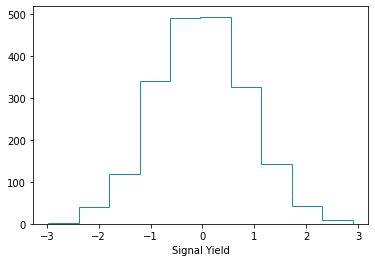

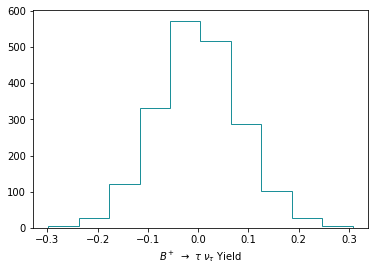

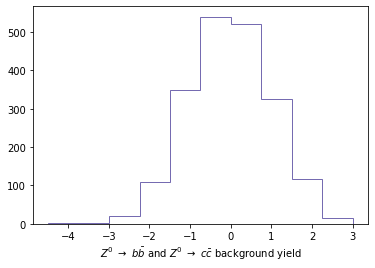

In [16]:
plt.figure()
plt.hist(pull_bc, histtype='step', color="#1c9099")
plt.xlabel('Signal Yield')
plt.plot()

plt.figure()
plt.hist(pull_bu, histtype='step', color="#1c9099")
plt.xlabel(r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ Yield')
plt.plot()

plt.figure()
plt.hist(pull_bb_cc, histtype='step', color="#756bb1")
plt.xlabel(r'$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ background yield')
plt.plot()
#counts_sig, bin_edges_sig = np.histogram(sig_yield)

In [ ]:
print(bu_yield)

In [ ]:
bkg_yield.max()

In [ ]:
len(sig_yield)

In [ ]:
np.sum(sig_yield == 0)

### Détermination de la moyenne pour les yields à l'aide d'une gaussienne

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 214.3                      │              Nfcn = 46               │
│ EDM = 0.000125 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                   value    at limit
------------------  --------  ----------
mu_sig_[792581]     -0.01453       False
sigma_sig_[792581]    0.8791       False


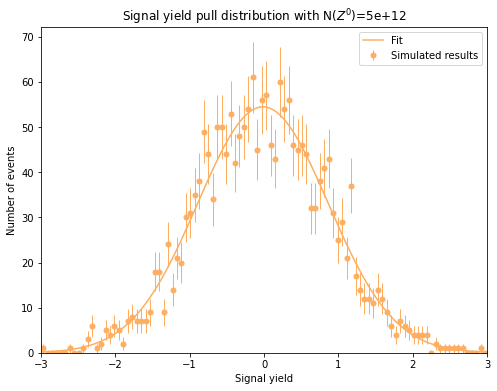

In [36]:
#Espace observable et data
min_sig = -3 #int(sig_yield.min())
max_sig = 3 #int(sig_yield.max()) + 1
obs = zfit.Space('x', limits=(min_sig,max_sig))
data = zfit.Data.from_numpy(obs=obs, array=pull_bc, weights=None) #

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_sig_ = zfit.Parameter(f"mu_sig_{rand_int}", 0.)
sigma_sig_ = zfit.Parameter(f"sigma_sig_{rand_int}", 3.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_sig_, sigma=sigma_sig_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_sig = minimizer.minimize(nll)

print(result_sig.info['original'])
print(result_sig.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs.limits
colour_bc = "#fdae61"

#Points du fit des yields de Bc+
x_plot_sig = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_sig = zfit.run(gauss.pdf(x_plot_sig, norm_range=obs))

#Points de l'histogramme des yields de Bc+
counts_sig, bin_edges_sig = np.histogram(pull_bc, bins=nb_bins, range=(lower[0][0], upper[0][0]))
#

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_sig, bin_edges_sig), 
                yerr = True, 
                color = colour_bc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_sig, 
         y_plot_sig * (len(pull_bc)/nb_bins*obs.area()), #
         color= colour_bc, 
         label= "Fit")

plt.xlabel("Signal yield")
plt.ylabel("Number of events")
plt.title("Signal yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])
plt.legend()

plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 941.1                      │              Nfcn = 41               │
│ EDM = 7.72e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                   value    at limit
-----------------  ---------  ----------
mu_bu_[558608]     0.0001108       False
sigma_bu_[558608]    0.08288       False


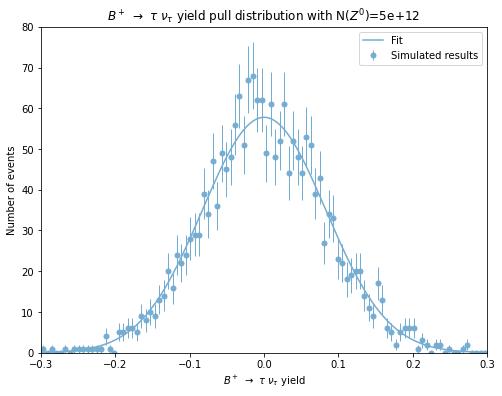

In [24]:
#Espace observable et data
min_bu = -0.3 #int(sig_yield.min())
max_bu = 0.3 #int(sig_yield.max())
obs_bu = zfit.Space('x', limits=(min_bu, max_bu))
data_bu = zfit.Data.from_numpy(obs=obs_bu, array=pull_bu, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bu_ = zfit.Parameter(f"mu_bu_{rand_int}", 0.)
sigma_bu_ = zfit.Parameter(f"sigma_bu_{rand_int}", 0.1)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bu, mu=mu_bu_, sigma=sigma_bu_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data_bu )
minimizer = zfit.minimize.Minuit()
result_bu = minimizer.minimize(nll)

print(result_bu.info['original'])
print(result_bu.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bu.limits
colour_bu = "#74add1"
label_bu = r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield'

#Points du fit des yields de B+
x_plot_bu = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bu = zfit.run(gauss.pdf(x_plot_bu, norm_range=obs_bu))

#Points de l'histogramme des yields de B+
counts_bu, bin_edges_bu = np.histogram(pull_bu, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_bu, bin_edges_bu),
                yerr = True, 
                color = colour_bu, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bu, 
         y_plot_bu * (len(pull_bu)/nb_bins*obs_bu.area()), 
         color= colour_bu, 
         label= "Fit")

plt.xlabel(label_bu)
plt.ylabel("Number of events")
plt.title(r"$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])

plt.legend()
plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 286.2                      │              Nfcn = 60               │
│ EDM = 7.05e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                   value    at limit
------------------  --------  ----------
mu_bkg_[392445]     -0.02013       False
sigma_bkg_[669210]    0.9907       False


KeyError: 'b'

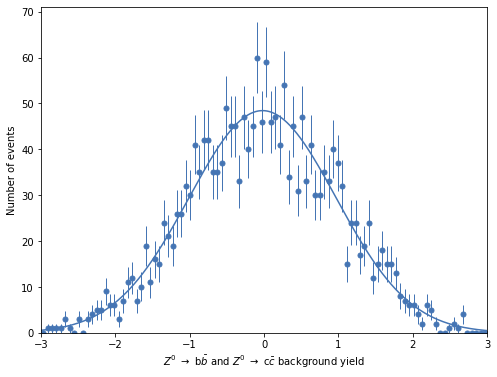

In [38]:
#Espace observable et data
min_bkg = -3 #int(bkg_yield.min())
max_bkg = 3 #int(bkg_yield.max()) + 1
obs_bkg = zfit.Space('x', limits=(min_bkg,max_bkg))
data = zfit.Data.from_numpy(obs=obs_bkg, array=pull_bb_cc, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bkg_ = zfit.Parameter(f"mu_bkg_{rand_int}", 0.)

rand_int = random.randint(0,1000000,size=1)
sigma_bkg_ = zfit.Parameter(f"sigma_bkg_{rand_int}", 5.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_bkg_, sigma=sigma_bkg_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_bkg = minimizer.minimize(nll)

print(result_bkg.info['original'])
print(result_bkg.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bkg.limits
colour_bb_cc = "#4575b4"#"#abd9e9"
label_bb_cc = r"$Z^0$ $\rightarrow$ b$\bar{b}$ and $Z^0$ $\rightarrow$ c$\bar{c}$ background yield"

#Points du fit des yields de Z->bb et Z->cc
x_plot_bkg = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bkg = zfit.run(gauss.pdf(x_plot_bkg, norm_range=obs_bkg))

#Points de l'histogramme des yields de Z->bb et Z->cc
counts_bkg, bin_edges_bkg = np.histogram(pull_bb_cc, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize=[8,6])

mplhep.histplot((counts_bkg, bin_edges_bkg), 
                yerr = True, 
                color = colour_bb_cc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bkg, 
         y_plot_bkg * (len(pull_bb_cc)/nb_bins*obs.area()), 
         color= colour_bb_cc, 
         label= "Fit")


plt.xlabel(label_bb_cc)
plt.ylabel("Number of events")
plt.xlim(lower[0][0], upper[0][0])
plt.title(r"$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.legend()
plt.show()
